In [157]:
import pandas as pd
import string

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import joblib

import matplotlib.pyplot as plt

import numpy as np

In [135]:
#загрузка данных для обучения 
df = pd.read_csv('test-last.csv', header=None, sep=';')
df.columns = ['hosts', 'result']

In [136]:
df.duplicated().sum()

58717

In [137]:
df = df.drop_duplicates()
df.shape

(9155, 2)

In [138]:
# обработка данных 


def check_char(row):
    letter = 0
    number = 0
    symb = 0
    for el in row:
        if el.lower() in string.ascii_lowercase:
            letter += 1
        elif el in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
            number += 1
        else:
            symb += 1
    return letter, number, symb


def def_freq_word(row, y_list):
    if row in y_list:
        return 1
    else:
        return 0
    
    
def encoding(row):
    if row == 'teh':
        return 1
    else:
        return 0

    
def preparing_data(df):
    # текстовые колонки
    df['hosts_text'] = df.hosts.apply(lambda x: ' '.join(x.split('.')))
    df['hosts_list'] = df.hosts.apply(lambda x: x.split('.'))
    df['end'] = df.hosts_list.apply(lambda x: x[-1])
    df['without_end'] = df.hosts_list.apply(lambda x: x[:-1])
    df['main_word'] = df.without_end.apply(lambda x: x[-1])
    
    df['char_in_host'] = df.hosts.apply(lambda x: check_char(x))
    
    #колонки с цифрами
    df['len_host'] = df.hosts.apply(lambda x: len(x))
    #df['len_host_more_than_40'] = df.len_host.apply(lambda x: x > 40).astype('int')
    df['len_end'] = df.end.apply(lambda x: len(x))
    df['len_main_word'] = df.main_word.apply(lambda x: len(x))
    
    df['share_of_end'] = df.len_end / df.len_host
    df['share_of_main_word'] = df.len_main_word / df.len_host
    df['share_of_podhost'] = 1 - df['share_of_end'] - df['share_of_main_word']
    
    df['relation_of_podhost_to_main_word'] = df['len_host'] / df['len_main_word']
    
    df['qnt_words'] = df.hosts_list.apply(lambda x: len(x))
    
    df['letters_in_host'] = df.char_in_host.apply(lambda x: x[0])
    df['numbers_in_host'] = df.char_in_host.apply(lambda x: x[1])
    df['symbols_in_host'] = df.char_in_host.apply(lambda x: x[2])
    
    df['share_of_letters_in_host'] = df.letters_in_host / df.len_host
    df['share_of_numbers_in_host'] = df.numbers_in_host / df.len_host
    df['share_of_symbols_in_host'] = df.symbols_in_host / df.len_host
    
    df['numbers_in_end'] = df.hosts.apply(lambda x: check_char(x)[1])
    
    df['result'] = df['result'].apply(lambda x: encoding(x))
    
    return df


def make_df(string):
    df = pd.DataFrame({'hosts':[string]})
    return df

In [139]:
df = preparing_data(df)
df

hosts  result               hosts_text  \
0          stats.vk-portal.net       1      stats vk-portal net   
1              fcgi5.gnezdo.ru       0          fcgi5 gnezdo ru   
2                  kinogo.zone       0              kinogo zone   
3          servers1.adriver.ru       1      servers1 adriver ru   
4      cs3-4v4.vkuservideo.net       1  cs3-4v4 vkuservideo net   
...                        ...     ...                      ...   
67843           m21.itiiuan.in       0           m21 itiiuan in   
67850            m3.cprgggy.in       0            m3 cprgggy in   
67852     plstat01.cdnvideo.ru       1     plstat01 cdnvideo ru   
67864           m0.gsjxycs.com       0           m0 gsjxycs com   
67871           m41.bcolyyp.in       0           m41 bcolyyp in   

                        hosts_list   end             without_end    main_word  \
0          [stats, vk-portal, net]   net      [stats, vk-portal]    vk-portal   
1              [fcgi5, gnezdo, ru]    ru         [fcgi5, gnezdo]       gnezdo   
2                   [kinogo, zone]  zone                [kinogo]       kinogo   
3          [servers1, adriver, ru]    ru     [servers1, adriver]      adriver   
4      [cs3-4v4, vkuservideo, net]   net  [cs3-4v4, vkuservideo]  vkuservideo   
...                            ...   ...                     ...          ...   
67843           [m21, itiiuan, in]    in          [m21, itiiuan]      itiiuan   
67850            [m3, cprgggy, in]    in           [m3, cprgggy]      cprgggy   
67852     [plstat01, cdnvideo, ru]    ru    [plstat01, cdnvideo]     cdnvideo   
67864           [m0, gsjxycs, com]   com           [m0, gsjxycs]      gsjxycs   
67871           [m41, bcolyyp, in]    in          [m41, bcolyyp]      bcolyyp   

      char_in_host  len_host  len_end  ...  share_of_podhost  \
0       (16, 0, 3)        19        3  ...          0.368421   
1       (12, 0, 3)        15        2  ...          0.466667   
2       (10, 0, 1)        11        4  ...          0.090909   
3       (16, 0, 3)        19        2  ...          0.526316   
4       (17, 0, 6)        23        3  ...          0.391304   
...            ...       ...      ...  ...               ...   
67843   (10, 0, 4)        14        2  ...          0.357143   
67850   (10, 0, 3)        13        2  ...          0.307692   
67852   (16, 0, 4)        20        2  ...          0.500000   
67864   (11, 0, 3)        14        3  ...          0.285714   
67871   (10, 0, 4)        14        2  ...          0.357143   

       relation_of_podhost_to_main_word  qnt_words  letters_in_host  \
0                              2.111111          3               16   
1                              2.500000          3               12   
2                              1.833333          2               10   
3                              2.714286          3               16   
4                              2.090909          3               17   
...                                 ...        ...              ...   
67843                          2.000000          3               10   
67850                          1.857143          3               10   
67852                          2.500000          3               16   
67864                          2.000000          3               11   
67871                          2.000000          3               10   

       numbers_in_host  symbols_in_host  share_of_letters_in_host  \
0                    0                3                  0.842105   
1                    0                3                  0.800000   
2                    0                1                  0.909091   
3                    0                3                  0.842105   
4                    0                6                  0.739130   
...                ...              ...                       ...   
67843                0                4                  0.714286   
67850                0                3                  0.769231   
6785

<AxesSubplot:>

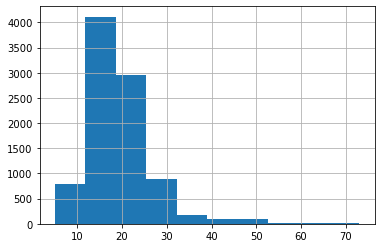

In [140]:
df.len_host.hist()

(array([5045.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4110.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

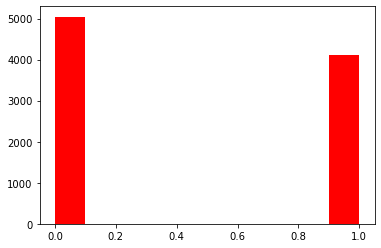

In [153]:
plt.hist(df.result, color='red')

In [163]:
#plt.scatter(df.result, df.len_host)

In [142]:
features = ['len_host', 'len_end', 'len_main_word', 'share_of_end', 'share_of_main_word', \
           'share_of_podhost', 'relation_of_podhost_to_main_word', 'qnt_words', 'letters_in_host', \
            'numbers_in_host', 'symbols_in_host', 'share_of_letters_in_host', \
            'share_of_numbers_in_host', 'share_of_symbols_in_host', 'numbers_in_end']

cat_features = ['hosts', 'hosts_text', 'end', 'main_word']
# 
x = df[features]
y = df['result']
x_cat = x.join(df[cat_features])
x_cat

len_host  len_end  len_main_word  share_of_end  share_of_main_word  \
0            19        3              9      0.157895            0.473684   
1            15        2              6      0.133333            0.400000   
2            11        4              6      0.363636            0.545455   
3            19        2              7      0.105263            0.368421   
4            23        3             11      0.130435            0.478261   
...         ...      ...            ...           ...                 ...   
67843        14        2              7      0.142857            0.500000   
67850        13        2              7      0.153846            0.538462   
67852        20        2              8      0.100000            0.400000   
67864        14        3              7      0.214286            0.500000   
67871        14        2              7      0.142857            0.500000   

       share_of_podhost  relation_of_podhost_to_main_word  qnt_words  \
0              0.368421                          2.111111          3   
1              0.466667                          2.500000          3   
2              0.090909                          1.833333          2   
3              0.526316                          2.714286          3   
4              0.391304                          2.090909          3   
...                 ...                               ...        ...   
67843          0.357143                          2.000000          3   
67850          0.307692                          1.857143          3   
67852          0.500000                          2.500000          3   
67864          0.285714                          2.000000          3   
67871          0.357143                          2.000000          3   

       letters_in_host  numbers_in_host  symbols_in_host  \
0                   16                0                3   
1                   12                0                3   
2                   10                0                1   
3                   16                0                3   
4                   17                0                6   
...                ...              ...              ...   
67843               10                0                4   
67850               10                0                3   
67852               16                0                4   
67864               11                0                3   
67871               10                0                4   

       share_of_letters_in_host  share_of_numbers_in_host  \
0                      0.842105                       0.0   
1                      0.800000                       0.0   
2                      0.909091                       0.0   
3                      0.842105                       0.0   
4                      0.739130                       0.0   
...                         ...                       ...   
67843                  0.714286                       0.0   
67850                  0.769231                       0.0   
67852                  0.800000                       0.0   
67864                  0.785714                       0.0   
67871                  0.714286                       0.0   

       share_of_symbols_in_host  numbers_in_end                    hosts  \
0                      0.157895               0      stats.vk-portal.net   
1                      0.200000               0          fcgi5.gnezdo.ru   
2                      0.090909               0              kinogo.zone   
3                      0.157895               0      servers1.adriver.ru   
4                      0.260870               0  cs3-4v4.vkuservideo.net   
...                         ...             ...                      ...   
67843                  0.285714               0           m21.itiiuan.in   
67850                  0.230769               0            m3.cprgggy.in   
67852                  0.200000               0     plstat01.cdnvideo.ru   
678

### LGBM Model

In [143]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=102, test_size=0.2)


model = LGBMClassifier(metric='auc')
model = model.fit(x_train, y_train)

In [144]:
preds = model.predict(x_test)
preds

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [145]:
f1_score(y_test, preds)

0.6472184531886025

In [22]:
#from sklearn.metrics import SCORERS
#SCORERS.keys()

In [13]:
parameters = {
              'learning_rate':[0.01, 0.013, 0.015, 0.1], \
              'n_estimators':[125, 150], \
              'max_depth': [3, 5, 10, -1], \
              'reg_alpha': [0, 1, 0.5], \
              'reg_lambda': [0, 1, 0.5], \
              'num_leaves': [10, 15]
             }


model = LGBMClassifier(is_unbalance=False, metric='f1_score', objective='binary', random_state=103)
clf = GridSearchCV(model, parameters)
clf.fit(x_train, y_train)

GridSearchCV(estimator=LGBMClassifier(is_unbalance=False, metric='f1_score',
                                      objective='binary', random_state=103),
             param_grid={'learning_rate': [0.01, 0.013, 0.015, 0.1],
                         'max_depth': [3, 5, 10, -1],
                         'n_estimators': [125, 150], 'num_leaves': [10, 15],
                         'reg_alpha': [0, 1, 0.5], 'reg_lambda': [0, 1, 0.5]})

In [14]:
clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 150,
 'num_leaves': 15,
 'reg_alpha': 0,
 'reg_lambda': 0}

In [17]:
model = LGBMClassifier(is_unbalance=False, metric='auc', objective='binary', random_state=103, \
                      learning_rate=0.1, n_estimators=150, num_leaves=15, max_depth=15)

In [18]:
model.fit(x_train, y_train)

LGBMClassifier(is_unbalance=False, max_depth=15, metric='auc', n_estimators=150,
               num_leaves=15, objective='binary', random_state=103)

In [19]:
preds = model.predict(x_test)

In [20]:
f1_score(y_test, preds)

0.6426592797783934

### CatBoost Model

In [146]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x_cat, y, random_state=102, test_size=0.2)

In [147]:
model2 = CatBoostClassifier(cat_features=cat_features)

In [148]:
model2.fit(x_train_c, y_train_c)

Learning rate set to 0.024109
0:	learn: 0.6807000	total: 29.3ms	remaining: 29.3s
1:	learn: 0.6686634	total: 53.2ms	remaining: 26.6s
2:	learn: 0.6574690	total: 77.4ms	remaining: 25.7s
3:	learn: 0.6474248	total: 104ms	remaining: 25.9s
4:	learn: 0.6376068	total: 128ms	remaining: 25.4s
5:	learn: 0.6281818	total: 151ms	remaining: 25s
6:	learn: 0.6204053	total: 168ms	remaining: 23.8s
7:	learn: 0.6122494	total: 192ms	remaining: 23.8s
8:	learn: 0.6041936	total: 219ms	remaining: 24.2s
9:	learn: 0.5969547	total: 256ms	remaining: 25.4s
10:	learn: 0.5900616	total: 280ms	remaining: 25.2s
11:	learn: 0.5827574	total: 319ms	remaining: 26.3s
12:	learn: 0.5767672	total: 343ms	remaining: 26s
13:	learn: 0.5698457	total: 367ms	remaining: 25.8s
14:	learn: 0.5641252	total: 391ms	remaining: 25.7s
15:	learn: 0.5592495	total: 416ms	remaining: 25.6s
16:	learn: 0.5536905	total: 458ms	remaining: 26.5s
17:	learn: 0.5490520	total: 483ms	remaining: 26.3s
18:	learn: 0.5446381	total: 510ms	remaining: 26.4s
19:	learn: 0

166:	learn: 0.4299338	total: 4.69s	remaining: 23.4s
167:	learn: 0.4299166	total: 4.71s	remaining: 23.3s
168:	learn: 0.4297267	total: 4.73s	remaining: 23.3s
169:	learn: 0.4295692	total: 4.76s	remaining: 23.3s
170:	learn: 0.4295526	total: 4.78s	remaining: 23.2s
171:	learn: 0.4292806	total: 4.81s	remaining: 23.2s
172:	learn: 0.4292204	total: 4.83s	remaining: 23.1s
173:	learn: 0.4291312	total: 4.86s	remaining: 23.1s
174:	learn: 0.4289452	total: 4.89s	remaining: 23.1s
175:	learn: 0.4288138	total: 4.92s	remaining: 23s
176:	learn: 0.4287521	total: 4.98s	remaining: 23.2s
177:	learn: 0.4287496	total: 4.99s	remaining: 23s
178:	learn: 0.4286025	total: 5.04s	remaining: 23.1s
179:	learn: 0.4284757	total: 5.06s	remaining: 23.1s
180:	learn: 0.4282103	total: 5.09s	remaining: 23s
181:	learn: 0.4281046	total: 5.11s	remaining: 23s
182:	learn: 0.4279595	total: 5.15s	remaining: 23s
183:	learn: 0.4277438	total: 5.18s	remaining: 23s
184:	learn: 0.4275554	total: 5.21s	remaining: 23s
185:	learn: 0.4274313	tota

330:	learn: 0.4123927	total: 9.33s	remaining: 18.9s
331:	learn: 0.4123212	total: 9.36s	remaining: 18.8s
332:	learn: 0.4122518	total: 9.38s	remaining: 18.8s
333:	learn: 0.4121609	total: 9.4s	remaining: 18.8s
334:	learn: 0.4121574	total: 9.43s	remaining: 18.7s
335:	learn: 0.4120565	total: 9.46s	remaining: 18.7s
336:	learn: 0.4119385	total: 9.48s	remaining: 18.7s
337:	learn: 0.4119114	total: 9.5s	remaining: 18.6s
338:	learn: 0.4117553	total: 9.53s	remaining: 18.6s
339:	learn: 0.4116890	total: 9.57s	remaining: 18.6s
340:	learn: 0.4114934	total: 9.6s	remaining: 18.6s
341:	learn: 0.4113455	total: 9.62s	remaining: 18.5s
342:	learn: 0.4112851	total: 9.65s	remaining: 18.5s
343:	learn: 0.4110977	total: 9.68s	remaining: 18.5s
344:	learn: 0.4110077	total: 9.7s	remaining: 18.4s
345:	learn: 0.4108458	total: 9.72s	remaining: 18.4s
346:	learn: 0.4107803	total: 9.75s	remaining: 18.3s
347:	learn: 0.4106138	total: 9.78s	remaining: 18.3s
348:	learn: 0.4105867	total: 9.8s	remaining: 18.3s
349:	learn: 0.410

491:	learn: 0.3954240	total: 13.9s	remaining: 14.4s
492:	learn: 0.3953941	total: 13.9s	remaining: 14.3s
493:	learn: 0.3952975	total: 14s	remaining: 14.3s
494:	learn: 0.3952278	total: 14s	remaining: 14.3s
495:	learn: 0.3951360	total: 14s	remaining: 14.2s
496:	learn: 0.3951158	total: 14s	remaining: 14.2s
497:	learn: 0.3950833	total: 14.1s	remaining: 14.2s
498:	learn: 0.3950822	total: 14.1s	remaining: 14.1s
499:	learn: 0.3950179	total: 14.1s	remaining: 14.1s
500:	learn: 0.3949257	total: 14.2s	remaining: 14.1s
501:	learn: 0.3948937	total: 14.2s	remaining: 14.1s
502:	learn: 0.3947863	total: 14.2s	remaining: 14.1s
503:	learn: 0.3947048	total: 14.3s	remaining: 14s
504:	learn: 0.3946004	total: 14.3s	remaining: 14s
505:	learn: 0.3944785	total: 14.3s	remaining: 14s
506:	learn: 0.3944069	total: 14.3s	remaining: 14s
507:	learn: 0.3943183	total: 14.4s	remaining: 13.9s
508:	learn: 0.3942572	total: 14.4s	remaining: 13.9s
509:	learn: 0.3941421	total: 14.4s	remaining: 13.9s
510:	learn: 0.3940501	total:

656:	learn: 0.3812395	total: 18.5s	remaining: 9.64s
657:	learn: 0.3811764	total: 18.5s	remaining: 9.61s
658:	learn: 0.3811604	total: 18.5s	remaining: 9.58s
659:	learn: 0.3811569	total: 18.5s	remaining: 9.55s
660:	learn: 0.3810767	total: 18.6s	remaining: 9.53s
661:	learn: 0.3809870	total: 18.6s	remaining: 9.49s
662:	learn: 0.3809106	total: 18.6s	remaining: 9.46s
663:	learn: 0.3808140	total: 18.6s	remaining: 9.44s
664:	learn: 0.3807690	total: 18.7s	remaining: 9.41s
665:	learn: 0.3807323	total: 18.7s	remaining: 9.38s
666:	learn: 0.3807120	total: 18.7s	remaining: 9.35s
667:	learn: 0.3806643	total: 18.8s	remaining: 9.32s
668:	learn: 0.3805808	total: 18.8s	remaining: 9.29s
669:	learn: 0.3804741	total: 18.8s	remaining: 9.26s
670:	learn: 0.3804263	total: 18.8s	remaining: 9.23s
671:	learn: 0.3803022	total: 18.8s	remaining: 9.2s
672:	learn: 0.3802477	total: 18.9s	remaining: 9.17s
673:	learn: 0.3801870	total: 18.9s	remaining: 9.14s
674:	learn: 0.3800890	total: 18.9s	remaining: 9.11s
675:	learn: 0

815:	learn: 0.3704596	total: 22.9s	remaining: 5.17s
816:	learn: 0.3703987	total: 23s	remaining: 5.14s
817:	learn: 0.3703227	total: 23s	remaining: 5.11s
818:	learn: 0.3702910	total: 23s	remaining: 5.08s
819:	learn: 0.3701631	total: 23s	remaining: 5.05s
820:	learn: 0.3701267	total: 23.1s	remaining: 5.03s
821:	learn: 0.3700664	total: 23.1s	remaining: 5s
822:	learn: 0.3700157	total: 23.1s	remaining: 4.97s
823:	learn: 0.3700006	total: 23.1s	remaining: 4.94s
824:	learn: 0.3699934	total: 23.2s	remaining: 4.91s
825:	learn: 0.3699080	total: 23.2s	remaining: 4.88s
826:	learn: 0.3698716	total: 23.2s	remaining: 4.86s
827:	learn: 0.3698307	total: 23.2s	remaining: 4.83s
828:	learn: 0.3696911	total: 23.3s	remaining: 4.8s
829:	learn: 0.3695763	total: 23.3s	remaining: 4.77s
830:	learn: 0.3695274	total: 23.3s	remaining: 4.74s
831:	learn: 0.3695229	total: 23.3s	remaining: 4.71s
832:	learn: 0.3695033	total: 23.4s	remaining: 4.68s
833:	learn: 0.3693883	total: 23.4s	remaining: 4.66s
834:	learn: 0.3693273	to

980:	learn: 0.3613520	total: 27.4s	remaining: 532ms
981:	learn: 0.3613254	total: 27.5s	remaining: 504ms
982:	learn: 0.3613043	total: 27.5s	remaining: 476ms
983:	learn: 0.3612950	total: 27.6s	remaining: 448ms
984:	learn: 0.3612244	total: 27.6s	remaining: 420ms
985:	learn: 0.3611881	total: 27.6s	remaining: 392ms
986:	learn: 0.3610837	total: 27.6s	remaining: 364ms
987:	learn: 0.3609235	total: 27.7s	remaining: 336ms
988:	learn: 0.3609210	total: 27.7s	remaining: 308ms
989:	learn: 0.3609021	total: 27.7s	remaining: 280ms
990:	learn: 0.3608301	total: 27.8s	remaining: 252ms
991:	learn: 0.3607983	total: 27.8s	remaining: 224ms
992:	learn: 0.3607724	total: 27.8s	remaining: 196ms
993:	learn: 0.3606985	total: 27.8s	remaining: 168ms
994:	learn: 0.3606284	total: 27.9s	remaining: 140ms
995:	learn: 0.3605147	total: 27.9s	remaining: 112ms
996:	learn: 0.3604453	total: 27.9s	remaining: 84.1ms
997:	learn: 0.3604316	total: 28s	remaining: 56ms
998:	learn: 0.3603702	total: 28s	remaining: 28ms
999:	learn: 0.360

In [149]:
pred2 = model2.predict(x_test_c)

In [150]:
f1_score(y_test_c, pred2, average='micro')

0.795193883123976

In [160]:
precision_score(y_test_c, pred2, average='micro')

0.795193883123976

In [161]:
recall_score(y_test_c, pred2, average='micro')

0.795193883123976

In [162]:
x_cat.shape

(9155, 19)

In [151]:
#сохранение модели

with open('model3.py', 'wb') as output:
    joblib.dump(model2, output)

In [47]:
parameters = {'iterations':[100, 150], \
              'learning_rate': [0.15, 0.2, 0.3], \
              'depth': [5, 7], \
              'l2_leaf_reg': [0, 2, 3],
              'model_size_reg': [0, 1, 0.5]
             }

model = CatBoostClassifier(random_state=103, \
                            cat_features=cat_features)
clf = GridSearchCV(model, parameters)
clf.fit(x_train_c, y_train_c)

0:	learn: 0.6294855	total: 15.7ms	remaining: 1.56s
1:	learn: 0.5841555	total: 33.4ms	remaining: 1.64s
2:	learn: 0.5500609	total: 50.7ms	remaining: 1.64s
3:	learn: 0.5213432	total: 67.9ms	remaining: 1.63s
4:	learn: 0.5062762	total: 85.2ms	remaining: 1.62s
5:	learn: 0.5002109	total: 92.9ms	remaining: 1.45s
6:	learn: 0.4922479	total: 110ms	remaining: 1.46s
7:	learn: 0.4888355	total: 118ms	remaining: 1.35s
8:	learn: 0.4859532	total: 128ms	remaining: 1.29s
9:	learn: 0.4777447	total: 145ms	remaining: 1.3s
10:	learn: 0.4755857	total: 156ms	remaining: 1.26s
11:	learn: 0.4710931	total: 172ms	remaining: 1.26s
12:	learn: 0.4678569	total: 190ms	remaining: 1.27s
13:	learn: 0.4594234	total: 206ms	remaining: 1.27s
14:	learn: 0.4565986	total: 227ms	remaining: 1.29s
15:	learn: 0.4551370	total: 245ms	remaining: 1.28s
16:	learn: 0.4520253	total: 304ms	remaining: 1.49s
17:	learn: 0.4503832	total: 325ms	remaining: 1.48s
18:	learn: 0.4478247	total: 342ms	remaining: 1.46s
19:	learn: 0.4465185	total: 359ms	re

67:	learn: 0.4016284	total: 1.22s	remaining: 576ms
68:	learn: 0.4007196	total: 1.24s	remaining: 558ms
69:	learn: 0.3997366	total: 1.26s	remaining: 540ms
70:	learn: 0.3991021	total: 1.28s	remaining: 522ms
71:	learn: 0.3974764	total: 1.29s	remaining: 504ms
72:	learn: 0.3962316	total: 1.31s	remaining: 486ms
73:	learn: 0.3959419	total: 1.33s	remaining: 468ms
74:	learn: 0.3951375	total: 1.36s	remaining: 455ms
75:	learn: 0.3943832	total: 1.38s	remaining: 436ms
76:	learn: 0.3936176	total: 1.4s	remaining: 418ms
77:	learn: 0.3931338	total: 1.42s	remaining: 400ms
78:	learn: 0.3919392	total: 1.45s	remaining: 385ms
79:	learn: 0.3910647	total: 1.46s	remaining: 366ms
80:	learn: 0.3903713	total: 1.48s	remaining: 348ms
81:	learn: 0.3894332	total: 1.5s	remaining: 329ms
82:	learn: 0.3883723	total: 1.52s	remaining: 311ms
83:	learn: 0.3876221	total: 1.54s	remaining: 293ms
84:	learn: 0.3865746	total: 1.55s	remaining: 274ms
85:	learn: 0.3860295	total: 1.57s	remaining: 256ms
86:	learn: 0.3852145	total: 1.59s

37:	learn: 0.4237154	total: 635ms	remaining: 1.03s
38:	learn: 0.4232137	total: 666ms	remaining: 1.04s
39:	learn: 0.4220955	total: 682ms	remaining: 1.02s
40:	learn: 0.4212563	total: 699ms	remaining: 1s
41:	learn: 0.4206385	total: 716ms	remaining: 989ms
42:	learn: 0.4195962	total: 749ms	remaining: 993ms
43:	learn: 0.4179055	total: 768ms	remaining: 977ms
44:	learn: 0.4176917	total: 799ms	remaining: 976ms
45:	learn: 0.4172414	total: 825ms	remaining: 969ms
46:	learn: 0.4164347	total: 843ms	remaining: 951ms
47:	learn: 0.4141989	total: 862ms	remaining: 934ms
48:	learn: 0.4135156	total: 882ms	remaining: 918ms
49:	learn: 0.4131275	total: 900ms	remaining: 900ms
50:	learn: 0.4122694	total: 917ms	remaining: 881ms
51:	learn: 0.4115687	total: 935ms	remaining: 863ms
52:	learn: 0.4114734	total: 953ms	remaining: 845ms
53:	learn: 0.4105467	total: 971ms	remaining: 827ms
54:	learn: 0.4100012	total: 1.03s	remaining: 840ms
55:	learn: 0.4092629	total: 1.05s	remaining: 822ms
56:	learn: 0.4087783	total: 1.06s	

4:	learn: 0.5092624	total: 98.5ms	remaining: 1.87s
5:	learn: 0.4996041	total: 116ms	remaining: 1.82s
6:	learn: 0.4922449	total: 133ms	remaining: 1.77s
7:	learn: 0.4848765	total: 150ms	remaining: 1.73s
8:	learn: 0.4794790	total: 167ms	remaining: 1.69s
9:	learn: 0.4734344	total: 187ms	remaining: 1.69s
10:	learn: 0.4701870	total: 204ms	remaining: 1.65s
11:	learn: 0.4664730	total: 220ms	remaining: 1.62s
12:	learn: 0.4633444	total: 238ms	remaining: 1.59s
13:	learn: 0.4610878	total: 254ms	remaining: 1.56s
14:	learn: 0.4587890	total: 271ms	remaining: 1.53s
15:	learn: 0.4571643	total: 287ms	remaining: 1.51s
16:	learn: 0.4549283	total: 307ms	remaining: 1.5s
17:	learn: 0.4523734	total: 324ms	remaining: 1.48s
18:	learn: 0.4510301	total: 342ms	remaining: 1.46s
19:	learn: 0.4490572	total: 360ms	remaining: 1.44s
20:	learn: 0.4469263	total: 377ms	remaining: 1.42s
21:	learn: 0.4456518	total: 394ms	remaining: 1.4s
22:	learn: 0.4447777	total: 411ms	remaining: 1.38s
23:	learn: 0.4429581	total: 428ms	rema

71:	learn: 0.3968073	total: 1.27s	remaining: 494ms
72:	learn: 0.3961902	total: 1.29s	remaining: 477ms
73:	learn: 0.3954561	total: 1.31s	remaining: 459ms
74:	learn: 0.3948456	total: 1.32s	remaining: 441ms
75:	learn: 0.3945501	total: 1.34s	remaining: 424ms
76:	learn: 0.3935694	total: 1.36s	remaining: 406ms
77:	learn: 0.3920369	total: 1.38s	remaining: 388ms
78:	learn: 0.3914075	total: 1.39s	remaining: 370ms
79:	learn: 0.3909716	total: 1.41s	remaining: 352ms
80:	learn: 0.3899417	total: 1.43s	remaining: 334ms
81:	learn: 0.3890338	total: 1.44s	remaining: 317ms
82:	learn: 0.3883190	total: 1.46s	remaining: 299ms
83:	learn: 0.3880640	total: 1.48s	remaining: 281ms
84:	learn: 0.3874112	total: 1.5s	remaining: 264ms
85:	learn: 0.3871387	total: 1.52s	remaining: 247ms
86:	learn: 0.3866970	total: 1.53s	remaining: 229ms
87:	learn: 0.3860312	total: 1.55s	remaining: 211ms
88:	learn: 0.3849378	total: 1.57s	remaining: 194ms
89:	learn: 0.3843583	total: 1.58s	remaining: 176ms
90:	learn: 0.3834534	total: 1.63

36:	learn: 0.4184728	total: 642ms	remaining: 1.09s
37:	learn: 0.4176064	total: 660ms	remaining: 1.08s
38:	learn: 0.4166182	total: 678ms	remaining: 1.06s
39:	learn: 0.4158699	total: 694ms	remaining: 1.04s
40:	learn: 0.4151408	total: 711ms	remaining: 1.02s
41:	learn: 0.4142869	total: 728ms	remaining: 1s
42:	learn: 0.4124267	total: 746ms	remaining: 989ms
43:	learn: 0.4111559	total: 763ms	remaining: 971ms
44:	learn: 0.4108304	total: 780ms	remaining: 953ms
45:	learn: 0.4106046	total: 797ms	remaining: 936ms
46:	learn: 0.4093743	total: 817ms	remaining: 921ms
47:	learn: 0.4089616	total: 834ms	remaining: 904ms
48:	learn: 0.4089156	total: 843ms	remaining: 878ms
49:	learn: 0.4082030	total: 861ms	remaining: 861ms
50:	learn: 0.4075215	total: 878ms	remaining: 844ms
51:	learn: 0.4065153	total: 895ms	remaining: 826ms
52:	learn: 0.4061057	total: 912ms	remaining: 809ms
53:	learn: 0.4053010	total: 930ms	remaining: 793ms
54:	learn: 0.4047604	total: 949ms	remaining: 777ms
55:	learn: 0.4038846	total: 966ms	

0:	learn: 0.6294855	total: 30.5ms	remaining: 3.02s
1:	learn: 0.5800522	total: 48.1ms	remaining: 2.36s
2:	learn: 0.5479307	total: 65ms	remaining: 2.1s
3:	learn: 0.5252222	total: 82.6ms	remaining: 1.98s
4:	learn: 0.5092624	total: 100ms	remaining: 1.9s
5:	learn: 0.4996041	total: 117ms	remaining: 1.83s
6:	learn: 0.4922449	total: 138ms	remaining: 1.84s
7:	learn: 0.4848765	total: 179ms	remaining: 2.06s
8:	learn: 0.4794790	total: 197ms	remaining: 1.99s
9:	learn: 0.4734344	total: 214ms	remaining: 1.92s
10:	learn: 0.4701870	total: 230ms	remaining: 1.86s
11:	learn: 0.4664730	total: 250ms	remaining: 1.83s
12:	learn: 0.4633444	total: 267ms	remaining: 1.78s
13:	learn: 0.4610878	total: 283ms	remaining: 1.74s
14:	learn: 0.4587890	total: 300ms	remaining: 1.7s
15:	learn: 0.4571643	total: 317ms	remaining: 1.67s
16:	learn: 0.4549283	total: 334ms	remaining: 1.63s
17:	learn: 0.4523734	total: 351ms	remaining: 1.6s
18:	learn: 0.4510301	total: 368ms	remaining: 1.57s
19:	learn: 0.4490572	total: 385ms	remaining

72:	learn: 0.3931331	total: 1.26s	remaining: 467ms
73:	learn: 0.3920449	total: 1.28s	remaining: 450ms
74:	learn: 0.3913853	total: 1.3s	remaining: 434ms
75:	learn: 0.3907261	total: 1.32s	remaining: 416ms
76:	learn: 0.3900912	total: 1.33s	remaining: 398ms
77:	learn: 0.3895944	total: 1.35s	remaining: 381ms
78:	learn: 0.3892257	total: 1.37s	remaining: 364ms
79:	learn: 0.3888620	total: 1.38s	remaining: 346ms
80:	learn: 0.3881825	total: 1.4s	remaining: 329ms
81:	learn: 0.3865637	total: 1.42s	remaining: 311ms
82:	learn: 0.3858458	total: 1.43s	remaining: 294ms
83:	learn: 0.3853573	total: 1.45s	remaining: 276ms
84:	learn: 0.3839571	total: 1.47s	remaining: 259ms
85:	learn: 0.3828707	total: 1.49s	remaining: 242ms
86:	learn: 0.3824031	total: 1.5s	remaining: 225ms
87:	learn: 0.3817476	total: 1.52s	remaining: 208ms
88:	learn: 0.3809002	total: 1.54s	remaining: 190ms
89:	learn: 0.3803516	total: 1.56s	remaining: 173ms
90:	learn: 0.3798453	total: 1.57s	remaining: 156ms
91:	learn: 0.3792853	total: 1.59s	

44:	learn: 0.4198313	total: 767ms	remaining: 938ms
45:	learn: 0.4183659	total: 785ms	remaining: 921ms
46:	learn: 0.4148246	total: 802ms	remaining: 904ms
47:	learn: 0.4132161	total: 819ms	remaining: 887ms
48:	learn: 0.4127683	total: 835ms	remaining: 869ms
49:	learn: 0.4123712	total: 852ms	remaining: 852ms
50:	learn: 0.4114215	total: 869ms	remaining: 835ms
51:	learn: 0.4104707	total: 889ms	remaining: 820ms
52:	learn: 0.4100164	total: 905ms	remaining: 803ms
53:	learn: 0.4088725	total: 922ms	remaining: 785ms
54:	learn: 0.4081465	total: 938ms	remaining: 768ms
55:	learn: 0.4070670	total: 955ms	remaining: 750ms
56:	learn: 0.4056372	total: 974ms	remaining: 735ms
57:	learn: 0.4045675	total: 997ms	remaining: 722ms
58:	learn: 0.4037803	total: 1.01s	remaining: 705ms
59:	learn: 0.4028313	total: 1.03s	remaining: 688ms
60:	learn: 0.4020578	total: 1.05s	remaining: 670ms
61:	learn: 0.4013736	total: 1.06s	remaining: 653ms
62:	learn: 0.4004140	total: 1.08s	remaining: 635ms
63:	learn: 0.3988888	total: 1.1

14:	learn: 0.4421696	total: 261ms	remaining: 1.48s
15:	learn: 0.4400149	total: 279ms	remaining: 1.46s
16:	learn: 0.4385512	total: 296ms	remaining: 1.44s
17:	learn: 0.4367337	total: 312ms	remaining: 1.42s
18:	learn: 0.4365067	total: 323ms	remaining: 1.38s
19:	learn: 0.4347680	total: 339ms	remaining: 1.36s
20:	learn: 0.4329878	total: 355ms	remaining: 1.34s
21:	learn: 0.4314917	total: 372ms	remaining: 1.32s
22:	learn: 0.4299909	total: 389ms	remaining: 1.3s
23:	learn: 0.4287930	total: 405ms	remaining: 1.28s
24:	learn: 0.4272737	total: 422ms	remaining: 1.27s
25:	learn: 0.4262422	total: 439ms	remaining: 1.25s
26:	learn: 0.4258652	total: 459ms	remaining: 1.24s
27:	learn: 0.4240759	total: 476ms	remaining: 1.22s
28:	learn: 0.4216455	total: 494ms	remaining: 1.21s
29:	learn: 0.4216455	total: 498ms	remaining: 1.16s
30:	learn: 0.4205046	total: 515ms	remaining: 1.15s
31:	learn: 0.4188957	total: 532ms	remaining: 1.13s
32:	learn: 0.4170412	total: 549ms	remaining: 1.11s
33:	learn: 0.4157891	total: 566m

81:	learn: 0.3750017	total: 1.41s	remaining: 310ms
82:	learn: 0.3742932	total: 1.43s	remaining: 293ms
83:	learn: 0.3738963	total: 1.45s	remaining: 275ms
84:	learn: 0.3732517	total: 1.46s	remaining: 258ms
85:	learn: 0.3725256	total: 1.48s	remaining: 241ms
86:	learn: 0.3721755	total: 1.5s	remaining: 223ms
87:	learn: 0.3714169	total: 1.51s	remaining: 206ms
88:	learn: 0.3700592	total: 1.53s	remaining: 189ms
89:	learn: 0.3693005	total: 1.55s	remaining: 172ms
90:	learn: 0.3686561	total: 1.56s	remaining: 155ms
91:	learn: 0.3681797	total: 1.58s	remaining: 137ms
92:	learn: 0.3679675	total: 1.6s	remaining: 120ms
93:	learn: 0.3667539	total: 1.61s	remaining: 103ms
94:	learn: 0.3653017	total: 1.63s	remaining: 86ms
95:	learn: 0.3640498	total: 1.65s	remaining: 68.8ms
96:	learn: 0.3634779	total: 1.67s	remaining: 51.6ms
97:	learn: 0.3630331	total: 1.68s	remaining: 34.4ms
98:	learn: 0.3622302	total: 1.7s	remaining: 17.2ms
99:	learn: 0.3612308	total: 1.72s	remaining: 0us
0:	learn: 0.6076963	total: 26.8ms

49:	learn: 0.4049100	total: 829ms	remaining: 829ms
50:	learn: 0.4037445	total: 846ms	remaining: 813ms
51:	learn: 0.4030635	total: 864ms	remaining: 798ms
52:	learn: 0.4020365	total: 881ms	remaining: 782ms
53:	learn: 0.4008265	total: 898ms	remaining: 765ms
54:	learn: 0.3999065	total: 916ms	remaining: 750ms
55:	learn: 0.3989705	total: 933ms	remaining: 733ms
56:	learn: 0.3982085	total: 952ms	remaining: 718ms
57:	learn: 0.3976627	total: 970ms	remaining: 702ms
58:	learn: 0.3965258	total: 987ms	remaining: 686ms
59:	learn: 0.3955686	total: 1s	remaining: 669ms
60:	learn: 0.3945518	total: 1.02s	remaining: 654ms
61:	learn: 0.3934115	total: 1.04s	remaining: 638ms
62:	learn: 0.3926708	total: 1.06s	remaining: 621ms
63:	learn: 0.3921654	total: 1.07s	remaining: 605ms
64:	learn: 0.3905001	total: 1.09s	remaining: 588ms
65:	learn: 0.3898752	total: 1.11s	remaining: 571ms
66:	learn: 0.3892012	total: 1.13s	remaining: 554ms
67:	learn: 0.3886403	total: 1.14s	remaining: 537ms
68:	learn: 0.3877614	total: 1.16s	

18:	learn: 0.4407940	total: 339ms	remaining: 1.44s
19:	learn: 0.4398638	total: 356ms	remaining: 1.42s
20:	learn: 0.4382311	total: 373ms	remaining: 1.4s
21:	learn: 0.4327759	total: 389ms	remaining: 1.38s
22:	learn: 0.4307519	total: 406ms	remaining: 1.36s
23:	learn: 0.4288596	total: 423ms	remaining: 1.34s
24:	learn: 0.4281545	total: 440ms	remaining: 1.32s
25:	learn: 0.4275745	total: 457ms	remaining: 1.3s
26:	learn: 0.4262448	total: 474ms	remaining: 1.28s
27:	learn: 0.4255715	total: 491ms	remaining: 1.26s
28:	learn: 0.4245268	total: 507ms	remaining: 1.24s
29:	learn: 0.4238191	total: 524ms	remaining: 1.22s
30:	learn: 0.4228676	total: 542ms	remaining: 1.21s
31:	learn: 0.4219975	total: 559ms	remaining: 1.19s
32:	learn: 0.4215200	total: 576ms	remaining: 1.17s
33:	learn: 0.4205304	total: 593ms	remaining: 1.15s
34:	learn: 0.4200952	total: 610ms	remaining: 1.13s
35:	learn: 0.4198131	total: 626ms	remaining: 1.11s
36:	learn: 0.4187781	total: 643ms	remaining: 1.09s
37:	learn: 0.4180715	total: 660ms

84:	learn: 0.3720059	total: 1.47s	remaining: 259ms
85:	learn: 0.3714068	total: 1.49s	remaining: 242ms
86:	learn: 0.3710036	total: 1.5s	remaining: 224ms
87:	learn: 0.3702123	total: 1.52s	remaining: 207ms
88:	learn: 0.3692160	total: 1.54s	remaining: 190ms
89:	learn: 0.3679880	total: 1.55s	remaining: 173ms
90:	learn: 0.3670123	total: 1.57s	remaining: 155ms
91:	learn: 0.3664497	total: 1.58s	remaining: 138ms
92:	learn: 0.3657311	total: 1.6s	remaining: 121ms
93:	learn: 0.3650057	total: 1.62s	remaining: 103ms
94:	learn: 0.3645777	total: 1.64s	remaining: 86.1ms
95:	learn: 0.3631083	total: 1.65s	remaining: 68.9ms
96:	learn: 0.3623254	total: 1.67s	remaining: 51.7ms
97:	learn: 0.3612140	total: 1.69s	remaining: 34.5ms
98:	learn: 0.3605837	total: 1.71s	remaining: 17.2ms
99:	learn: 0.3595955	total: 1.72s	remaining: 0us
0:	learn: 0.6076963	total: 23.6ms	remaining: 2.34s
1:	learn: 0.5630035	total: 42.6ms	remaining: 2.09s
2:	learn: 0.5307547	total: 61.6ms	remaining: 1.99s
3:	learn: 0.5157179	total: 79.

50:	learn: 0.3992101	total: 901ms	remaining: 865ms
51:	learn: 0.3978781	total: 918ms	remaining: 848ms
52:	learn: 0.3971933	total: 935ms	remaining: 829ms
53:	learn: 0.3955946	total: 956ms	remaining: 814ms
54:	learn: 0.3949938	total: 972ms	remaining: 795ms
55:	learn: 0.3940589	total: 989ms	remaining: 777ms
56:	learn: 0.3925262	total: 1s	remaining: 759ms
57:	learn: 0.3914687	total: 1.02s	remaining: 740ms
58:	learn: 0.3905940	total: 1.04s	remaining: 722ms
59:	learn: 0.3890953	total: 1.05s	remaining: 704ms
60:	learn: 0.3878288	total: 1.07s	remaining: 685ms
61:	learn: 0.3873098	total: 1.09s	remaining: 669ms
62:	learn: 0.3859287	total: 1.11s	remaining: 651ms
63:	learn: 0.3855954	total: 1.13s	remaining: 633ms
64:	learn: 0.3849520	total: 1.14s	remaining: 615ms
65:	learn: 0.3838872	total: 1.16s	remaining: 598ms
66:	learn: 0.3825693	total: 1.18s	remaining: 579ms
67:	learn: 0.3820960	total: 1.2s	remaining: 563ms
68:	learn: 0.3806152	total: 1.21s	remaining: 545ms
69:	learn: 0.3799662	total: 1.23s	r

22:	learn: 0.4289846	total: 426ms	remaining: 1.42s
23:	learn: 0.4282133	total: 443ms	remaining: 1.4s
24:	learn: 0.4274274	total: 460ms	remaining: 1.38s
25:	learn: 0.4265693	total: 477ms	remaining: 1.36s
26:	learn: 0.4260888	total: 494ms	remaining: 1.33s
27:	learn: 0.4256460	total: 511ms	remaining: 1.31s
28:	learn: 0.4248115	total: 528ms	remaining: 1.29s
29:	learn: 0.4247722	total: 538ms	remaining: 1.26s
30:	learn: 0.4242305	total: 555ms	remaining: 1.23s
31:	learn: 0.4217426	total: 572ms	remaining: 1.21s
32:	learn: 0.4207321	total: 588ms	remaining: 1.19s
33:	learn: 0.4183239	total: 606ms	remaining: 1.18s
34:	learn: 0.4170057	total: 625ms	remaining: 1.16s
35:	learn: 0.4159425	total: 643ms	remaining: 1.14s
36:	learn: 0.4156728	total: 660ms	remaining: 1.12s
37:	learn: 0.4150265	total: 677ms	remaining: 1.1s
38:	learn: 0.4145957	total: 694ms	remaining: 1.08s
39:	learn: 0.4135857	total: 710ms	remaining: 1.06s
40:	learn: 0.4124957	total: 728ms	remaining: 1.05s
41:	learn: 0.4113030	total: 747ms

94:	learn: 0.3578064	total: 1.65s	remaining: 86.6ms
95:	learn: 0.3571700	total: 1.66s	remaining: 69.3ms
96:	learn: 0.3563170	total: 1.68s	remaining: 52ms
97:	learn: 0.3553169	total: 1.7s	remaining: 34.6ms
98:	learn: 0.3548346	total: 1.73s	remaining: 17.5ms
99:	learn: 0.3541582	total: 1.75s	remaining: 0us
0:	learn: 0.6076963	total: 27.6ms	remaining: 2.73s
1:	learn: 0.5630035	total: 45.1ms	remaining: 2.21s
2:	learn: 0.5307547	total: 62.5ms	remaining: 2.02s
3:	learn: 0.5157179	total: 78.9ms	remaining: 1.89s
4:	learn: 0.4974659	total: 95.9ms	remaining: 1.82s
5:	learn: 0.4857280	total: 113ms	remaining: 1.77s
6:	learn: 0.4766791	total: 131ms	remaining: 1.74s
7:	learn: 0.4695511	total: 147ms	remaining: 1.7s
8:	learn: 0.4641339	total: 165ms	remaining: 1.67s
9:	learn: 0.4598194	total: 182ms	remaining: 1.64s
10:	learn: 0.4576541	total: 198ms	remaining: 1.6s
11:	learn: 0.4554195	total: 215ms	remaining: 1.58s
12:	learn: 0.4538348	total: 234ms	remaining: 1.56s
13:	learn: 0.4523248	total: 251ms	rema

57:	learn: 0.3966740	total: 985ms	remaining: 713ms
58:	learn: 0.3958078	total: 1s	remaining: 696ms
59:	learn: 0.3950521	total: 1.02s	remaining: 679ms
60:	learn: 0.3940428	total: 1.03s	remaining: 662ms
61:	learn: 0.3930347	total: 1.05s	remaining: 645ms
62:	learn: 0.3918647	total: 1.07s	remaining: 628ms
63:	learn: 0.3906541	total: 1.09s	remaining: 614ms
64:	learn: 0.3888249	total: 1.11s	remaining: 597ms
65:	learn: 0.3882802	total: 1.13s	remaining: 580ms
66:	learn: 0.3876905	total: 1.14s	remaining: 563ms
67:	learn: 0.3870518	total: 1.16s	remaining: 546ms
68:	learn: 0.3860987	total: 1.18s	remaining: 529ms
69:	learn: 0.3855646	total: 1.2s	remaining: 513ms
70:	learn: 0.3847226	total: 1.22s	remaining: 500ms
71:	learn: 0.3839599	total: 1.24s	remaining: 483ms
72:	learn: 0.3833543	total: 1.26s	remaining: 466ms
73:	learn: 0.3826386	total: 1.28s	remaining: 448ms
74:	learn: 0.3812902	total: 1.29s	remaining: 431ms
75:	learn: 0.3790861	total: 1.31s	remaining: 414ms
76:	learn: 0.3779535	total: 1.33s	r

24:	learn: 0.4176257	total: 436ms	remaining: 1.31s
25:	learn: 0.4164425	total: 453ms	remaining: 1.29s
26:	learn: 0.4155671	total: 471ms	remaining: 1.27s
27:	learn: 0.4139608	total: 487ms	remaining: 1.25s
28:	learn: 0.4121654	total: 504ms	remaining: 1.23s
29:	learn: 0.4112827	total: 521ms	remaining: 1.22s
30:	learn: 0.4092713	total: 538ms	remaining: 1.2s
31:	learn: 0.4078591	total: 555ms	remaining: 1.18s
32:	learn: 0.4060454	total: 571ms	remaining: 1.16s
33:	learn: 0.4055688	total: 588ms	remaining: 1.14s
34:	learn: 0.4046663	total: 605ms	remaining: 1.12s
35:	learn: 0.4033380	total: 622ms	remaining: 1.11s
36:	learn: 0.4011969	total: 640ms	remaining: 1.09s
37:	learn: 0.4005197	total: 658ms	remaining: 1.07s
38:	learn: 0.3976095	total: 675ms	remaining: 1.05s
39:	learn: 0.3966233	total: 692ms	remaining: 1.04s
40:	learn: 0.3948946	total: 709ms	remaining: 1.02s
41:	learn: 0.3941019	total: 725ms	remaining: 1s
42:	learn: 0.3927579	total: 742ms	remaining: 983ms
43:	learn: 0.3912879	total: 759ms	r

92:	learn: 0.3392253	total: 1.69s	remaining: 127ms
93:	learn: 0.3384297	total: 1.71s	remaining: 109ms
94:	learn: 0.3371510	total: 1.73s	remaining: 90.8ms
95:	learn: 0.3364619	total: 1.74s	remaining: 72.6ms
96:	learn: 0.3349459	total: 1.76s	remaining: 54.4ms
97:	learn: 0.3347082	total: 1.78s	remaining: 36.2ms
98:	learn: 0.3342951	total: 1.81s	remaining: 18.3ms
99:	learn: 0.3334705	total: 1.83s	remaining: 0us
0:	learn: 0.5753997	total: 30.2ms	remaining: 2.99s
1:	learn: 0.5240570	total: 48.6ms	remaining: 2.38s
2:	learn: 0.4893909	total: 66.2ms	remaining: 2.14s
3:	learn: 0.4716022	total: 82.8ms	remaining: 1.99s
4:	learn: 0.4678000	total: 93.3ms	remaining: 1.77s
5:	learn: 0.4610034	total: 119ms	remaining: 1.87s
6:	learn: 0.4566070	total: 136ms	remaining: 1.81s
7:	learn: 0.4530404	total: 153ms	remaining: 1.76s
8:	learn: 0.4528097	total: 162ms	remaining: 1.64s
9:	learn: 0.4500654	total: 183ms	remaining: 1.65s
10:	learn: 0.4474558	total: 201ms	remaining: 1.63s
11:	learn: 0.4459256	total: 212ms

59:	learn: 0.3699455	total: 1.04s	remaining: 693ms
60:	learn: 0.3685093	total: 1.06s	remaining: 676ms
61:	learn: 0.3678827	total: 1.07s	remaining: 658ms
62:	learn: 0.3660896	total: 1.09s	remaining: 641ms
63:	learn: 0.3656631	total: 1.11s	remaining: 623ms
64:	learn: 0.3647851	total: 1.12s	remaining: 605ms
65:	learn: 0.3635350	total: 1.14s	remaining: 588ms
66:	learn: 0.3619756	total: 1.16s	remaining: 570ms
67:	learn: 0.3608990	total: 1.17s	remaining: 553ms
68:	learn: 0.3598000	total: 1.19s	remaining: 535ms
69:	learn: 0.3582573	total: 1.21s	remaining: 517ms
70:	learn: 0.3572621	total: 1.22s	remaining: 500ms
71:	learn: 0.3561223	total: 1.24s	remaining: 484ms
72:	learn: 0.3546205	total: 1.26s	remaining: 467ms
73:	learn: 0.3533729	total: 1.28s	remaining: 449ms
74:	learn: 0.3525417	total: 1.29s	remaining: 432ms
75:	learn: 0.3518966	total: 1.31s	remaining: 414ms
76:	learn: 0.3507227	total: 1.33s	remaining: 397ms
77:	learn: 0.3499544	total: 1.34s	remaining: 379ms
78:	learn: 0.3493162	total: 1.3

24:	learn: 0.4201708	total: 435ms	remaining: 1.31s
25:	learn: 0.4192561	total: 454ms	remaining: 1.29s
26:	learn: 0.4172469	total: 471ms	remaining: 1.27s
27:	learn: 0.4153995	total: 487ms	remaining: 1.25s
28:	learn: 0.4144976	total: 504ms	remaining: 1.23s
29:	learn: 0.4141299	total: 521ms	remaining: 1.21s
30:	learn: 0.4124609	total: 538ms	remaining: 1.2s
31:	learn: 0.4117601	total: 554ms	remaining: 1.18s
32:	learn: 0.4090990	total: 571ms	remaining: 1.16s
33:	learn: 0.4084206	total: 588ms	remaining: 1.14s
34:	learn: 0.4069342	total: 605ms	remaining: 1.12s
35:	learn: 0.4049987	total: 621ms	remaining: 1.1s
36:	learn: 0.4034187	total: 640ms	remaining: 1.09s
37:	learn: 0.4024804	total: 657ms	remaining: 1.07s
38:	learn: 0.3994987	total: 675ms	remaining: 1.05s
39:	learn: 0.3981895	total: 692ms	remaining: 1.04s
40:	learn: 0.3967526	total: 710ms	remaining: 1.02s
41:	learn: 0.3951329	total: 731ms	remaining: 1.01s
42:	learn: 0.3940623	total: 750ms	remaining: 995ms
43:	learn: 0.3927089	total: 782ms

89:	learn: 0.3454455	total: 1.68s	remaining: 187ms
90:	learn: 0.3448390	total: 1.7s	remaining: 168ms
91:	learn: 0.3443178	total: 1.72s	remaining: 150ms
92:	learn: 0.3439609	total: 1.74s	remaining: 131ms
93:	learn: 0.3435026	total: 1.76s	remaining: 112ms
94:	learn: 0.3414227	total: 1.77s	remaining: 93.4ms
95:	learn: 0.3406758	total: 1.79s	remaining: 74.7ms
96:	learn: 0.3401369	total: 1.81s	remaining: 56ms
97:	learn: 0.3397793	total: 1.83s	remaining: 37.3ms
98:	learn: 0.3390918	total: 1.85s	remaining: 18.7ms
99:	learn: 0.3386503	total: 1.86s	remaining: 0us
0:	learn: 0.5753997	total: 25.7ms	remaining: 2.54s
1:	learn: 0.5304024	total: 43.5ms	remaining: 2.13s
2:	learn: 0.5047170	total: 61.2ms	remaining: 1.98s
3:	learn: 0.4877361	total: 79.8ms	remaining: 1.91s
4:	learn: 0.4740475	total: 98.3ms	remaining: 1.87s
5:	learn: 0.4684774	total: 116ms	remaining: 1.82s
6:	learn: 0.4643034	total: 133ms	remaining: 1.77s
7:	learn: 0.4523560	total: 151ms	remaining: 1.73s
8:	learn: 0.4485771	total: 168ms	r

56:	learn: 0.3737236	total: 1.06s	remaining: 801ms
57:	learn: 0.3728524	total: 1.08s	remaining: 782ms
58:	learn: 0.3722533	total: 1.1s	remaining: 763ms
59:	learn: 0.3710666	total: 1.11s	remaining: 744ms
60:	learn: 0.3691504	total: 1.13s	remaining: 725ms
61:	learn: 0.3681339	total: 1.15s	remaining: 706ms
62:	learn: 0.3667367	total: 1.17s	remaining: 687ms
63:	learn: 0.3657836	total: 1.2s	remaining: 674ms
64:	learn: 0.3652325	total: 1.22s	remaining: 655ms
65:	learn: 0.3646046	total: 1.24s	remaining: 636ms
66:	learn: 0.3637091	total: 1.25s	remaining: 618ms
67:	learn: 0.3628298	total: 1.27s	remaining: 600ms
68:	learn: 0.3623992	total: 1.29s	remaining: 580ms
69:	learn: 0.3614675	total: 1.32s	remaining: 565ms
70:	learn: 0.3601366	total: 1.34s	remaining: 546ms
71:	learn: 0.3599033	total: 1.35s	remaining: 527ms
72:	learn: 0.3589783	total: 1.37s	remaining: 507ms
73:	learn: 0.3580082	total: 1.4s	remaining: 493ms
74:	learn: 0.3569953	total: 1.42s	remaining: 473ms
75:	learn: 0.3558518	total: 1.44s	

23:	learn: 0.4191964	total: 458ms	remaining: 1.45s
24:	learn: 0.4178018	total: 476ms	remaining: 1.43s
25:	learn: 0.4165546	total: 493ms	remaining: 1.4s
26:	learn: 0.4157394	total: 512ms	remaining: 1.38s
27:	learn: 0.4143361	total: 529ms	remaining: 1.36s
28:	learn: 0.4136068	total: 547ms	remaining: 1.34s
29:	learn: 0.4126652	total: 564ms	remaining: 1.31s
30:	learn: 0.4116386	total: 582ms	remaining: 1.29s
31:	learn: 0.4098629	total: 600ms	remaining: 1.27s
32:	learn: 0.4083650	total: 632ms	remaining: 1.28s
33:	learn: 0.4064674	total: 652ms	remaining: 1.26s
34:	learn: 0.4048541	total: 671ms	remaining: 1.25s
35:	learn: 0.4043139	total: 691ms	remaining: 1.23s
36:	learn: 0.4033214	total: 711ms	remaining: 1.21s
37:	learn: 0.4012418	total: 730ms	remaining: 1.19s
38:	learn: 0.3999347	total: 748ms	remaining: 1.17s
39:	learn: 0.3982821	total: 768ms	remaining: 1.15s
40:	learn: 0.3976451	total: 786ms	remaining: 1.13s
41:	learn: 0.3964035	total: 817ms	remaining: 1.13s
42:	learn: 0.3940593	total: 835m

85:	learn: 0.3450719	total: 1.67s	remaining: 271ms
86:	learn: 0.3442938	total: 1.7s	remaining: 254ms
87:	learn: 0.3430561	total: 1.73s	remaining: 235ms
88:	learn: 0.3417603	total: 1.75s	remaining: 217ms
89:	learn: 0.3401740	total: 1.77s	remaining: 197ms
90:	learn: 0.3391234	total: 1.79s	remaining: 177ms
91:	learn: 0.3380158	total: 1.81s	remaining: 157ms
92:	learn: 0.3373423	total: 1.83s	remaining: 138ms
93:	learn: 0.3366195	total: 1.84s	remaining: 118ms
94:	learn: 0.3356267	total: 1.86s	remaining: 98.2ms
95:	learn: 0.3342959	total: 1.89s	remaining: 78.6ms
96:	learn: 0.3330676	total: 1.9s	remaining: 58.9ms
97:	learn: 0.3316016	total: 1.92s	remaining: 39.2ms
98:	learn: 0.3307174	total: 1.94s	remaining: 19.6ms
99:	learn: 0.3299952	total: 1.96s	remaining: 0us
0:	learn: 0.5753997	total: 15.5ms	remaining: 1.53s
1:	learn: 0.5304024	total: 32.2ms	remaining: 1.58s
2:	learn: 0.5047170	total: 49.3ms	remaining: 1.59s
3:	learn: 0.4877361	total: 67.1ms	remaining: 1.61s
4:	learn: 0.4740475	total: 84m

48:	learn: 0.3853856	total: 928ms	remaining: 966ms
49:	learn: 0.3833056	total: 947ms	remaining: 947ms
50:	learn: 0.3815526	total: 966ms	remaining: 928ms
51:	learn: 0.3800712	total: 984ms	remaining: 908ms
52:	learn: 0.3792845	total: 1s	remaining: 887ms
53:	learn: 0.3780958	total: 1.02s	remaining: 867ms
54:	learn: 0.3771723	total: 1.03s	remaining: 847ms
55:	learn: 0.3762083	total: 1.05s	remaining: 829ms
56:	learn: 0.3754975	total: 1.07s	remaining: 810ms
57:	learn: 0.3741204	total: 1.09s	remaining: 790ms
58:	learn: 0.3723861	total: 1.11s	remaining: 771ms
59:	learn: 0.3715662	total: 1.14s	remaining: 760ms
60:	learn: 0.3700703	total: 1.16s	remaining: 740ms
61:	learn: 0.3695947	total: 1.17s	remaining: 720ms
62:	learn: 0.3693544	total: 1.19s	remaining: 700ms
63:	learn: 0.3680317	total: 1.21s	remaining: 680ms
64:	learn: 0.3672000	total: 1.23s	remaining: 660ms
65:	learn: 0.3653587	total: 1.24s	remaining: 641ms
66:	learn: 0.3644082	total: 1.26s	remaining: 621ms
67:	learn: 0.3633971	total: 1.28s	

11:	learn: 0.4659868	total: 224ms	remaining: 1.65s
12:	learn: 0.4641065	total: 242ms	remaining: 1.62s
13:	learn: 0.4614920	total: 260ms	remaining: 1.6s
14:	learn: 0.4595272	total: 278ms	remaining: 1.57s
15:	learn: 0.4564135	total: 310ms	remaining: 1.63s
16:	learn: 0.4551888	total: 327ms	remaining: 1.6s
17:	learn: 0.4518579	total: 345ms	remaining: 1.57s
18:	learn: 0.4502916	total: 362ms	remaining: 1.54s
19:	learn: 0.4500282	total: 380ms	remaining: 1.52s
20:	learn: 0.4487852	total: 398ms	remaining: 1.5s
21:	learn: 0.4473651	total: 416ms	remaining: 1.48s
22:	learn: 0.4468589	total: 436ms	remaining: 1.46s
23:	learn: 0.4459279	total: 453ms	remaining: 1.44s
24:	learn: 0.4458769	total: 461ms	remaining: 1.38s
25:	learn: 0.4453190	total: 469ms	remaining: 1.33s
26:	learn: 0.4451793	total: 480ms	remaining: 1.3s
27:	learn: 0.4443646	total: 497ms	remaining: 1.28s
28:	learn: 0.4435666	total: 515ms	remaining: 1.26s
29:	learn: 0.4429934	total: 533ms	remaining: 1.24s
30:	learn: 0.4417104	total: 550ms	r

78:	learn: 0.4079975	total: 1.45s	remaining: 387ms
79:	learn: 0.4076030	total: 1.49s	remaining: 372ms
80:	learn: 0.4067408	total: 1.5s	remaining: 353ms
81:	learn: 0.4063056	total: 1.52s	remaining: 334ms
82:	learn: 0.4053589	total: 1.54s	remaining: 316ms
83:	learn: 0.4047821	total: 1.56s	remaining: 297ms
84:	learn: 0.4042294	total: 1.58s	remaining: 278ms
85:	learn: 0.4036222	total: 1.59s	remaining: 259ms
86:	learn: 0.4034980	total: 1.61s	remaining: 241ms
87:	learn: 0.4032846	total: 1.63s	remaining: 222ms
88:	learn: 0.4028404	total: 1.65s	remaining: 205ms
89:	learn: 0.4023353	total: 1.67s	remaining: 186ms
90:	learn: 0.4014137	total: 1.69s	remaining: 167ms
91:	learn: 0.4009389	total: 1.71s	remaining: 148ms
92:	learn: 0.4007193	total: 1.73s	remaining: 130ms
93:	learn: 0.4006725	total: 1.74s	remaining: 111ms
94:	learn: 0.4001893	total: 1.76s	remaining: 92.7ms
95:	learn: 0.3996346	total: 1.78s	remaining: 74.1ms
96:	learn: 0.3990220	total: 1.8s	remaining: 55.6ms
97:	learn: 0.3987806	total: 1.

52:	learn: 0.4242687	total: 894ms	remaining: 792ms
53:	learn: 0.4238572	total: 911ms	remaining: 776ms
54:	learn: 0.4234092	total: 929ms	remaining: 760ms
55:	learn: 0.4230681	total: 946ms	remaining: 743ms
56:	learn: 0.4225873	total: 964ms	remaining: 727ms
57:	learn: 0.4225873	total: 972ms	remaining: 704ms
58:	learn: 0.4220123	total: 990ms	remaining: 688ms
59:	learn: 0.4214228	total: 1.01s	remaining: 671ms
60:	learn: 0.4211691	total: 1.02s	remaining: 655ms
61:	learn: 0.4204907	total: 1.04s	remaining: 639ms
62:	learn: 0.4199768	total: 1.06s	remaining: 622ms
63:	learn: 0.4195197	total: 1.08s	remaining: 606ms
64:	learn: 0.4190650	total: 1.1s	remaining: 590ms
65:	learn: 0.4186506	total: 1.11s	remaining: 574ms
66:	learn: 0.4180141	total: 1.13s	remaining: 558ms
67:	learn: 0.4168762	total: 1.15s	remaining: 541ms
68:	learn: 0.4163541	total: 1.17s	remaining: 525ms
69:	learn: 0.4156086	total: 1.19s	remaining: 508ms
70:	learn: 0.4151410	total: 1.2s	remaining: 491ms
71:	learn: 0.4140738	total: 1.22s

14:	learn: 0.4591336	total: 304ms	remaining: 1.73s
15:	learn: 0.4581542	total: 322ms	remaining: 1.69s
16:	learn: 0.4566783	total: 341ms	remaining: 1.66s
17:	learn: 0.4558828	total: 358ms	remaining: 1.63s
18:	learn: 0.4544656	total: 376ms	remaining: 1.6s
19:	learn: 0.4537409	total: 394ms	remaining: 1.57s
20:	learn: 0.4489302	total: 411ms	remaining: 1.55s
21:	learn: 0.4475894	total: 429ms	remaining: 1.52s
22:	learn: 0.4463151	total: 447ms	remaining: 1.5s
23:	learn: 0.4458148	total: 465ms	remaining: 1.47s
24:	learn: 0.4446022	total: 483ms	remaining: 1.45s
25:	learn: 0.4439979	total: 501ms	remaining: 1.43s
26:	learn: 0.4426467	total: 519ms	remaining: 1.4s
27:	learn: 0.4416365	total: 537ms	remaining: 1.38s
28:	learn: 0.4410840	total: 555ms	remaining: 1.36s
29:	learn: 0.4403311	total: 573ms	remaining: 1.33s
30:	learn: 0.4399991	total: 590ms	remaining: 1.31s
31:	learn: 0.4394472	total: 607ms	remaining: 1.29s
32:	learn: 0.4388509	total: 625ms	remaining: 1.27s
33:	learn: 0.4382090	total: 642ms	

80:	learn: 0.4102850	total: 1.44s	remaining: 339ms
81:	learn: 0.4099134	total: 1.46s	remaining: 321ms
82:	learn: 0.4095695	total: 1.48s	remaining: 303ms
83:	learn: 0.4093434	total: 1.5s	remaining: 285ms
84:	learn: 0.4089670	total: 1.51s	remaining: 267ms
85:	learn: 0.4080926	total: 1.53s	remaining: 250ms
86:	learn: 0.4078092	total: 1.55s	remaining: 232ms
87:	learn: 0.4076435	total: 1.57s	remaining: 214ms
88:	learn: 0.4070752	total: 1.58s	remaining: 196ms
89:	learn: 0.4063728	total: 1.6s	remaining: 178ms
90:	learn: 0.4059613	total: 1.62s	remaining: 160ms
91:	learn: 0.4059138	total: 1.64s	remaining: 143ms
92:	learn: 0.4048532	total: 1.66s	remaining: 125ms
93:	learn: 0.4042718	total: 1.68s	remaining: 107ms
94:	learn: 0.4039263	total: 1.69s	remaining: 89.2ms
95:	learn: 0.4030668	total: 1.71s	remaining: 71.3ms
96:	learn: 0.4025322	total: 1.73s	remaining: 53.5ms
97:	learn: 0.4021201	total: 1.75s	remaining: 35.7ms
98:	learn: 0.4017056	total: 1.76s	remaining: 17.8ms
99:	learn: 0.4011149	total: 

49:	learn: 0.4285175	total: 912ms	remaining: 912ms
50:	learn: 0.4279896	total: 929ms	remaining: 893ms
51:	learn: 0.4275380	total: 948ms	remaining: 875ms
52:	learn: 0.4271118	total: 968ms	remaining: 858ms
53:	learn: 0.4265800	total: 985ms	remaining: 839ms
54:	learn: 0.4260403	total: 1s	remaining: 820ms
55:	learn: 0.4258500	total: 1.02s	remaining: 802ms
56:	learn: 0.4253341	total: 1.04s	remaining: 784ms
57:	learn: 0.4241490	total: 1.06s	remaining: 765ms
58:	learn: 0.4237994	total: 1.07s	remaining: 746ms
59:	learn: 0.4221063	total: 1.09s	remaining: 728ms
60:	learn: 0.4212110	total: 1.11s	remaining: 709ms
61:	learn: 0.4192308	total: 1.13s	remaining: 692ms
62:	learn: 0.4188845	total: 1.15s	remaining: 674ms
63:	learn: 0.4176843	total: 1.16s	remaining: 655ms
64:	learn: 0.4170273	total: 1.18s	remaining: 638ms
65:	learn: 0.4166560	total: 1.2s	remaining: 620ms
66:	learn: 0.4162017	total: 1.22s	remaining: 601ms
67:	learn: 0.4158731	total: 1.24s	remaining: 583ms
68:	learn: 0.4151653	total: 1.25s	r

15:	learn: 0.4550184	total: 288ms	remaining: 1.51s
16:	learn: 0.4542668	total: 308ms	remaining: 1.5s
17:	learn: 0.4524394	total: 325ms	remaining: 1.48s
18:	learn: 0.4501926	total: 343ms	remaining: 1.46s
19:	learn: 0.4494386	total: 361ms	remaining: 1.45s
20:	learn: 0.4483116	total: 383ms	remaining: 1.44s
21:	learn: 0.4474020	total: 400ms	remaining: 1.42s
22:	learn: 0.4466082	total: 417ms	remaining: 1.4s
23:	learn: 0.4444571	total: 434ms	remaining: 1.38s
24:	learn: 0.4431809	total: 452ms	remaining: 1.35s
25:	learn: 0.4431099	total: 460ms	remaining: 1.31s
26:	learn: 0.4427004	total: 477ms	remaining: 1.29s
27:	learn: 0.4420514	total: 496ms	remaining: 1.27s
28:	learn: 0.4419583	total: 508ms	remaining: 1.24s
29:	learn: 0.4410480	total: 525ms	remaining: 1.22s
30:	learn: 0.4405338	total: 542ms	remaining: 1.21s
31:	learn: 0.4399367	total: 560ms	remaining: 1.19s
32:	learn: 0.4393377	total: 580ms	remaining: 1.18s
33:	learn: 0.4384586	total: 597ms	remaining: 1.16s
34:	learn: 0.4379409	total: 616ms

78:	learn: 0.4097113	total: 1.45s	remaining: 386ms
79:	learn: 0.4085355	total: 1.47s	remaining: 367ms
80:	learn: 0.4076528	total: 1.49s	remaining: 350ms
81:	learn: 0.4071023	total: 1.51s	remaining: 331ms
82:	learn: 0.4065160	total: 1.52s	remaining: 313ms
83:	learn: 0.4051857	total: 1.54s	remaining: 294ms
84:	learn: 0.4045303	total: 1.56s	remaining: 275ms
85:	learn: 0.4040565	total: 1.58s	remaining: 257ms
86:	learn: 0.4035992	total: 1.59s	remaining: 238ms
87:	learn: 0.4032632	total: 1.61s	remaining: 220ms
88:	learn: 0.4032054	total: 1.63s	remaining: 202ms
89:	learn: 0.4026543	total: 1.65s	remaining: 183ms
90:	learn: 0.4020994	total: 1.67s	remaining: 165ms
91:	learn: 0.4014309	total: 1.69s	remaining: 147ms
92:	learn: 0.4010396	total: 1.71s	remaining: 128ms
93:	learn: 0.4007634	total: 1.72s	remaining: 110ms
94:	learn: 0.4000737	total: 1.74s	remaining: 91.7ms
95:	learn: 0.3994864	total: 1.76s	remaining: 73.3ms
96:	learn: 0.3990488	total: 1.78s	remaining: 55ms
97:	learn: 0.3983256	total: 1.

47:	learn: 0.4284037	total: 858ms	remaining: 930ms
48:	learn: 0.4274580	total: 895ms	remaining: 932ms
49:	learn: 0.4269831	total: 914ms	remaining: 914ms
50:	learn: 0.4267279	total: 931ms	remaining: 895ms
51:	learn: 0.4254121	total: 959ms	remaining: 885ms
52:	learn: 0.4244052	total: 983ms	remaining: 872ms
53:	learn: 0.4236395	total: 1s	remaining: 855ms
54:	learn: 0.4229926	total: 1.02s	remaining: 836ms
55:	learn: 0.4225724	total: 1.04s	remaining: 816ms
56:	learn: 0.4220297	total: 1.06s	remaining: 797ms
57:	learn: 0.4215733	total: 1.07s	remaining: 778ms
58:	learn: 0.4208472	total: 1.09s	remaining: 759ms
59:	learn: 0.4195361	total: 1.11s	remaining: 740ms
60:	learn: 0.4190399	total: 1.13s	remaining: 721ms
61:	learn: 0.4184586	total: 1.14s	remaining: 702ms
62:	learn: 0.4180152	total: 1.16s	remaining: 682ms
63:	learn: 0.4166204	total: 1.18s	remaining: 663ms
64:	learn: 0.4160179	total: 1.2s	remaining: 645ms
65:	learn: 0.4154263	total: 1.22s	remaining: 626ms
66:	learn: 0.4148360	total: 1.23s	r

18:	learn: 0.4459942	total: 332ms	remaining: 1.42s
19:	learn: 0.4447037	total: 350ms	remaining: 1.4s
20:	learn: 0.4438898	total: 367ms	remaining: 1.38s
21:	learn: 0.4435626	total: 378ms	remaining: 1.34s
22:	learn: 0.4427165	total: 395ms	remaining: 1.32s
23:	learn: 0.4424137	total: 410ms	remaining: 1.3s
24:	learn: 0.4420593	total: 427ms	remaining: 1.28s
25:	learn: 0.4417004	total: 445ms	remaining: 1.26s
26:	learn: 0.4400431	total: 462ms	remaining: 1.25s
27:	learn: 0.4398645	total: 479ms	remaining: 1.23s
28:	learn: 0.4386633	total: 496ms	remaining: 1.21s
29:	learn: 0.4375512	total: 513ms	remaining: 1.2s
30:	learn: 0.4367840	total: 533ms	remaining: 1.19s
31:	learn: 0.4359219	total: 551ms	remaining: 1.17s
32:	learn: 0.4343175	total: 569ms	remaining: 1.15s
33:	learn: 0.4336276	total: 586ms	remaining: 1.14s
34:	learn: 0.4317880	total: 603ms	remaining: 1.12s
35:	learn: 0.4313631	total: 621ms	remaining: 1.1s
36:	learn: 0.4311954	total: 639ms	remaining: 1.09s
37:	learn: 0.4305579	total: 657ms	r

81:	learn: 0.3950121	total: 1.47s	remaining: 323ms
82:	learn: 0.3944955	total: 1.49s	remaining: 305ms
83:	learn: 0.3940639	total: 1.51s	remaining: 287ms
84:	learn: 0.3930171	total: 1.52s	remaining: 269ms
85:	learn: 0.3928986	total: 1.54s	remaining: 251ms
86:	learn: 0.3920625	total: 1.56s	remaining: 233ms
87:	learn: 0.3917132	total: 1.58s	remaining: 215ms
88:	learn: 0.3913122	total: 1.59s	remaining: 197ms
89:	learn: 0.3911211	total: 1.61s	remaining: 179ms
90:	learn: 0.3902180	total: 1.63s	remaining: 161ms
91:	learn: 0.3896194	total: 1.65s	remaining: 143ms
92:	learn: 0.3890975	total: 1.67s	remaining: 125ms
93:	learn: 0.3882401	total: 1.68s	remaining: 108ms
94:	learn: 0.3878642	total: 1.7s	remaining: 89.6ms
95:	learn: 0.3874769	total: 1.72s	remaining: 71.6ms
96:	learn: 0.3871491	total: 1.74s	remaining: 53.7ms
97:	learn: 0.3866539	total: 1.75s	remaining: 35.8ms
98:	learn: 0.3861108	total: 1.77s	remaining: 17.9ms
99:	learn: 0.3854117	total: 1.79s	remaining: 0us
0:	learn: 0.6085205	total: 35

49:	learn: 0.4132375	total: 867ms	remaining: 867ms
50:	learn: 0.4128813	total: 884ms	remaining: 849ms
51:	learn: 0.4117159	total: 902ms	remaining: 832ms
52:	learn: 0.4109222	total: 920ms	remaining: 816ms
53:	learn: 0.4100852	total: 938ms	remaining: 799ms
54:	learn: 0.4091736	total: 956ms	remaining: 782ms
55:	learn: 0.4086241	total: 974ms	remaining: 765ms
56:	learn: 0.4081423	total: 992ms	remaining: 748ms
57:	learn: 0.4075868	total: 1.01s	remaining: 731ms
58:	learn: 0.4064835	total: 1.03s	remaining: 713ms
59:	learn: 0.4058412	total: 1.04s	remaining: 697ms
60:	learn: 0.4052866	total: 1.07s	remaining: 683ms
61:	learn: 0.4046822	total: 1.1s	remaining: 675ms
62:	learn: 0.4032820	total: 1.12s	remaining: 657ms
63:	learn: 0.4021832	total: 1.14s	remaining: 639ms
64:	learn: 0.4019941	total: 1.15s	remaining: 621ms
65:	learn: 0.4011594	total: 1.17s	remaining: 603ms
66:	learn: 0.4006916	total: 1.19s	remaining: 586ms
67:	learn: 0.3999437	total: 1.21s	remaining: 568ms
68:	learn: 0.3993246	total: 1.22

12:	learn: 0.4593247	total: 233ms	remaining: 1.56s
13:	learn: 0.4575242	total: 251ms	remaining: 1.54s
14:	learn: 0.4556801	total: 268ms	remaining: 1.52s
15:	learn: 0.4541432	total: 287ms	remaining: 1.5s
16:	learn: 0.4528781	total: 307ms	remaining: 1.5s
17:	learn: 0.4515313	total: 324ms	remaining: 1.48s
18:	learn: 0.4500989	total: 342ms	remaining: 1.46s
19:	learn: 0.4484526	total: 362ms	remaining: 1.45s
20:	learn: 0.4471338	total: 379ms	remaining: 1.43s
21:	learn: 0.4458048	total: 396ms	remaining: 1.4s
22:	learn: 0.4435247	total: 414ms	remaining: 1.39s
23:	learn: 0.4395049	total: 440ms	remaining: 1.39s
24:	learn: 0.4371502	total: 457ms	remaining: 1.37s
25:	learn: 0.4355568	total: 475ms	remaining: 1.35s
26:	learn: 0.4348890	total: 492ms	remaining: 1.33s
27:	learn: 0.4336107	total: 510ms	remaining: 1.31s
28:	learn: 0.4325219	total: 528ms	remaining: 1.29s
29:	learn: 0.4317811	total: 545ms	remaining: 1.27s
30:	learn: 0.4312714	total: 563ms	remaining: 1.25s
31:	learn: 0.4308352	total: 580ms	

75:	learn: 0.3950166	total: 1.45s	remaining: 458ms
76:	learn: 0.3944656	total: 1.48s	remaining: 442ms
77:	learn: 0.3939362	total: 1.5s	remaining: 423ms
78:	learn: 0.3931982	total: 1.52s	remaining: 404ms
79:	learn: 0.3926804	total: 1.54s	remaining: 384ms
80:	learn: 0.3918087	total: 1.55s	remaining: 365ms
81:	learn: 0.3917679	total: 1.57s	remaining: 345ms
82:	learn: 0.3913119	total: 1.59s	remaining: 326ms
83:	learn: 0.3909498	total: 1.61s	remaining: 306ms
84:	learn: 0.3906906	total: 1.62s	remaining: 287ms
85:	learn: 0.3899136	total: 1.65s	remaining: 268ms
86:	learn: 0.3894007	total: 1.66s	remaining: 249ms
87:	learn: 0.3885582	total: 1.68s	remaining: 229ms
88:	learn: 0.3885330	total: 1.7s	remaining: 210ms
89:	learn: 0.3882037	total: 1.72s	remaining: 191ms
90:	learn: 0.3875676	total: 1.73s	remaining: 172ms
91:	learn: 0.3873666	total: 1.75s	remaining: 152ms
92:	learn: 0.3868493	total: 1.77s	remaining: 133ms
93:	learn: 0.3859282	total: 1.79s	remaining: 114ms
94:	learn: 0.3855102	total: 1.8s	

39:	learn: 0.4218524	total: 734ms	remaining: 1.1s
40:	learn: 0.4214461	total: 751ms	remaining: 1.08s
41:	learn: 0.4203042	total: 769ms	remaining: 1.06s
42:	learn: 0.4202920	total: 780ms	remaining: 1.03s
43:	learn: 0.4192093	total: 798ms	remaining: 1.01s
44:	learn: 0.4184996	total: 815ms	remaining: 996ms
45:	learn: 0.4181759	total: 834ms	remaining: 979ms
46:	learn: 0.4172737	total: 851ms	remaining: 960ms
47:	learn: 0.4156419	total: 868ms	remaining: 941ms
48:	learn: 0.4155906	total: 886ms	remaining: 922ms
49:	learn: 0.4145515	total: 903ms	remaining: 903ms
50:	learn: 0.4137108	total: 923ms	remaining: 887ms
51:	learn: 0.4128135	total: 943ms	remaining: 870ms
52:	learn: 0.4122062	total: 963ms	remaining: 854ms
53:	learn: 0.4111768	total: 981ms	remaining: 835ms
54:	learn: 0.4107320	total: 998ms	remaining: 816ms
55:	learn: 0.4100092	total: 1.01s	remaining: 798ms
56:	learn: 0.4097195	total: 1.03s	remaining: 779ms
57:	learn: 0.4088181	total: 1.05s	remaining: 762ms
58:	learn: 0.4084701	total: 1.07

10:	learn: 0.4664749	total: 233ms	remaining: 1.89s
11:	learn: 0.4629515	total: 251ms	remaining: 1.84s
12:	learn: 0.4598988	total: 268ms	remaining: 1.79s
13:	learn: 0.4584613	total: 286ms	remaining: 1.75s
14:	learn: 0.4565070	total: 303ms	remaining: 1.72s
15:	learn: 0.4528800	total: 321ms	remaining: 1.69s
16:	learn: 0.4514471	total: 339ms	remaining: 1.65s
17:	learn: 0.4501927	total: 356ms	remaining: 1.62s
18:	learn: 0.4466802	total: 374ms	remaining: 1.59s
19:	learn: 0.4456019	total: 392ms	remaining: 1.57s
20:	learn: 0.4452346	total: 410ms	remaining: 1.54s
21:	learn: 0.4409039	total: 429ms	remaining: 1.52s
22:	learn: 0.4394037	total: 449ms	remaining: 1.5s
23:	learn: 0.4380409	total: 468ms	remaining: 1.48s
24:	learn: 0.4374387	total: 486ms	remaining: 1.46s
25:	learn: 0.4364942	total: 503ms	remaining: 1.43s
26:	learn: 0.4358996	total: 521ms	remaining: 1.41s
27:	learn: 0.4342522	total: 539ms	remaining: 1.39s
28:	learn: 0.4332292	total: 557ms	remaining: 1.36s
29:	learn: 0.4326376	total: 574m

79:	learn: 0.3943051	total: 1.49s	remaining: 373ms
80:	learn: 0.3937702	total: 1.51s	remaining: 355ms
81:	learn: 0.3931986	total: 1.53s	remaining: 336ms
82:	learn: 0.3926055	total: 1.55s	remaining: 317ms
83:	learn: 0.3923162	total: 1.56s	remaining: 298ms
84:	learn: 0.3916812	total: 1.58s	remaining: 280ms
85:	learn: 0.3914454	total: 1.6s	remaining: 261ms
86:	learn: 0.3905679	total: 1.62s	remaining: 242ms
87:	learn: 0.3900324	total: 1.64s	remaining: 223ms
88:	learn: 0.3897627	total: 1.65s	remaining: 204ms
89:	learn: 0.3886129	total: 1.67s	remaining: 186ms
90:	learn: 0.3881834	total: 1.69s	remaining: 167ms
91:	learn: 0.3876738	total: 1.71s	remaining: 149ms
92:	learn: 0.3873155	total: 1.73s	remaining: 130ms
93:	learn: 0.3864610	total: 1.74s	remaining: 111ms
94:	learn: 0.3862406	total: 1.76s	remaining: 92.6ms
95:	learn: 0.3859326	total: 1.78s	remaining: 74.1ms
96:	learn: 0.3858730	total: 1.79s	remaining: 55.5ms
97:	learn: 0.3849614	total: 1.81s	remaining: 37ms
98:	learn: 0.3846395	total: 1.

43:	learn: 0.4193697	total: 833ms	remaining: 1.06s
44:	learn: 0.4188842	total: 850ms	remaining: 1.04s
45:	learn: 0.4184919	total: 869ms	remaining: 1.02s
46:	learn: 0.4179829	total: 886ms	remaining: 999ms
47:	learn: 0.4174076	total: 907ms	remaining: 982ms
48:	learn: 0.4158354	total: 924ms	remaining: 962ms
49:	learn: 0.4141451	total: 942ms	remaining: 942ms
50:	learn: 0.4138962	total: 960ms	remaining: 922ms
51:	learn: 0.4130729	total: 979ms	remaining: 904ms
52:	learn: 0.4125040	total: 997ms	remaining: 884ms
53:	learn: 0.4109957	total: 1.01s	remaining: 864ms
54:	learn: 0.4100697	total: 1.03s	remaining: 845ms
55:	learn: 0.4095066	total: 1.05s	remaining: 825ms
56:	learn: 0.4088977	total: 1.07s	remaining: 806ms
57:	learn: 0.4081522	total: 1.09s	remaining: 787ms
58:	learn: 0.4074796	total: 1.1s	remaining: 767ms
59:	learn: 0.4066612	total: 1.12s	remaining: 748ms
60:	learn: 0.4053949	total: 1.14s	remaining: 729ms
61:	learn: 0.4052316	total: 1.16s	remaining: 710ms
62:	learn: 0.4041859	total: 1.18

14:	learn: 0.4464281	total: 288ms	remaining: 1.63s
15:	learn: 0.4438695	total: 305ms	remaining: 1.6s
16:	learn: 0.4427439	total: 323ms	remaining: 1.57s
17:	learn: 0.4389743	total: 341ms	remaining: 1.55s
18:	learn: 0.4377827	total: 358ms	remaining: 1.53s
19:	learn: 0.4359485	total: 375ms	remaining: 1.5s
20:	learn: 0.4355168	total: 386ms	remaining: 1.45s
21:	learn: 0.4349731	total: 404ms	remaining: 1.43s
22:	learn: 0.4343416	total: 421ms	remaining: 1.41s
23:	learn: 0.4328790	total: 451ms	remaining: 1.43s
24:	learn: 0.4313277	total: 469ms	remaining: 1.41s
25:	learn: 0.4303710	total: 490ms	remaining: 1.39s
26:	learn: 0.4296740	total: 507ms	remaining: 1.37s
27:	learn: 0.4287821	total: 525ms	remaining: 1.35s
28:	learn: 0.4274785	total: 542ms	remaining: 1.33s
29:	learn: 0.4261252	total: 560ms	remaining: 1.31s
30:	learn: 0.4254885	total: 577ms	remaining: 1.28s
31:	learn: 0.4243035	total: 595ms	remaining: 1.26s
32:	learn: 0.4234504	total: 613ms	remaining: 1.24s
33:	learn: 0.4221005	total: 631ms

77:	learn: 0.3780341	total: 1.46s	remaining: 411ms
78:	learn: 0.3770911	total: 1.48s	remaining: 392ms
79:	learn: 0.3760204	total: 1.49s	remaining: 373ms
80:	learn: 0.3758094	total: 1.51s	remaining: 354ms
81:	learn: 0.3749264	total: 1.53s	remaining: 335ms
82:	learn: 0.3741673	total: 1.55s	remaining: 317ms
83:	learn: 0.3734967	total: 1.56s	remaining: 298ms
84:	learn: 0.3733935	total: 1.58s	remaining: 279ms
85:	learn: 0.3726723	total: 1.6s	remaining: 260ms
86:	learn: 0.3721122	total: 1.62s	remaining: 242ms
87:	learn: 0.3717767	total: 1.63s	remaining: 223ms
88:	learn: 0.3716704	total: 1.65s	remaining: 204ms
89:	learn: 0.3709374	total: 1.67s	remaining: 186ms
90:	learn: 0.3703855	total: 1.69s	remaining: 167ms
91:	learn: 0.3696741	total: 1.71s	remaining: 149ms
92:	learn: 0.3690044	total: 1.73s	remaining: 130ms
93:	learn: 0.3683120	total: 1.74s	remaining: 111ms
94:	learn: 0.3681454	total: 1.76s	remaining: 92.8ms
95:	learn: 0.3669918	total: 1.78s	remaining: 74.2ms
96:	learn: 0.3662997	total: 1.

46:	learn: 0.4027913	total: 829ms	remaining: 935ms
47:	learn: 0.4017557	total: 847ms	remaining: 918ms
48:	learn: 0.4012307	total: 866ms	remaining: 901ms
49:	learn: 0.4003137	total: 883ms	remaining: 883ms
50:	learn: 0.3991739	total: 900ms	remaining: 865ms
51:	learn: 0.3979094	total: 922ms	remaining: 851ms
52:	learn: 0.3974518	total: 939ms	remaining: 833ms
53:	learn: 0.3955399	total: 957ms	remaining: 815ms
54:	learn: 0.3942590	total: 974ms	remaining: 797ms
55:	learn: 0.3934291	total: 992ms	remaining: 779ms
56:	learn: 0.3922649	total: 1.01s	remaining: 761ms
57:	learn: 0.3913635	total: 1.03s	remaining: 745ms
58:	learn: 0.3903278	total: 1.05s	remaining: 729ms
59:	learn: 0.3897293	total: 1.07s	remaining: 711ms
60:	learn: 0.3892854	total: 1.09s	remaining: 696ms
61:	learn: 0.3883997	total: 1.11s	remaining: 678ms
62:	learn: 0.3872938	total: 1.12s	remaining: 661ms
63:	learn: 0.3866393	total: 1.14s	remaining: 643ms
64:	learn: 0.3861559	total: 1.16s	remaining: 624ms
65:	learn: 0.3857397	total: 1.1

11:	learn: 0.4451144	total: 253ms	remaining: 1.86s
12:	learn: 0.4439581	total: 271ms	remaining: 1.81s
13:	learn: 0.4434206	total: 288ms	remaining: 1.77s
14:	learn: 0.4413746	total: 306ms	remaining: 1.73s
15:	learn: 0.4399097	total: 323ms	remaining: 1.7s
16:	learn: 0.4391321	total: 341ms	remaining: 1.67s
17:	learn: 0.4380842	total: 376ms	remaining: 1.71s
18:	learn: 0.4370400	total: 394ms	remaining: 1.68s
19:	learn: 0.4365135	total: 411ms	remaining: 1.64s
20:	learn: 0.4354960	total: 429ms	remaining: 1.61s
21:	learn: 0.4342122	total: 446ms	remaining: 1.58s
22:	learn: 0.4337937	total: 462ms	remaining: 1.55s
23:	learn: 0.4329055	total: 480ms	remaining: 1.52s
24:	learn: 0.4324462	total: 494ms	remaining: 1.48s
25:	learn: 0.4318319	total: 505ms	remaining: 1.44s
26:	learn: 0.4311957	total: 523ms	remaining: 1.41s
27:	learn: 0.4296872	total: 541ms	remaining: 1.39s
28:	learn: 0.4287077	total: 558ms	remaining: 1.37s
29:	learn: 0.4261727	total: 577ms	remaining: 1.35s
30:	learn: 0.4247218	total: 594m

79:	learn: 0.3747816	total: 1.53s	remaining: 383ms
80:	learn: 0.3742127	total: 1.55s	remaining: 364ms
81:	learn: 0.3737374	total: 1.57s	remaining: 344ms
82:	learn: 0.3730761	total: 1.58s	remaining: 325ms
83:	learn: 0.3720966	total: 1.6s	remaining: 305ms
84:	learn: 0.3719594	total: 1.62s	remaining: 286ms
85:	learn: 0.3712689	total: 1.64s	remaining: 267ms
86:	learn: 0.3712237	total: 1.66s	remaining: 247ms
87:	learn: 0.3703368	total: 1.67s	remaining: 228ms
88:	learn: 0.3692379	total: 1.69s	remaining: 209ms
89:	learn: 0.3687936	total: 1.71s	remaining: 190ms
90:	learn: 0.3681270	total: 1.73s	remaining: 171ms
91:	learn: 0.3676122	total: 1.75s	remaining: 152ms
92:	learn: 0.3674786	total: 1.76s	remaining: 133ms
93:	learn: 0.3671284	total: 1.78s	remaining: 114ms
94:	learn: 0.3666261	total: 1.8s	remaining: 94.7ms
95:	learn: 0.3657605	total: 1.81s	remaining: 75.7ms
96:	learn: 0.3646286	total: 1.83s	remaining: 56.7ms
97:	learn: 0.3641795	total: 1.85s	remaining: 37.8ms
98:	learn: 0.3633445	total: 1

49:	learn: 0.3994914	total: 891ms	remaining: 891ms
50:	learn: 0.3976196	total: 908ms	remaining: 872ms
51:	learn: 0.3969258	total: 926ms	remaining: 855ms
52:	learn: 0.3965488	total: 943ms	remaining: 836ms
53:	learn: 0.3960277	total: 964ms	remaining: 821ms
54:	learn: 0.3945927	total: 981ms	remaining: 802ms
55:	learn: 0.3934431	total: 998ms	remaining: 784ms
56:	learn: 0.3928543	total: 1.01s	remaining: 766ms
57:	learn: 0.3920580	total: 1.03s	remaining: 748ms
58:	learn: 0.3909114	total: 1.05s	remaining: 730ms
59:	learn: 0.3903983	total: 1.07s	remaining: 712ms
60:	learn: 0.3897768	total: 1.09s	remaining: 698ms
61:	learn: 0.3891947	total: 1.11s	remaining: 681ms
62:	learn: 0.3883520	total: 1.13s	remaining: 663ms
63:	learn: 0.3872624	total: 1.15s	remaining: 645ms
64:	learn: 0.3863021	total: 1.16s	remaining: 627ms
65:	learn: 0.3857570	total: 1.18s	remaining: 609ms
66:	learn: 0.3847265	total: 1.2s	remaining: 590ms
67:	learn: 0.3834038	total: 1.22s	remaining: 573ms
68:	learn: 0.3830794	total: 1.24

11:	learn: 0.4472866	total: 246ms	remaining: 1.8s
12:	learn: 0.4466169	total: 264ms	remaining: 1.76s
13:	learn: 0.4455147	total: 281ms	remaining: 1.73s
14:	learn: 0.4438462	total: 299ms	remaining: 1.69s
15:	learn: 0.4421816	total: 316ms	remaining: 1.66s
16:	learn: 0.4412278	total: 333ms	remaining: 1.63s
17:	learn: 0.4400042	total: 351ms	remaining: 1.6s
18:	learn: 0.4380543	total: 369ms	remaining: 1.57s
19:	learn: 0.4362073	total: 387ms	remaining: 1.55s
20:	learn: 0.4357897	total: 404ms	remaining: 1.52s
21:	learn: 0.4336312	total: 422ms	remaining: 1.49s
22:	learn: 0.4335349	total: 433ms	remaining: 1.45s
23:	learn: 0.4325130	total: 453ms	remaining: 1.43s
24:	learn: 0.4311530	total: 471ms	remaining: 1.41s
25:	learn: 0.4266939	total: 488ms	remaining: 1.39s
26:	learn: 0.4254692	total: 505ms	remaining: 1.37s
27:	learn: 0.4239909	total: 523ms	remaining: 1.34s
28:	learn: 0.4231034	total: 540ms	remaining: 1.32s
29:	learn: 0.4221082	total: 558ms	remaining: 1.3s
30:	learn: 0.4216357	total: 576ms	

75:	learn: 0.3797128	total: 1.39s	remaining: 439ms
76:	learn: 0.3783653	total: 1.41s	remaining: 420ms
77:	learn: 0.3766728	total: 1.43s	remaining: 402ms
78:	learn: 0.3763546	total: 1.44s	remaining: 384ms
79:	learn: 0.3759124	total: 1.46s	remaining: 365ms
80:	learn: 0.3752862	total: 1.48s	remaining: 347ms
81:	learn: 0.3743356	total: 1.49s	remaining: 328ms
82:	learn: 0.3740625	total: 1.51s	remaining: 310ms
83:	learn: 0.3735040	total: 1.53s	remaining: 291ms
84:	learn: 0.3730616	total: 1.55s	remaining: 273ms
85:	learn: 0.3728113	total: 1.56s	remaining: 255ms
86:	learn: 0.3716422	total: 1.58s	remaining: 237ms
87:	learn: 0.3710540	total: 1.6s	remaining: 219ms
88:	learn: 0.3704191	total: 1.62s	remaining: 200ms
89:	learn: 0.3695420	total: 1.64s	remaining: 182ms
90:	learn: 0.3684574	total: 1.66s	remaining: 164ms
91:	learn: 0.3679552	total: 1.67s	remaining: 146ms
92:	learn: 0.3670569	total: 1.69s	remaining: 127ms
93:	learn: 0.3664958	total: 1.71s	remaining: 109ms
94:	learn: 0.3661417	total: 1.73

45:	learn: 0.4007190	total: 827ms	remaining: 971ms
46:	learn: 0.3998282	total: 845ms	remaining: 953ms
47:	learn: 0.3986667	total: 863ms	remaining: 935ms
48:	learn: 0.3975368	total: 880ms	remaining: 916ms
49:	learn: 0.3967192	total: 898ms	remaining: 898ms
50:	learn: 0.3960378	total: 916ms	remaining: 880ms
51:	learn: 0.3946232	total: 934ms	remaining: 862ms
52:	learn: 0.3931413	total: 952ms	remaining: 844ms
53:	learn: 0.3920823	total: 971ms	remaining: 827ms
54:	learn: 0.3910106	total: 989ms	remaining: 809ms
55:	learn: 0.3899478	total: 1.01s	remaining: 794ms
56:	learn: 0.3896675	total: 1.03s	remaining: 777ms
57:	learn: 0.3893242	total: 1.05s	remaining: 761ms
58:	learn: 0.3883986	total: 1.07s	remaining: 742ms
59:	learn: 0.3881100	total: 1.09s	remaining: 724ms
60:	learn: 0.3874621	total: 1.1s	remaining: 706ms
61:	learn: 0.3858064	total: 1.14s	remaining: 696ms
62:	learn: 0.3852979	total: 1.15s	remaining: 678ms
63:	learn: 0.3836722	total: 1.17s	remaining: 659ms
64:	learn: 0.3829374	total: 1.19

10:	learn: 0.4694679	total: 242ms	remaining: 1.96s
11:	learn: 0.4664749	total: 259ms	remaining: 1.9s
12:	learn: 0.4637476	total: 277ms	remaining: 1.85s
13:	learn: 0.4619872	total: 295ms	remaining: 1.81s
14:	learn: 0.4603636	total: 313ms	remaining: 1.77s
15:	learn: 0.4581032	total: 330ms	remaining: 1.73s
16:	learn: 0.4561860	total: 348ms	remaining: 1.7s
17:	learn: 0.4552584	total: 366ms	remaining: 1.67s
18:	learn: 0.4544320	total: 383ms	remaining: 1.63s
19:	learn: 0.4538648	total: 391ms	remaining: 1.56s
20:	learn: 0.4518973	total: 408ms	remaining: 1.53s
21:	learn: 0.4506905	total: 427ms	remaining: 1.51s
22:	learn: 0.4496985	total: 447ms	remaining: 1.5s
23:	learn: 0.4492993	total: 465ms	remaining: 1.47s
24:	learn: 0.4489835	total: 494ms	remaining: 1.48s
25:	learn: 0.4477691	total: 512ms	remaining: 1.46s
26:	learn: 0.4465774	total: 536ms	remaining: 1.45s
27:	learn: 0.4460565	total: 553ms	remaining: 1.42s
28:	learn: 0.4451114	total: 571ms	remaining: 1.4s
29:	learn: 0.4442364	total: 588ms	r

75:	learn: 0.4166452	total: 1.32s	remaining: 417ms
76:	learn: 0.4161593	total: 1.34s	remaining: 400ms
77:	learn: 0.4157245	total: 1.36s	remaining: 383ms
78:	learn: 0.4147027	total: 1.39s	remaining: 368ms
79:	learn: 0.4141338	total: 1.4s	remaining: 351ms
80:	learn: 0.4128033	total: 1.42s	remaining: 333ms
81:	learn: 0.4123063	total: 1.44s	remaining: 316ms
82:	learn: 0.4116992	total: 1.46s	remaining: 298ms
83:	learn: 0.4110896	total: 1.47s	remaining: 281ms
84:	learn: 0.4108685	total: 1.49s	remaining: 263ms
85:	learn: 0.4100132	total: 1.51s	remaining: 246ms
86:	learn: 0.4096542	total: 1.53s	remaining: 228ms
87:	learn: 0.4095463	total: 1.55s	remaining: 211ms
88:	learn: 0.4089011	total: 1.56s	remaining: 193ms
89:	learn: 0.4086671	total: 1.58s	remaining: 176ms
90:	learn: 0.4083056	total: 1.6s	remaining: 159ms
91:	learn: 0.4074504	total: 1.62s	remaining: 141ms
92:	learn: 0.4066105	total: 1.64s	remaining: 123ms
93:	learn: 0.4062923	total: 1.66s	remaining: 106ms
94:	learn: 0.4062594	total: 1.68s

47:	learn: 0.4272006	total: 832ms	remaining: 901ms
48:	learn: 0.4269203	total: 849ms	remaining: 884ms
49:	learn: 0.4265644	total: 867ms	remaining: 867ms
50:	learn: 0.4261601	total: 884ms	remaining: 849ms
51:	learn: 0.4257289	total: 913ms	remaining: 843ms
52:	learn: 0.4248590	total: 930ms	remaining: 825ms
53:	learn: 0.4240147	total: 950ms	remaining: 809ms
54:	learn: 0.4237888	total: 967ms	remaining: 791ms
55:	learn: 0.4231663	total: 985ms	remaining: 774ms
56:	learn: 0.4225728	total: 1s	remaining: 756ms
57:	learn: 0.4223299	total: 1.02s	remaining: 739ms
58:	learn: 0.4221163	total: 1.04s	remaining: 723ms
59:	learn: 0.4216413	total: 1.06s	remaining: 706ms
60:	learn: 0.4211283	total: 1.08s	remaining: 688ms
61:	learn: 0.4210852	total: 1.08s	remaining: 665ms
62:	learn: 0.4205785	total: 1.1s	remaining: 647ms
63:	learn: 0.4202806	total: 1.12s	remaining: 630ms
64:	learn: 0.4197554	total: 1.14s	remaining: 612ms
65:	learn: 0.4194274	total: 1.15s	remaining: 595ms
66:	learn: 0.4185806	total: 1.17s	r

13:	learn: 0.4648649	total: 268ms	remaining: 1.64s
14:	learn: 0.4629968	total: 285ms	remaining: 1.62s
15:	learn: 0.4615314	total: 303ms	remaining: 1.59s
16:	learn: 0.4601779	total: 320ms	remaining: 1.56s
17:	learn: 0.4587706	total: 337ms	remaining: 1.54s
18:	learn: 0.4562067	total: 354ms	remaining: 1.51s
19:	learn: 0.4543735	total: 372ms	remaining: 1.49s
20:	learn: 0.4529314	total: 389ms	remaining: 1.46s
21:	learn: 0.4521188	total: 407ms	remaining: 1.44s
22:	learn: 0.4507715	total: 425ms	remaining: 1.42s
23:	learn: 0.4492068	total: 443ms	remaining: 1.4s
24:	learn: 0.4474615	total: 462ms	remaining: 1.39s
25:	learn: 0.4462894	total: 480ms	remaining: 1.37s
26:	learn: 0.4458962	total: 498ms	remaining: 1.35s
27:	learn: 0.4442901	total: 515ms	remaining: 1.32s
28:	learn: 0.4431056	total: 534ms	remaining: 1.31s
29:	learn: 0.4427761	total: 552ms	remaining: 1.29s
30:	learn: 0.4423727	total: 569ms	remaining: 1.27s
31:	learn: 0.4383267	total: 587ms	remaining: 1.25s
32:	learn: 0.4380432	total: 602m

75:	learn: 0.4121432	total: 1.42s	remaining: 447ms
76:	learn: 0.4115863	total: 1.43s	remaining: 428ms
77:	learn: 0.4112017	total: 1.45s	remaining: 409ms
78:	learn: 0.4106846	total: 1.47s	remaining: 390ms
79:	learn: 0.4102296	total: 1.49s	remaining: 372ms
80:	learn: 0.4100514	total: 1.51s	remaining: 354ms
81:	learn: 0.4095735	total: 1.53s	remaining: 335ms
82:	learn: 0.4095439	total: 1.54s	remaining: 316ms
83:	learn: 0.4094262	total: 1.56s	remaining: 297ms
84:	learn: 0.4088911	total: 1.58s	remaining: 278ms
85:	learn: 0.4080246	total: 1.59s	remaining: 260ms
86:	learn: 0.4074487	total: 1.61s	remaining: 241ms
87:	learn: 0.4068068	total: 1.63s	remaining: 223ms
88:	learn: 0.4058582	total: 1.65s	remaining: 204ms
89:	learn: 0.4051627	total: 1.67s	remaining: 185ms
90:	learn: 0.4043070	total: 1.69s	remaining: 167ms
91:	learn: 0.4037739	total: 1.7s	remaining: 148ms
92:	learn: 0.4036942	total: 1.72s	remaining: 129ms
93:	learn: 0.4036113	total: 1.74s	remaining: 111ms
94:	learn: 0.4035380	total: 1.75

36:	learn: 0.4358597	total: 643ms	remaining: 1.09s
37:	learn: 0.4340979	total: 661ms	remaining: 1.08s
38:	learn: 0.4334624	total: 678ms	remaining: 1.06s
39:	learn: 0.4326882	total: 696ms	remaining: 1.04s
40:	learn: 0.4320486	total: 713ms	remaining: 1.03s
41:	learn: 0.4309461	total: 731ms	remaining: 1.01s
42:	learn: 0.4309173	total: 739ms	remaining: 980ms
43:	learn: 0.4305616	total: 756ms	remaining: 963ms
44:	learn: 0.4303978	total: 774ms	remaining: 946ms
45:	learn: 0.4299436	total: 792ms	remaining: 929ms
46:	learn: 0.4291101	total: 809ms	remaining: 912ms
47:	learn: 0.4280362	total: 823ms	remaining: 892ms
48:	learn: 0.4280204	total: 839ms	remaining: 873ms
49:	learn: 0.4271348	total: 856ms	remaining: 856ms
50:	learn: 0.4265107	total: 874ms	remaining: 840ms
51:	learn: 0.4250814	total: 895ms	remaining: 826ms
52:	learn: 0.4247120	total: 912ms	remaining: 809ms
53:	learn: 0.4239873	total: 930ms	remaining: 792ms
54:	learn: 0.4235552	total: 947ms	remaining: 775ms
55:	learn: 0.4231863	total: 967

0:	learn: 0.6295260	total: 27ms	remaining: 2.67s
1:	learn: 0.5847351	total: 44.2ms	remaining: 2.17s
2:	learn: 0.5545164	total: 61.9ms	remaining: 2s
3:	learn: 0.5332138	total: 79ms	remaining: 1.9s
4:	learn: 0.5178416	total: 97.5ms	remaining: 1.85s
5:	learn: 0.5001817	total: 115ms	remaining: 1.81s
6:	learn: 0.4907205	total: 133ms	remaining: 1.77s
7:	learn: 0.4857510	total: 156ms	remaining: 1.79s
8:	learn: 0.4814575	total: 173ms	remaining: 1.75s
9:	learn: 0.4783481	total: 190ms	remaining: 1.71s
10:	learn: 0.4747204	total: 207ms	remaining: 1.68s
11:	learn: 0.4713299	total: 224ms	remaining: 1.64s
12:	learn: 0.4677288	total: 245ms	remaining: 1.64s
13:	learn: 0.4648649	total: 263ms	remaining: 1.61s
14:	learn: 0.4629968	total: 280ms	remaining: 1.59s
15:	learn: 0.4615314	total: 298ms	remaining: 1.56s
16:	learn: 0.4601779	total: 315ms	remaining: 1.54s
17:	learn: 0.4587706	total: 332ms	remaining: 1.51s
18:	learn: 0.4562067	total: 350ms	remaining: 1.49s
19:	learn: 0.4543735	total: 367ms	remaining:

62:	learn: 0.4251125	total: 1.09s	remaining: 639ms
63:	learn: 0.4245654	total: 1.11s	remaining: 623ms
64:	learn: 0.4240546	total: 1.13s	remaining: 606ms
65:	learn: 0.4235802	total: 1.19s	remaining: 613ms
66:	learn: 0.4232035	total: 1.21s	remaining: 596ms
67:	learn: 0.4215162	total: 1.23s	remaining: 578ms
68:	learn: 0.4203560	total: 1.25s	remaining: 560ms
69:	learn: 0.4202827	total: 1.27s	remaining: 543ms
70:	learn: 0.4196865	total: 1.29s	remaining: 526ms
71:	learn: 0.4186056	total: 1.3s	remaining: 507ms
72:	learn: 0.4170832	total: 1.32s	remaining: 489ms
73:	learn: 0.4164596	total: 1.34s	remaining: 471ms
74:	learn: 0.4156073	total: 1.36s	remaining: 453ms
75:	learn: 0.4153705	total: 1.37s	remaining: 434ms
76:	learn: 0.4148059	total: 1.39s	remaining: 416ms
77:	learn: 0.4147565	total: 1.41s	remaining: 397ms
78:	learn: 0.4140011	total: 1.43s	remaining: 379ms
79:	learn: 0.4132849	total: 1.44s	remaining: 361ms
80:	learn: 0.4127749	total: 1.46s	remaining: 343ms
81:	learn: 0.4127294	total: 1.48

33:	learn: 0.4332464	total: 641ms	remaining: 1.24s
34:	learn: 0.4328477	total: 659ms	remaining: 1.22s
35:	learn: 0.4317677	total: 676ms	remaining: 1.2s
36:	learn: 0.4311866	total: 694ms	remaining: 1.18s
37:	learn: 0.4304073	total: 710ms	remaining: 1.16s
38:	learn: 0.4303602	total: 719ms	remaining: 1.12s
39:	learn: 0.4298549	total: 736ms	remaining: 1.1s
40:	learn: 0.4293583	total: 754ms	remaining: 1.08s
41:	learn: 0.4286715	total: 771ms	remaining: 1.06s
42:	learn: 0.4285904	total: 783ms	remaining: 1.04s
43:	learn: 0.4282898	total: 801ms	remaining: 1.02s
44:	learn: 0.4275066	total: 818ms	remaining: 1000ms
45:	learn: 0.4271460	total: 835ms	remaining: 980ms
46:	learn: 0.4260382	total: 856ms	remaining: 965ms
47:	learn: 0.4257518	total: 870ms	remaining: 943ms
48:	learn: 0.4255835	total: 888ms	remaining: 924ms
49:	learn: 0.4251811	total: 905ms	remaining: 905ms
50:	learn: 0.4242172	total: 923ms	remaining: 887ms
51:	learn: 0.4239108	total: 940ms	remaining: 868ms
52:	learn: 0.4238855	total: 950m

96:	learn: 0.4064754	total: 1.84s	remaining: 57ms
97:	learn: 0.4058861	total: 1.86s	remaining: 38ms
98:	learn: 0.4052056	total: 1.88s	remaining: 19ms
99:	learn: 0.4044878	total: 1.9s	remaining: 0us
0:	learn: 0.6114463	total: 19.2ms	remaining: 1.9s
1:	learn: 0.5608799	total: 39.4ms	remaining: 1.93s
2:	learn: 0.5272535	total: 57.2ms	remaining: 1.85s
3:	learn: 0.5080109	total: 74.5ms	remaining: 1.79s
4:	learn: 0.4952774	total: 93.4ms	remaining: 1.77s
5:	learn: 0.4865216	total: 111ms	remaining: 1.74s
6:	learn: 0.4793046	total: 128ms	remaining: 1.7s
7:	learn: 0.4770196	total: 140ms	remaining: 1.61s
8:	learn: 0.4708527	total: 157ms	remaining: 1.59s
9:	learn: 0.4680923	total: 175ms	remaining: 1.57s
10:	learn: 0.4642868	total: 192ms	remaining: 1.56s
11:	learn: 0.4615443	total: 210ms	remaining: 1.54s
12:	learn: 0.4592889	total: 241ms	remaining: 1.61s
13:	learn: 0.4555058	total: 253ms	remaining: 1.55s
14:	learn: 0.4526089	total: 271ms	remaining: 1.54s
15:	learn: 0.4506843	total: 289ms	remaining:

67:	learn: 0.4046892	total: 1.26s	remaining: 595ms
68:	learn: 0.4041675	total: 1.28s	remaining: 576ms
69:	learn: 0.4029047	total: 1.3s	remaining: 557ms
70:	learn: 0.4027541	total: 1.32s	remaining: 538ms
71:	learn: 0.4025132	total: 1.33s	remaining: 519ms
72:	learn: 0.4020068	total: 1.35s	remaining: 501ms
73:	learn: 0.4014068	total: 1.37s	remaining: 482ms
74:	learn: 0.4009517	total: 1.39s	remaining: 463ms
75:	learn: 0.4009028	total: 1.41s	remaining: 444ms
76:	learn: 0.3994745	total: 1.44s	remaining: 430ms
77:	learn: 0.3986995	total: 1.46s	remaining: 411ms
78:	learn: 0.3979014	total: 1.48s	remaining: 392ms
79:	learn: 0.3968788	total: 1.49s	remaining: 373ms
80:	learn: 0.3961585	total: 1.51s	remaining: 354ms
81:	learn: 0.3955388	total: 1.53s	remaining: 335ms
82:	learn: 0.3950769	total: 1.54s	remaining: 317ms
83:	learn: 0.3950258	total: 1.56s	remaining: 298ms
84:	learn: 0.3944407	total: 1.58s	remaining: 279ms
85:	learn: 0.3940009	total: 1.6s	remaining: 260ms
86:	learn: 0.3936415	total: 1.61s

35:	learn: 0.4274151	total: 634ms	remaining: 1.13s
36:	learn: 0.4270831	total: 694ms	remaining: 1.18s
37:	learn: 0.4260781	total: 714ms	remaining: 1.17s
38:	learn: 0.4255792	total: 732ms	remaining: 1.15s
39:	learn: 0.4248724	total: 749ms	remaining: 1.12s
40:	learn: 0.4246746	total: 761ms	remaining: 1.09s
41:	learn: 0.4242122	total: 778ms	remaining: 1.07s
42:	learn: 0.4237830	total: 796ms	remaining: 1.05s
43:	learn: 0.4225610	total: 814ms	remaining: 1.03s
44:	learn: 0.4218451	total: 833ms	remaining: 1.02s
45:	learn: 0.4213732	total: 850ms	remaining: 998ms
46:	learn: 0.4207551	total: 868ms	remaining: 979ms
47:	learn: 0.4203439	total: 885ms	remaining: 959ms
48:	learn: 0.4194425	total: 903ms	remaining: 940ms
49:	learn: 0.4186620	total: 920ms	remaining: 920ms
50:	learn: 0.4183520	total: 937ms	remaining: 900ms
51:	learn: 0.4174361	total: 958ms	remaining: 885ms
52:	learn: 0.4158447	total: 978ms	remaining: 867ms
53:	learn: 0.4152791	total: 995ms	remaining: 847ms
54:	learn: 0.4147163	total: 1.0

0:	learn: 0.6114463	total: 38.7ms	remaining: 3.83s
1:	learn: 0.5612133	total: 56.4ms	remaining: 2.76s
2:	learn: 0.5299514	total: 75.4ms	remaining: 2.44s
3:	learn: 0.5121821	total: 93.5ms	remaining: 2.24s
4:	learn: 0.4983022	total: 111ms	remaining: 2.11s
5:	learn: 0.4878546	total: 129ms	remaining: 2.02s
6:	learn: 0.4815546	total: 146ms	remaining: 1.95s
7:	learn: 0.4760359	total: 164ms	remaining: 1.89s
8:	learn: 0.4679944	total: 182ms	remaining: 1.84s
9:	learn: 0.4649377	total: 199ms	remaining: 1.79s
10:	learn: 0.4607481	total: 221ms	remaining: 1.79s
11:	learn: 0.4578645	total: 240ms	remaining: 1.76s
12:	learn: 0.4546485	total: 260ms	remaining: 1.74s
13:	learn: 0.4516708	total: 278ms	remaining: 1.71s
14:	learn: 0.4504236	total: 296ms	remaining: 1.67s
15:	learn: 0.4487426	total: 313ms	remaining: 1.64s
16:	learn: 0.4477965	total: 330ms	remaining: 1.61s
17:	learn: 0.4465631	total: 348ms	remaining: 1.59s
18:	learn: 0.4455713	total: 366ms	remaining: 1.56s
19:	learn: 0.4443530	total: 383ms	rem

70:	learn: 0.4020443	total: 1.3s	remaining: 531ms
71:	learn: 0.4019760	total: 1.32s	remaining: 513ms
72:	learn: 0.4018839	total: 1.34s	remaining: 494ms
73:	learn: 0.4010496	total: 1.35s	remaining: 476ms
74:	learn: 0.4000852	total: 1.37s	remaining: 457ms
75:	learn: 0.4000334	total: 1.39s	remaining: 439ms
76:	learn: 0.3999810	total: 1.41s	remaining: 420ms
77:	learn: 0.3993477	total: 1.42s	remaining: 402ms
78:	learn: 0.3993074	total: 1.44s	remaining: 383ms
79:	learn: 0.3982926	total: 1.47s	remaining: 368ms
80:	learn: 0.3982508	total: 1.49s	remaining: 350ms
81:	learn: 0.3982101	total: 1.51s	remaining: 332ms
82:	learn: 0.3981751	total: 1.53s	remaining: 313ms
83:	learn: 0.3973049	total: 1.54s	remaining: 294ms
84:	learn: 0.3968294	total: 1.56s	remaining: 276ms
85:	learn: 0.3962698	total: 1.58s	remaining: 257ms
86:	learn: 0.3956706	total: 1.6s	remaining: 239ms
87:	learn: 0.3949142	total: 1.61s	remaining: 220ms
88:	learn: 0.3944882	total: 1.63s	remaining: 202ms
89:	learn: 0.3939265	total: 1.65s

35:	learn: 0.4263432	total: 645ms	remaining: 1.15s
36:	learn: 0.4257178	total: 662ms	remaining: 1.13s
37:	learn: 0.4250784	total: 680ms	remaining: 1.11s
38:	learn: 0.4240583	total: 698ms	remaining: 1.09s
39:	learn: 0.4231689	total: 715ms	remaining: 1.07s
40:	learn: 0.4226670	total: 733ms	remaining: 1.05s
41:	learn: 0.4215441	total: 750ms	remaining: 1.03s
42:	learn: 0.4208376	total: 767ms	remaining: 1.02s
43:	learn: 0.4200355	total: 785ms	remaining: 999ms
44:	learn: 0.4195028	total: 802ms	remaining: 980ms
45:	learn: 0.4185849	total: 819ms	remaining: 962ms
46:	learn: 0.4183958	total: 836ms	remaining: 943ms
47:	learn: 0.4170803	total: 856ms	remaining: 927ms
48:	learn: 0.4165387	total: 874ms	remaining: 909ms
49:	learn: 0.4163845	total: 891ms	remaining: 891ms
50:	learn: 0.4152917	total: 909ms	remaining: 873ms
51:	learn: 0.4147024	total: 926ms	remaining: 855ms
52:	learn: 0.4140388	total: 944ms	remaining: 837ms
53:	learn: 0.4139927	total: 964ms	remaining: 821ms
54:	learn: 0.4139139	total: 985

0:	learn: 0.6114463	total: 43.7ms	remaining: 4.33s
1:	learn: 0.5612133	total: 63.1ms	remaining: 3.09s
2:	learn: 0.5299514	total: 80.8ms	remaining: 2.61s
3:	learn: 0.5121821	total: 98.5ms	remaining: 2.36s
4:	learn: 0.4983022	total: 116ms	remaining: 2.21s
5:	learn: 0.4878546	total: 137ms	remaining: 2.15s
6:	learn: 0.4815546	total: 155ms	remaining: 2.06s
7:	learn: 0.4760359	total: 173ms	remaining: 1.99s
8:	learn: 0.4679944	total: 191ms	remaining: 1.93s
9:	learn: 0.4649377	total: 208ms	remaining: 1.87s
10:	learn: 0.4607481	total: 225ms	remaining: 1.82s
11:	learn: 0.4578645	total: 245ms	remaining: 1.8s
12:	learn: 0.4518079	total: 262ms	remaining: 1.76s
13:	learn: 0.4492682	total: 282ms	remaining: 1.73s
14:	learn: 0.4460007	total: 300ms	remaining: 1.7s
15:	learn: 0.4446641	total: 318ms	remaining: 1.67s
16:	learn: 0.4438139	total: 336ms	remaining: 1.64s
17:	learn: 0.4426408	total: 353ms	remaining: 1.61s
18:	learn: 0.4420559	total: 370ms	remaining: 1.58s
19:	learn: 0.4403248	total: 387ms	remai

69:	learn: 0.4055569	total: 1.27s	remaining: 543ms
70:	learn: 0.4050214	total: 1.28s	remaining: 525ms
71:	learn: 0.4048491	total: 1.3s	remaining: 508ms
72:	learn: 0.4036690	total: 1.32s	remaining: 489ms
73:	learn: 0.4036183	total: 1.34s	remaining: 471ms
74:	learn: 0.4021439	total: 1.36s	remaining: 453ms
75:	learn: 0.4018007	total: 1.37s	remaining: 434ms
76:	learn: 0.4013500	total: 1.39s	remaining: 416ms
77:	learn: 0.4009526	total: 1.41s	remaining: 397ms
78:	learn: 0.4003526	total: 1.43s	remaining: 379ms
79:	learn: 0.3989955	total: 1.44s	remaining: 361ms
80:	learn: 0.3984476	total: 1.46s	remaining: 343ms
81:	learn: 0.3980591	total: 1.48s	remaining: 325ms
82:	learn: 0.3975044	total: 1.5s	remaining: 307ms
83:	learn: 0.3969192	total: 1.52s	remaining: 289ms
84:	learn: 0.3961412	total: 1.53s	remaining: 271ms
85:	learn: 0.3952894	total: 1.55s	remaining: 253ms
86:	learn: 0.3950540	total: 1.57s	remaining: 235ms
87:	learn: 0.3944985	total: 1.59s	remaining: 217ms
88:	learn: 0.3935217	total: 1.6s	

39:	learn: 0.4254851	total: 690ms	remaining: 1.03s
40:	learn: 0.4251698	total: 709ms	remaining: 1.02s
41:	learn: 0.4245292	total: 742ms	remaining: 1.02s
42:	learn: 0.4233260	total: 762ms	remaining: 1.01s
43:	learn: 0.4223901	total: 780ms	remaining: 993ms
44:	learn: 0.4214405	total: 798ms	remaining: 975ms
45:	learn: 0.4207923	total: 815ms	remaining: 957ms
46:	learn: 0.4196093	total: 832ms	remaining: 938ms
47:	learn: 0.4196093	total: 840ms	remaining: 910ms
48:	learn: 0.4182819	total: 857ms	remaining: 892ms
49:	learn: 0.4170977	total: 876ms	remaining: 876ms
50:	learn: 0.4167414	total: 905ms	remaining: 870ms
51:	learn: 0.4158145	total: 937ms	remaining: 865ms
52:	learn: 0.4154278	total: 958ms	remaining: 850ms
53:	learn: 0.4145272	total: 975ms	remaining: 831ms
54:	learn: 0.4135285	total: 992ms	remaining: 812ms
55:	learn: 0.4130755	total: 1.01s	remaining: 793ms
56:	learn: 0.4122613	total: 1.03s	remaining: 775ms
57:	learn: 0.4114860	total: 1.04s	remaining: 756ms
58:	learn: 0.4102761	total: 1.0

1:	learn: 0.5272334	total: 49.2ms	remaining: 2.41s
2:	learn: 0.4981236	total: 67.6ms	remaining: 2.18s
3:	learn: 0.4861372	total: 86.2ms	remaining: 2.07s
4:	learn: 0.4775449	total: 104ms	remaining: 1.98s
5:	learn: 0.4675477	total: 123ms	remaining: 1.92s
6:	learn: 0.4611585	total: 140ms	remaining: 1.86s
7:	learn: 0.4565749	total: 158ms	remaining: 1.81s
8:	learn: 0.4537944	total: 176ms	remaining: 1.78s
9:	learn: 0.4516259	total: 193ms	remaining: 1.74s
10:	learn: 0.4488852	total: 227ms	remaining: 1.83s
11:	learn: 0.4462074	total: 246ms	remaining: 1.81s
12:	learn: 0.4450430	total: 264ms	remaining: 1.77s
13:	learn: 0.4432700	total: 282ms	remaining: 1.73s
14:	learn: 0.4432203	total: 290ms	remaining: 1.64s
15:	learn: 0.4428001	total: 305ms	remaining: 1.6s
16:	learn: 0.4417652	total: 323ms	remaining: 1.58s
17:	learn: 0.4406839	total: 340ms	remaining: 1.55s
18:	learn: 0.4406701	total: 348ms	remaining: 1.48s
19:	learn: 0.4379678	total: 366ms	remaining: 1.46s
20:	learn: 0.4370641	total: 383ms	rema

69:	learn: 0.3869750	total: 1.26s	remaining: 542ms
70:	learn: 0.3854688	total: 1.29s	remaining: 526ms
71:	learn: 0.3843374	total: 1.33s	remaining: 516ms
72:	learn: 0.3843153	total: 1.34s	remaining: 497ms
73:	learn: 0.3842883	total: 1.36s	remaining: 478ms
74:	learn: 0.3837697	total: 1.39s	remaining: 464ms
75:	learn: 0.3829943	total: 1.41s	remaining: 445ms
76:	learn: 0.3817249	total: 1.43s	remaining: 427ms
77:	learn: 0.3814200	total: 1.45s	remaining: 408ms
78:	learn: 0.3807698	total: 1.47s	remaining: 392ms
79:	learn: 0.3796892	total: 1.49s	remaining: 373ms
80:	learn: 0.3786571	total: 1.51s	remaining: 354ms
81:	learn: 0.3779296	total: 1.53s	remaining: 335ms
82:	learn: 0.3774498	total: 1.54s	remaining: 317ms
83:	learn: 0.3765181	total: 1.57s	remaining: 299ms
84:	learn: 0.3760263	total: 1.59s	remaining: 281ms
85:	learn: 0.3754402	total: 1.61s	remaining: 262ms
86:	learn: 0.3746858	total: 1.63s	remaining: 243ms
87:	learn: 0.3730825	total: 1.65s	remaining: 224ms
88:	learn: 0.3717343	total: 1.6

36:	learn: 0.4136197	total: 661ms	remaining: 1.12s
37:	learn: 0.4128961	total: 678ms	remaining: 1.11s
38:	learn: 0.4116307	total: 696ms	remaining: 1.09s
39:	learn: 0.4101789	total: 713ms	remaining: 1.07s
40:	learn: 0.4086524	total: 731ms	remaining: 1.05s
41:	learn: 0.4078098	total: 748ms	remaining: 1.03s
42:	learn: 0.4070635	total: 766ms	remaining: 1.01s
43:	learn: 0.4060490	total: 783ms	remaining: 996ms
44:	learn: 0.4051668	total: 800ms	remaining: 978ms
45:	learn: 0.4036400	total: 820ms	remaining: 963ms
46:	learn: 0.4026383	total: 838ms	remaining: 945ms
47:	learn: 0.4014040	total: 856ms	remaining: 927ms
48:	learn: 0.4010379	total: 875ms	remaining: 911ms
49:	learn: 0.4001691	total: 892ms	remaining: 892ms
50:	learn: 0.3992748	total: 909ms	remaining: 873ms
51:	learn: 0.3987476	total: 928ms	remaining: 856ms
52:	learn: 0.3973980	total: 946ms	remaining: 838ms
53:	learn: 0.3965733	total: 963ms	remaining: 820ms
54:	learn: 0.3960996	total: 980ms	remaining: 802ms
55:	learn: 0.3957667	total: 997

99:	learn: 0.3619938	total: 1.89s	remaining: 0us
0:	learn: 0.5798049	total: 16ms	remaining: 1.59s
1:	learn: 0.5277431	total: 33.9ms	remaining: 1.66s
2:	learn: 0.4979613	total: 51.6ms	remaining: 1.67s
3:	learn: 0.4877769	total: 68.7ms	remaining: 1.65s
4:	learn: 0.4798522	total: 86ms	remaining: 1.63s
5:	learn: 0.4694425	total: 104ms	remaining: 1.63s
6:	learn: 0.4644681	total: 122ms	remaining: 1.62s
7:	learn: 0.4610628	total: 139ms	remaining: 1.6s
8:	learn: 0.4580318	total: 159ms	remaining: 1.61s
9:	learn: 0.4550369	total: 177ms	remaining: 1.59s
10:	learn: 0.4527921	total: 195ms	remaining: 1.57s
11:	learn: 0.4498288	total: 212ms	remaining: 1.56s
12:	learn: 0.4469447	total: 230ms	remaining: 1.54s
13:	learn: 0.4459334	total: 262ms	remaining: 1.61s
14:	learn: 0.4446371	total: 279ms	remaining: 1.58s
15:	learn: 0.4439119	total: 296ms	remaining: 1.56s
16:	learn: 0.4425784	total: 314ms	remaining: 1.53s
17:	learn: 0.4407520	total: 333ms	remaining: 1.52s
18:	learn: 0.4394233	total: 351ms	remaining

61:	learn: 0.3918753	total: 1.16s	remaining: 713ms
62:	learn: 0.3913634	total: 1.18s	remaining: 695ms
63:	learn: 0.3890913	total: 1.22s	remaining: 687ms
64:	learn: 0.3890374	total: 1.24s	remaining: 668ms
65:	learn: 0.3880560	total: 1.26s	remaining: 648ms
66:	learn: 0.3877966	total: 1.27s	remaining: 628ms
67:	learn: 0.3870816	total: 1.29s	remaining: 608ms
68:	learn: 0.3851836	total: 1.31s	remaining: 588ms
69:	learn: 0.3841893	total: 1.33s	remaining: 568ms
70:	learn: 0.3837133	total: 1.34s	remaining: 549ms
71:	learn: 0.3822079	total: 1.36s	remaining: 530ms
72:	learn: 0.3810515	total: 1.38s	remaining: 511ms
73:	learn: 0.3801861	total: 1.4s	remaining: 492ms
74:	learn: 0.3798826	total: 1.42s	remaining: 473ms
75:	learn: 0.3786770	total: 1.44s	remaining: 454ms
76:	learn: 0.3783342	total: 1.46s	remaining: 435ms
77:	learn: 0.3777032	total: 1.47s	remaining: 416ms
78:	learn: 0.3768748	total: 1.49s	remaining: 397ms
79:	learn: 0.3750885	total: 1.51s	remaining: 378ms
80:	learn: 0.3742050	total: 1.53

31:	learn: 0.4193358	total: 588ms	remaining: 1.25s
32:	learn: 0.4186872	total: 606ms	remaining: 1.23s
33:	learn: 0.4167862	total: 623ms	remaining: 1.21s
34:	learn: 0.4160703	total: 640ms	remaining: 1.19s
35:	learn: 0.4150543	total: 657ms	remaining: 1.17s
36:	learn: 0.4132385	total: 674ms	remaining: 1.15s
37:	learn: 0.4112260	total: 695ms	remaining: 1.13s
38:	learn: 0.4099099	total: 711ms	remaining: 1.11s
39:	learn: 0.4081257	total: 729ms	remaining: 1.09s
40:	learn: 0.4071093	total: 746ms	remaining: 1.07s
41:	learn: 0.4064894	total: 763ms	remaining: 1.05s
42:	learn: 0.4063651	total: 780ms	remaining: 1.03s
43:	learn: 0.4053841	total: 799ms	remaining: 1.02s
44:	learn: 0.4046515	total: 817ms	remaining: 998ms
45:	learn: 0.4027994	total: 834ms	remaining: 979ms
46:	learn: 0.4014036	total: 851ms	remaining: 960ms
47:	learn: 0.4007840	total: 869ms	remaining: 941ms
48:	learn: 0.4001930	total: 887ms	remaining: 923ms
49:	learn: 0.3992281	total: 904ms	remaining: 904ms
50:	learn: 0.3983800	total: 921

93:	learn: 0.3694966	total: 1.72s	remaining: 110ms
94:	learn: 0.3693940	total: 1.73s	remaining: 91.3ms
95:	learn: 0.3689193	total: 1.75s	remaining: 73ms
96:	learn: 0.3686417	total: 1.77s	remaining: 54.9ms
97:	learn: 0.3683729	total: 1.79s	remaining: 36.6ms
98:	learn: 0.3680188	total: 1.81s	remaining: 18.3ms
99:	learn: 0.3670592	total: 1.83s	remaining: 0us
0:	learn: 0.5798049	total: 16.2ms	remaining: 1.6s
1:	learn: 0.5277431	total: 34.2ms	remaining: 1.68s
2:	learn: 0.4979613	total: 52.2ms	remaining: 1.69s
3:	learn: 0.4877769	total: 69.8ms	remaining: 1.67s
4:	learn: 0.4788665	total: 87.1ms	remaining: 1.65s
5:	learn: 0.4668641	total: 104ms	remaining: 1.63s
6:	learn: 0.4601595	total: 121ms	remaining: 1.61s
7:	learn: 0.4578454	total: 140ms	remaining: 1.6s
8:	learn: 0.4533948	total: 157ms	remaining: 1.59s
9:	learn: 0.4492956	total: 174ms	remaining: 1.57s
10:	learn: 0.4472213	total: 192ms	remaining: 1.55s
11:	learn: 0.4450167	total: 209ms	remaining: 1.53s
12:	learn: 0.4439635	total: 229ms	rem

66:	learn: 0.3908427	total: 1.2s	remaining: 590ms
67:	learn: 0.3903507	total: 1.22s	remaining: 572ms
68:	learn: 0.3897340	total: 1.25s	remaining: 561ms
69:	learn: 0.3892922	total: 1.27s	remaining: 543ms
70:	learn: 0.3889743	total: 1.28s	remaining: 525ms
71:	learn: 0.3881673	total: 1.3s	remaining: 506ms
72:	learn: 0.3876367	total: 1.32s	remaining: 488ms
73:	learn: 0.3868247	total: 1.34s	remaining: 470ms
74:	learn: 0.3861361	total: 1.35s	remaining: 451ms
75:	learn: 0.3853973	total: 1.37s	remaining: 433ms
76:	learn: 0.3853456	total: 1.39s	remaining: 416ms
77:	learn: 0.3847256	total: 1.42s	remaining: 401ms
78:	learn: 0.3836111	total: 1.44s	remaining: 382ms
79:	learn: 0.3827749	total: 1.46s	remaining: 364ms
80:	learn: 0.3817615	total: 1.47s	remaining: 346ms
81:	learn: 0.3807435	total: 1.5s	remaining: 329ms
82:	learn: 0.3800656	total: 1.52s	remaining: 311ms
83:	learn: 0.3792909	total: 1.53s	remaining: 292ms
84:	learn: 0.3783938	total: 1.55s	remaining: 274ms
85:	learn: 0.3777898	total: 1.57s	

35:	learn: 0.4142478	total: 668ms	remaining: 1.19s
36:	learn: 0.4138935	total: 685ms	remaining: 1.17s
37:	learn: 0.4129331	total: 703ms	remaining: 1.15s
38:	learn: 0.4115738	total: 720ms	remaining: 1.13s
39:	learn: 0.4113107	total: 738ms	remaining: 1.11s
40:	learn: 0.4100261	total: 756ms	remaining: 1.09s
41:	learn: 0.4083959	total: 774ms	remaining: 1.07s
42:	learn: 0.4078697	total: 791ms	remaining: 1.05s
43:	learn: 0.4070460	total: 811ms	remaining: 1.03s
44:	learn: 0.4065048	total: 829ms	remaining: 1.01s
45:	learn: 0.4056665	total: 846ms	remaining: 994ms
46:	learn: 0.4046206	total: 864ms	remaining: 974ms
47:	learn: 0.4038910	total: 883ms	remaining: 957ms
48:	learn: 0.4031798	total: 902ms	remaining: 939ms
49:	learn: 0.4029776	total: 920ms	remaining: 920ms
50:	learn: 0.4020486	total: 937ms	remaining: 900ms
51:	learn: 0.4016208	total: 957ms	remaining: 883ms
52:	learn: 0.4009916	total: 976ms	remaining: 866ms
53:	learn: 0.3993908	total: 994ms	remaining: 847ms
54:	learn: 0.3991758	total: 1.0

0:	learn: 0.6294855	total: 30.5ms	remaining: 4.55s
1:	learn: 0.5841555	total: 48.8ms	remaining: 3.61s
2:	learn: 0.5500609	total: 65.9ms	remaining: 3.23s
3:	learn: 0.5213432	total: 83.5ms	remaining: 3.05s
4:	learn: 0.5062762	total: 121ms	remaining: 3.5s
5:	learn: 0.5002109	total: 128ms	remaining: 3.08s
6:	learn: 0.4922479	total: 146ms	remaining: 2.98s
7:	learn: 0.4888355	total: 154ms	remaining: 2.73s
8:	learn: 0.4859532	total: 164ms	remaining: 2.57s
9:	learn: 0.4777447	total: 182ms	remaining: 2.54s
10:	learn: 0.4755857	total: 193ms	remaining: 2.44s
11:	learn: 0.4710931	total: 211ms	remaining: 2.42s
12:	learn: 0.4678569	total: 230ms	remaining: 2.42s
13:	learn: 0.4594234	total: 247ms	remaining: 2.4s
14:	learn: 0.4565986	total: 265ms	remaining: 2.38s
15:	learn: 0.4551370	total: 283ms	remaining: 2.37s
16:	learn: 0.4520253	total: 301ms	remaining: 2.35s
17:	learn: 0.4503832	total: 318ms	remaining: 2.33s
18:	learn: 0.4478247	total: 336ms	remaining: 2.31s
19:	learn: 0.4465185	total: 353ms	remai

11:	learn: 0.4594051	total: 239ms	remaining: 2.75s
12:	learn: 0.4569129	total: 257ms	remaining: 2.71s
13:	learn: 0.4511394	total: 275ms	remaining: 2.67s
14:	learn: 0.4474902	total: 299ms	remaining: 2.69s
15:	learn: 0.4462521	total: 317ms	remaining: 2.65s
16:	learn: 0.4453983	total: 334ms	remaining: 2.61s
17:	learn: 0.4437649	total: 350ms	remaining: 2.57s
18:	learn: 0.4414830	total: 386ms	remaining: 2.66s
19:	learn: 0.4398400	total: 404ms	remaining: 2.63s
20:	learn: 0.4388499	total: 421ms	remaining: 2.59s
21:	learn: 0.4380522	total: 441ms	remaining: 2.56s
22:	learn: 0.4352314	total: 459ms	remaining: 2.53s
23:	learn: 0.4336879	total: 476ms	remaining: 2.5s
24:	learn: 0.4332528	total: 494ms	remaining: 2.47s
25:	learn: 0.4328054	total: 511ms	remaining: 2.44s
26:	learn: 0.4319085	total: 528ms	remaining: 2.41s
27:	learn: 0.4314880	total: 546ms	remaining: 2.38s
28:	learn: 0.4307406	total: 564ms	remaining: 2.35s
29:	learn: 0.4307405	total: 569ms	remaining: 2.27s
30:	learn: 0.4282123	total: 586m

22:	learn: 0.4387160	total: 417ms	remaining: 2.3s
23:	learn: 0.4372817	total: 435ms	remaining: 2.28s
24:	learn: 0.4363972	total: 453ms	remaining: 2.26s
25:	learn: 0.4359791	total: 470ms	remaining: 2.24s
26:	learn: 0.4349725	total: 502ms	remaining: 2.29s
27:	learn: 0.4340252	total: 520ms	remaining: 2.27s
28:	learn: 0.4332387	total: 538ms	remaining: 2.24s
29:	learn: 0.4330941	total: 547ms	remaining: 2.19s
30:	learn: 0.4318291	total: 564ms	remaining: 2.16s
31:	learn: 0.4309199	total: 581ms	remaining: 2.14s
32:	learn: 0.4303782	total: 599ms	remaining: 2.12s
33:	learn: 0.4295972	total: 616ms	remaining: 2.1s
34:	learn: 0.4291540	total: 633ms	remaining: 2.08s
35:	learn: 0.4281171	total: 650ms	remaining: 2.06s
36:	learn: 0.4270289	total: 667ms	remaining: 2.04s
37:	learn: 0.4255358	total: 685ms	remaining: 2.02s
38:	learn: 0.4255357	total: 690ms	remaining: 1.96s
39:	learn: 0.4250052	total: 707ms	remaining: 1.94s
40:	learn: 0.4242578	total: 724ms	remaining: 1.93s
41:	learn: 0.4239248	total: 742ms

33:	learn: 0.4251251	total: 662ms	remaining: 2.26s
34:	learn: 0.4250544	total: 669ms	remaining: 2.2s
35:	learn: 0.4249909	total: 680ms	remaining: 2.15s
36:	learn: 0.4239573	total: 697ms	remaining: 2.13s
37:	learn: 0.4237154	total: 712ms	remaining: 2.1s
38:	learn: 0.4232137	total: 729ms	remaining: 2.07s
39:	learn: 0.4220955	total: 746ms	remaining: 2.05s
40:	learn: 0.4212563	total: 767ms	remaining: 2.04s
41:	learn: 0.4206385	total: 785ms	remaining: 2.02s
42:	learn: 0.4195962	total: 802ms	remaining: 2s
43:	learn: 0.4179055	total: 820ms	remaining: 1.97s
44:	learn: 0.4176917	total: 828ms	remaining: 1.93s
45:	learn: 0.4172414	total: 845ms	remaining: 1.91s
46:	learn: 0.4164347	total: 864ms	remaining: 1.89s
47:	learn: 0.4141989	total: 882ms	remaining: 1.87s
48:	learn: 0.4135156	total: 899ms	remaining: 1.85s
49:	learn: 0.4131275	total: 917ms	remaining: 1.83s
50:	learn: 0.4122694	total: 935ms	remaining: 1.81s
51:	learn: 0.4115687	total: 954ms	remaining: 1.8s
52:	learn: 0.4114734	total: 971ms	rem

44:	learn: 0.4233637	total: 844ms	remaining: 1.97s
45:	learn: 0.4221370	total: 862ms	remaining: 1.95s
46:	learn: 0.4204563	total: 887ms	remaining: 1.94s
47:	learn: 0.4203687	total: 904ms	remaining: 1.92s
48:	learn: 0.4187568	total: 922ms	remaining: 1.9s
49:	learn: 0.4177760	total: 940ms	remaining: 1.88s
50:	learn: 0.4168578	total: 958ms	remaining: 1.86s
51:	learn: 0.4166133	total: 974ms	remaining: 1.83s
52:	learn: 0.4158462	total: 991ms	remaining: 1.81s
53:	learn: 0.4158462	total: 996ms	remaining: 1.77s
54:	learn: 0.4152788	total: 1.01s	remaining: 1.75s
55:	learn: 0.4149002	total: 1.03s	remaining: 1.73s
56:	learn: 0.4140805	total: 1.05s	remaining: 1.71s
57:	learn: 0.4136483	total: 1.07s	remaining: 1.69s
58:	learn: 0.4130275	total: 1.08s	remaining: 1.67s
59:	learn: 0.4117334	total: 1.1s	remaining: 1.65s
60:	learn: 0.4108582	total: 1.12s	remaining: 1.63s
61:	learn: 0.4095998	total: 1.14s	remaining: 1.61s
62:	learn: 0.4082982	total: 1.15s	remaining: 1.59s
63:	learn: 0.4070766	total: 1.17s

59:	learn: 0.4045202	total: 1.12s	remaining: 1.69s
60:	learn: 0.4042730	total: 1.14s	remaining: 1.67s
61:	learn: 0.4030699	total: 1.16s	remaining: 1.64s
62:	learn: 0.4025059	total: 1.18s	remaining: 1.62s
63:	learn: 0.4020127	total: 1.2s	remaining: 1.61s
64:	learn: 0.4011864	total: 1.21s	remaining: 1.59s
65:	learn: 0.4003572	total: 1.23s	remaining: 1.57s
66:	learn: 0.3993528	total: 1.25s	remaining: 1.55s
67:	learn: 0.3985732	total: 1.27s	remaining: 1.53s
68:	learn: 0.3982250	total: 1.28s	remaining: 1.51s
69:	learn: 0.3978683	total: 1.3s	remaining: 1.49s
70:	learn: 0.3961974	total: 1.32s	remaining: 1.47s
71:	learn: 0.3949758	total: 1.34s	remaining: 1.45s
72:	learn: 0.3941576	total: 1.35s	remaining: 1.43s
73:	learn: 0.3932003	total: 1.37s	remaining: 1.41s
74:	learn: 0.3928600	total: 1.39s	remaining: 1.39s
75:	learn: 0.3917037	total: 1.41s	remaining: 1.37s
76:	learn: 0.3907309	total: 1.43s	remaining: 1.35s
77:	learn: 0.3902987	total: 1.44s	remaining: 1.33s
78:	learn: 0.3895215	total: 1.46s

72:	learn: 0.3961902	total: 1.31s	remaining: 1.39s
73:	learn: 0.3954561	total: 1.33s	remaining: 1.37s
74:	learn: 0.3948456	total: 1.35s	remaining: 1.35s
75:	learn: 0.3945501	total: 1.37s	remaining: 1.33s
76:	learn: 0.3935694	total: 1.39s	remaining: 1.31s
77:	learn: 0.3920369	total: 1.4s	remaining: 1.29s
78:	learn: 0.3914075	total: 1.42s	remaining: 1.28s
79:	learn: 0.3909716	total: 1.44s	remaining: 1.26s
80:	learn: 0.3899417	total: 1.46s	remaining: 1.24s
81:	learn: 0.3890338	total: 1.47s	remaining: 1.22s
82:	learn: 0.3883190	total: 1.49s	remaining: 1.2s
83:	learn: 0.3880640	total: 1.51s	remaining: 1.19s
84:	learn: 0.3874112	total: 1.53s	remaining: 1.17s
85:	learn: 0.3871387	total: 1.55s	remaining: 1.15s
86:	learn: 0.3866970	total: 1.57s	remaining: 1.14s
87:	learn: 0.3860312	total: 1.59s	remaining: 1.12s
88:	learn: 0.3849378	total: 1.6s	remaining: 1.1s
89:	learn: 0.3843583	total: 1.62s	remaining: 1.08s
90:	learn: 0.3834534	total: 1.64s	remaining: 1.06s
91:	learn: 0.3825922	total: 1.66s	r

94:	learn: 0.3792570	total: 1.71s	remaining: 993ms
95:	learn: 0.3782633	total: 1.73s	remaining: 974ms
96:	learn: 0.3779773	total: 1.75s	remaining: 956ms
97:	learn: 0.3775845	total: 1.77s	remaining: 937ms
98:	learn: 0.3767440	total: 1.78s	remaining: 919ms
99:	learn: 0.3758849	total: 1.8s	remaining: 901ms
100:	learn: 0.3757822	total: 1.82s	remaining: 883ms
101:	learn: 0.3753367	total: 1.84s	remaining: 865ms
102:	learn: 0.3742965	total: 1.85s	remaining: 846ms
103:	learn: 0.3737458	total: 1.87s	remaining: 828ms
104:	learn: 0.3735517	total: 1.89s	remaining: 810ms
105:	learn: 0.3726364	total: 1.91s	remaining: 792ms
106:	learn: 0.3724321	total: 1.93s	remaining: 774ms
107:	learn: 0.3720226	total: 1.94s	remaining: 756ms
108:	learn: 0.3713609	total: 1.96s	remaining: 738ms
109:	learn: 0.3704891	total: 1.98s	remaining: 720ms
110:	learn: 0.3699120	total: 2s	remaining: 702ms
111:	learn: 0.3693652	total: 2.02s	remaining: 684ms
112:	learn: 0.3690832	total: 2.05s	remaining: 672ms
113:	learn: 0.3682459	

115:	learn: 0.3596867	total: 2.11s	remaining: 619ms
116:	learn: 0.3594020	total: 2.13s	remaining: 601ms
117:	learn: 0.3590129	total: 2.15s	remaining: 583ms
118:	learn: 0.3585773	total: 2.17s	remaining: 564ms
119:	learn: 0.3582945	total: 2.18s	remaining: 546ms
120:	learn: 0.3579457	total: 2.2s	remaining: 528ms
121:	learn: 0.3577293	total: 2.22s	remaining: 510ms
122:	learn: 0.3575016	total: 2.24s	remaining: 491ms
123:	learn: 0.3572482	total: 2.26s	remaining: 473ms
124:	learn: 0.3565881	total: 2.27s	remaining: 455ms
125:	learn: 0.3559423	total: 2.29s	remaining: 436ms
126:	learn: 0.3553948	total: 2.31s	remaining: 418ms
127:	learn: 0.3545996	total: 2.33s	remaining: 400ms
128:	learn: 0.3543103	total: 2.34s	remaining: 382ms
129:	learn: 0.3540181	total: 2.36s	remaining: 363ms
130:	learn: 0.3530525	total: 2.38s	remaining: 345ms
131:	learn: 0.3524257	total: 2.4s	remaining: 327ms
132:	learn: 0.3519525	total: 2.41s	remaining: 308ms
133:	learn: 0.3517319	total: 2.43s	remaining: 290ms
134:	learn: 0.

135:	learn: 0.3579409	total: 2.49s	remaining: 257ms
136:	learn: 0.3575055	total: 2.51s	remaining: 238ms
137:	learn: 0.3569866	total: 2.53s	remaining: 220ms
138:	learn: 0.3567332	total: 2.55s	remaining: 202ms
139:	learn: 0.3559666	total: 2.57s	remaining: 183ms
140:	learn: 0.3553965	total: 2.58s	remaining: 165ms
141:	learn: 0.3550225	total: 2.6s	remaining: 147ms
142:	learn: 0.3547051	total: 2.62s	remaining: 128ms
143:	learn: 0.3538727	total: 2.64s	remaining: 110ms
144:	learn: 0.3532563	total: 2.65s	remaining: 91.5ms
145:	learn: 0.3528521	total: 2.67s	remaining: 73.2ms
146:	learn: 0.3525157	total: 2.69s	remaining: 54.9ms
147:	learn: 0.3520115	total: 2.71s	remaining: 36.6ms
148:	learn: 0.3514660	total: 2.73s	remaining: 18.3ms
149:	learn: 0.3506910	total: 2.74s	remaining: 0us
0:	learn: 0.6294855	total: 38.6ms	remaining: 5.76s
1:	learn: 0.5800522	total: 57.6ms	remaining: 4.26s
2:	learn: 0.5479307	total: 75.8ms	remaining: 3.71s
3:	learn: 0.5252222	total: 94.6ms	remaining: 3.45s
4:	learn: 0.50

0:	learn: 0.6268008	total: 22.6ms	remaining: 3.37s
1:	learn: 0.5851538	total: 40.9ms	remaining: 3.03s
2:	learn: 0.5528138	total: 59ms	remaining: 2.89s
3:	learn: 0.5320093	total: 76.2ms	remaining: 2.78s
4:	learn: 0.5130840	total: 95.7ms	remaining: 2.77s
5:	learn: 0.5012157	total: 113ms	remaining: 2.71s
6:	learn: 0.4893315	total: 131ms	remaining: 2.68s
7:	learn: 0.4834697	total: 148ms	remaining: 2.63s
8:	learn: 0.4780957	total: 165ms	remaining: 2.59s
9:	learn: 0.4708891	total: 183ms	remaining: 2.56s
10:	learn: 0.4670419	total: 200ms	remaining: 2.53s
11:	learn: 0.4652578	total: 217ms	remaining: 2.5s
12:	learn: 0.4614093	total: 241ms	remaining: 2.54s
13:	learn: 0.4576395	total: 259ms	remaining: 2.52s
14:	learn: 0.4558095	total: 280ms	remaining: 2.52s
15:	learn: 0.4545743	total: 297ms	remaining: 2.49s
16:	learn: 0.4529289	total: 314ms	remaining: 2.46s
17:	learn: 0.4513570	total: 332ms	remaining: 2.43s
18:	learn: 0.4489550	total: 350ms	remaining: 2.41s
19:	learn: 0.4474432	total: 368ms	remai

11:	learn: 0.4683091	total: 219ms	remaining: 2.52s
12:	learn: 0.4656834	total: 237ms	remaining: 2.49s
13:	learn: 0.4629188	total: 254ms	remaining: 2.47s
14:	learn: 0.4578958	total: 272ms	remaining: 2.44s
15:	learn: 0.4563582	total: 289ms	remaining: 2.42s
16:	learn: 0.4545169	total: 307ms	remaining: 2.4s
17:	learn: 0.4485982	total: 340ms	remaining: 2.49s
18:	learn: 0.4463649	total: 357ms	remaining: 2.46s
19:	learn: 0.4445260	total: 374ms	remaining: 2.43s
20:	learn: 0.4424524	total: 391ms	remaining: 2.4s
21:	learn: 0.4397156	total: 409ms	remaining: 2.38s
22:	learn: 0.4385749	total: 429ms	remaining: 2.37s
23:	learn: 0.4375882	total: 449ms	remaining: 2.36s
24:	learn: 0.4363600	total: 466ms	remaining: 2.33s
25:	learn: 0.4354858	total: 483ms	remaining: 2.31s
26:	learn: 0.4332532	total: 501ms	remaining: 2.28s
27:	learn: 0.4320710	total: 519ms	remaining: 2.26s
28:	learn: 0.4311851	total: 537ms	remaining: 2.24s
29:	learn: 0.4301935	total: 554ms	remaining: 2.22s
30:	learn: 0.4293527	total: 572ms

27:	learn: 0.4337618	total: 536ms	remaining: 2.34s
28:	learn: 0.4326638	total: 554ms	remaining: 2.31s
29:	learn: 0.4307292	total: 572ms	remaining: 2.29s
30:	learn: 0.4300251	total: 589ms	remaining: 2.26s
31:	learn: 0.4290905	total: 606ms	remaining: 2.23s
32:	learn: 0.4290905	total: 611ms	remaining: 2.17s
33:	learn: 0.4283661	total: 628ms	remaining: 2.14s
34:	learn: 0.4278278	total: 646ms	remaining: 2.12s
35:	learn: 0.4257185	total: 663ms	remaining: 2.1s
36:	learn: 0.4250526	total: 681ms	remaining: 2.08s
37:	learn: 0.4249028	total: 695ms	remaining: 2.05s
38:	learn: 0.4243242	total: 713ms	remaining: 2.03s
39:	learn: 0.4233768	total: 730ms	remaining: 2.01s
40:	learn: 0.4226564	total: 750ms	remaining: 1.99s
41:	learn: 0.4221165	total: 768ms	remaining: 1.98s
42:	learn: 0.4209861	total: 786ms	remaining: 1.96s
43:	learn: 0.4200658	total: 803ms	remaining: 1.93s
44:	learn: 0.4198313	total: 820ms	remaining: 1.91s
45:	learn: 0.4183659	total: 837ms	remaining: 1.89s
46:	learn: 0.4148246	total: 855m

48:	learn: 0.4143373	total: 916ms	remaining: 1.89s
49:	learn: 0.4137037	total: 936ms	remaining: 1.87s
50:	learn: 0.4130437	total: 953ms	remaining: 1.85s
51:	learn: 0.4130267	total: 961ms	remaining: 1.81s
52:	learn: 0.4118013	total: 978ms	remaining: 1.79s
53:	learn: 0.4110674	total: 996ms	remaining: 1.77s
54:	learn: 0.4110668	total: 1s	remaining: 1.73s
55:	learn: 0.4104356	total: 1.02s	remaining: 1.71s
56:	learn: 0.4099339	total: 1.04s	remaining: 1.69s
57:	learn: 0.4088694	total: 1.05s	remaining: 1.67s
58:	learn: 0.4072816	total: 1.07s	remaining: 1.66s
59:	learn: 0.4064221	total: 1.09s	remaining: 1.64s
60:	learn: 0.4060448	total: 1.11s	remaining: 1.61s
61:	learn: 0.4055834	total: 1.13s	remaining: 1.6s
62:	learn: 0.4051191	total: 1.15s	remaining: 1.58s
63:	learn: 0.4039112	total: 1.16s	remaining: 1.56s
64:	learn: 0.4030984	total: 1.18s	remaining: 1.54s
65:	learn: 0.4023065	total: 1.2s	remaining: 1.52s
66:	learn: 0.4016487	total: 1.22s	remaining: 1.51s
67:	learn: 0.4013870	total: 1.23s	re

59:	learn: 0.3917500	total: 1.3s	remaining: 1.95s
60:	learn: 0.3904586	total: 1.32s	remaining: 1.92s
61:	learn: 0.3899113	total: 1.33s	remaining: 1.89s
62:	learn: 0.3889016	total: 1.35s	remaining: 1.87s
63:	learn: 0.3871098	total: 1.38s	remaining: 1.85s
64:	learn: 0.3859927	total: 1.39s	remaining: 1.82s
65:	learn: 0.3844480	total: 1.41s	remaining: 1.79s
66:	learn: 0.3838478	total: 1.43s	remaining: 1.77s
67:	learn: 0.3828823	total: 1.44s	remaining: 1.74s
68:	learn: 0.3827235	total: 1.46s	remaining: 1.72s
69:	learn: 0.3823853	total: 1.48s	remaining: 1.69s
70:	learn: 0.3813032	total: 1.5s	remaining: 1.67s
71:	learn: 0.3807756	total: 1.52s	remaining: 1.64s
72:	learn: 0.3795564	total: 1.53s	remaining: 1.62s
73:	learn: 0.3789196	total: 1.55s	remaining: 1.59s
74:	learn: 0.3785929	total: 1.58s	remaining: 1.58s
75:	learn: 0.3776510	total: 1.59s	remaining: 1.55s
76:	learn: 0.3771727	total: 1.61s	remaining: 1.53s
77:	learn: 0.3761018	total: 1.63s	remaining: 1.5s
78:	learn: 0.3751186	total: 1.65s	

74:	learn: 0.3804681	total: 1.4s	remaining: 1.4s
75:	learn: 0.3795775	total: 1.42s	remaining: 1.38s
76:	learn: 0.3784577	total: 1.43s	remaining: 1.36s
77:	learn: 0.3775880	total: 1.45s	remaining: 1.34s
78:	learn: 0.3770097	total: 1.47s	remaining: 1.32s
79:	learn: 0.3763954	total: 1.49s	remaining: 1.3s
80:	learn: 0.3756976	total: 1.51s	remaining: 1.28s
81:	learn: 0.3750017	total: 1.53s	remaining: 1.27s
82:	learn: 0.3742932	total: 1.55s	remaining: 1.25s
83:	learn: 0.3738963	total: 1.56s	remaining: 1.23s
84:	learn: 0.3732517	total: 1.58s	remaining: 1.21s
85:	learn: 0.3725256	total: 1.6s	remaining: 1.19s
86:	learn: 0.3721755	total: 1.62s	remaining: 1.17s
87:	learn: 0.3714169	total: 1.64s	remaining: 1.15s
88:	learn: 0.3700592	total: 1.66s	remaining: 1.13s
89:	learn: 0.3693005	total: 1.67s	remaining: 1.11s
90:	learn: 0.3686561	total: 1.69s	remaining: 1.1s
91:	learn: 0.3681797	total: 1.71s	remaining: 1.08s
92:	learn: 0.3679675	total: 1.73s	remaining: 1.06s
93:	learn: 0.3667539	total: 1.74s	re

91:	learn: 0.3710066	total: 1.66s	remaining: 1.05s
92:	learn: 0.3702356	total: 1.68s	remaining: 1.03s
93:	learn: 0.3691102	total: 1.7s	remaining: 1.01s
94:	learn: 0.3678793	total: 1.72s	remaining: 993ms
95:	learn: 0.3671052	total: 1.73s	remaining: 974ms
96:	learn: 0.3666204	total: 1.75s	remaining: 956ms
97:	learn: 0.3659636	total: 1.77s	remaining: 938ms
98:	learn: 0.3647695	total: 1.78s	remaining: 920ms
99:	learn: 0.3642658	total: 1.8s	remaining: 902ms
100:	learn: 0.3639661	total: 1.82s	remaining: 883ms
101:	learn: 0.3638181	total: 1.84s	remaining: 865ms
102:	learn: 0.3634230	total: 1.86s	remaining: 847ms
103:	learn: 0.3626630	total: 1.88s	remaining: 830ms
104:	learn: 0.3622241	total: 1.89s	remaining: 812ms
105:	learn: 0.3613453	total: 1.91s	remaining: 794ms
106:	learn: 0.3607107	total: 1.93s	remaining: 776ms
107:	learn: 0.3594177	total: 1.95s	remaining: 757ms
108:	learn: 0.3589581	total: 1.96s	remaining: 739ms
109:	learn: 0.3576350	total: 1.98s	remaining: 721ms
110:	learn: 0.3570741	t

105:	learn: 0.3564472	total: 1.92s	remaining: 797ms
106:	learn: 0.3560581	total: 1.94s	remaining: 779ms
107:	learn: 0.3554599	total: 1.96s	remaining: 761ms
108:	learn: 0.3551831	total: 1.99s	remaining: 747ms
109:	learn: 0.3543826	total: 2s	remaining: 728ms
110:	learn: 0.3534842	total: 2.02s	remaining: 710ms
111:	learn: 0.3531415	total: 2.04s	remaining: 691ms
112:	learn: 0.3517269	total: 2.06s	remaining: 673ms
113:	learn: 0.3505518	total: 2.07s	remaining: 655ms
114:	learn: 0.3492332	total: 2.09s	remaining: 636ms
115:	learn: 0.3488513	total: 2.11s	remaining: 618ms
116:	learn: 0.3481113	total: 2.13s	remaining: 600ms
117:	learn: 0.3473577	total: 2.15s	remaining: 582ms
118:	learn: 0.3467501	total: 2.16s	remaining: 563ms
119:	learn: 0.3459235	total: 2.18s	remaining: 545ms
120:	learn: 0.3454249	total: 2.2s	remaining: 527ms
121:	learn: 0.3446886	total: 2.21s	remaining: 508ms
122:	learn: 0.3441165	total: 2.23s	remaining: 490ms
123:	learn: 0.3437136	total: 2.25s	remaining: 472ms
124:	learn: 0.34

123:	learn: 0.3482619	total: 2.2s	remaining: 461ms
124:	learn: 0.3477572	total: 2.21s	remaining: 443ms
125:	learn: 0.3474892	total: 2.23s	remaining: 425ms
126:	learn: 0.3472287	total: 2.25s	remaining: 407ms
127:	learn: 0.3465931	total: 2.27s	remaining: 389ms
128:	learn: 0.3454198	total: 2.28s	remaining: 372ms
129:	learn: 0.3449004	total: 2.3s	remaining: 354ms
130:	learn: 0.3446491	total: 2.32s	remaining: 336ms
131:	learn: 0.3443361	total: 2.34s	remaining: 319ms
132:	learn: 0.3432340	total: 2.35s	remaining: 301ms
133:	learn: 0.3425080	total: 2.37s	remaining: 283ms
134:	learn: 0.3418362	total: 2.39s	remaining: 265ms
135:	learn: 0.3403800	total: 2.41s	remaining: 248ms
136:	learn: 0.3399453	total: 2.43s	remaining: 230ms
137:	learn: 0.3395647	total: 2.44s	remaining: 213ms
138:	learn: 0.3393267	total: 2.46s	remaining: 195ms
139:	learn: 0.3389908	total: 2.48s	remaining: 177ms
140:	learn: 0.3383973	total: 2.5s	remaining: 160ms
141:	learn: 0.3375872	total: 2.52s	remaining: 142ms
142:	learn: 0.3

136:	learn: 0.3378281	total: 2.79s	remaining: 265ms
137:	learn: 0.3373491	total: 2.82s	remaining: 245ms
138:	learn: 0.3367443	total: 2.84s	remaining: 225ms
139:	learn: 0.3364676	total: 2.86s	remaining: 204ms
140:	learn: 0.3351140	total: 2.88s	remaining: 184ms
141:	learn: 0.3345764	total: 2.9s	remaining: 163ms
142:	learn: 0.3342173	total: 2.92s	remaining: 143ms
143:	learn: 0.3336890	total: 2.94s	remaining: 123ms
144:	learn: 0.3332273	total: 2.96s	remaining: 102ms
145:	learn: 0.3328265	total: 2.98s	remaining: 81.7ms
146:	learn: 0.3323896	total: 3s	remaining: 61.3ms
147:	learn: 0.3322024	total: 3.02s	remaining: 40.9ms
148:	learn: 0.3320397	total: 3.04s	remaining: 20.4ms
149:	learn: 0.3316622	total: 3.06s	remaining: 0us
0:	learn: 0.6080248	total: 16.8ms	remaining: 2.51s
1:	learn: 0.5615830	total: 41.6ms	remaining: 3.08s
2:	learn: 0.5291903	total: 61.9ms	remaining: 3.03s
3:	learn: 0.5106472	total: 81.5ms	remaining: 2.97s
4:	learn: 0.4946772	total: 102ms	remaining: 2.95s
5:	learn: 0.4787018	

0:	learn: 0.6076963	total: 28ms	remaining: 4.16s
1:	learn: 0.5630035	total: 46.3ms	remaining: 3.43s
2:	learn: 0.5307547	total: 64.1ms	remaining: 3.14s
3:	learn: 0.5157179	total: 81.5ms	remaining: 2.98s
4:	learn: 0.4974659	total: 99.3ms	remaining: 2.88s
5:	learn: 0.4864568	total: 117ms	remaining: 2.8s
6:	learn: 0.4769449	total: 137ms	remaining: 2.8s
7:	learn: 0.4719806	total: 156ms	remaining: 2.76s
8:	learn: 0.4659721	total: 173ms	remaining: 2.71s
9:	learn: 0.4612902	total: 191ms	remaining: 2.67s
10:	learn: 0.4588977	total: 209ms	remaining: 2.63s
11:	learn: 0.4559001	total: 234ms	remaining: 2.69s
12:	learn: 0.4530640	total: 252ms	remaining: 2.65s
13:	learn: 0.4494560	total: 270ms	remaining: 2.62s
14:	learn: 0.4461217	total: 288ms	remaining: 2.59s
15:	learn: 0.4449182	total: 306ms	remaining: 2.56s
16:	learn: 0.4435515	total: 324ms	remaining: 2.53s
17:	learn: 0.4407141	total: 342ms	remaining: 2.51s
18:	learn: 0.4365030	total: 359ms	remaining: 2.48s
19:	learn: 0.4334281	total: 377ms	remain

12:	learn: 0.4450538	total: 275ms	remaining: 2.9s
13:	learn: 0.4420302	total: 293ms	remaining: 2.85s
14:	learn: 0.4402350	total: 311ms	remaining: 2.8s
15:	learn: 0.4375932	total: 330ms	remaining: 2.76s
16:	learn: 0.4364130	total: 347ms	remaining: 2.72s
17:	learn: 0.4338378	total: 366ms	remaining: 2.68s
18:	learn: 0.4319251	total: 384ms	remaining: 2.65s
19:	learn: 0.4292957	total: 401ms	remaining: 2.61s
20:	learn: 0.4282732	total: 419ms	remaining: 2.57s
21:	learn: 0.4278869	total: 437ms	remaining: 2.54s
22:	learn: 0.4265173	total: 454ms	remaining: 2.51s
23:	learn: 0.4252763	total: 474ms	remaining: 2.49s
24:	learn: 0.4231464	total: 492ms	remaining: 2.46s
25:	learn: 0.4213183	total: 510ms	remaining: 2.43s
26:	learn: 0.4203783	total: 528ms	remaining: 2.4s
27:	learn: 0.4197489	total: 545ms	remaining: 2.38s
28:	learn: 0.4191020	total: 563ms	remaining: 2.35s
29:	learn: 0.4176874	total: 580ms	remaining: 2.32s
30:	learn: 0.4172532	total: 598ms	remaining: 2.29s
31:	learn: 0.4163018	total: 616ms	

34:	learn: 0.4225603	total: 635ms	remaining: 2.08s
35:	learn: 0.4210045	total: 655ms	remaining: 2.07s
36:	learn: 0.4199359	total: 674ms	remaining: 2.06s
37:	learn: 0.4192398	total: 691ms	remaining: 2.04s
38:	learn: 0.4177672	total: 710ms	remaining: 2.02s
39:	learn: 0.4167731	total: 728ms	remaining: 2s
40:	learn: 0.4159182	total: 740ms	remaining: 1.97s
41:	learn: 0.4152828	total: 758ms	remaining: 1.95s
42:	learn: 0.4142332	total: 775ms	remaining: 1.93s
43:	learn: 0.4131959	total: 793ms	remaining: 1.91s
44:	learn: 0.4122067	total: 811ms	remaining: 1.89s
45:	learn: 0.4113282	total: 831ms	remaining: 1.88s
46:	learn: 0.4102022	total: 849ms	remaining: 1.86s
47:	learn: 0.4080512	total: 867ms	remaining: 1.84s
48:	learn: 0.4074978	total: 885ms	remaining: 1.82s
49:	learn: 0.4066956	total: 903ms	remaining: 1.8s
50:	learn: 0.4051136	total: 921ms	remaining: 1.79s
51:	learn: 0.4044874	total: 939ms	remaining: 1.77s
52:	learn: 0.4032042	total: 956ms	remaining: 1.75s
53:	learn: 0.4026561	total: 974ms	r

55:	learn: 0.3990248	total: 1.07s	remaining: 1.79s
56:	learn: 0.3984984	total: 1.08s	remaining: 1.77s
57:	learn: 0.3980344	total: 1.1s	remaining: 1.75s
58:	learn: 0.3975323	total: 1.12s	remaining: 1.73s
59:	learn: 0.3966611	total: 1.14s	remaining: 1.71s
60:	learn: 0.3963345	total: 1.16s	remaining: 1.69s
61:	learn: 0.3952665	total: 1.17s	remaining: 1.67s
62:	learn: 0.3948846	total: 1.19s	remaining: 1.65s
63:	learn: 0.3935254	total: 1.21s	remaining: 1.63s
64:	learn: 0.3922625	total: 1.23s	remaining: 1.61s
65:	learn: 0.3914003	total: 1.25s	remaining: 1.59s
66:	learn: 0.3901745	total: 1.26s	remaining: 1.57s
67:	learn: 0.3890802	total: 1.28s	remaining: 1.55s
68:	learn: 0.3883474	total: 1.3s	remaining: 1.53s
69:	learn: 0.3878083	total: 1.32s	remaining: 1.51s
70:	learn: 0.3869178	total: 1.34s	remaining: 1.49s
71:	learn: 0.3863299	total: 1.36s	remaining: 1.47s
72:	learn: 0.3856813	total: 1.38s	remaining: 1.45s
73:	learn: 0.3849690	total: 1.39s	remaining: 1.43s
74:	learn: 0.3838702	total: 1.41s

77:	learn: 0.3733221	total: 1.54s	remaining: 1.42s
78:	learn: 0.3725072	total: 1.56s	remaining: 1.4s
79:	learn: 0.3717499	total: 1.58s	remaining: 1.38s
80:	learn: 0.3713738	total: 1.6s	remaining: 1.36s
81:	learn: 0.3704854	total: 1.62s	remaining: 1.34s
82:	learn: 0.3691496	total: 1.64s	remaining: 1.32s
83:	learn: 0.3673619	total: 1.65s	remaining: 1.3s
84:	learn: 0.3656981	total: 1.67s	remaining: 1.28s
85:	learn: 0.3648151	total: 1.69s	remaining: 1.26s
86:	learn: 0.3633281	total: 1.71s	remaining: 1.24s
87:	learn: 0.3625483	total: 1.72s	remaining: 1.21s
88:	learn: 0.3618360	total: 1.74s	remaining: 1.19s
89:	learn: 0.3607750	total: 1.76s	remaining: 1.17s
90:	learn: 0.3605013	total: 1.78s	remaining: 1.15s
91:	learn: 0.3596551	total: 1.8s	remaining: 1.13s
92:	learn: 0.3591304	total: 1.81s	remaining: 1.11s
93:	learn: 0.3587850	total: 1.83s	remaining: 1.09s
94:	learn: 0.3578064	total: 1.85s	remaining: 1.07s
95:	learn: 0.3571700	total: 1.87s	remaining: 1.05s
96:	learn: 0.3563170	total: 1.89s	r

94:	learn: 0.3641893	total: 1.73s	remaining: 1s
95:	learn: 0.3637333	total: 1.75s	remaining: 984ms
96:	learn: 0.3629848	total: 1.77s	remaining: 965ms
97:	learn: 0.3621795	total: 1.78s	remaining: 947ms
98:	learn: 0.3617602	total: 1.8s	remaining: 928ms
99:	learn: 0.3609395	total: 1.82s	remaining: 910ms
100:	learn: 0.3605992	total: 1.84s	remaining: 891ms
101:	learn: 0.3599758	total: 1.85s	remaining: 873ms
102:	learn: 0.3585493	total: 1.89s	remaining: 862ms
103:	learn: 0.3579661	total: 1.91s	remaining: 843ms
104:	learn: 0.3574863	total: 1.92s	remaining: 825ms
105:	learn: 0.3564727	total: 1.94s	remaining: 806ms
106:	learn: 0.3553763	total: 1.96s	remaining: 788ms
107:	learn: 0.3551124	total: 1.98s	remaining: 770ms
108:	learn: 0.3544351	total: 2s	remaining: 751ms
109:	learn: 0.3539718	total: 2.02s	remaining: 733ms
110:	learn: 0.3530999	total: 2.03s	remaining: 714ms
111:	learn: 0.3518057	total: 2.05s	remaining: 696ms
112:	learn: 0.3506659	total: 2.07s	remaining: 677ms
113:	learn: 0.3495332	tot

113:	learn: 0.3519726	total: 2.07s	remaining: 652ms
114:	learn: 0.3511449	total: 2.08s	remaining: 634ms
115:	learn: 0.3497585	total: 2.1s	remaining: 616ms
116:	learn: 0.3493102	total: 2.12s	remaining: 598ms
117:	learn: 0.3486639	total: 2.14s	remaining: 580ms
118:	learn: 0.3479021	total: 2.16s	remaining: 562ms
119:	learn: 0.3468918	total: 2.17s	remaining: 544ms
120:	learn: 0.3464984	total: 2.19s	remaining: 526ms
121:	learn: 0.3462867	total: 2.21s	remaining: 507ms
122:	learn: 0.3456489	total: 2.23s	remaining: 489ms
123:	learn: 0.3450927	total: 2.25s	remaining: 471ms
124:	learn: 0.3448276	total: 2.26s	remaining: 453ms
125:	learn: 0.3441860	total: 2.28s	remaining: 435ms
126:	learn: 0.3434753	total: 2.3s	remaining: 417ms
127:	learn: 0.3418088	total: 2.32s	remaining: 399ms
128:	learn: 0.3412563	total: 2.34s	remaining: 380ms
129:	learn: 0.3404815	total: 2.35s	remaining: 362ms
130:	learn: 0.3397588	total: 2.37s	remaining: 344ms
131:	learn: 0.3385432	total: 2.39s	remaining: 326ms
132:	learn: 0.

125:	learn: 0.3458253	total: 2.51s	remaining: 478ms
126:	learn: 0.3452864	total: 2.53s	remaining: 458ms
127:	learn: 0.3445135	total: 2.55s	remaining: 438ms
128:	learn: 0.3435428	total: 2.56s	remaining: 417ms
129:	learn: 0.3430748	total: 2.58s	remaining: 397ms
130:	learn: 0.3422964	total: 2.6s	remaining: 377ms
131:	learn: 0.3420328	total: 2.62s	remaining: 357ms
132:	learn: 0.3415648	total: 2.63s	remaining: 337ms
133:	learn: 0.3414357	total: 2.65s	remaining: 317ms
134:	learn: 0.3408477	total: 2.67s	remaining: 297ms
135:	learn: 0.3402949	total: 2.69s	remaining: 277ms
136:	learn: 0.3399861	total: 2.7s	remaining: 257ms
137:	learn: 0.3392671	total: 2.73s	remaining: 237ms
138:	learn: 0.3386598	total: 2.74s	remaining: 217ms
139:	learn: 0.3378477	total: 2.76s	remaining: 197ms
140:	learn: 0.3368482	total: 2.78s	remaining: 177ms
141:	learn: 0.3361856	total: 2.79s	remaining: 158ms
142:	learn: 0.3357612	total: 2.81s	remaining: 138ms
143:	learn: 0.3353568	total: 2.84s	remaining: 118ms
144:	learn: 0.

145:	learn: 0.3040959	total: 2.73s	remaining: 74.8ms
146:	learn: 0.3038269	total: 2.75s	remaining: 56ms
147:	learn: 0.3030849	total: 2.78s	remaining: 37.5ms
148:	learn: 0.3026658	total: 2.8s	remaining: 18.8ms
149:	learn: 0.3020954	total: 2.82s	remaining: 0us
0:	learn: 0.5752820	total: 15.8ms	remaining: 2.36s
1:	learn: 0.5229296	total: 34.8ms	remaining: 2.57s
2:	learn: 0.5030198	total: 52.8ms	remaining: 2.58s
3:	learn: 0.4853654	total: 70.8ms	remaining: 2.58s
4:	learn: 0.4733364	total: 88.4ms	remaining: 2.56s
5:	learn: 0.4654423	total: 106ms	remaining: 2.54s
6:	learn: 0.4598142	total: 123ms	remaining: 2.52s
7:	learn: 0.4583352	total: 138ms	remaining: 2.44s
8:	learn: 0.4555675	total: 155ms	remaining: 2.43s
9:	learn: 0.4443576	total: 173ms	remaining: 2.42s
10:	learn: 0.4417833	total: 191ms	remaining: 2.41s
11:	learn: 0.4406499	total: 208ms	remaining: 2.39s
12:	learn: 0.4397079	total: 228ms	remaining: 2.4s
13:	learn: 0.4373981	total: 245ms	remaining: 2.38s
14:	learn: 0.4350120	total: 263ms

16:	learn: 0.4390862	total: 315ms	remaining: 2.46s
17:	learn: 0.4368417	total: 346ms	remaining: 2.54s
18:	learn: 0.4353577	total: 364ms	remaining: 2.51s
19:	learn: 0.4322360	total: 382ms	remaining: 2.48s
20:	learn: 0.4299997	total: 400ms	remaining: 2.46s
21:	learn: 0.4286677	total: 417ms	remaining: 2.43s
22:	learn: 0.4256840	total: 435ms	remaining: 2.4s
23:	learn: 0.4245419	total: 452ms	remaining: 2.37s
24:	learn: 0.4232999	total: 469ms	remaining: 2.35s
25:	learn: 0.4219458	total: 487ms	remaining: 2.32s
26:	learn: 0.4207068	total: 505ms	remaining: 2.3s
27:	learn: 0.4205226	total: 525ms	remaining: 2.29s
28:	learn: 0.4183255	total: 543ms	remaining: 2.26s
29:	learn: 0.4170087	total: 561ms	remaining: 2.24s
30:	learn: 0.4159237	total: 578ms	remaining: 2.22s
31:	learn: 0.4149865	total: 596ms	remaining: 2.2s
32:	learn: 0.4142166	total: 614ms	remaining: 2.18s
33:	learn: 0.4133548	total: 632ms	remaining: 2.15s
34:	learn: 0.4122272	total: 649ms	remaining: 2.13s
35:	learn: 0.4101966	total: 667ms	

35:	learn: 0.4019565	total: 630ms	remaining: 2s
36:	learn: 0.4008515	total: 648ms	remaining: 1.98s
37:	learn: 0.3988155	total: 665ms	remaining: 1.96s
38:	learn: 0.3983168	total: 683ms	remaining: 1.94s
39:	learn: 0.3968485	total: 700ms	remaining: 1.93s
40:	learn: 0.3958067	total: 718ms	remaining: 1.91s
41:	learn: 0.3953122	total: 735ms	remaining: 1.89s
42:	learn: 0.3939416	total: 753ms	remaining: 1.87s
43:	learn: 0.3913399	total: 771ms	remaining: 1.86s
44:	learn: 0.3888101	total: 788ms	remaining: 1.84s
45:	learn: 0.3871219	total: 806ms	remaining: 1.82s
46:	learn: 0.3853284	total: 826ms	remaining: 1.81s
47:	learn: 0.3850095	total: 845ms	remaining: 1.79s
48:	learn: 0.3834790	total: 862ms	remaining: 1.78s
49:	learn: 0.3823124	total: 880ms	remaining: 1.76s
50:	learn: 0.3803217	total: 898ms	remaining: 1.74s
51:	learn: 0.3789845	total: 931ms	remaining: 1.75s
52:	learn: 0.3780157	total: 948ms	remaining: 1.74s
53:	learn: 0.3766081	total: 969ms	remaining: 1.72s
54:	learn: 0.3754668	total: 987ms	

47:	learn: 0.3902089	total: 868ms	remaining: 1.84s
48:	learn: 0.3881533	total: 907ms	remaining: 1.87s
49:	learn: 0.3871355	total: 925ms	remaining: 1.85s
50:	learn: 0.3841909	total: 942ms	remaining: 1.83s
51:	learn: 0.3828763	total: 960ms	remaining: 1.81s
52:	learn: 0.3820065	total: 978ms	remaining: 1.79s
53:	learn: 0.3803869	total: 996ms	remaining: 1.77s
54:	learn: 0.3787059	total: 1.01s	remaining: 1.75s
55:	learn: 0.3776777	total: 1.03s	remaining: 1.73s
56:	learn: 0.3766649	total: 1.05s	remaining: 1.71s
57:	learn: 0.3750502	total: 1.07s	remaining: 1.69s
58:	learn: 0.3732268	total: 1.09s	remaining: 1.68s
59:	learn: 0.3720157	total: 1.1s	remaining: 1.66s
60:	learn: 0.3706286	total: 1.12s	remaining: 1.64s
61:	learn: 0.3701907	total: 1.14s	remaining: 1.62s
62:	learn: 0.3688564	total: 1.16s	remaining: 1.6s
63:	learn: 0.3673796	total: 1.18s	remaining: 1.58s
64:	learn: 0.3656247	total: 1.19s	remaining: 1.56s
65:	learn: 0.3646293	total: 1.21s	remaining: 1.54s
66:	learn: 0.3631019	total: 1.23s

62:	learn: 0.3701267	total: 1.31s	remaining: 1.81s
63:	learn: 0.3698620	total: 1.33s	remaining: 1.79s
64:	learn: 0.3686896	total: 1.35s	remaining: 1.76s
65:	learn: 0.3679521	total: 1.37s	remaining: 1.74s
66:	learn: 0.3669165	total: 1.38s	remaining: 1.72s
67:	learn: 0.3659336	total: 1.4s	remaining: 1.69s
68:	learn: 0.3654086	total: 1.42s	remaining: 1.67s
69:	learn: 0.3644681	total: 1.45s	remaining: 1.66s
70:	learn: 0.3632651	total: 1.47s	remaining: 1.63s
71:	learn: 0.3625711	total: 1.49s	remaining: 1.61s
72:	learn: 0.3619295	total: 1.5s	remaining: 1.59s
73:	learn: 0.3601705	total: 1.52s	remaining: 1.57s
74:	learn: 0.3582359	total: 1.54s	remaining: 1.54s
75:	learn: 0.3565105	total: 1.56s	remaining: 1.52s
76:	learn: 0.3549108	total: 1.58s	remaining: 1.5s
77:	learn: 0.3537372	total: 1.6s	remaining: 1.48s
78:	learn: 0.3532845	total: 1.62s	remaining: 1.45s
79:	learn: 0.3523630	total: 1.64s	remaining: 1.44s
80:	learn: 0.3520239	total: 1.66s	remaining: 1.41s
81:	learn: 0.3514083	total: 1.68s	r

81:	learn: 0.3515981	total: 1.51s	remaining: 1.25s
82:	learn: 0.3509264	total: 1.54s	remaining: 1.25s
83:	learn: 0.3500253	total: 1.56s	remaining: 1.23s
84:	learn: 0.3495033	total: 1.58s	remaining: 1.21s
85:	learn: 0.3484326	total: 1.6s	remaining: 1.19s
86:	learn: 0.3480871	total: 1.62s	remaining: 1.17s
87:	learn: 0.3477486	total: 1.64s	remaining: 1.15s
88:	learn: 0.3466018	total: 1.66s	remaining: 1.14s
89:	learn: 0.3454455	total: 1.67s	remaining: 1.12s
90:	learn: 0.3448390	total: 1.69s	remaining: 1.1s
91:	learn: 0.3443178	total: 1.71s	remaining: 1.08s
92:	learn: 0.3439609	total: 1.73s	remaining: 1.06s
93:	learn: 0.3435026	total: 1.75s	remaining: 1.04s
94:	learn: 0.3414227	total: 1.76s	remaining: 1.02s
95:	learn: 0.3406758	total: 1.78s	remaining: 1s
96:	learn: 0.3401369	total: 1.8s	remaining: 984ms
97:	learn: 0.3397793	total: 1.82s	remaining: 965ms
98:	learn: 0.3390918	total: 1.83s	remaining: 946ms
99:	learn: 0.3386503	total: 1.85s	remaining: 927ms
100:	learn: 0.3376054	total: 1.87s	re

103:	learn: 0.3392469	total: 1.95s	remaining: 862ms
104:	learn: 0.3389316	total: 1.97s	remaining: 843ms
105:	learn: 0.3375916	total: 1.99s	remaining: 825ms
106:	learn: 0.3370801	total: 2s	remaining: 805ms
107:	learn: 0.3365876	total: 2.02s	remaining: 786ms
108:	learn: 0.3357638	total: 2.04s	remaining: 767ms
109:	learn: 0.3352507	total: 2.06s	remaining: 748ms
110:	learn: 0.3346353	total: 2.07s	remaining: 729ms
111:	learn: 0.3339288	total: 2.09s	remaining: 710ms
112:	learn: 0.3332441	total: 2.11s	remaining: 692ms
113:	learn: 0.3329328	total: 2.14s	remaining: 677ms
114:	learn: 0.3316675	total: 2.17s	remaining: 659ms
115:	learn: 0.3308541	total: 2.18s	remaining: 640ms
116:	learn: 0.3288315	total: 2.2s	remaining: 621ms
117:	learn: 0.3279002	total: 2.22s	remaining: 602ms
118:	learn: 0.3272731	total: 2.24s	remaining: 583ms
119:	learn: 0.3265189	total: 2.25s	remaining: 564ms
120:	learn: 0.3256456	total: 2.27s	remaining: 545ms
121:	learn: 0.3248999	total: 2.29s	remaining: 526ms
122:	learn: 0.32

124:	learn: 0.3153276	total: 2.32s	remaining: 464ms
125:	learn: 0.3147369	total: 2.34s	remaining: 445ms
126:	learn: 0.3142576	total: 2.35s	remaining: 426ms
127:	learn: 0.3137713	total: 2.37s	remaining: 408ms
128:	learn: 0.3131079	total: 2.39s	remaining: 390ms
129:	learn: 0.3126778	total: 2.41s	remaining: 371ms
130:	learn: 0.3123782	total: 2.43s	remaining: 352ms
131:	learn: 0.3112629	total: 2.44s	remaining: 333ms
132:	learn: 0.3104642	total: 2.46s	remaining: 315ms
133:	learn: 0.3095979	total: 2.48s	remaining: 297ms
134:	learn: 0.3085859	total: 2.5s	remaining: 278ms
135:	learn: 0.3076942	total: 2.52s	remaining: 259ms
136:	learn: 0.3074024	total: 2.54s	remaining: 241ms
137:	learn: 0.3070082	total: 2.55s	remaining: 222ms
138:	learn: 0.3067549	total: 2.57s	remaining: 204ms
139:	learn: 0.3059209	total: 2.59s	remaining: 185ms
140:	learn: 0.3056394	total: 2.61s	remaining: 166ms
141:	learn: 0.3048858	total: 2.62s	remaining: 148ms
142:	learn: 0.3043951	total: 2.64s	remaining: 129ms
143:	learn: 0

137:	learn: 0.3120567	total: 2.67s	remaining: 233ms
138:	learn: 0.3113008	total: 2.69s	remaining: 213ms
139:	learn: 0.3108949	total: 2.71s	remaining: 194ms
140:	learn: 0.3106880	total: 2.73s	remaining: 174ms
141:	learn: 0.3098858	total: 2.75s	remaining: 155ms
142:	learn: 0.3091252	total: 2.77s	remaining: 136ms
143:	learn: 0.3081152	total: 2.79s	remaining: 116ms
144:	learn: 0.3079248	total: 2.81s	remaining: 96.9ms
145:	learn: 0.3075462	total: 2.83s	remaining: 77.5ms
146:	learn: 0.3061528	total: 2.85s	remaining: 58.1ms
147:	learn: 0.3059767	total: 2.87s	remaining: 38.7ms
148:	learn: 0.3051970	total: 2.88s	remaining: 19.4ms
149:	learn: 0.3049016	total: 2.9s	remaining: 0us
0:	learn: 0.5797479	total: 28.3ms	remaining: 4.21s
1:	learn: 0.5259254	total: 45.9ms	remaining: 3.4s
2:	learn: 0.4945730	total: 63.1ms	remaining: 3.09s
3:	learn: 0.4817173	total: 81.4ms	remaining: 2.97s
4:	learn: 0.4653210	total: 99.1ms	remaining: 2.88s
5:	learn: 0.4620536	total: 119ms	remaining: 2.87s
6:	learn: 0.451834

0:	learn: 0.5752820	total: 17.8ms	remaining: 2.66s
1:	learn: 0.5229296	total: 38.4ms	remaining: 2.84s
2:	learn: 0.5030198	total: 57.3ms	remaining: 2.81s
3:	learn: 0.4853654	total: 74.9ms	remaining: 2.73s
4:	learn: 0.4733364	total: 104ms	remaining: 3.02s
5:	learn: 0.4654423	total: 122ms	remaining: 2.94s
6:	learn: 0.4598142	total: 140ms	remaining: 2.87s
7:	learn: 0.4567650	total: 159ms	remaining: 2.81s
8:	learn: 0.4501778	total: 176ms	remaining: 2.76s
9:	learn: 0.4477427	total: 194ms	remaining: 2.71s
10:	learn: 0.4450431	total: 211ms	remaining: 2.67s
11:	learn: 0.4391483	total: 231ms	remaining: 2.66s
12:	learn: 0.4355432	total: 249ms	remaining: 2.63s
13:	learn: 0.4340887	total: 268ms	remaining: 2.6s
14:	learn: 0.4325843	total: 286ms	remaining: 2.58s
15:	learn: 0.4307153	total: 304ms	remaining: 2.54s
16:	learn: 0.4288660	total: 321ms	remaining: 2.51s
17:	learn: 0.4261675	total: 339ms	remaining: 2.48s
18:	learn: 0.4244019	total: 356ms	remaining: 2.46s
19:	learn: 0.4236426	total: 374ms	rema

11:	learn: 0.4392442	total: 221ms	remaining: 2.54s
12:	learn: 0.4373384	total: 239ms	remaining: 2.52s
13:	learn: 0.4341455	total: 257ms	remaining: 2.5s
14:	learn: 0.4319986	total: 275ms	remaining: 2.48s
15:	learn: 0.4309970	total: 293ms	remaining: 2.46s
16:	learn: 0.4297864	total: 311ms	remaining: 2.43s
17:	learn: 0.4281732	total: 328ms	remaining: 2.41s
18:	learn: 0.4268104	total: 346ms	remaining: 2.38s
19:	learn: 0.4254102	total: 363ms	remaining: 2.36s
20:	learn: 0.4243376	total: 381ms	remaining: 2.34s
21:	learn: 0.4230055	total: 400ms	remaining: 2.33s
22:	learn: 0.4223332	total: 418ms	remaining: 2.31s
23:	learn: 0.4204836	total: 439ms	remaining: 2.3s
24:	learn: 0.4187978	total: 466ms	remaining: 2.33s
25:	learn: 0.4181113	total: 485ms	remaining: 2.31s
26:	learn: 0.4170901	total: 503ms	remaining: 2.29s
27:	learn: 0.4159064	total: 521ms	remaining: 2.27s
28:	learn: 0.4134983	total: 539ms	remaining: 2.25s
29:	learn: 0.4123681	total: 556ms	remaining: 2.23s
30:	learn: 0.4111082	total: 574ms

29:	learn: 0.4074020	total: 547ms	remaining: 2.19s
30:	learn: 0.4059555	total: 565ms	remaining: 2.17s
31:	learn: 0.4050480	total: 584ms	remaining: 2.15s
32:	learn: 0.4044565	total: 601ms	remaining: 2.13s
33:	learn: 0.4036008	total: 619ms	remaining: 2.11s
34:	learn: 0.4023340	total: 637ms	remaining: 2.09s
35:	learn: 0.4011618	total: 655ms	remaining: 2.07s
36:	learn: 0.4003647	total: 672ms	remaining: 2.05s
37:	learn: 0.4000467	total: 705ms	remaining: 2.08s
38:	learn: 0.3976761	total: 722ms	remaining: 2.06s
39:	learn: 0.3955112	total: 740ms	remaining: 2.04s
40:	learn: 0.3948613	total: 761ms	remaining: 2.02s
41:	learn: 0.3937180	total: 779ms	remaining: 2s
42:	learn: 0.3926880	total: 797ms	remaining: 1.98s
43:	learn: 0.3922199	total: 814ms	remaining: 1.96s
44:	learn: 0.3902708	total: 831ms	remaining: 1.94s
45:	learn: 0.3879340	total: 849ms	remaining: 1.92s
46:	learn: 0.3869029	total: 866ms	remaining: 1.9s
47:	learn: 0.3865345	total: 884ms	remaining: 1.88s
48:	learn: 0.3853856	total: 901ms	r

46:	learn: 0.3901921	total: 905ms	remaining: 1.98s
47:	learn: 0.3883669	total: 923ms	remaining: 1.96s
48:	learn: 0.3867034	total: 943ms	remaining: 1.94s
49:	learn: 0.3859931	total: 961ms	remaining: 1.92s
50:	learn: 0.3841658	total: 980ms	remaining: 1.9s
51:	learn: 0.3835383	total: 998ms	remaining: 1.88s
52:	learn: 0.3817105	total: 1.01s	remaining: 1.86s
53:	learn: 0.3804958	total: 1.03s	remaining: 1.83s
54:	learn: 0.3794334	total: 1.05s	remaining: 1.81s
55:	learn: 0.3781951	total: 1.07s	remaining: 1.79s
56:	learn: 0.3773319	total: 1.08s	remaining: 1.77s
57:	learn: 0.3760857	total: 1.1s	remaining: 1.75s
58:	learn: 0.3750608	total: 1.12s	remaining: 1.73s
59:	learn: 0.3736323	total: 1.14s	remaining: 1.71s
60:	learn: 0.3730139	total: 1.16s	remaining: 1.69s
61:	learn: 0.3713800	total: 1.18s	remaining: 1.67s
62:	learn: 0.3706918	total: 1.19s	remaining: 1.65s
63:	learn: 0.3698924	total: 1.21s	remaining: 1.63s
64:	learn: 0.3689228	total: 1.23s	remaining: 1.61s
65:	learn: 0.3680988	total: 1.25s

58:	learn: 0.4237334	total: 1.07s	remaining: 1.65s
59:	learn: 0.4236021	total: 1.09s	remaining: 1.63s
60:	learn: 0.4228901	total: 1.11s	remaining: 1.62s
61:	learn: 0.4221510	total: 1.13s	remaining: 1.6s
62:	learn: 0.4216757	total: 1.15s	remaining: 1.58s
63:	learn: 0.4209117	total: 1.16s	remaining: 1.56s
64:	learn: 0.4204076	total: 1.18s	remaining: 1.54s
65:	learn: 0.4200420	total: 1.2s	remaining: 1.52s
66:	learn: 0.4196576	total: 1.22s	remaining: 1.51s
67:	learn: 0.4186026	total: 1.23s	remaining: 1.49s
68:	learn: 0.4176090	total: 1.25s	remaining: 1.47s
69:	learn: 0.4166483	total: 1.27s	remaining: 1.45s
70:	learn: 0.4163949	total: 1.29s	remaining: 1.43s
71:	learn: 0.4158855	total: 1.31s	remaining: 1.41s
72:	learn: 0.4149051	total: 1.32s	remaining: 1.4s
73:	learn: 0.4141042	total: 1.34s	remaining: 1.38s
74:	learn: 0.4132365	total: 1.36s	remaining: 1.36s
75:	learn: 0.4127156	total: 1.38s	remaining: 1.34s
76:	learn: 0.4124954	total: 1.39s	remaining: 1.32s
77:	learn: 0.4123828	total: 1.41s	

71:	learn: 0.4126511	total: 1.29s	remaining: 1.4s
72:	learn: 0.4113019	total: 1.31s	remaining: 1.38s
73:	learn: 0.4111662	total: 1.33s	remaining: 1.37s
74:	learn: 0.4107941	total: 1.35s	remaining: 1.35s
75:	learn: 0.4103667	total: 1.36s	remaining: 1.33s
76:	learn: 0.4090923	total: 1.38s	remaining: 1.31s
77:	learn: 0.4082904	total: 1.4s	remaining: 1.29s
78:	learn: 0.4079975	total: 1.42s	remaining: 1.27s
79:	learn: 0.4076030	total: 1.44s	remaining: 1.26s
80:	learn: 0.4067408	total: 1.45s	remaining: 1.24s
81:	learn: 0.4063056	total: 1.47s	remaining: 1.22s
82:	learn: 0.4053589	total: 1.49s	remaining: 1.2s
83:	learn: 0.4047821	total: 1.51s	remaining: 1.18s
84:	learn: 0.4042294	total: 1.52s	remaining: 1.17s
85:	learn: 0.4036222	total: 1.54s	remaining: 1.15s
86:	learn: 0.4034980	total: 1.56s	remaining: 1.13s
87:	learn: 0.4032846	total: 1.58s	remaining: 1.11s
88:	learn: 0.4028404	total: 1.6s	remaining: 1.09s
89:	learn: 0.4023353	total: 1.61s	remaining: 1.08s
90:	learn: 0.4014137	total: 1.63s	r

89:	learn: 0.4068465	total: 1.65s	remaining: 1.1s
90:	learn: 0.4062643	total: 1.68s	remaining: 1.09s
91:	learn: 0.4061732	total: 1.7s	remaining: 1.07s
92:	learn: 0.4053170	total: 1.72s	remaining: 1.05s
93:	learn: 0.4049210	total: 1.73s	remaining: 1.03s
94:	learn: 0.4044887	total: 1.75s	remaining: 1.01s
95:	learn: 0.4040668	total: 1.77s	remaining: 996ms
96:	learn: 0.4039655	total: 1.79s	remaining: 977ms
97:	learn: 0.4037646	total: 1.8s	remaining: 958ms
98:	learn: 0.4034012	total: 1.82s	remaining: 939ms
99:	learn: 0.4028192	total: 1.85s	remaining: 927ms
100:	learn: 0.4024993	total: 1.87s	remaining: 909ms
101:	learn: 0.4019877	total: 1.89s	remaining: 891ms
102:	learn: 0.4015484	total: 1.91s	remaining: 872ms
103:	learn: 0.4012759	total: 1.93s	remaining: 853ms
104:	learn: 0.4009303	total: 1.94s	remaining: 834ms
105:	learn: 0.3998989	total: 1.96s	remaining: 815ms
106:	learn: 0.3996522	total: 1.98s	remaining: 797ms
107:	learn: 0.3990471	total: 2s	remaining: 778ms
108:	learn: 0.3985177	total: 

110:	learn: 0.3953079	total: 1.96s	remaining: 687ms
111:	learn: 0.3948206	total: 1.97s	remaining: 670ms
112:	learn: 0.3937998	total: 1.99s	remaining: 652ms
113:	learn: 0.3936235	total: 2.01s	remaining: 635ms
114:	learn: 0.3928706	total: 2.03s	remaining: 617ms
115:	learn: 0.3918062	total: 2.07s	remaining: 607ms
116:	learn: 0.3914403	total: 2.09s	remaining: 590ms
117:	learn: 0.3907390	total: 2.11s	remaining: 572ms
118:	learn: 0.3904934	total: 2.13s	remaining: 554ms
119:	learn: 0.3900173	total: 2.14s	remaining: 536ms
120:	learn: 0.3897273	total: 2.17s	remaining: 521ms
121:	learn: 0.3893707	total: 2.19s	remaining: 503ms
122:	learn: 0.3890579	total: 2.21s	remaining: 485ms
123:	learn: 0.3882599	total: 2.23s	remaining: 467ms
124:	learn: 0.3881704	total: 2.24s	remaining: 449ms
125:	learn: 0.3879325	total: 2.26s	remaining: 431ms
126:	learn: 0.3871687	total: 2.28s	remaining: 413ms
127:	learn: 0.3869362	total: 2.29s	remaining: 395ms
128:	learn: 0.3862531	total: 2.31s	remaining: 377ms
129:	learn: 

127:	learn: 0.3874196	total: 2.27s	remaining: 391ms
128:	learn: 0.3867705	total: 2.29s	remaining: 373ms
129:	learn: 0.3865302	total: 2.31s	remaining: 355ms
130:	learn: 0.3862119	total: 2.33s	remaining: 338ms
131:	learn: 0.3856394	total: 2.35s	remaining: 320ms
132:	learn: 0.3849634	total: 2.36s	remaining: 302ms
133:	learn: 0.3847700	total: 2.38s	remaining: 284ms
134:	learn: 0.3845062	total: 2.4s	remaining: 267ms
135:	learn: 0.3841092	total: 2.42s	remaining: 249ms
136:	learn: 0.3835524	total: 2.43s	remaining: 231ms
137:	learn: 0.3829859	total: 2.45s	remaining: 213ms
138:	learn: 0.3827664	total: 2.47s	remaining: 195ms
139:	learn: 0.3825307	total: 2.49s	remaining: 178ms
140:	learn: 0.3821707	total: 2.51s	remaining: 160ms
141:	learn: 0.3818862	total: 2.53s	remaining: 142ms
142:	learn: 0.3814739	total: 2.55s	remaining: 125ms
143:	learn: 0.3811255	total: 2.56s	remaining: 107ms
144:	learn: 0.3808117	total: 2.58s	remaining: 89.1ms
145:	learn: 0.3802888	total: 2.6s	remaining: 71.3ms
146:	learn: 

140:	learn: 0.3816942	total: 2.62s	remaining: 168ms
141:	learn: 0.3813446	total: 2.64s	remaining: 149ms
142:	learn: 0.3805707	total: 2.66s	remaining: 130ms
143:	learn: 0.3801353	total: 2.68s	remaining: 112ms
144:	learn: 0.3798402	total: 2.69s	remaining: 92.9ms
145:	learn: 0.3794005	total: 2.71s	remaining: 74.3ms
146:	learn: 0.3790397	total: 2.73s	remaining: 55.7ms
147:	learn: 0.3785372	total: 2.75s	remaining: 37.1ms
148:	learn: 0.3781106	total: 2.77s	remaining: 18.6ms
149:	learn: 0.3776084	total: 2.79s	remaining: 0us
0:	learn: 0.6268041	total: 21.7ms	remaining: 3.24s
1:	learn: 0.5845508	total: 39.5ms	remaining: 2.92s
2:	learn: 0.5523525	total: 57.3ms	remaining: 2.81s
3:	learn: 0.5328931	total: 74.9ms	remaining: 2.73s
4:	learn: 0.5143658	total: 92.3ms	remaining: 2.68s
5:	learn: 0.5032144	total: 110ms	remaining: 2.63s
6:	learn: 0.4919097	total: 127ms	remaining: 2.6s
7:	learn: 0.4862645	total: 145ms	remaining: 2.58s
8:	learn: 0.4797287	total: 163ms	remaining: 2.55s
9:	learn: 0.4756377	tot

0:	learn: 0.6271542	total: 21.4ms	remaining: 3.18s
1:	learn: 0.5870966	total: 39.2ms	remaining: 2.9s
2:	learn: 0.5561130	total: 57.7ms	remaining: 2.83s
3:	learn: 0.5377004	total: 75.4ms	remaining: 2.75s
4:	learn: 0.5183089	total: 92.8ms	remaining: 2.69s
5:	learn: 0.5049110	total: 111ms	remaining: 2.67s
6:	learn: 0.4970071	total: 129ms	remaining: 2.63s
7:	learn: 0.4892727	total: 146ms	remaining: 2.6s
8:	learn: 0.4825147	total: 165ms	remaining: 2.58s
9:	learn: 0.4769738	total: 182ms	remaining: 2.55s
10:	learn: 0.4722897	total: 200ms	remaining: 2.52s
11:	learn: 0.4699098	total: 221ms	remaining: 2.54s
12:	learn: 0.4659817	total: 238ms	remaining: 2.51s
13:	learn: 0.4629346	total: 256ms	remaining: 2.48s
14:	learn: 0.4610268	total: 273ms	remaining: 2.46s
15:	learn: 0.4598961	total: 291ms	remaining: 2.44s
16:	learn: 0.4584037	total: 309ms	remaining: 2.42s
17:	learn: 0.4571441	total: 326ms	remaining: 2.39s
18:	learn: 0.4558188	total: 344ms	remaining: 2.37s
19:	learn: 0.4537075	total: 362ms	rema

13:	learn: 0.4636852	total: 277ms	remaining: 2.69s
14:	learn: 0.4609552	total: 297ms	remaining: 2.67s
15:	learn: 0.4563810	total: 315ms	remaining: 2.64s
16:	learn: 0.4546242	total: 332ms	remaining: 2.6s
17:	learn: 0.4535017	total: 350ms	remaining: 2.57s
18:	learn: 0.4516888	total: 368ms	remaining: 2.54s
19:	learn: 0.4506777	total: 388ms	remaining: 2.52s
20:	learn: 0.4497177	total: 414ms	remaining: 2.54s
21:	learn: 0.4462117	total: 432ms	remaining: 2.51s
22:	learn: 0.4453705	total: 451ms	remaining: 2.49s
23:	learn: 0.4439932	total: 469ms	remaining: 2.46s
24:	learn: 0.4428836	total: 502ms	remaining: 2.51s
25:	learn: 0.4419884	total: 521ms	remaining: 2.48s
26:	learn: 0.4407329	total: 542ms	remaining: 2.47s
27:	learn: 0.4394077	total: 561ms	remaining: 2.44s
28:	learn: 0.4382779	total: 579ms	remaining: 2.42s
29:	learn: 0.4381356	total: 603ms	remaining: 2.41s
30:	learn: 0.4380318	total: 620ms	remaining: 2.38s
31:	learn: 0.4380317	total: 628ms	remaining: 2.32s
32:	learn: 0.4377353	total: 643m

26:	learn: 0.4439850	total: 521ms	remaining: 2.37s
27:	learn: 0.4433087	total: 538ms	remaining: 2.35s
28:	learn: 0.4427445	total: 556ms	remaining: 2.32s
29:	learn: 0.4416577	total: 573ms	remaining: 2.29s
30:	learn: 0.4407991	total: 591ms	remaining: 2.27s
31:	learn: 0.4397029	total: 607ms	remaining: 2.24s
32:	learn: 0.4393836	total: 626ms	remaining: 2.22s
33:	learn: 0.4379684	total: 645ms	remaining: 2.2s
34:	learn: 0.4375662	total: 663ms	remaining: 2.18s
35:	learn: 0.4358857	total: 682ms	remaining: 2.16s
36:	learn: 0.4356982	total: 700ms	remaining: 2.14s
37:	learn: 0.4346535	total: 723ms	remaining: 2.13s
38:	learn: 0.4335269	total: 743ms	remaining: 2.11s
39:	learn: 0.4331740	total: 761ms	remaining: 2.09s
40:	learn: 0.4324610	total: 778ms	remaining: 2.07s
41:	learn: 0.4320098	total: 795ms	remaining: 2.04s
42:	learn: 0.4316520	total: 812ms	remaining: 2.02s
43:	learn: 0.4309582	total: 829ms	remaining: 2s
44:	learn: 0.4302347	total: 846ms	remaining: 1.97s
45:	learn: 0.4291348	total: 867ms	r

44:	learn: 0.4318942	total: 1.11s	remaining: 2.58s
45:	learn: 0.4316142	total: 1.13s	remaining: 2.55s
46:	learn: 0.4307570	total: 1.14s	remaining: 2.51s
47:	learn: 0.4306450	total: 1.15s	remaining: 2.45s
48:	learn: 0.4302693	total: 1.17s	remaining: 2.42s
49:	learn: 0.4297933	total: 1.19s	remaining: 2.38s
50:	learn: 0.4297000	total: 1.2s	remaining: 2.33s
51:	learn: 0.4293154	total: 1.22s	remaining: 2.3s
52:	learn: 0.4292321	total: 1.24s	remaining: 2.26s
53:	learn: 0.4284314	total: 1.25s	remaining: 2.23s
54:	learn: 0.4280504	total: 1.27s	remaining: 2.2s
55:	learn: 0.4275192	total: 1.3s	remaining: 2.18s
56:	learn: 0.4267645	total: 1.32s	remaining: 2.15s
57:	learn: 0.4262368	total: 1.34s	remaining: 2.12s
58:	learn: 0.4256946	total: 1.35s	remaining: 2.09s
59:	learn: 0.4253220	total: 1.37s	remaining: 2.06s
60:	learn: 0.4245670	total: 1.39s	remaining: 2.03s
61:	learn: 0.4242203	total: 1.43s	remaining: 2.03s
62:	learn: 0.4236537	total: 1.45s	remaining: 2.01s
63:	learn: 0.4231184	total: 1.47s	r

60:	learn: 0.4199659	total: 1.07s	remaining: 1.56s
61:	learn: 0.4198381	total: 1.09s	remaining: 1.54s
62:	learn: 0.4190430	total: 1.1s	remaining: 1.53s
63:	learn: 0.4186246	total: 1.12s	remaining: 1.51s
64:	learn: 0.4180641	total: 1.14s	remaining: 1.49s
65:	learn: 0.4176601	total: 1.16s	remaining: 1.48s
66:	learn: 0.4169223	total: 1.18s	remaining: 1.46s
67:	learn: 0.4162412	total: 1.2s	remaining: 1.45s
68:	learn: 0.4158586	total: 1.22s	remaining: 1.43s
69:	learn: 0.4152668	total: 1.23s	remaining: 1.41s
70:	learn: 0.4149897	total: 1.25s	remaining: 1.39s
71:	learn: 0.4143487	total: 1.27s	remaining: 1.38s
72:	learn: 0.4140852	total: 1.29s	remaining: 1.36s
73:	learn: 0.4127568	total: 1.3s	remaining: 1.34s
74:	learn: 0.4117198	total: 1.32s	remaining: 1.32s
75:	learn: 0.4112429	total: 1.34s	remaining: 1.3s
76:	learn: 0.4103711	total: 1.36s	remaining: 1.29s
77:	learn: 0.4100720	total: 1.37s	remaining: 1.27s
78:	learn: 0.4097113	total: 1.39s	remaining: 1.25s
79:	learn: 0.4085355	total: 1.41s	r

73:	learn: 0.4141359	total: 1.29s	remaining: 1.32s
74:	learn: 0.4136099	total: 1.3s	remaining: 1.3s
75:	learn: 0.4128283	total: 1.32s	remaining: 1.29s
76:	learn: 0.4121927	total: 1.34s	remaining: 1.27s
77:	learn: 0.4119295	total: 1.36s	remaining: 1.25s
78:	learn: 0.4110965	total: 1.38s	remaining: 1.24s
79:	learn: 0.4106581	total: 1.39s	remaining: 1.22s
80:	learn: 0.4102882	total: 1.41s	remaining: 1.2s
81:	learn: 0.4099367	total: 1.43s	remaining: 1.18s
82:	learn: 0.4093925	total: 1.44s	remaining: 1.16s
83:	learn: 0.4086291	total: 1.46s	remaining: 1.15s
84:	learn: 0.4081560	total: 1.48s	remaining: 1.13s
85:	learn: 0.4078884	total: 1.5s	remaining: 1.11s
86:	learn: 0.4071544	total: 1.51s	remaining: 1.1s
87:	learn: 0.4065060	total: 1.53s	remaining: 1.08s
88:	learn: 0.4058751	total: 1.55s	remaining: 1.06s
89:	learn: 0.4052661	total: 1.56s	remaining: 1.04s
90:	learn: 0.4049538	total: 1.58s	remaining: 1.02s
91:	learn: 0.4048395	total: 1.6s	remaining: 1.01s
92:	learn: 0.4044366	total: 1.62s	rem

85:	learn: 0.4049421	total: 1.47s	remaining: 1.09s
86:	learn: 0.4041888	total: 1.49s	remaining: 1.07s
87:	learn: 0.4039080	total: 1.5s	remaining: 1.06s
88:	learn: 0.4035257	total: 1.52s	remaining: 1.04s
89:	learn: 0.4029346	total: 1.54s	remaining: 1.02s
90:	learn: 0.4025081	total: 1.55s	remaining: 1.01s
91:	learn: 0.4018791	total: 1.57s	remaining: 991ms
92:	learn: 0.4015133	total: 1.59s	remaining: 974ms
93:	learn: 0.4005670	total: 1.61s	remaining: 957ms
94:	learn: 0.4003600	total: 1.62s	remaining: 940ms
95:	learn: 0.3999013	total: 1.64s	remaining: 923ms
96:	learn: 0.3993392	total: 1.66s	remaining: 905ms
97:	learn: 0.3987966	total: 1.68s	remaining: 889ms
98:	learn: 0.3982004	total: 1.69s	remaining: 873ms
99:	learn: 0.3974725	total: 1.71s	remaining: 856ms
100:	learn: 0.3972892	total: 1.73s	remaining: 839ms
101:	learn: 0.3971302	total: 1.75s	remaining: 821ms
102:	learn: 0.3967633	total: 1.76s	remaining: 805ms
103:	learn: 0.3955574	total: 1.78s	remaining: 788ms
104:	learn: 0.3949879	total:

96:	learn: 0.4018824	total: 1.67s	remaining: 913ms
97:	learn: 0.4011577	total: 1.69s	remaining: 896ms
98:	learn: 0.4004909	total: 1.71s	remaining: 879ms
99:	learn: 0.4001267	total: 1.72s	remaining: 862ms
100:	learn: 0.3997202	total: 1.74s	remaining: 844ms
101:	learn: 0.3994870	total: 1.76s	remaining: 827ms
102:	learn: 0.3993850	total: 1.78s	remaining: 811ms
103:	learn: 0.3992984	total: 1.8s	remaining: 794ms
104:	learn: 0.3987075	total: 1.81s	remaining: 777ms
105:	learn: 0.3984436	total: 1.83s	remaining: 760ms
106:	learn: 0.3980076	total: 1.85s	remaining: 743ms
107:	learn: 0.3979784	total: 1.87s	remaining: 726ms
108:	learn: 0.3970766	total: 1.88s	remaining: 709ms
109:	learn: 0.3965685	total: 1.9s	remaining: 692ms
110:	learn: 0.3959179	total: 1.92s	remaining: 674ms
111:	learn: 0.3955936	total: 1.94s	remaining: 657ms
112:	learn: 0.3954200	total: 1.95s	remaining: 639ms
113:	learn: 0.3950746	total: 1.97s	remaining: 622ms
114:	learn: 0.3947851	total: 1.99s	remaining: 605ms
115:	learn: 0.3944

115:	learn: 0.3798043	total: 2.06s	remaining: 603ms
116:	learn: 0.3791299	total: 2.07s	remaining: 585ms
117:	learn: 0.3788594	total: 2.09s	remaining: 568ms
118:	learn: 0.3785166	total: 2.11s	remaining: 550ms
119:	learn: 0.3778819	total: 2.13s	remaining: 532ms
120:	learn: 0.3773861	total: 2.14s	remaining: 514ms
121:	learn: 0.3770193	total: 2.16s	remaining: 496ms
122:	learn: 0.3769197	total: 2.18s	remaining: 478ms
123:	learn: 0.3766417	total: 2.19s	remaining: 460ms
124:	learn: 0.3763071	total: 2.21s	remaining: 443ms
125:	learn: 0.3757823	total: 2.23s	remaining: 425ms
126:	learn: 0.3750616	total: 2.25s	remaining: 407ms
127:	learn: 0.3738606	total: 2.27s	remaining: 390ms
128:	learn: 0.3734885	total: 2.29s	remaining: 372ms
129:	learn: 0.3729965	total: 2.3s	remaining: 354ms
130:	learn: 0.3728025	total: 2.32s	remaining: 336ms
131:	learn: 0.3727053	total: 2.33s	remaining: 319ms
132:	learn: 0.3724921	total: 2.35s	remaining: 301ms
133:	learn: 0.3718472	total: 2.37s	remaining: 283ms
134:	learn: 0

131:	learn: 0.3695052	total: 2.4s	remaining: 327ms
132:	learn: 0.3692004	total: 2.41s	remaining: 309ms
133:	learn: 0.3691188	total: 2.43s	remaining: 290ms
134:	learn: 0.3690161	total: 2.45s	remaining: 272ms
135:	learn: 0.3687564	total: 2.46s	remaining: 254ms
136:	learn: 0.3685892	total: 2.48s	remaining: 236ms
137:	learn: 0.3682628	total: 2.5s	remaining: 217ms
138:	learn: 0.3678225	total: 2.52s	remaining: 199ms
139:	learn: 0.3674774	total: 2.53s	remaining: 181ms
140:	learn: 0.3672952	total: 2.55s	remaining: 163ms
141:	learn: 0.3670772	total: 2.57s	remaining: 145ms
142:	learn: 0.3666543	total: 2.58s	remaining: 127ms
143:	learn: 0.3658486	total: 2.6s	remaining: 108ms
144:	learn: 0.3653798	total: 2.62s	remaining: 90.4ms
145:	learn: 0.3648262	total: 2.64s	remaining: 72.3ms
146:	learn: 0.3645227	total: 2.66s	remaining: 54.2ms
147:	learn: 0.3642790	total: 2.67s	remaining: 36.1ms
148:	learn: 0.3635630	total: 2.69s	remaining: 18.1ms
149:	learn: 0.3634776	total: 2.71s	remaining: 0us
0:	learn: 0.

0:	learn: 0.6085209	total: 15.4ms	remaining: 2.29s
1:	learn: 0.5603138	total: 32.5ms	remaining: 2.4s
2:	learn: 0.5294580	total: 50.2ms	remaining: 2.46s
3:	learn: 0.5101220	total: 67.6ms	remaining: 2.47s
4:	learn: 0.4973640	total: 85.5ms	remaining: 2.48s
5:	learn: 0.4866410	total: 102ms	remaining: 2.46s
6:	learn: 0.4809156	total: 119ms	remaining: 2.43s
7:	learn: 0.4767368	total: 136ms	remaining: 2.42s
8:	learn: 0.4690425	total: 153ms	remaining: 2.4s
9:	learn: 0.4644258	total: 170ms	remaining: 2.38s
10:	learn: 0.4588273	total: 187ms	remaining: 2.37s
11:	learn: 0.4561406	total: 205ms	remaining: 2.35s
12:	learn: 0.4485979	total: 224ms	remaining: 2.36s
13:	learn: 0.4471244	total: 241ms	remaining: 2.34s
14:	learn: 0.4468318	total: 249ms	remaining: 2.24s
15:	learn: 0.4456431	total: 267ms	remaining: 2.23s
16:	learn: 0.4442867	total: 283ms	remaining: 2.22s
17:	learn: 0.4425547	total: 300ms	remaining: 2.2s
18:	learn: 0.4405234	total: 318ms	remaining: 2.19s
19:	learn: 0.4391725	total: 335ms	remai

12:	learn: 0.4617936	total: 223ms	remaining: 2.35s
13:	learn: 0.4583384	total: 241ms	remaining: 2.34s
14:	learn: 0.4560111	total: 258ms	remaining: 2.32s
15:	learn: 0.4554252	total: 265ms	remaining: 2.22s
16:	learn: 0.4544225	total: 282ms	remaining: 2.21s
17:	learn: 0.4532729	total: 299ms	remaining: 2.19s
18:	learn: 0.4524220	total: 316ms	remaining: 2.18s
19:	learn: 0.4509157	total: 333ms	remaining: 2.16s
20:	learn: 0.4493191	total: 350ms	remaining: 2.15s
21:	learn: 0.4487206	total: 367ms	remaining: 2.13s
22:	learn: 0.4486942	total: 375ms	remaining: 2.07s
23:	learn: 0.4480635	total: 393ms	remaining: 2.06s
24:	learn: 0.4477624	total: 450ms	remaining: 2.25s
25:	learn: 0.4472747	total: 476ms	remaining: 2.27s
26:	learn: 0.4468346	total: 493ms	remaining: 2.25s
27:	learn: 0.4458946	total: 511ms	remaining: 2.23s
28:	learn: 0.4451153	total: 528ms	remaining: 2.21s
29:	learn: 0.4441419	total: 545ms	remaining: 2.18s
30:	learn: 0.4408930	total: 563ms	remaining: 2.16s
31:	learn: 0.4400199	total: 581

25:	learn: 0.4355568	total: 459ms	remaining: 2.19s
26:	learn: 0.4348890	total: 476ms	remaining: 2.17s
27:	learn: 0.4336107	total: 493ms	remaining: 2.15s
28:	learn: 0.4325219	total: 510ms	remaining: 2.13s
29:	learn: 0.4317811	total: 527ms	remaining: 2.11s
30:	learn: 0.4312714	total: 545ms	remaining: 2.09s
31:	learn: 0.4308352	total: 561ms	remaining: 2.07s
32:	learn: 0.4305201	total: 579ms	remaining: 2.05s
33:	learn: 0.4300501	total: 597ms	remaining: 2.04s
34:	learn: 0.4292328	total: 623ms	remaining: 2.05s
35:	learn: 0.4284493	total: 643ms	remaining: 2.04s
36:	learn: 0.4277437	total: 660ms	remaining: 2.02s
37:	learn: 0.4271955	total: 677ms	remaining: 2s
38:	learn: 0.4264656	total: 695ms	remaining: 1.98s
39:	learn: 0.4252866	total: 712ms	remaining: 1.96s
40:	learn: 0.4244523	total: 728ms	remaining: 1.94s
41:	learn: 0.4232959	total: 746ms	remaining: 1.92s
42:	learn: 0.4219982	total: 763ms	remaining: 1.9s
43:	learn: 0.4215489	total: 781ms	remaining: 1.88s
44:	learn: 0.4203947	total: 798ms	r

45:	learn: 0.4155843	total: 800ms	remaining: 1.81s
46:	learn: 0.4148390	total: 819ms	remaining: 1.79s
47:	learn: 0.4142320	total: 838ms	remaining: 1.78s
48:	learn: 0.4133272	total: 854ms	remaining: 1.76s
49:	learn: 0.4125769	total: 872ms	remaining: 1.74s
50:	learn: 0.4117084	total: 889ms	remaining: 1.73s
51:	learn: 0.4113090	total: 906ms	remaining: 1.71s
52:	learn: 0.4101125	total: 923ms	remaining: 1.69s
53:	learn: 0.4091227	total: 940ms	remaining: 1.67s
54:	learn: 0.4084612	total: 956ms	remaining: 1.65s
55:	learn: 0.4070200	total: 973ms	remaining: 1.63s
56:	learn: 0.4065023	total: 990ms	remaining: 1.61s
57:	learn: 0.4057841	total: 1.01s	remaining: 1.6s
58:	learn: 0.4043297	total: 1.03s	remaining: 1.58s
59:	learn: 0.4041261	total: 1.04s	remaining: 1.57s
60:	learn: 0.4033845	total: 1.06s	remaining: 1.55s
61:	learn: 0.4032931	total: 1.08s	remaining: 1.53s
62:	learn: 0.4027362	total: 1.09s	remaining: 1.51s
63:	learn: 0.4026783	total: 1.11s	remaining: 1.5s
64:	learn: 0.4023179	total: 1.13s

56:	learn: 0.4135387	total: 1.02s	remaining: 1.67s
57:	learn: 0.4127088	total: 1.04s	remaining: 1.65s
58:	learn: 0.4121713	total: 1.06s	remaining: 1.63s
59:	learn: 0.4120235	total: 1.08s	remaining: 1.61s
60:	learn: 0.4116977	total: 1.09s	remaining: 1.6s
61:	learn: 0.4112053	total: 1.11s	remaining: 1.58s
62:	learn: 0.4103398	total: 1.13s	remaining: 1.56s
63:	learn: 0.4100476	total: 1.15s	remaining: 1.54s
64:	learn: 0.4088416	total: 1.16s	remaining: 1.52s
65:	learn: 0.4081684	total: 1.18s	remaining: 1.5s
66:	learn: 0.4080833	total: 1.19s	remaining: 1.48s
67:	learn: 0.4068048	total: 1.21s	remaining: 1.46s
68:	learn: 0.4058993	total: 1.23s	remaining: 1.44s
69:	learn: 0.4052849	total: 1.25s	remaining: 1.43s
70:	learn: 0.4041410	total: 1.26s	remaining: 1.41s
71:	learn: 0.4036025	total: 1.28s	remaining: 1.39s
72:	learn: 0.4030422	total: 1.3s	remaining: 1.37s
73:	learn: 0.4019309	total: 1.31s	remaining: 1.35s
74:	learn: 0.4012912	total: 1.33s	remaining: 1.33s
75:	learn: 0.4007724	total: 1.35s	

70:	learn: 0.4012564	total: 1.25s	remaining: 1.39s
71:	learn: 0.4008757	total: 1.26s	remaining: 1.37s
72:	learn: 0.4004443	total: 1.28s	remaining: 1.35s
73:	learn: 0.3997237	total: 1.3s	remaining: 1.33s
74:	learn: 0.3991118	total: 1.31s	remaining: 1.31s
75:	learn: 0.3984128	total: 1.33s	remaining: 1.3s
76:	learn: 0.3980099	total: 1.35s	remaining: 1.28s
77:	learn: 0.3977563	total: 1.37s	remaining: 1.26s
78:	learn: 0.3975018	total: 1.39s	remaining: 1.25s
79:	learn: 0.3964676	total: 1.4s	remaining: 1.23s
80:	learn: 0.3941255	total: 1.42s	remaining: 1.21s
81:	learn: 0.3929248	total: 1.44s	remaining: 1.19s
82:	learn: 0.3921838	total: 1.46s	remaining: 1.18s
83:	learn: 0.3919373	total: 1.48s	remaining: 1.16s
84:	learn: 0.3910773	total: 1.49s	remaining: 1.14s
85:	learn: 0.3906155	total: 1.51s	remaining: 1.13s
86:	learn: 0.3893595	total: 1.53s	remaining: 1.11s
87:	learn: 0.3890375	total: 1.55s	remaining: 1.09s
88:	learn: 0.3888403	total: 1.56s	remaining: 1.07s
89:	learn: 0.3884858	total: 1.58s	

92:	learn: 0.3900160	total: 1.63s	remaining: 1s
93:	learn: 0.3896047	total: 1.65s	remaining: 983ms
94:	learn: 0.3890242	total: 1.67s	remaining: 965ms
95:	learn: 0.3885680	total: 1.68s	remaining: 947ms
96:	learn: 0.3877168	total: 1.7s	remaining: 929ms
97:	learn: 0.3872210	total: 1.72s	remaining: 912ms
98:	learn: 0.3864661	total: 1.73s	remaining: 894ms
99:	learn: 0.3859303	total: 1.75s	remaining: 876ms
100:	learn: 0.3850977	total: 1.77s	remaining: 858ms
101:	learn: 0.3846611	total: 1.78s	remaining: 840ms
102:	learn: 0.3837649	total: 1.8s	remaining: 822ms
103:	learn: 0.3829870	total: 1.82s	remaining: 804ms
104:	learn: 0.3823897	total: 1.84s	remaining: 788ms
105:	learn: 0.3818071	total: 1.85s	remaining: 770ms
106:	learn: 0.3816819	total: 1.87s	remaining: 752ms
107:	learn: 0.3810347	total: 1.89s	remaining: 735ms
108:	learn: 0.3805631	total: 1.91s	remaining: 717ms
109:	learn: 0.3795956	total: 1.92s	remaining: 699ms
110:	learn: 0.3791524	total: 1.94s	remaining: 682ms
111:	learn: 0.3787011	tot

109:	learn: 0.3815847	total: 1.94s	remaining: 705ms
110:	learn: 0.3811316	total: 1.96s	remaining: 687ms
111:	learn: 0.3809034	total: 1.97s	remaining: 670ms
112:	learn: 0.3802621	total: 1.99s	remaining: 652ms
113:	learn: 0.3799115	total: 2.01s	remaining: 634ms
114:	learn: 0.3798580	total: 2.02s	remaining: 616ms
115:	learn: 0.3792610	total: 2.04s	remaining: 598ms
116:	learn: 0.3786671	total: 2.06s	remaining: 580ms
117:	learn: 0.3782503	total: 2.07s	remaining: 562ms
118:	learn: 0.3777095	total: 2.09s	remaining: 545ms
119:	learn: 0.3773964	total: 2.11s	remaining: 527ms
120:	learn: 0.3770079	total: 2.13s	remaining: 509ms
121:	learn: 0.3766744	total: 2.15s	remaining: 494ms
122:	learn: 0.3761411	total: 2.17s	remaining: 477ms
123:	learn: 0.3757147	total: 2.19s	remaining: 459ms
124:	learn: 0.3753865	total: 2.2s	remaining: 441ms
125:	learn: 0.3747837	total: 2.22s	remaining: 423ms
126:	learn: 0.3746506	total: 2.24s	remaining: 405ms
127:	learn: 0.3743020	total: 2.25s	remaining: 388ms
128:	learn: 0

120:	learn: 0.3726098	total: 2.09s	remaining: 501ms
121:	learn: 0.3723487	total: 2.11s	remaining: 484ms
122:	learn: 0.3722445	total: 2.12s	remaining: 466ms
123:	learn: 0.3718607	total: 2.14s	remaining: 449ms
124:	learn: 0.3711962	total: 2.16s	remaining: 431ms
125:	learn: 0.3705676	total: 2.17s	remaining: 414ms
126:	learn: 0.3703108	total: 2.19s	remaining: 397ms
127:	learn: 0.3701230	total: 2.21s	remaining: 379ms
128:	learn: 0.3694743	total: 2.22s	remaining: 362ms
129:	learn: 0.3689650	total: 2.24s	remaining: 345ms
130:	learn: 0.3684066	total: 2.26s	remaining: 328ms
131:	learn: 0.3683825	total: 2.27s	remaining: 310ms
132:	learn: 0.3677588	total: 2.3s	remaining: 294ms
133:	learn: 0.3675621	total: 2.32s	remaining: 277ms
134:	learn: 0.3671712	total: 2.34s	remaining: 260ms
135:	learn: 0.3670403	total: 2.35s	remaining: 242ms
136:	learn: 0.3665586	total: 2.37s	remaining: 225ms
137:	learn: 0.3663036	total: 2.39s	remaining: 208ms
138:	learn: 0.3660023	total: 2.41s	remaining: 191ms
139:	learn: 0

140:	learn: 0.3683374	total: 2.47s	remaining: 157ms
141:	learn: 0.3680532	total: 2.49s	remaining: 140ms
142:	learn: 0.3678237	total: 2.5s	remaining: 123ms
143:	learn: 0.3675270	total: 2.52s	remaining: 105ms
144:	learn: 0.3669814	total: 2.54s	remaining: 87.5ms
145:	learn: 0.3665868	total: 2.55s	remaining: 70ms
146:	learn: 0.3663467	total: 2.57s	remaining: 52.5ms
147:	learn: 0.3661588	total: 2.59s	remaining: 35ms
148:	learn: 0.3657790	total: 2.6s	remaining: 17.5ms
149:	learn: 0.3656540	total: 2.62s	remaining: 0us
0:	learn: 0.6085209	total: 17.5ms	remaining: 2.61s
1:	learn: 0.5603138	total: 34.7ms	remaining: 2.57s
2:	learn: 0.5294580	total: 52.3ms	remaining: 2.56s
3:	learn: 0.5116950	total: 69ms	remaining: 2.52s
4:	learn: 0.4987155	total: 86.5ms	remaining: 2.51s
5:	learn: 0.4865387	total: 103ms	remaining: 2.47s
6:	learn: 0.4777648	total: 120ms	remaining: 2.46s
7:	learn: 0.4719094	total: 137ms	remaining: 2.43s
8:	learn: 0.4660005	total: 154ms	remaining: 2.42s
9:	learn: 0.4620474	total: 171

1:	learn: 0.5629502	total: 51.4ms	remaining: 3.8s
2:	learn: 0.5308966	total: 68.8ms	remaining: 3.37s
3:	learn: 0.5144035	total: 86.1ms	remaining: 3.14s
4:	learn: 0.5014635	total: 104ms	remaining: 3.01s
5:	learn: 0.4875202	total: 121ms	remaining: 2.9s
6:	learn: 0.4804462	total: 138ms	remaining: 2.81s
7:	learn: 0.4733746	total: 155ms	remaining: 2.75s
8:	learn: 0.4685244	total: 188ms	remaining: 2.95s
9:	learn: 0.4652189	total: 206ms	remaining: 2.89s
10:	learn: 0.4636195	total: 223ms	remaining: 2.82s
11:	learn: 0.4606233	total: 240ms	remaining: 2.76s
12:	learn: 0.4574616	total: 259ms	remaining: 2.73s
13:	learn: 0.4555847	total: 277ms	remaining: 2.69s
14:	learn: 0.4543043	total: 293ms	remaining: 2.64s
15:	learn: 0.4526347	total: 310ms	remaining: 2.59s
16:	learn: 0.4487795	total: 326ms	remaining: 2.55s
17:	learn: 0.4471502	total: 345ms	remaining: 2.53s
18:	learn: 0.4453132	total: 362ms	remaining: 2.5s
19:	learn: 0.4443043	total: 379ms	remaining: 2.46s
20:	learn: 0.4433021	total: 396ms	remain

23:	learn: 0.4328790	total: 440ms	remaining: 2.31s
24:	learn: 0.4313277	total: 461ms	remaining: 2.31s
25:	learn: 0.4303710	total: 479ms	remaining: 2.28s
26:	learn: 0.4296740	total: 499ms	remaining: 2.27s
27:	learn: 0.4287821	total: 516ms	remaining: 2.25s
28:	learn: 0.4274785	total: 534ms	remaining: 2.23s
29:	learn: 0.4261252	total: 551ms	remaining: 2.2s
30:	learn: 0.4254885	total: 581ms	remaining: 2.23s
31:	learn: 0.4243035	total: 597ms	remaining: 2.2s
32:	learn: 0.4234504	total: 614ms	remaining: 2.18s
33:	learn: 0.4221005	total: 646ms	remaining: 2.21s
34:	learn: 0.4204564	total: 663ms	remaining: 2.18s
35:	learn: 0.4194956	total: 680ms	remaining: 2.15s
36:	learn: 0.4180832	total: 697ms	remaining: 2.13s
37:	learn: 0.4172398	total: 713ms	remaining: 2.1s
38:	learn: 0.4167023	total: 730ms	remaining: 2.08s
39:	learn: 0.4147819	total: 747ms	remaining: 2.05s
40:	learn: 0.4135081	total: 763ms	remaining: 2.03s
41:	learn: 0.4122897	total: 781ms	remaining: 2.01s
42:	learn: 0.4114925	total: 800ms	

45:	learn: 0.4011876	total: 862ms	remaining: 1.95s
46:	learn: 0.4003372	total: 881ms	remaining: 1.93s
47:	learn: 0.3994650	total: 914ms	remaining: 1.94s
48:	learn: 0.3981929	total: 932ms	remaining: 1.92s
49:	learn: 0.3975346	total: 949ms	remaining: 1.9s
50:	learn: 0.3971377	total: 966ms	remaining: 1.87s
51:	learn: 0.3964408	total: 982ms	remaining: 1.85s
52:	learn: 0.3951049	total: 999ms	remaining: 1.83s
53:	learn: 0.3949736	total: 1.01s	remaining: 1.81s
54:	learn: 0.3945184	total: 1.03s	remaining: 1.78s
55:	learn: 0.3942615	total: 1.05s	remaining: 1.76s
56:	learn: 0.3928869	total: 1.07s	remaining: 1.74s
57:	learn: 0.3916549	total: 1.09s	remaining: 1.72s
58:	learn: 0.3911452	total: 1.1s	remaining: 1.7s
59:	learn: 0.3899636	total: 1.12s	remaining: 1.68s
60:	learn: 0.3891608	total: 1.14s	remaining: 1.66s
61:	learn: 0.3887679	total: 1.16s	remaining: 1.64s
62:	learn: 0.3881762	total: 1.18s	remaining: 1.62s
63:	learn: 0.3874304	total: 1.19s	remaining: 1.6s
64:	learn: 0.3868733	total: 1.21s	r

58:	learn: 0.3922910	total: 1.06s	remaining: 1.64s
59:	learn: 0.3917225	total: 1.1s	remaining: 1.66s
60:	learn: 0.3909462	total: 1.12s	remaining: 1.64s
61:	learn: 0.3897396	total: 1.14s	remaining: 1.62s
62:	learn: 0.3895070	total: 1.16s	remaining: 1.6s
63:	learn: 0.3890388	total: 1.17s	remaining: 1.58s
64:	learn: 0.3882075	total: 1.19s	remaining: 1.56s
65:	learn: 0.3877206	total: 1.21s	remaining: 1.54s
66:	learn: 0.3872035	total: 1.22s	remaining: 1.52s
67:	learn: 0.3867657	total: 1.24s	remaining: 1.5s
68:	learn: 0.3861820	total: 1.26s	remaining: 1.48s
69:	learn: 0.3857472	total: 1.28s	remaining: 1.46s
70:	learn: 0.3844617	total: 1.29s	remaining: 1.44s
71:	learn: 0.3835512	total: 1.31s	remaining: 1.42s
72:	learn: 0.3825664	total: 1.33s	remaining: 1.4s
73:	learn: 0.3821452	total: 1.34s	remaining: 1.38s
74:	learn: 0.3811113	total: 1.36s	remaining: 1.36s
75:	learn: 0.3801767	total: 1.38s	remaining: 1.34s
76:	learn: 0.3800268	total: 1.4s	remaining: 1.32s
77:	learn: 0.3789530	total: 1.41s	re

70:	learn: 0.3829048	total: 1.25s	remaining: 1.39s
71:	learn: 0.3820410	total: 1.29s	remaining: 1.4s
72:	learn: 0.3808026	total: 1.31s	remaining: 1.38s
73:	learn: 0.3798533	total: 1.32s	remaining: 1.36s
74:	learn: 0.3797314	total: 1.34s	remaining: 1.34s
75:	learn: 0.3791509	total: 1.36s	remaining: 1.32s
76:	learn: 0.3785192	total: 1.38s	remaining: 1.3s
77:	learn: 0.3777330	total: 1.39s	remaining: 1.28s
78:	learn: 0.3767224	total: 1.41s	remaining: 1.27s
79:	learn: 0.3760389	total: 1.43s	remaining: 1.25s
80:	learn: 0.3752956	total: 1.44s	remaining: 1.23s
81:	learn: 0.3745380	total: 1.46s	remaining: 1.21s
82:	learn: 0.3738538	total: 1.48s	remaining: 1.19s
83:	learn: 0.3725266	total: 1.5s	remaining: 1.18s
84:	learn: 0.3718863	total: 1.51s	remaining: 1.16s
85:	learn: 0.3713814	total: 1.53s	remaining: 1.14s
86:	learn: 0.3709761	total: 1.55s	remaining: 1.12s
87:	learn: 0.3706536	total: 1.56s	remaining: 1.1s
88:	learn: 0.3701671	total: 1.58s	remaining: 1.08s
89:	learn: 0.3695933	total: 1.6s	re

83:	learn: 0.3683090	total: 1.47s	remaining: 1.16s
84:	learn: 0.3677352	total: 1.49s	remaining: 1.14s
85:	learn: 0.3665747	total: 1.5s	remaining: 1.12s
86:	learn: 0.3653621	total: 1.52s	remaining: 1.1s
87:	learn: 0.3651836	total: 1.54s	remaining: 1.08s
88:	learn: 0.3645932	total: 1.56s	remaining: 1.07s
89:	learn: 0.3636651	total: 1.57s	remaining: 1.05s
90:	learn: 0.3631946	total: 1.59s	remaining: 1.03s
91:	learn: 0.3626459	total: 1.61s	remaining: 1.01s
92:	learn: 0.3620903	total: 1.62s	remaining: 995ms
93:	learn: 0.3613799	total: 1.64s	remaining: 977ms
94:	learn: 0.3609946	total: 1.66s	remaining: 960ms
95:	learn: 0.3606725	total: 1.68s	remaining: 943ms
96:	learn: 0.3599229	total: 1.69s	remaining: 926ms
97:	learn: 0.3590611	total: 1.71s	remaining: 908ms
98:	learn: 0.3582761	total: 1.73s	remaining: 890ms
99:	learn: 0.3574312	total: 1.75s	remaining: 873ms
100:	learn: 0.3564202	total: 1.76s	remaining: 855ms
101:	learn: 0.3562546	total: 1.78s	remaining: 838ms
102:	learn: 0.3560090	total: 1.

104:	learn: 0.3597571	total: 1.82s	remaining: 782ms
105:	learn: 0.3593467	total: 1.84s	remaining: 764ms
106:	learn: 0.3591600	total: 1.86s	remaining: 747ms
107:	learn: 0.3583881	total: 1.88s	remaining: 729ms
108:	learn: 0.3580941	total: 1.89s	remaining: 712ms
109:	learn: 0.3574026	total: 1.91s	remaining: 694ms
110:	learn: 0.3568659	total: 1.93s	remaining: 677ms
111:	learn: 0.3560206	total: 1.94s	remaining: 659ms
112:	learn: 0.3557320	total: 1.96s	remaining: 642ms
113:	learn: 0.3550469	total: 1.98s	remaining: 624ms
114:	learn: 0.3544530	total: 1.99s	remaining: 607ms
115:	learn: 0.3540351	total: 2.01s	remaining: 589ms
116:	learn: 0.3534116	total: 2.03s	remaining: 573ms
117:	learn: 0.3532529	total: 2.05s	remaining: 555ms
118:	learn: 0.3528092	total: 2.06s	remaining: 538ms
119:	learn: 0.3524099	total: 2.08s	remaining: 520ms
120:	learn: 0.3521569	total: 2.1s	remaining: 503ms
121:	learn: 0.3520275	total: 2.12s	remaining: 485ms
122:	learn: 0.3517320	total: 2.13s	remaining: 468ms
123:	learn: 0

121:	learn: 0.3516377	total: 2.19s	remaining: 503ms
122:	learn: 0.3512971	total: 2.21s	remaining: 485ms
123:	learn: 0.3507329	total: 2.23s	remaining: 467ms
124:	learn: 0.3502661	total: 2.24s	remaining: 449ms
125:	learn: 0.3500304	total: 2.26s	remaining: 431ms
126:	learn: 0.3499796	total: 2.28s	remaining: 413ms
127:	learn: 0.3491642	total: 2.29s	remaining: 395ms
128:	learn: 0.3485326	total: 2.31s	remaining: 376ms
129:	learn: 0.3482407	total: 2.33s	remaining: 358ms
130:	learn: 0.3477560	total: 2.35s	remaining: 340ms
131:	learn: 0.3471926	total: 2.36s	remaining: 322ms
132:	learn: 0.3468885	total: 2.38s	remaining: 304ms
133:	learn: 0.3457182	total: 2.4s	remaining: 287ms
134:	learn: 0.3457063	total: 2.42s	remaining: 269ms
135:	learn: 0.3456060	total: 2.43s	remaining: 251ms
136:	learn: 0.3448022	total: 2.45s	remaining: 233ms
137:	learn: 0.3447682	total: 2.47s	remaining: 215ms
138:	learn: 0.3446469	total: 2.49s	remaining: 197ms
139:	learn: 0.3442246	total: 2.51s	remaining: 179ms
140:	learn: 0

141:	learn: 0.3450332	total: 2.49s	remaining: 140ms
142:	learn: 0.3448999	total: 2.5s	remaining: 123ms
143:	learn: 0.3447567	total: 2.52s	remaining: 105ms
144:	learn: 0.3441846	total: 2.54s	remaining: 87.6ms
145:	learn: 0.3437952	total: 2.56s	remaining: 70ms
146:	learn: 0.3434204	total: 2.57s	remaining: 52.5ms
147:	learn: 0.3430591	total: 2.59s	remaining: 35ms
148:	learn: 0.3427319	total: 2.61s	remaining: 17.5ms
149:	learn: 0.3418538	total: 2.63s	remaining: 0us
0:	learn: 0.5759885	total: 29.4ms	remaining: 4.38s
1:	learn: 0.5229060	total: 46.4ms	remaining: 3.43s
2:	learn: 0.5021715	total: 63.7ms	remaining: 3.12s
3:	learn: 0.4866660	total: 80.3ms	remaining: 2.93s
4:	learn: 0.4742300	total: 97.8ms	remaining: 2.84s
5:	learn: 0.4669860	total: 115ms	remaining: 2.75s
6:	learn: 0.4591425	total: 131ms	remaining: 2.68s
7:	learn: 0.4561352	total: 149ms	remaining: 2.64s
8:	learn: 0.4533253	total: 165ms	remaining: 2.59s
9:	learn: 0.4512287	total: 182ms	remaining: 2.55s
10:	learn: 0.4494501	total: 1

13:	learn: 0.4504372	total: 254ms	remaining: 2.47s
14:	learn: 0.4489489	total: 272ms	remaining: 2.45s
15:	learn: 0.4479100	total: 289ms	remaining: 2.42s
16:	learn: 0.4468078	total: 306ms	remaining: 2.39s
17:	learn: 0.4447746	total: 323ms	remaining: 2.37s
18:	learn: 0.4441427	total: 340ms	remaining: 2.34s
19:	learn: 0.4430391	total: 357ms	remaining: 2.32s
20:	learn: 0.4419113	total: 374ms	remaining: 2.3s
21:	learn: 0.4417075	total: 385ms	remaining: 2.24s
22:	learn: 0.4384096	total: 403ms	remaining: 2.22s
23:	learn: 0.4336631	total: 419ms	remaining: 2.2s
24:	learn: 0.4318368	total: 436ms	remaining: 2.18s
25:	learn: 0.4300766	total: 457ms	remaining: 2.18s
26:	learn: 0.4290228	total: 474ms	remaining: 2.16s
27:	learn: 0.4279347	total: 491ms	remaining: 2.14s
28:	learn: 0.4262024	total: 508ms	remaining: 2.12s
29:	learn: 0.4253270	total: 525ms	remaining: 2.1s
30:	learn: 0.4242628	total: 542ms	remaining: 2.08s
31:	learn: 0.4236753	total: 559ms	remaining: 2.06s
32:	learn: 0.4222924	total: 576ms	

24:	learn: 0.4311530	total: 440ms	remaining: 2.2s
25:	learn: 0.4266939	total: 459ms	remaining: 2.19s
26:	learn: 0.4254692	total: 477ms	remaining: 2.17s
27:	learn: 0.4239909	total: 494ms	remaining: 2.15s
28:	learn: 0.4231034	total: 511ms	remaining: 2.13s
29:	learn: 0.4221082	total: 528ms	remaining: 2.11s
30:	learn: 0.4216357	total: 545ms	remaining: 2.09s
31:	learn: 0.4197201	total: 562ms	remaining: 2.07s
32:	learn: 0.4180043	total: 579ms	remaining: 2.05s
33:	learn: 0.4168903	total: 599ms	remaining: 2.04s
34:	learn: 0.4156590	total: 616ms	remaining: 2.02s
35:	learn: 0.4148850	total: 632ms	remaining: 2s
36:	learn: 0.4134536	total: 652ms	remaining: 1.99s
37:	learn: 0.4123959	total: 669ms	remaining: 1.97s
38:	learn: 0.4108781	total: 687ms	remaining: 1.95s
39:	learn: 0.4097114	total: 704ms	remaining: 1.94s
40:	learn: 0.4089467	total: 721ms	remaining: 1.92s
41:	learn: 0.4078638	total: 738ms	remaining: 1.9s
42:	learn: 0.4071805	total: 755ms	remaining: 1.88s
43:	learn: 0.4065736	total: 772ms	re

37:	learn: 0.4124858	total: 647ms	remaining: 1.91s
38:	learn: 0.4118905	total: 665ms	remaining: 1.89s
39:	learn: 0.4109585	total: 682ms	remaining: 1.88s
40:	learn: 0.4097203	total: 701ms	remaining: 1.86s
41:	learn: 0.4093060	total: 718ms	remaining: 1.85s
42:	learn: 0.4085302	total: 735ms	remaining: 1.83s
43:	learn: 0.4075183	total: 752ms	remaining: 1.81s
44:	learn: 0.4074265	total: 771ms	remaining: 1.8s
45:	learn: 0.4068748	total: 788ms	remaining: 1.78s
46:	learn: 0.4046345	total: 805ms	remaining: 1.76s
47:	learn: 0.4025765	total: 822ms	remaining: 1.75s
48:	learn: 0.4021990	total: 841ms	remaining: 1.73s
49:	learn: 0.4005091	total: 860ms	remaining: 1.72s
50:	learn: 0.3992658	total: 879ms	remaining: 1.71s
51:	learn: 0.3986694	total: 896ms	remaining: 1.69s
52:	learn: 0.3975590	total: 913ms	remaining: 1.67s
53:	learn: 0.3965871	total: 930ms	remaining: 1.65s
54:	learn: 0.3959653	total: 947ms	remaining: 1.64s
55:	learn: 0.3949989	total: 964ms	remaining: 1.62s
56:	learn: 0.3942454	total: 981m

59:	learn: 0.3950760	total: 1.04s	remaining: 1.56s
60:	learn: 0.3948287	total: 1.06s	remaining: 1.54s
61:	learn: 0.3935698	total: 1.07s	remaining: 1.52s
62:	learn: 0.3924450	total: 1.09s	remaining: 1.51s
63:	learn: 0.3916462	total: 1.11s	remaining: 1.49s
64:	learn: 0.3910091	total: 1.13s	remaining: 1.47s
65:	learn: 0.3897748	total: 1.14s	remaining: 1.45s
66:	learn: 0.3884501	total: 1.16s	remaining: 1.44s
67:	learn: 0.3881226	total: 1.18s	remaining: 1.42s
68:	learn: 0.3872946	total: 1.19s	remaining: 1.4s
69:	learn: 0.3864342	total: 1.21s	remaining: 1.38s
70:	learn: 0.3860287	total: 1.22s	remaining: 1.36s
71:	learn: 0.3851360	total: 1.24s	remaining: 1.34s
72:	learn: 0.3849876	total: 1.26s	remaining: 1.33s
73:	learn: 0.3844728	total: 1.28s	remaining: 1.31s
74:	learn: 0.3830874	total: 1.29s	remaining: 1.29s
75:	learn: 0.3829823	total: 1.31s	remaining: 1.28s
76:	learn: 0.3810200	total: 1.33s	remaining: 1.26s
77:	learn: 0.3807249	total: 1.35s	remaining: 1.24s
78:	learn: 0.3799492	total: 1.36

80:	learn: 0.3727534	total: 1.46s	remaining: 1.24s
81:	learn: 0.3712522	total: 1.47s	remaining: 1.22s
82:	learn: 0.3709962	total: 1.49s	remaining: 1.2s
83:	learn: 0.3707143	total: 1.51s	remaining: 1.18s
84:	learn: 0.3694497	total: 1.52s	remaining: 1.17s
85:	learn: 0.3688736	total: 1.54s	remaining: 1.15s
86:	learn: 0.3680150	total: 1.56s	remaining: 1.13s
87:	learn: 0.3668349	total: 1.58s	remaining: 1.11s
88:	learn: 0.3663300	total: 1.59s	remaining: 1.09s
89:	learn: 0.3661398	total: 1.61s	remaining: 1.07s
90:	learn: 0.3647483	total: 1.64s	remaining: 1.06s
91:	learn: 0.3640263	total: 1.66s	remaining: 1.04s
92:	learn: 0.3628608	total: 1.68s	remaining: 1.03s
93:	learn: 0.3628054	total: 1.69s	remaining: 1.01s
94:	learn: 0.3619443	total: 1.71s	remaining: 991ms
95:	learn: 0.3610019	total: 1.73s	remaining: 974ms
96:	learn: 0.3602580	total: 1.75s	remaining: 955ms
97:	learn: 0.3598834	total: 1.76s	remaining: 937ms
98:	learn: 0.3593345	total: 1.78s	remaining: 918ms
99:	learn: 0.3583988	total: 1.8s

102:	learn: 0.3630380	total: 1.83s	remaining: 834ms
103:	learn: 0.3620530	total: 1.84s	remaining: 816ms
104:	learn: 0.3614698	total: 1.86s	remaining: 798ms
105:	learn: 0.3608886	total: 1.88s	remaining: 780ms
106:	learn: 0.3600754	total: 1.9s	remaining: 762ms
107:	learn: 0.3591639	total: 1.91s	remaining: 744ms
108:	learn: 0.3587240	total: 1.93s	remaining: 726ms
109:	learn: 0.3583419	total: 1.95s	remaining: 709ms
110:	learn: 0.3570610	total: 1.97s	remaining: 691ms
111:	learn: 0.3559854	total: 1.98s	remaining: 673ms
112:	learn: 0.3556049	total: 2s	remaining: 655ms
113:	learn: 0.3543716	total: 2.02s	remaining: 637ms
114:	learn: 0.3539077	total: 2.04s	remaining: 620ms
115:	learn: 0.3533949	total: 2.06s	remaining: 602ms
116:	learn: 0.3527688	total: 2.07s	remaining: 585ms
117:	learn: 0.3523112	total: 2.09s	remaining: 567ms
118:	learn: 0.3516687	total: 2.11s	remaining: 549ms
119:	learn: 0.3512431	total: 2.12s	remaining: 531ms
120:	learn: 0.3509236	total: 2.14s	remaining: 513ms
121:	learn: 0.35

122:	learn: 0.3933909	total: 2.09s	remaining: 459ms
123:	learn: 0.3927682	total: 2.11s	remaining: 442ms
124:	learn: 0.3920392	total: 2.12s	remaining: 425ms
125:	learn: 0.3916547	total: 2.14s	remaining: 408ms
126:	learn: 0.3914596	total: 2.16s	remaining: 391ms
127:	learn: 0.3913178	total: 2.17s	remaining: 374ms
128:	learn: 0.3910265	total: 2.21s	remaining: 359ms
129:	learn: 0.3904931	total: 2.22s	remaining: 342ms
130:	learn: 0.3903312	total: 2.24s	remaining: 325ms
131:	learn: 0.3894837	total: 2.26s	remaining: 308ms
132:	learn: 0.3892832	total: 2.27s	remaining: 291ms
133:	learn: 0.3889759	total: 2.29s	remaining: 274ms
134:	learn: 0.3888891	total: 2.31s	remaining: 257ms
135:	learn: 0.3886946	total: 2.33s	remaining: 240ms
136:	learn: 0.3883344	total: 2.35s	remaining: 223ms
137:	learn: 0.3876230	total: 2.36s	remaining: 205ms
138:	learn: 0.3871865	total: 2.38s	remaining: 188ms
139:	learn: 0.3868670	total: 2.4s	remaining: 171ms
140:	learn: 0.3865943	total: 2.41s	remaining: 154ms
141:	learn: 0

134:	learn: 0.3874331	total: 2.32s	remaining: 258ms
135:	learn: 0.3872062	total: 2.34s	remaining: 241ms
136:	learn: 0.3868635	total: 2.36s	remaining: 224ms
137:	learn: 0.3867812	total: 2.38s	remaining: 207ms
138:	learn: 0.3864282	total: 2.39s	remaining: 189ms
139:	learn: 0.3860439	total: 2.41s	remaining: 172ms
140:	learn: 0.3856792	total: 2.42s	remaining: 155ms
141:	learn: 0.3855453	total: 2.44s	remaining: 138ms
142:	learn: 0.3851811	total: 2.46s	remaining: 120ms
143:	learn: 0.3848133	total: 2.48s	remaining: 103ms
144:	learn: 0.3843566	total: 2.49s	remaining: 86ms
145:	learn: 0.3842461	total: 2.51s	remaining: 68.8ms
146:	learn: 0.3837519	total: 2.53s	remaining: 51.6ms
147:	learn: 0.3833251	total: 2.55s	remaining: 34.4ms
148:	learn: 0.3826715	total: 2.56s	remaining: 17.2ms
149:	learn: 0.3822626	total: 2.59s	remaining: 0us
0:	learn: 0.6272207	total: 18ms	remaining: 2.68s
1:	learn: 0.5874351	total: 36.2ms	remaining: 2.68s
2:	learn: 0.5497648	total: 54.4ms	remaining: 2.66s
3:	learn: 0.5295

145:	learn: 0.3843891	total: 2.57s	remaining: 70.3ms
146:	learn: 0.3842153	total: 2.59s	remaining: 52.8ms
147:	learn: 0.3838112	total: 2.6s	remaining: 35.2ms
148:	learn: 0.3834724	total: 2.62s	remaining: 17.6ms
149:	learn: 0.3827341	total: 2.64s	remaining: 0us
0:	learn: 0.6272352	total: 18.7ms	remaining: 2.78s
1:	learn: 0.5861827	total: 36.1ms	remaining: 2.67s
2:	learn: 0.5526479	total: 53ms	remaining: 2.6s
3:	learn: 0.5258586	total: 72.3ms	remaining: 2.64s
4:	learn: 0.5101659	total: 89.8ms	remaining: 2.6s
5:	learn: 0.4998245	total: 107ms	remaining: 2.57s
6:	learn: 0.4880584	total: 124ms	remaining: 2.53s
7:	learn: 0.4833388	total: 141ms	remaining: 2.51s
8:	learn: 0.4753304	total: 158ms	remaining: 2.47s
9:	learn: 0.4714401	total: 174ms	remaining: 2.44s
10:	learn: 0.4645961	total: 191ms	remaining: 2.42s
11:	learn: 0.4618919	total: 208ms	remaining: 2.39s
12:	learn: 0.4587681	total: 225ms	remaining: 2.37s
13:	learn: 0.4563734	total: 242ms	remaining: 2.35s
14:	learn: 0.4558133	total: 253ms	

12:	learn: 0.4671978	total: 225ms	remaining: 2.37s
13:	learn: 0.4638948	total: 245ms	remaining: 2.38s
14:	learn: 0.4618563	total: 264ms	remaining: 2.37s
15:	learn: 0.4596620	total: 282ms	remaining: 2.36s
16:	learn: 0.4586729	total: 299ms	remaining: 2.34s
17:	learn: 0.4570815	total: 316ms	remaining: 2.32s
18:	learn: 0.4557396	total: 334ms	remaining: 2.3s
19:	learn: 0.4526792	total: 351ms	remaining: 2.28s
20:	learn: 0.4512388	total: 367ms	remaining: 2.25s
21:	learn: 0.4507160	total: 384ms	remaining: 2.24s
22:	learn: 0.4501657	total: 401ms	remaining: 2.21s
23:	learn: 0.4499061	total: 418ms	remaining: 2.19s
24:	learn: 0.4494531	total: 438ms	remaining: 2.19s
25:	learn: 0.4488021	total: 452ms	remaining: 2.16s
26:	learn: 0.4480938	total: 469ms	remaining: 2.14s
27:	learn: 0.4469892	total: 486ms	remaining: 2.12s
28:	learn: 0.4464632	total: 502ms	remaining: 2.1s
29:	learn: 0.4441909	total: 519ms	remaining: 2.08s
30:	learn: 0.4440808	total: 533ms	remaining: 2.05s
31:	learn: 0.4428780	total: 550ms

26:	learn: 0.4458962	total: 477ms	remaining: 2.17s
27:	learn: 0.4442901	total: 494ms	remaining: 2.15s
28:	learn: 0.4431056	total: 512ms	remaining: 2.14s
29:	learn: 0.4427761	total: 529ms	remaining: 2.11s
30:	learn: 0.4423727	total: 545ms	remaining: 2.09s
31:	learn: 0.4383267	total: 562ms	remaining: 2.07s
32:	learn: 0.4380432	total: 573ms	remaining: 2.03s
33:	learn: 0.4373372	total: 590ms	remaining: 2.01s
34:	learn: 0.4354143	total: 607ms	remaining: 1.99s
35:	learn: 0.4343485	total: 625ms	remaining: 1.98s
36:	learn: 0.4331811	total: 643ms	remaining: 1.96s
37:	learn: 0.4324803	total: 660ms	remaining: 1.95s
38:	learn: 0.4318668	total: 679ms	remaining: 1.93s
39:	learn: 0.4316075	total: 697ms	remaining: 1.92s
40:	learn: 0.4311554	total: 713ms	remaining: 1.9s
41:	learn: 0.4305664	total: 730ms	remaining: 1.88s
42:	learn: 0.4301569	total: 747ms	remaining: 1.86s
43:	learn: 0.4296302	total: 766ms	remaining: 1.84s
44:	learn: 0.4289899	total: 783ms	remaining: 1.83s
45:	learn: 0.4285308	total: 800m

45:	learn: 0.4289019	total: 850ms	remaining: 1.92s
46:	learn: 0.4282200	total: 867ms	remaining: 1.9s
47:	learn: 0.4279417	total: 884ms	remaining: 1.88s
48:	learn: 0.4276272	total: 901ms	remaining: 1.86s
49:	learn: 0.4273432	total: 918ms	remaining: 1.83s
50:	learn: 0.4268277	total: 938ms	remaining: 1.82s
51:	learn: 0.4264344	total: 960ms	remaining: 1.81s
52:	learn: 0.4261838	total: 978ms	remaining: 1.79s
53:	learn: 0.4257971	total: 996ms	remaining: 1.77s
54:	learn: 0.4250834	total: 1.01s	remaining: 1.75s
55:	learn: 0.4242729	total: 1.03s	remaining: 1.73s
56:	learn: 0.4238854	total: 1.08s	remaining: 1.77s
57:	learn: 0.4237712	total: 1.1s	remaining: 1.74s
58:	learn: 0.4231258	total: 1.12s	remaining: 1.72s
59:	learn: 0.4222344	total: 1.13s	remaining: 1.7s
60:	learn: 0.4219652	total: 1.15s	remaining: 1.68s
61:	learn: 0.4212694	total: 1.17s	remaining: 1.66s
62:	learn: 0.4207747	total: 1.18s	remaining: 1.64s
63:	learn: 0.4202756	total: 1.2s	remaining: 1.61s
64:	learn: 0.4200845	total: 1.22s	r

66:	learn: 0.4193875	total: 1.32s	remaining: 1.64s
67:	learn: 0.4188412	total: 1.34s	remaining: 1.61s
68:	learn: 0.4182994	total: 1.36s	remaining: 1.59s
69:	learn: 0.4180462	total: 1.37s	remaining: 1.57s
70:	learn: 0.4169250	total: 1.39s	remaining: 1.54s
71:	learn: 0.4166960	total: 1.41s	remaining: 1.52s
72:	learn: 0.4164265	total: 1.43s	remaining: 1.5s
73:	learn: 0.4161977	total: 1.44s	remaining: 1.48s
74:	learn: 0.4158100	total: 1.46s	remaining: 1.46s
75:	learn: 0.4153857	total: 1.48s	remaining: 1.44s
76:	learn: 0.4145509	total: 1.5s	remaining: 1.42s
77:	learn: 0.4135164	total: 1.52s	remaining: 1.4s
78:	learn: 0.4133835	total: 1.53s	remaining: 1.38s
79:	learn: 0.4127786	total: 1.55s	remaining: 1.36s
80:	learn: 0.4122383	total: 1.57s	remaining: 1.34s
81:	learn: 0.4116082	total: 1.59s	remaining: 1.32s
82:	learn: 0.4113854	total: 1.6s	remaining: 1.3s
83:	learn: 0.4108815	total: 1.62s	remaining: 1.27s
84:	learn: 0.4101620	total: 1.64s	remaining: 1.25s
85:	learn: 0.4098153	total: 1.66s	re

83:	learn: 0.4073073	total: 1.47s	remaining: 1.16s
84:	learn: 0.4068213	total: 1.49s	remaining: 1.14s
85:	learn: 0.4064950	total: 1.5s	remaining: 1.12s
86:	learn: 0.4057675	total: 1.52s	remaining: 1.1s
87:	learn: 0.4051285	total: 1.54s	remaining: 1.08s
88:	learn: 0.4043792	total: 1.56s	remaining: 1.07s
89:	learn: 0.4042842	total: 1.57s	remaining: 1.05s
90:	learn: 0.4033617	total: 1.59s	remaining: 1.03s
91:	learn: 0.4031443	total: 1.61s	remaining: 1.01s
92:	learn: 0.4029457	total: 1.62s	remaining: 996ms
93:	learn: 0.4029223	total: 1.64s	remaining: 978ms
94:	learn: 0.4021701	total: 1.66s	remaining: 960ms
95:	learn: 0.4018174	total: 1.68s	remaining: 943ms
96:	learn: 0.4011578	total: 1.7s	remaining: 931ms
97:	learn: 0.4007141	total: 1.72s	remaining: 913ms
98:	learn: 0.4001366	total: 1.74s	remaining: 896ms
99:	learn: 0.3993645	total: 1.75s	remaining: 878ms
100:	learn: 0.3990783	total: 1.77s	remaining: 860ms
101:	learn: 0.3986131	total: 1.79s	remaining: 842ms
102:	learn: 0.3983365	total: 1.8

95:	learn: 0.4039018	total: 1.72s	remaining: 967ms
96:	learn: 0.4031242	total: 1.74s	remaining: 948ms
97:	learn: 0.4027848	total: 1.75s	remaining: 930ms
98:	learn: 0.4026277	total: 1.77s	remaining: 912ms
99:	learn: 0.4018478	total: 1.79s	remaining: 893ms
100:	learn: 0.4014523	total: 1.8s	remaining: 875ms
101:	learn: 0.4011263	total: 1.83s	remaining: 862ms
102:	learn: 0.4004822	total: 1.85s	remaining: 845ms
103:	learn: 0.4001684	total: 1.87s	remaining: 827ms
104:	learn: 0.3997524	total: 1.89s	remaining: 808ms
105:	learn: 0.3990852	total: 1.9s	remaining: 790ms
106:	learn: 0.3986172	total: 1.92s	remaining: 772ms
107:	learn: 0.3978849	total: 1.94s	remaining: 753ms
108:	learn: 0.3975550	total: 1.95s	remaining: 735ms
109:	learn: 0.3973149	total: 1.97s	remaining: 717ms
110:	learn: 0.3966313	total: 1.99s	remaining: 699ms
111:	learn: 0.3963380	total: 2s	remaining: 680ms
112:	learn: 0.3958718	total: 2.02s	remaining: 662ms
113:	learn: 0.3952707	total: 2.04s	remaining: 644ms
114:	learn: 0.3943628	

111:	learn: 0.3966950	total: 1.93s	remaining: 656ms
112:	learn: 0.3961919	total: 1.95s	remaining: 639ms
113:	learn: 0.3956633	total: 1.97s	remaining: 622ms
114:	learn: 0.3955948	total: 1.99s	remaining: 604ms
115:	learn: 0.3955441	total: 2s	remaining: 587ms
116:	learn: 0.3949891	total: 2.02s	remaining: 570ms
117:	learn: 0.3945422	total: 2.04s	remaining: 552ms
118:	learn: 0.3940034	total: 2.05s	remaining: 535ms
119:	learn: 0.3932201	total: 2.07s	remaining: 518ms
120:	learn: 0.3931586	total: 2.09s	remaining: 500ms
121:	learn: 0.3924041	total: 2.1s	remaining: 483ms
122:	learn: 0.3916689	total: 2.12s	remaining: 466ms
123:	learn: 0.3913127	total: 2.14s	remaining: 449ms
124:	learn: 0.3909530	total: 2.16s	remaining: 432ms
125:	learn: 0.3904748	total: 2.17s	remaining: 414ms
126:	learn: 0.3899368	total: 2.19s	remaining: 397ms
127:	learn: 0.3897946	total: 2.21s	remaining: 380ms
128:	learn: 0.3894994	total: 2.23s	remaining: 363ms
129:	learn: 0.3892201	total: 2.24s	remaining: 345ms
130:	learn: 0.38

130:	learn: 0.3900753	total: 2.26s	remaining: 328ms
131:	learn: 0.3894935	total: 2.27s	remaining: 310ms
132:	learn: 0.3892020	total: 2.29s	remaining: 293ms
133:	learn: 0.3888598	total: 2.31s	remaining: 276ms
134:	learn: 0.3886371	total: 2.33s	remaining: 259ms
135:	learn: 0.3880720	total: 2.34s	remaining: 241ms
136:	learn: 0.3876721	total: 2.36s	remaining: 224ms
137:	learn: 0.3873469	total: 2.38s	remaining: 207ms
138:	learn: 0.3868167	total: 2.39s	remaining: 190ms
139:	learn: 0.3866039	total: 2.41s	remaining: 172ms
140:	learn: 0.3865581	total: 2.43s	remaining: 155ms
141:	learn: 0.3862931	total: 2.44s	remaining: 138ms
142:	learn: 0.3862742	total: 2.46s	remaining: 121ms
143:	learn: 0.3857311	total: 2.48s	remaining: 103ms
144:	learn: 0.3849714	total: 2.5s	remaining: 86.2ms
145:	learn: 0.3847153	total: 2.52s	remaining: 69ms
146:	learn: 0.3846892	total: 2.53s	remaining: 51.7ms
147:	learn: 0.3846089	total: 2.55s	remaining: 34.5ms
148:	learn: 0.3840281	total: 2.57s	remaining: 17.2ms
149:	learn

147:	learn: 0.3842561	total: 2.62s	remaining: 35.4ms
148:	learn: 0.3838685	total: 2.64s	remaining: 17.7ms
149:	learn: 0.3834960	total: 2.66s	remaining: 0us
0:	learn: 0.6272352	total: 28.6ms	remaining: 4.26s
1:	learn: 0.5858681	total: 45.8ms	remaining: 3.39s
2:	learn: 0.5545032	total: 62.9ms	remaining: 3.08s
3:	learn: 0.5316600	total: 79.4ms	remaining: 2.9s
4:	learn: 0.5169227	total: 96.7ms	remaining: 2.8s
5:	learn: 0.5046563	total: 114ms	remaining: 2.74s
6:	learn: 0.4977765	total: 131ms	remaining: 2.68s
7:	learn: 0.4909945	total: 148ms	remaining: 2.63s
8:	learn: 0.4851733	total: 165ms	remaining: 2.58s
9:	learn: 0.4787121	total: 182ms	remaining: 2.55s
10:	learn: 0.4727992	total: 200ms	remaining: 2.53s
11:	learn: 0.4676192	total: 218ms	remaining: 2.5s
12:	learn: 0.4644318	total: 237ms	remaining: 2.5s
13:	learn: 0.4617264	total: 274ms	remaining: 2.67s
14:	learn: 0.4591729	total: 292ms	remaining: 2.63s
15:	learn: 0.4547664	total: 309ms	remaining: 2.59s
16:	learn: 0.4529153	total: 326ms	rem

12:	learn: 0.4702242	total: 232ms	remaining: 2.45s
13:	learn: 0.4674418	total: 249ms	remaining: 2.42s
14:	learn: 0.4658390	total: 267ms	remaining: 2.4s
15:	learn: 0.4637209	total: 284ms	remaining: 2.38s
16:	learn: 0.4596089	total: 301ms	remaining: 2.35s
17:	learn: 0.4572222	total: 318ms	remaining: 2.33s
18:	learn: 0.4561864	total: 336ms	remaining: 2.31s
19:	learn: 0.4549130	total: 353ms	remaining: 2.29s
20:	learn: 0.4517627	total: 370ms	remaining: 2.27s
21:	learn: 0.4511163	total: 384ms	remaining: 2.23s
22:	learn: 0.4503465	total: 401ms	remaining: 2.21s
23:	learn: 0.4494585	total: 419ms	remaining: 2.2s
24:	learn: 0.4488160	total: 439ms	remaining: 2.2s
25:	learn: 0.4486238	total: 458ms	remaining: 2.19s
26:	learn: 0.4472402	total: 477ms	remaining: 2.17s
27:	learn: 0.4463255	total: 497ms	remaining: 2.17s
28:	learn: 0.4453701	total: 516ms	remaining: 2.15s
29:	learn: 0.4445167	total: 535ms	remaining: 2.14s
30:	learn: 0.4440056	total: 554ms	remaining: 2.13s
31:	learn: 0.4435930	total: 573ms	

31:	learn: 0.4360106	total: 536ms	remaining: 1.98s
32:	learn: 0.4352291	total: 555ms	remaining: 1.97s
33:	learn: 0.4339558	total: 572ms	remaining: 1.95s
34:	learn: 0.4333507	total: 589ms	remaining: 1.93s
35:	learn: 0.4324413	total: 607ms	remaining: 1.92s
36:	learn: 0.4313742	total: 625ms	remaining: 1.91s
37:	learn: 0.4312692	total: 636ms	remaining: 1.87s
38:	learn: 0.4299392	total: 654ms	remaining: 1.86s
39:	learn: 0.4289717	total: 671ms	remaining: 1.84s
40:	learn: 0.4282468	total: 689ms	remaining: 1.83s
41:	learn: 0.4280846	total: 706ms	remaining: 1.81s
42:	learn: 0.4275700	total: 723ms	remaining: 1.8s
43:	learn: 0.4274680	total: 732ms	remaining: 1.76s
44:	learn: 0.4269374	total: 750ms	remaining: 1.75s
45:	learn: 0.4256230	total: 768ms	remaining: 1.74s
46:	learn: 0.4246936	total: 785ms	remaining: 1.72s
47:	learn: 0.4227008	total: 802ms	remaining: 1.7s
48:	learn: 0.4222650	total: 819ms	remaining: 1.69s
49:	learn: 0.4218802	total: 836ms	remaining: 1.67s
50:	learn: 0.4216648	total: 853ms

52:	learn: 0.4152332	total: 915ms	remaining: 1.68s
53:	learn: 0.4150967	total: 933ms	remaining: 1.66s
54:	learn: 0.4140162	total: 950ms	remaining: 1.64s
55:	learn: 0.4128648	total: 967ms	remaining: 1.62s
56:	learn: 0.4123399	total: 984ms	remaining: 1.6s
57:	learn: 0.4113363	total: 1s	remaining: 1.59s
58:	learn: 0.4107971	total: 1.02s	remaining: 1.57s
59:	learn: 0.4105319	total: 1.03s	remaining: 1.55s
60:	learn: 0.4096181	total: 1.05s	remaining: 1.53s
61:	learn: 0.4086337	total: 1.07s	remaining: 1.52s
62:	learn: 0.4072440	total: 1.09s	remaining: 1.5s
63:	learn: 0.4064963	total: 1.1s	remaining: 1.48s
64:	learn: 0.4061194	total: 1.12s	remaining: 1.47s
65:	learn: 0.4054639	total: 1.14s	remaining: 1.45s
66:	learn: 0.4054098	total: 1.16s	remaining: 1.43s
67:	learn: 0.4046892	total: 1.18s	remaining: 1.42s
68:	learn: 0.4041675	total: 1.19s	remaining: 1.4s
69:	learn: 0.4029047	total: 1.21s	remaining: 1.38s
70:	learn: 0.4027541	total: 1.23s	remaining: 1.36s
71:	learn: 0.4025132	total: 1.24s	rema

70:	learn: 0.4091215	total: 1.22s	remaining: 1.36s
71:	learn: 0.4085200	total: 1.24s	remaining: 1.34s
72:	learn: 0.4075572	total: 1.25s	remaining: 1.32s
73:	learn: 0.4070277	total: 1.27s	remaining: 1.31s
74:	learn: 0.4063780	total: 1.29s	remaining: 1.29s
75:	learn: 0.4054011	total: 1.31s	remaining: 1.27s
76:	learn: 0.4051883	total: 1.32s	remaining: 1.25s
77:	learn: 0.4047327	total: 1.34s	remaining: 1.24s
78:	learn: 0.4043977	total: 1.36s	remaining: 1.22s
79:	learn: 0.4036937	total: 1.37s	remaining: 1.2s
80:	learn: 0.4028615	total: 1.39s	remaining: 1.19s
81:	learn: 0.4024762	total: 1.41s	remaining: 1.17s
82:	learn: 0.4023241	total: 1.43s	remaining: 1.15s
83:	learn: 0.4022291	total: 1.44s	remaining: 1.13s
84:	learn: 0.4016917	total: 1.46s	remaining: 1.12s
85:	learn: 0.4014021	total: 1.48s	remaining: 1.1s
86:	learn: 0.4009456	total: 1.5s	remaining: 1.08s
87:	learn: 0.4006899	total: 1.51s	remaining: 1.06s
88:	learn: 0.4004409	total: 1.53s	remaining: 1.05s
89:	learn: 0.3998116	total: 1.55s	

90:	learn: 0.3882464	total: 1.59s	remaining: 1.03s
91:	learn: 0.3877859	total: 1.61s	remaining: 1.01s
92:	learn: 0.3872995	total: 1.63s	remaining: 998ms
93:	learn: 0.3867913	total: 1.64s	remaining: 980ms
94:	learn: 0.3861684	total: 1.66s	remaining: 963ms
95:	learn: 0.3860431	total: 1.68s	remaining: 945ms
96:	learn: 0.3852774	total: 1.7s	remaining: 927ms
97:	learn: 0.3850269	total: 1.71s	remaining: 909ms
98:	learn: 0.3846172	total: 1.73s	remaining: 892ms
99:	learn: 0.3843281	total: 1.75s	remaining: 874ms
100:	learn: 0.3835524	total: 1.76s	remaining: 856ms
101:	learn: 0.3832935	total: 1.78s	remaining: 838ms
102:	learn: 0.3829599	total: 1.8s	remaining: 822ms
103:	learn: 0.3827828	total: 1.82s	remaining: 805ms
104:	learn: 0.3820178	total: 1.84s	remaining: 787ms
105:	learn: 0.3815719	total: 1.85s	remaining: 770ms
106:	learn: 0.3807713	total: 1.87s	remaining: 752ms
107:	learn: 0.3801499	total: 1.89s	remaining: 735ms
108:	learn: 0.3795722	total: 1.91s	remaining: 717ms
109:	learn: 0.3794000	to

102:	learn: 0.3895050	total: 1.81s	remaining: 827ms
103:	learn: 0.3886452	total: 1.83s	remaining: 809ms
104:	learn: 0.3882216	total: 1.85s	remaining: 791ms
105:	learn: 0.3876657	total: 1.86s	remaining: 773ms
106:	learn: 0.3871219	total: 1.88s	remaining: 756ms
107:	learn: 0.3869771	total: 1.9s	remaining: 738ms
108:	learn: 0.3860723	total: 1.91s	remaining: 720ms
109:	learn: 0.3852571	total: 1.93s	remaining: 702ms
110:	learn: 0.3852277	total: 1.95s	remaining: 686ms
111:	learn: 0.3846881	total: 1.97s	remaining: 668ms
112:	learn: 0.3846608	total: 1.99s	remaining: 651ms
113:	learn: 0.3843593	total: 2s	remaining: 633ms
114:	learn: 0.3839053	total: 2.02s	remaining: 615ms
115:	learn: 0.3834434	total: 2.04s	remaining: 597ms
116:	learn: 0.3824570	total: 2.05s	remaining: 580ms
117:	learn: 0.3811619	total: 2.07s	remaining: 562ms
118:	learn: 0.3800926	total: 2.09s	remaining: 544ms
119:	learn: 0.3794744	total: 2.11s	remaining: 527ms
120:	learn: 0.3789525	total: 2.12s	remaining: 509ms
121:	learn: 0.37

117:	learn: 0.3802723	total: 2.06s	remaining: 559ms
118:	learn: 0.3801775	total: 2.08s	remaining: 541ms
119:	learn: 0.3796518	total: 2.1s	remaining: 524ms
120:	learn: 0.3792238	total: 2.11s	remaining: 506ms
121:	learn: 0.3791155	total: 2.13s	remaining: 489ms
122:	learn: 0.3787060	total: 2.15s	remaining: 471ms
123:	learn: 0.3782025	total: 2.16s	remaining: 454ms
124:	learn: 0.3779120	total: 2.18s	remaining: 436ms
125:	learn: 0.3772229	total: 2.2s	remaining: 419ms
126:	learn: 0.3768384	total: 2.21s	remaining: 401ms
127:	learn: 0.3766583	total: 2.23s	remaining: 384ms
128:	learn: 0.3761341	total: 2.25s	remaining: 366ms
129:	learn: 0.3757908	total: 2.27s	remaining: 349ms
130:	learn: 0.3754123	total: 2.29s	remaining: 332ms
131:	learn: 0.3749611	total: 2.3s	remaining: 314ms
132:	learn: 0.3740845	total: 2.32s	remaining: 297ms
133:	learn: 0.3735552	total: 2.34s	remaining: 279ms
134:	learn: 0.3733973	total: 2.35s	remaining: 262ms
135:	learn: 0.3724447	total: 2.37s	remaining: 244ms
136:	learn: 0.3

132:	learn: 0.3724727	total: 2.34s	remaining: 299ms
133:	learn: 0.3720824	total: 2.35s	remaining: 281ms
134:	learn: 0.3715761	total: 2.37s	remaining: 264ms
135:	learn: 0.3706568	total: 2.39s	remaining: 246ms
136:	learn: 0.3702456	total: 2.4s	remaining: 228ms
137:	learn: 0.3695313	total: 2.42s	remaining: 211ms
138:	learn: 0.3688918	total: 2.44s	remaining: 193ms
139:	learn: 0.3688828	total: 2.46s	remaining: 175ms
140:	learn: 0.3685886	total: 2.47s	remaining: 158ms
141:	learn: 0.3682743	total: 2.49s	remaining: 140ms
142:	learn: 0.3676343	total: 2.51s	remaining: 123ms
143:	learn: 0.3673017	total: 2.52s	remaining: 105ms
144:	learn: 0.3670095	total: 2.54s	remaining: 87.7ms
145:	learn: 0.3667050	total: 2.56s	remaining: 70.2ms
146:	learn: 0.3664783	total: 2.58s	remaining: 52.6ms
147:	learn: 0.3660097	total: 2.59s	remaining: 35.1ms
148:	learn: 0.3651676	total: 2.61s	remaining: 17.5ms
149:	learn: 0.3647697	total: 2.63s	remaining: 0us
0:	learn: 0.6085980	total: 21.1ms	remaining: 3.15s
1:	learn: 0

147:	learn: 0.3684331	total: 2.55s	remaining: 34.5ms
148:	learn: 0.3680952	total: 2.57s	remaining: 17.3ms
149:	learn: 0.3675171	total: 2.59s	remaining: 0us
0:	learn: 0.6085861	total: 32.6ms	remaining: 4.85s
1:	learn: 0.5605168	total: 50.4ms	remaining: 3.73s
2:	learn: 0.5296766	total: 68.7ms	remaining: 3.37s
3:	learn: 0.5119056	total: 85.8ms	remaining: 3.13s
4:	learn: 0.4989167	total: 103ms	remaining: 2.99s
5:	learn: 0.4869303	total: 120ms	remaining: 2.88s
6:	learn: 0.4758680	total: 137ms	remaining: 2.8s
7:	learn: 0.4698629	total: 154ms	remaining: 2.73s
8:	learn: 0.4653721	total: 171ms	remaining: 2.68s
9:	learn: 0.4625851	total: 187ms	remaining: 2.62s
10:	learn: 0.4596145	total: 204ms	remaining: 2.58s
11:	learn: 0.4558492	total: 223ms	remaining: 2.56s
12:	learn: 0.4537413	total: 240ms	remaining: 2.53s
13:	learn: 0.4518213	total: 258ms	remaining: 2.5s
14:	learn: 0.4501776	total: 277ms	remaining: 2.49s
15:	learn: 0.4488635	total: 293ms	remaining: 2.46s
16:	learn: 0.4476902	total: 311ms	re

12:	learn: 0.4610237	total: 240ms	remaining: 2.53s
13:	learn: 0.4593726	total: 257ms	remaining: 2.5s
14:	learn: 0.4551726	total: 275ms	remaining: 2.47s
15:	learn: 0.4525778	total: 291ms	remaining: 2.44s
16:	learn: 0.4518159	total: 309ms	remaining: 2.42s
17:	learn: 0.4505001	total: 326ms	remaining: 2.39s
18:	learn: 0.4496513	total: 342ms	remaining: 2.36s
19:	learn: 0.4486049	total: 359ms	remaining: 2.33s
20:	learn: 0.4471090	total: 375ms	remaining: 2.31s
21:	learn: 0.4465630	total: 392ms	remaining: 2.28s
22:	learn: 0.4455739	total: 409ms	remaining: 2.25s
23:	learn: 0.4446378	total: 426ms	remaining: 2.23s
24:	learn: 0.4434108	total: 447ms	remaining: 2.23s
25:	learn: 0.4429626	total: 464ms	remaining: 2.21s
26:	learn: 0.4392929	total: 481ms	remaining: 2.19s
27:	learn: 0.4374909	total: 498ms	remaining: 2.17s
28:	learn: 0.4363504	total: 515ms	remaining: 2.15s
29:	learn: 0.4353725	total: 534ms	remaining: 2.14s
30:	learn: 0.4347047	total: 553ms	remaining: 2.12s
31:	learn: 0.4345364	total: 567m

25:	learn: 0.4343415	total: 454ms	remaining: 2.17s
26:	learn: 0.4338822	total: 471ms	remaining: 2.15s
27:	learn: 0.4332485	total: 488ms	remaining: 2.13s
28:	learn: 0.4317451	total: 505ms	remaining: 2.11s
29:	learn: 0.4316002	total: 522ms	remaining: 2.09s
30:	learn: 0.4315499	total: 530ms	remaining: 2.04s
31:	learn: 0.4312444	total: 547ms	remaining: 2.02s
32:	learn: 0.4301119	total: 564ms	remaining: 2s
33:	learn: 0.4300736	total: 572ms	remaining: 1.95s
34:	learn: 0.4295566	total: 588ms	remaining: 1.93s
35:	learn: 0.4279684	total: 606ms	remaining: 1.92s
36:	learn: 0.4275336	total: 622ms	remaining: 1.9s
37:	learn: 0.4270947	total: 639ms	remaining: 1.88s
38:	learn: 0.4269886	total: 670ms	remaining: 1.91s
39:	learn: 0.4260716	total: 688ms	remaining: 1.89s
40:	learn: 0.4253468	total: 705ms	remaining: 1.87s
41:	learn: 0.4251440	total: 721ms	remaining: 1.85s
42:	learn: 0.4247804	total: 738ms	remaining: 1.84s
43:	learn: 0.4239751	total: 757ms	remaining: 1.82s
44:	learn: 0.4232342	total: 774ms	r

36:	learn: 0.4273641	total: 687ms	remaining: 2.1s
37:	learn: 0.4259193	total: 704ms	remaining: 2.08s
38:	learn: 0.4257295	total: 722ms	remaining: 2.05s
39:	learn: 0.4251190	total: 739ms	remaining: 2.03s
40:	learn: 0.4249824	total: 756ms	remaining: 2.01s
41:	learn: 0.4245135	total: 773ms	remaining: 1.99s
42:	learn: 0.4241073	total: 789ms	remaining: 1.96s
43:	learn: 0.4236001	total: 807ms	remaining: 1.94s
44:	learn: 0.4232516	total: 823ms	remaining: 1.92s
45:	learn: 0.4213156	total: 840ms	remaining: 1.9s
46:	learn: 0.4211093	total: 857ms	remaining: 1.88s
47:	learn: 0.4207910	total: 874ms	remaining: 1.86s
48:	learn: 0.4200627	total: 893ms	remaining: 1.84s
49:	learn: 0.4188213	total: 911ms	remaining: 1.82s
50:	learn: 0.4187746	total: 927ms	remaining: 1.8s
51:	learn: 0.4172694	total: 946ms	remaining: 1.78s
52:	learn: 0.4163583	total: 964ms	remaining: 1.76s
53:	learn: 0.4158140	total: 994ms	remaining: 1.77s
54:	learn: 0.4154488	total: 1.01s	remaining: 1.75s
55:	learn: 0.4145403	total: 1.03s	

52:	learn: 0.4151257	total: 936ms	remaining: 1.71s
53:	learn: 0.4149003	total: 956ms	remaining: 1.7s
54:	learn: 0.4141238	total: 972ms	remaining: 1.68s
55:	learn: 0.4132486	total: 989ms	remaining: 1.66s
56:	learn: 0.4131115	total: 1s	remaining: 1.64s
57:	learn: 0.4129685	total: 1.02s	remaining: 1.62s
58:	learn: 0.4118963	total: 1.04s	remaining: 1.6s
59:	learn: 0.4107191	total: 1.05s	remaining: 1.58s
60:	learn: 0.4103639	total: 1.07s	remaining: 1.56s
61:	learn: 0.4096954	total: 1.09s	remaining: 1.54s
62:	learn: 0.4089299	total: 1.11s	remaining: 1.53s
63:	learn: 0.4081811	total: 1.12s	remaining: 1.51s
64:	learn: 0.4070946	total: 1.14s	remaining: 1.49s
65:	learn: 0.4061706	total: 1.16s	remaining: 1.47s
66:	learn: 0.4059830	total: 1.17s	remaining: 1.46s
67:	learn: 0.4053888	total: 1.19s	remaining: 1.44s
68:	learn: 0.4047064	total: 1.21s	remaining: 1.42s
69:	learn: 0.4039772	total: 1.23s	remaining: 1.4s
70:	learn: 0.4030551	total: 1.24s	remaining: 1.38s
71:	learn: 0.4023900	total: 1.26s	rem

70:	learn: 0.4022185	total: 1.35s	remaining: 1.5s
71:	learn: 0.4019276	total: 1.36s	remaining: 1.48s
72:	learn: 0.4009705	total: 1.38s	remaining: 1.46s
73:	learn: 0.4003392	total: 1.4s	remaining: 1.44s
74:	learn: 0.3998451	total: 1.42s	remaining: 1.42s
75:	learn: 0.3994875	total: 1.43s	remaining: 1.4s
76:	learn: 0.3989373	total: 1.45s	remaining: 1.37s
77:	learn: 0.3987925	total: 1.47s	remaining: 1.36s
78:	learn: 0.3983628	total: 1.49s	remaining: 1.34s
79:	learn: 0.3979879	total: 1.52s	remaining: 1.33s
80:	learn: 0.3975982	total: 1.54s	remaining: 1.31s
81:	learn: 0.3970735	total: 1.57s	remaining: 1.3s
82:	learn: 0.3965685	total: 1.59s	remaining: 1.28s
83:	learn: 0.3963122	total: 1.61s	remaining: 1.26s
84:	learn: 0.3962472	total: 1.62s	remaining: 1.24s
85:	learn: 0.3956017	total: 1.64s	remaining: 1.22s
86:	learn: 0.3941762	total: 1.66s	remaining: 1.2s
87:	learn: 0.3935103	total: 1.67s	remaining: 1.18s
88:	learn: 0.3927185	total: 1.69s	remaining: 1.16s
89:	learn: 0.3925468	total: 1.71s	re

91:	learn: 0.3877432	total: 1.67s	remaining: 1.05s
92:	learn: 0.3873828	total: 1.69s	remaining: 1.03s
93:	learn: 0.3864528	total: 1.71s	remaining: 1.02s
94:	learn: 0.3864332	total: 1.73s	remaining: 999ms
95:	learn: 0.3860362	total: 1.74s	remaining: 981ms
96:	learn: 0.3859867	total: 1.76s	remaining: 962ms
97:	learn: 0.3851582	total: 1.78s	remaining: 944ms
98:	learn: 0.3847543	total: 1.79s	remaining: 925ms
99:	learn: 0.3844419	total: 1.81s	remaining: 906ms
100:	learn: 0.3843702	total: 1.83s	remaining: 887ms
101:	learn: 0.3840384	total: 1.84s	remaining: 868ms
102:	learn: 0.3837958	total: 1.86s	remaining: 850ms
103:	learn: 0.3826914	total: 1.88s	remaining: 832ms
104:	learn: 0.3819275	total: 1.9s	remaining: 814ms
105:	learn: 0.3812108	total: 1.92s	remaining: 795ms
106:	learn: 0.3807582	total: 1.93s	remaining: 776ms
107:	learn: 0.3802703	total: 1.95s	remaining: 758ms
108:	learn: 0.3802232	total: 1.97s	remaining: 739ms
109:	learn: 0.3799115	total: 1.98s	remaining: 721ms
110:	learn: 0.3796397	

105:	learn: 0.3661939	total: 1.84s	remaining: 762ms
106:	learn: 0.3653162	total: 1.85s	remaining: 745ms
107:	learn: 0.3651283	total: 1.87s	remaining: 728ms
108:	learn: 0.3650838	total: 1.89s	remaining: 711ms
109:	learn: 0.3645150	total: 1.91s	remaining: 694ms
110:	learn: 0.3640762	total: 1.92s	remaining: 676ms
111:	learn: 0.3637207	total: 1.94s	remaining: 659ms
112:	learn: 0.3635223	total: 1.96s	remaining: 641ms
113:	learn: 0.3616635	total: 1.98s	remaining: 624ms
114:	learn: 0.3609224	total: 1.99s	remaining: 607ms
115:	learn: 0.3606859	total: 2.01s	remaining: 589ms
116:	learn: 0.3603154	total: 2.03s	remaining: 572ms
117:	learn: 0.3596063	total: 2.05s	remaining: 555ms
118:	learn: 0.3585964	total: 2.06s	remaining: 537ms
119:	learn: 0.3575444	total: 2.08s	remaining: 520ms
120:	learn: 0.3572520	total: 2.1s	remaining: 502ms
121:	learn: 0.3565198	total: 2.11s	remaining: 485ms
122:	learn: 0.3560280	total: 2.13s	remaining: 468ms
123:	learn: 0.3556501	total: 2.15s	remaining: 450ms
124:	learn: 0

121:	learn: 0.3533401	total: 2.17s	remaining: 498ms
122:	learn: 0.3530701	total: 2.19s	remaining: 480ms
123:	learn: 0.3526683	total: 2.2s	remaining: 462ms
124:	learn: 0.3521195	total: 2.22s	remaining: 444ms
125:	learn: 0.3518155	total: 2.24s	remaining: 427ms
126:	learn: 0.3512183	total: 2.26s	remaining: 409ms
127:	learn: 0.3511455	total: 2.27s	remaining: 391ms
128:	learn: 0.3496932	total: 2.29s	remaining: 373ms
129:	learn: 0.3492301	total: 2.31s	remaining: 355ms
130:	learn: 0.3487802	total: 2.32s	remaining: 337ms
131:	learn: 0.3480128	total: 2.34s	remaining: 319ms
132:	learn: 0.3473081	total: 2.36s	remaining: 301ms
133:	learn: 0.3467029	total: 2.38s	remaining: 284ms
134:	learn: 0.3462482	total: 2.4s	remaining: 266ms
135:	learn: 0.3461887	total: 2.41s	remaining: 248ms
136:	learn: 0.3461751	total: 2.43s	remaining: 231ms
137:	learn: 0.3457065	total: 2.45s	remaining: 213ms
138:	learn: 0.3448829	total: 2.47s	remaining: 195ms
139:	learn: 0.3446130	total: 2.48s	remaining: 177ms
140:	learn: 0.

138:	learn: 0.3538217	total: 2.41s	remaining: 191ms
139:	learn: 0.3535139	total: 2.43s	remaining: 173ms
140:	learn: 0.3533513	total: 2.44s	remaining: 156ms
141:	learn: 0.3530414	total: 2.46s	remaining: 139ms
142:	learn: 0.3528606	total: 2.48s	remaining: 121ms
143:	learn: 0.3520601	total: 2.5s	remaining: 104ms
144:	learn: 0.3517667	total: 2.51s	remaining: 86.7ms
145:	learn: 0.3515661	total: 2.53s	remaining: 69.4ms
146:	learn: 0.3509850	total: 2.55s	remaining: 52ms
147:	learn: 0.3508796	total: 2.57s	remaining: 34.7ms
148:	learn: 0.3501644	total: 2.6s	remaining: 17.4ms
149:	learn: 0.3499296	total: 2.62s	remaining: 0us
0:	learn: 0.5760681	total: 28ms	remaining: 4.18s
1:	learn: 0.5231117	total: 48ms	remaining: 3.55s
2:	learn: 0.5024060	total: 67.3ms	remaining: 3.3s
3:	learn: 0.4847572	total: 85.4ms	remaining: 3.12s
4:	learn: 0.4718416	total: 103ms	remaining: 2.98s
5:	learn: 0.4678763	total: 120ms	remaining: 2.88s
6:	learn: 0.4645929	total: 137ms	remaining: 2.79s
7:	learn: 0.4618158	total: 1

0:	learn: 0.5800646	total: 15.9ms	remaining: 2.37s
1:	learn: 0.5351710	total: 33.6ms	remaining: 2.49s
2:	learn: 0.5056451	total: 50.3ms	remaining: 2.46s
3:	learn: 0.4860826	total: 67.3ms	remaining: 2.46s
4:	learn: 0.4784660	total: 85.3ms	remaining: 2.47s
5:	learn: 0.4716285	total: 102ms	remaining: 2.46s
6:	learn: 0.4673883	total: 121ms	remaining: 2.47s
7:	learn: 0.4626171	total: 138ms	remaining: 2.45s
8:	learn: 0.4605100	total: 155ms	remaining: 2.43s
9:	learn: 0.4583560	total: 172ms	remaining: 2.4s
10:	learn: 0.4568465	total: 189ms	remaining: 2.39s
11:	learn: 0.4551449	total: 207ms	remaining: 2.38s
12:	learn: 0.4529798	total: 226ms	remaining: 2.38s
13:	learn: 0.4512504	total: 243ms	remaining: 2.36s
14:	learn: 0.4499994	total: 261ms	remaining: 2.35s
15:	learn: 0.4486157	total: 277ms	remaining: 2.32s
16:	learn: 0.4471190	total: 295ms	remaining: 2.31s
17:	learn: 0.4448171	total: 312ms	remaining: 2.29s
18:	learn: 0.4442227	total: 329ms	remaining: 2.27s
19:	learn: 0.4415615	total: 347ms	rem

12:	learn: 0.4469447	total: 231ms	remaining: 2.44s
13:	learn: 0.4459334	total: 249ms	remaining: 2.41s
14:	learn: 0.4446371	total: 266ms	remaining: 2.4s
15:	learn: 0.4439119	total: 283ms	remaining: 2.37s
16:	learn: 0.4425784	total: 300ms	remaining: 2.35s
17:	learn: 0.4407520	total: 317ms	remaining: 2.32s
18:	learn: 0.4394233	total: 334ms	remaining: 2.3s
19:	learn: 0.4383843	total: 351ms	remaining: 2.28s
20:	learn: 0.4371987	total: 370ms	remaining: 2.27s
21:	learn: 0.4357241	total: 388ms	remaining: 2.25s
22:	learn: 0.4351722	total: 405ms	remaining: 2.23s
23:	learn: 0.4331537	total: 423ms	remaining: 2.22s
24:	learn: 0.4315267	total: 442ms	remaining: 2.21s
25:	learn: 0.4300670	total: 483ms	remaining: 2.3s
26:	learn: 0.4292202	total: 501ms	remaining: 2.28s
27:	learn: 0.4285303	total: 518ms	remaining: 2.25s
28:	learn: 0.4282322	total: 535ms	remaining: 2.23s
29:	learn: 0.4277091	total: 552ms	remaining: 2.21s
30:	learn: 0.4275532	total: 560ms	remaining: 2.15s
31:	learn: 0.4273443	total: 571ms	

28:	learn: 0.4214878	total: 532ms	remaining: 2.22s
29:	learn: 0.4195218	total: 549ms	remaining: 2.2s
30:	learn: 0.4179941	total: 567ms	remaining: 2.18s
31:	learn: 0.4168188	total: 584ms	remaining: 2.15s
32:	learn: 0.4157325	total: 601ms	remaining: 2.13s
33:	learn: 0.4140432	total: 618ms	remaining: 2.11s
34:	learn: 0.4134450	total: 635ms	remaining: 2.09s
35:	learn: 0.4113203	total: 652ms	remaining: 2.06s
36:	learn: 0.4093733	total: 670ms	remaining: 2.04s
37:	learn: 0.4081414	total: 686ms	remaining: 2.02s
38:	learn: 0.4071540	total: 704ms	remaining: 2s
39:	learn: 0.4059660	total: 721ms	remaining: 1.98s
40:	learn: 0.4055330	total: 745ms	remaining: 1.98s
41:	learn: 0.4054714	total: 762ms	remaining: 1.96s
42:	learn: 0.4052846	total: 779ms	remaining: 1.94s
43:	learn: 0.4051495	total: 796ms	remaining: 1.92s
44:	learn: 0.4050445	total: 813ms	remaining: 1.9s
45:	learn: 0.4049731	total: 830ms	remaining: 1.88s
46:	learn: 0.4042514	total: 847ms	remaining: 1.86s
47:	learn: 0.4041968	total: 864ms	re

39:	learn: 0.4152394	total: 716ms	remaining: 1.97s
40:	learn: 0.4150151	total: 734ms	remaining: 1.95s
41:	learn: 0.4138483	total: 751ms	remaining: 1.93s
42:	learn: 0.4124745	total: 770ms	remaining: 1.92s
43:	learn: 0.4118229	total: 798ms	remaining: 1.92s
44:	learn: 0.4111518	total: 814ms	remaining: 1.9s
45:	learn: 0.4094359	total: 831ms	remaining: 1.88s
46:	learn: 0.4086870	total: 848ms	remaining: 1.86s
47:	learn: 0.4081084	total: 865ms	remaining: 1.84s
48:	learn: 0.4066237	total: 883ms	remaining: 1.82s
49:	learn: 0.4059820	total: 900ms	remaining: 1.8s
50:	learn: 0.4048446	total: 920ms	remaining: 1.78s
51:	learn: 0.4041000	total: 938ms	remaining: 1.77s
52:	learn: 0.4031869	total: 954ms	remaining: 1.75s
53:	learn: 0.4018106	total: 974ms	remaining: 1.73s
54:	learn: 0.4010917	total: 992ms	remaining: 1.71s
55:	learn: 0.4009573	total: 1.01s	remaining: 1.69s
56:	learn: 0.3999955	total: 1.03s	remaining: 1.67s
57:	learn: 0.3989332	total: 1.04s	remaining: 1.66s
58:	learn: 0.3981698	total: 1.06s

52:	learn: 0.3972019	total: 932ms	remaining: 1.71s
53:	learn: 0.3963160	total: 952ms	remaining: 1.69s
54:	learn: 0.3961359	total: 971ms	remaining: 1.68s
55:	learn: 0.3959783	total: 988ms	remaining: 1.66s
56:	learn: 0.3952462	total: 1s	remaining: 1.64s
57:	learn: 0.3939103	total: 1.02s	remaining: 1.62s
58:	learn: 0.3926996	total: 1.04s	remaining: 1.6s
59:	learn: 0.3924461	total: 1.06s	remaining: 1.58s
60:	learn: 0.3913309	total: 1.07s	remaining: 1.57s
61:	learn: 0.3909616	total: 1.09s	remaining: 1.55s
62:	learn: 0.3895884	total: 1.11s	remaining: 1.53s
63:	learn: 0.3890650	total: 1.13s	remaining: 1.51s
64:	learn: 0.3884851	total: 1.15s	remaining: 1.5s
65:	learn: 0.3873316	total: 1.16s	remaining: 1.48s
66:	learn: 0.3865904	total: 1.18s	remaining: 1.46s
67:	learn: 0.3859779	total: 1.2s	remaining: 1.44s
68:	learn: 0.3847654	total: 1.21s	remaining: 1.43s
69:	learn: 0.3829691	total: 1.23s	remaining: 1.41s
70:	learn: 0.3823861	total: 1.25s	remaining: 1.39s
71:	learn: 0.3817885	total: 1.26s	rem

68:	learn: 0.3871550	total: 1.21s	remaining: 1.42s
69:	learn: 0.3858719	total: 1.23s	remaining: 1.4s
70:	learn: 0.3851846	total: 1.25s	remaining: 1.39s
71:	learn: 0.3843723	total: 1.26s	remaining: 1.37s
72:	learn: 0.3839364	total: 1.28s	remaining: 1.35s
73:	learn: 0.3837276	total: 1.3s	remaining: 1.33s
74:	learn: 0.3828212	total: 1.31s	remaining: 1.31s
75:	learn: 0.3806748	total: 1.33s	remaining: 1.3s
76:	learn: 0.3803822	total: 1.35s	remaining: 1.28s
77:	learn: 0.3798633	total: 1.36s	remaining: 1.26s
78:	learn: 0.3792661	total: 1.38s	remaining: 1.24s
79:	learn: 0.3792168	total: 1.4s	remaining: 1.23s
80:	learn: 0.3782211	total: 1.42s	remaining: 1.21s
81:	learn: 0.3772402	total: 1.44s	remaining: 1.2s
82:	learn: 0.3766737	total: 1.46s	remaining: 1.18s
83:	learn: 0.3757158	total: 1.48s	remaining: 1.16s
84:	learn: 0.3754709	total: 1.5s	remaining: 1.15s
85:	learn: 0.3750011	total: 1.51s	remaining: 1.13s
86:	learn: 0.3738999	total: 1.53s	remaining: 1.11s
87:	learn: 0.3730766	total: 1.55s	rem

82:	learn: 0.3792424	total: 1.54s	remaining: 1.24s
83:	learn: 0.3790261	total: 1.55s	remaining: 1.22s
84:	learn: 0.3786421	total: 1.57s	remaining: 1.2s
85:	learn: 0.3779155	total: 1.59s	remaining: 1.18s
86:	learn: 0.3772003	total: 1.61s	remaining: 1.16s
87:	learn: 0.3767346	total: 1.62s	remaining: 1.14s
88:	learn: 0.3762424	total: 1.64s	remaining: 1.12s
89:	learn: 0.3757051	total: 1.66s	remaining: 1.1s
90:	learn: 0.3747899	total: 1.67s	remaining: 1.08s
91:	learn: 0.3747111	total: 1.69s	remaining: 1.07s
92:	learn: 0.3738973	total: 1.71s	remaining: 1.05s
93:	learn: 0.3733429	total: 1.73s	remaining: 1.03s
94:	learn: 0.3724333	total: 1.74s	remaining: 1.01s
95:	learn: 0.3720060	total: 1.76s	remaining: 991ms
96:	learn: 0.3713386	total: 1.78s	remaining: 972ms
97:	learn: 0.3710891	total: 1.8s	remaining: 954ms
98:	learn: 0.3706754	total: 1.81s	remaining: 935ms
99:	learn: 0.3701236	total: 1.83s	remaining: 916ms
100:	learn: 0.3696643	total: 1.85s	remaining: 897ms
101:	learn: 0.3692512	total: 1.86

104:	learn: 0.3646220	total: 1.83s	remaining: 786ms
105:	learn: 0.3639260	total: 1.85s	remaining: 769ms
106:	learn: 0.3639095	total: 1.87s	remaining: 751ms
107:	learn: 0.3629068	total: 1.89s	remaining: 733ms
108:	learn: 0.3619198	total: 1.9s	remaining: 716ms
109:	learn: 0.3615466	total: 1.92s	remaining: 698ms
110:	learn: 0.3610640	total: 1.94s	remaining: 680ms
111:	learn: 0.3606092	total: 1.95s	remaining: 663ms
112:	learn: 0.3599957	total: 1.97s	remaining: 645ms
113:	learn: 0.3596753	total: 1.99s	remaining: 629ms
114:	learn: 0.3594268	total: 2.01s	remaining: 612ms
115:	learn: 0.3585525	total: 2.03s	remaining: 595ms
116:	learn: 0.3574240	total: 2.04s	remaining: 577ms
117:	learn: 0.3567500	total: 2.07s	remaining: 560ms
118:	learn: 0.3563781	total: 2.08s	remaining: 543ms
119:	learn: 0.3559894	total: 2.1s	remaining: 525ms
120:	learn: 0.3552643	total: 2.12s	remaining: 508ms
121:	learn: 0.3550175	total: 2.13s	remaining: 490ms
122:	learn: 0.3548261	total: 2.15s	remaining: 472ms
123:	learn: 0.

118:	learn: 0.3579667	total: 2.06s	remaining: 538ms
119:	learn: 0.3569391	total: 2.08s	remaining: 520ms
120:	learn: 0.3567297	total: 2.1s	remaining: 503ms
121:	learn: 0.3559614	total: 2.12s	remaining: 486ms
122:	learn: 0.3552985	total: 2.13s	remaining: 468ms
123:	learn: 0.3547891	total: 2.15s	remaining: 451ms
124:	learn: 0.3545584	total: 2.17s	remaining: 433ms
125:	learn: 0.3544590	total: 2.18s	remaining: 416ms
126:	learn: 0.3538555	total: 2.2s	remaining: 399ms
127:	learn: 0.3536533	total: 2.22s	remaining: 381ms
128:	learn: 0.3536373	total: 2.23s	remaining: 364ms
129:	learn: 0.3533957	total: 2.25s	remaining: 347ms
130:	learn: 0.3532330	total: 2.27s	remaining: 330ms
131:	learn: 0.3526746	total: 2.29s	remaining: 312ms
132:	learn: 0.3525707	total: 2.31s	remaining: 295ms
133:	learn: 0.3523407	total: 2.32s	remaining: 278ms
134:	learn: 0.3516482	total: 2.34s	remaining: 260ms
135:	learn: 0.3515401	total: 2.36s	remaining: 243ms
136:	learn: 0.3504124	total: 2.38s	remaining: 226ms
137:	learn: 0.

129:	learn: 0.3514744	total: 2.31s	remaining: 356ms
130:	learn: 0.3510674	total: 2.33s	remaining: 338ms
131:	learn: 0.3503449	total: 2.35s	remaining: 320ms
132:	learn: 0.3499482	total: 2.36s	remaining: 302ms
133:	learn: 0.3498868	total: 2.38s	remaining: 284ms
134:	learn: 0.3490707	total: 2.4s	remaining: 266ms
135:	learn: 0.3486491	total: 2.41s	remaining: 249ms
136:	learn: 0.3480407	total: 2.43s	remaining: 231ms
137:	learn: 0.3476836	total: 2.45s	remaining: 213ms
138:	learn: 0.3476724	total: 2.46s	remaining: 195ms
139:	learn: 0.3468586	total: 2.48s	remaining: 177ms
140:	learn: 0.3464113	total: 2.5s	remaining: 160ms
141:	learn: 0.3456566	total: 2.52s	remaining: 142ms
142:	learn: 0.3447988	total: 2.54s	remaining: 124ms
143:	learn: 0.3443611	total: 2.55s	remaining: 106ms
144:	learn: 0.3440260	total: 2.57s	remaining: 88.7ms
145:	learn: 0.3431532	total: 2.59s	remaining: 70.9ms
146:	learn: 0.3428823	total: 2.6s	remaining: 53.2ms
147:	learn: 0.3422703	total: 2.62s	remaining: 35.4ms
148:	learn:

144:	learn: 0.3459414	total: 2.7s	remaining: 93ms
145:	learn: 0.3451409	total: 2.71s	remaining: 74.4ms
146:	learn: 0.3444980	total: 2.73s	remaining: 55.8ms
147:	learn: 0.3439500	total: 2.75s	remaining: 37.1ms
148:	learn: 0.3436813	total: 2.77s	remaining: 18.6ms
149:	learn: 0.3434874	total: 2.78s	remaining: 0us
0:	learn: 0.6289486	total: 29.1ms	remaining: 2.88s
1:	learn: 0.5909533	total: 50.9ms	remaining: 2.5s
2:	learn: 0.5475747	total: 75.8ms	remaining: 2.45s
3:	learn: 0.5183990	total: 103ms	remaining: 2.46s
4:	learn: 0.4961232	total: 128ms	remaining: 2.42s
5:	learn: 0.4871892	total: 154ms	remaining: 2.41s
6:	learn: 0.4745269	total: 180ms	remaining: 2.38s
7:	learn: 0.4668410	total: 205ms	remaining: 2.36s
8:	learn: 0.4589755	total: 229ms	remaining: 2.32s
9:	learn: 0.4477260	total: 256ms	remaining: 2.31s
10:	learn: 0.4446061	total: 277ms	remaining: 2.24s
11:	learn: 0.4391255	total: 302ms	remaining: 2.21s
12:	learn: 0.4366327	total: 326ms	remaining: 2.18s
13:	learn: 0.4324252	total: 351ms

60:	learn: 0.3637923	total: 1.35s	remaining: 865ms
61:	learn: 0.3619946	total: 1.38s	remaining: 845ms
62:	learn: 0.3606823	total: 1.4s	remaining: 824ms
63:	learn: 0.3595783	total: 1.43s	remaining: 807ms
64:	learn: 0.3581587	total: 1.46s	remaining: 787ms
65:	learn: 0.3575633	total: 1.49s	remaining: 766ms
66:	learn: 0.3555082	total: 1.51s	remaining: 744ms
67:	learn: 0.3543322	total: 1.57s	remaining: 737ms
68:	learn: 0.3524036	total: 1.59s	remaining: 716ms
69:	learn: 0.3514548	total: 1.62s	remaining: 693ms
70:	learn: 0.3486932	total: 1.64s	remaining: 671ms
71:	learn: 0.3478458	total: 1.67s	remaining: 648ms
72:	learn: 0.3466334	total: 1.69s	remaining: 626ms
73:	learn: 0.3458754	total: 1.72s	remaining: 604ms
74:	learn: 0.3443906	total: 1.74s	remaining: 581ms
75:	learn: 0.3431411	total: 1.77s	remaining: 559ms
76:	learn: 0.3414954	total: 1.8s	remaining: 536ms
77:	learn: 0.3385911	total: 1.82s	remaining: 514ms
78:	learn: 0.3361863	total: 1.84s	remaining: 490ms
79:	learn: 0.3349287	total: 1.87s

28:	learn: 0.3972205	total: 691ms	remaining: 1.69s
29:	learn: 0.3970924	total: 698ms	remaining: 1.63s
30:	learn: 0.3937181	total: 722ms	remaining: 1.61s
31:	learn: 0.3936952	total: 730ms	remaining: 1.55s
32:	learn: 0.3892498	total: 754ms	remaining: 1.53s
33:	learn: 0.3880000	total: 778ms	remaining: 1.51s
34:	learn: 0.3862099	total: 802ms	remaining: 1.49s
35:	learn: 0.3848768	total: 826ms	remaining: 1.47s
36:	learn: 0.3828329	total: 851ms	remaining: 1.45s
37:	learn: 0.3804529	total: 876ms	remaining: 1.43s
38:	learn: 0.3785914	total: 902ms	remaining: 1.41s
39:	learn: 0.3785910	total: 908ms	remaining: 1.36s
40:	learn: 0.3771794	total: 932ms	remaining: 1.34s
41:	learn: 0.3766265	total: 956ms	remaining: 1.32s
42:	learn: 0.3761499	total: 980ms	remaining: 1.3s
43:	learn: 0.3744091	total: 1s	remaining: 1.28s
44:	learn: 0.3744053	total: 1.01s	remaining: 1.24s
45:	learn: 0.3725945	total: 1.04s	remaining: 1.22s
46:	learn: 0.3708758	total: 1.06s	remaining: 1.2s
47:	learn: 0.3707231	total: 1.08s	re

97:	learn: 0.3122686	total: 2.5s	remaining: 51.1ms
98:	learn: 0.3112976	total: 2.53s	remaining: 25.5ms
99:	learn: 0.3098414	total: 2.55s	remaining: 0us
0:	learn: 0.6276045	total: 32.8ms	remaining: 3.25s
1:	learn: 0.5809681	total: 57.6ms	remaining: 2.82s
2:	learn: 0.5442657	total: 82.6ms	remaining: 2.67s
3:	learn: 0.5177549	total: 109ms	remaining: 2.6s
4:	learn: 0.4969489	total: 134ms	remaining: 2.54s
5:	learn: 0.4830302	total: 159ms	remaining: 2.49s
6:	learn: 0.4733137	total: 184ms	remaining: 2.45s
7:	learn: 0.4659450	total: 211ms	remaining: 2.43s
8:	learn: 0.4619443	total: 238ms	remaining: 2.4s
9:	learn: 0.4509517	total: 263ms	remaining: 2.37s
10:	learn: 0.4444282	total: 299ms	remaining: 2.42s
11:	learn: 0.4415093	total: 325ms	remaining: 2.38s
12:	learn: 0.4376616	total: 412ms	remaining: 2.75s
13:	learn: 0.4353151	total: 440ms	remaining: 2.7s
14:	learn: 0.4320786	total: 466ms	remaining: 2.64s
15:	learn: 0.4300729	total: 494ms	remaining: 2.6s
16:	learn: 0.4280117	total: 519ms	remaining

61:	learn: 0.3566649	total: 1.7s	remaining: 1.04s
62:	learn: 0.3556492	total: 1.72s	remaining: 1.01s
63:	learn: 0.3549401	total: 1.75s	remaining: 983ms
64:	learn: 0.3520582	total: 1.77s	remaining: 955ms
65:	learn: 0.3503848	total: 1.8s	remaining: 926ms
66:	learn: 0.3483469	total: 1.82s	remaining: 898ms
67:	learn: 0.3473353	total: 1.85s	remaining: 870ms
68:	learn: 0.3457140	total: 1.87s	remaining: 841ms
69:	learn: 0.3445196	total: 1.9s	remaining: 813ms
70:	learn: 0.3428394	total: 1.92s	remaining: 786ms
71:	learn: 0.3418419	total: 1.95s	remaining: 759ms
72:	learn: 0.3398370	total: 1.98s	remaining: 731ms
73:	learn: 0.3363203	total: 2s	remaining: 703ms
74:	learn: 0.3356593	total: 2.02s	remaining: 675ms
75:	learn: 0.3331300	total: 2.05s	remaining: 647ms
76:	learn: 0.3318908	total: 2.07s	remaining: 619ms
77:	learn: 0.3308449	total: 2.1s	remaining: 592ms
78:	learn: 0.3299159	total: 2.13s	remaining: 565ms
79:	learn: 0.3280169	total: 2.15s	remaining: 538ms
80:	learn: 0.3275893	total: 2.17s	rema

24:	learn: 0.3999639	total: 638ms	remaining: 1.91s
25:	learn: 0.3987386	total: 663ms	remaining: 1.89s
26:	learn: 0.3968846	total: 688ms	remaining: 1.86s
27:	learn: 0.3963595	total: 712ms	remaining: 1.83s
28:	learn: 0.3954823	total: 737ms	remaining: 1.8s
29:	learn: 0.3943694	total: 763ms	remaining: 1.78s
30:	learn: 0.3935106	total: 790ms	remaining: 1.76s
31:	learn: 0.3926336	total: 814ms	remaining: 1.73s
32:	learn: 0.3898470	total: 842ms	remaining: 1.71s
33:	learn: 0.3887055	total: 867ms	remaining: 1.68s
34:	learn: 0.3877295	total: 891ms	remaining: 1.66s
35:	learn: 0.3853602	total: 916ms	remaining: 1.63s
36:	learn: 0.3842038	total: 941ms	remaining: 1.6s
37:	learn: 0.3841665	total: 950ms	remaining: 1.55s
38:	learn: 0.3837065	total: 969ms	remaining: 1.51s
39:	learn: 0.3828554	total: 993ms	remaining: 1.49s
40:	learn: 0.3815259	total: 1.02s	remaining: 1.46s
41:	learn: 0.3806595	total: 1.04s	remaining: 1.44s
42:	learn: 0.3806592	total: 1.05s	remaining: 1.39s
43:	learn: 0.3798147	total: 1.07s

87:	learn: 0.3240427	total: 2.15s	remaining: 294ms
88:	learn: 0.3234422	total: 2.19s	remaining: 270ms
89:	learn: 0.3223985	total: 2.23s	remaining: 248ms
90:	learn: 0.3212331	total: 2.26s	remaining: 223ms
91:	learn: 0.3200449	total: 2.28s	remaining: 199ms
92:	learn: 0.3189038	total: 2.31s	remaining: 174ms
93:	learn: 0.3175247	total: 2.33s	remaining: 149ms
94:	learn: 0.3167054	total: 2.36s	remaining: 124ms
95:	learn: 0.3157156	total: 2.38s	remaining: 99.3ms
96:	learn: 0.3142114	total: 2.41s	remaining: 74.5ms
97:	learn: 0.3121259	total: 2.43s	remaining: 49.6ms
98:	learn: 0.3114656	total: 2.46s	remaining: 24.8ms
99:	learn: 0.3103095	total: 2.48s	remaining: 0us
0:	learn: 0.6276045	total: 23ms	remaining: 2.28s
1:	learn: 0.5809681	total: 47.7ms	remaining: 2.34s
2:	learn: 0.5442657	total: 73.4ms	remaining: 2.37s
3:	learn: 0.5177549	total: 99.7ms	remaining: 2.39s
4:	learn: 0.4963180	total: 125ms	remaining: 2.38s
5:	learn: 0.4844920	total: 150ms	remaining: 2.35s
6:	learn: 0.4749004	total: 175ms	

49:	learn: 0.3711404	total: 1.35s	remaining: 1.35s
50:	learn: 0.3700669	total: 1.38s	remaining: 1.32s
51:	learn: 0.3682352	total: 1.4s	remaining: 1.29s
52:	learn: 0.3672013	total: 1.43s	remaining: 1.27s
53:	learn: 0.3656987	total: 1.45s	remaining: 1.24s
54:	learn: 0.3645804	total: 1.48s	remaining: 1.21s
55:	learn: 0.3638763	total: 1.5s	remaining: 1.18s
56:	learn: 0.3629979	total: 1.53s	remaining: 1.15s
57:	learn: 0.3625808	total: 1.56s	remaining: 1.13s
58:	learn: 0.3611701	total: 1.58s	remaining: 1.1s
59:	learn: 0.3597791	total: 1.61s	remaining: 1.07s
60:	learn: 0.3580682	total: 1.63s	remaining: 1.04s
61:	learn: 0.3557193	total: 1.66s	remaining: 1.01s
62:	learn: 0.3545920	total: 1.68s	remaining: 987ms
63:	learn: 0.3532284	total: 1.71s	remaining: 960ms
64:	learn: 0.3504579	total: 1.74s	remaining: 936ms
65:	learn: 0.3496545	total: 1.76s	remaining: 909ms
66:	learn: 0.3488408	total: 1.79s	remaining: 883ms
67:	learn: 0.3477404	total: 1.82s	remaining: 857ms
68:	learn: 0.3473944	total: 1.84s	

12:	learn: 0.4346965	total: 335ms	remaining: 2.24s
13:	learn: 0.4310335	total: 367ms	remaining: 2.25s
14:	learn: 0.4280861	total: 403ms	remaining: 2.28s
15:	learn: 0.4238044	total: 428ms	remaining: 2.25s
16:	learn: 0.4207136	total: 452ms	remaining: 2.21s
17:	learn: 0.4151987	total: 476ms	remaining: 2.17s
18:	learn: 0.4129806	total: 502ms	remaining: 2.14s
19:	learn: 0.4084036	total: 528ms	remaining: 2.11s
20:	learn: 0.4057823	total: 555ms	remaining: 2.09s
21:	learn: 0.4043485	total: 580ms	remaining: 2.06s
22:	learn: 0.3992860	total: 605ms	remaining: 2.02s
23:	learn: 0.3979186	total: 629ms	remaining: 1.99s
24:	learn: 0.3966616	total: 654ms	remaining: 1.96s
25:	learn: 0.3948516	total: 678ms	remaining: 1.93s
26:	learn: 0.3933481	total: 702ms	remaining: 1.9s
27:	learn: 0.3921760	total: 727ms	remaining: 1.87s
28:	learn: 0.3900025	total: 751ms	remaining: 1.84s
29:	learn: 0.3867108	total: 793ms	remaining: 1.85s
30:	learn: 0.3852804	total: 817ms	remaining: 1.82s
31:	learn: 0.3849069	total: 842m

78:	learn: 0.3354913	total: 1.89s	remaining: 504ms
79:	learn: 0.3350099	total: 1.92s	remaining: 480ms
80:	learn: 0.3338666	total: 1.95s	remaining: 457ms
81:	learn: 0.3317573	total: 1.97s	remaining: 433ms
82:	learn: 0.3297310	total: 2s	remaining: 409ms
83:	learn: 0.3290351	total: 2.02s	remaining: 385ms
84:	learn: 0.3277405	total: 2.05s	remaining: 361ms
85:	learn: 0.3266801	total: 2.07s	remaining: 338ms
86:	learn: 0.3258139	total: 2.1s	remaining: 314ms
87:	learn: 0.3249304	total: 2.13s	remaining: 290ms
88:	learn: 0.3245594	total: 2.15s	remaining: 266ms
89:	learn: 0.3232092	total: 2.18s	remaining: 242ms
90:	learn: 0.3217656	total: 2.2s	remaining: 218ms
91:	learn: 0.3198488	total: 2.23s	remaining: 194ms
92:	learn: 0.3188772	total: 2.25s	remaining: 170ms
93:	learn: 0.3172766	total: 2.28s	remaining: 145ms
94:	learn: 0.3160848	total: 2.3s	remaining: 121ms
95:	learn: 0.3147384	total: 2.33s	remaining: 97.2ms
96:	learn: 0.3125707	total: 2.36s	remaining: 72.9ms
97:	learn: 0.3120168	total: 2.38s	r

46:	learn: 0.3630189	total: 1.18s	remaining: 1.33s
47:	learn: 0.3616209	total: 1.21s	remaining: 1.31s
48:	learn: 0.3602651	total: 1.23s	remaining: 1.28s
49:	learn: 0.3588840	total: 1.26s	remaining: 1.26s
50:	learn: 0.3565045	total: 1.28s	remaining: 1.23s
51:	learn: 0.3557509	total: 1.3s	remaining: 1.2s
52:	learn: 0.3524500	total: 1.33s	remaining: 1.18s
53:	learn: 0.3498871	total: 1.35s	remaining: 1.15s
54:	learn: 0.3481803	total: 1.38s	remaining: 1.13s
55:	learn: 0.3462262	total: 1.41s	remaining: 1.1s
56:	learn: 0.3438156	total: 1.43s	remaining: 1.08s
57:	learn: 0.3412802	total: 1.46s	remaining: 1.05s
58:	learn: 0.3393383	total: 1.48s	remaining: 1.03s
59:	learn: 0.3351841	total: 1.51s	remaining: 1s
60:	learn: 0.3340175	total: 1.53s	remaining: 979ms
61:	learn: 0.3326349	total: 1.58s	remaining: 967ms
62:	learn: 0.3313186	total: 1.61s	remaining: 948ms
63:	learn: 0.3298927	total: 1.64s	remaining: 923ms
64:	learn: 0.3286492	total: 1.67s	remaining: 897ms
65:	learn: 0.3260782	total: 1.69s	rem

10:	learn: 0.4437662	total: 263ms	remaining: 2.13s
11:	learn: 0.4401116	total: 289ms	remaining: 2.12s
12:	learn: 0.4337248	total: 316ms	remaining: 2.11s
13:	learn: 0.4303223	total: 341ms	remaining: 2.09s
14:	learn: 0.4249464	total: 365ms	remaining: 2.07s
15:	learn: 0.4243062	total: 393ms	remaining: 2.06s
16:	learn: 0.4240795	total: 404ms	remaining: 1.97s
17:	learn: 0.4225002	total: 427ms	remaining: 1.95s
18:	learn: 0.4191501	total: 452ms	remaining: 1.93s
19:	learn: 0.4187087	total: 465ms	remaining: 1.86s
20:	learn: 0.4175235	total: 490ms	remaining: 1.84s
21:	learn: 0.4147920	total: 514ms	remaining: 1.82s
22:	learn: 0.4131825	total: 538ms	remaining: 1.8s
23:	learn: 0.4129768	total: 553ms	remaining: 1.75s
24:	learn: 0.4111653	total: 577ms	remaining: 1.73s
25:	learn: 0.4098770	total: 602ms	remaining: 1.71s
26:	learn: 0.4082091	total: 626ms	remaining: 1.69s
27:	learn: 0.4082091	total: 631ms	remaining: 1.62s
28:	learn: 0.4078808	total: 645ms	remaining: 1.58s
29:	learn: 0.4058966	total: 671m

72:	learn: 0.3102607	total: 1.77s	remaining: 655ms
73:	learn: 0.3085876	total: 1.79s	remaining: 631ms
74:	learn: 0.3068404	total: 1.82s	remaining: 607ms
75:	learn: 0.3029396	total: 1.86s	remaining: 587ms
76:	learn: 0.3012651	total: 1.88s	remaining: 562ms
77:	learn: 0.3001604	total: 1.91s	remaining: 538ms
78:	learn: 0.2992814	total: 1.93s	remaining: 513ms
79:	learn: 0.2981329	total: 1.96s	remaining: 489ms
80:	learn: 0.2970707	total: 1.98s	remaining: 465ms
81:	learn: 0.2957604	total: 2.01s	remaining: 441ms
82:	learn: 0.2946026	total: 2.03s	remaining: 416ms
83:	learn: 0.2940590	total: 2.06s	remaining: 392ms
84:	learn: 0.2931882	total: 2.08s	remaining: 367ms
85:	learn: 0.2920841	total: 2.1s	remaining: 343ms
86:	learn: 0.2914563	total: 2.13s	remaining: 319ms
87:	learn: 0.2895162	total: 2.16s	remaining: 294ms
88:	learn: 0.2880400	total: 2.18s	remaining: 270ms
89:	learn: 0.2859644	total: 2.21s	remaining: 245ms
90:	learn: 0.2851318	total: 2.23s	remaining: 221ms
91:	learn: 0.2837074	total: 2.26

38:	learn: 0.3641247	total: 1.01s	remaining: 1.57s
39:	learn: 0.3616510	total: 1.03s	remaining: 1.55s
40:	learn: 0.3584984	total: 1.06s	remaining: 1.52s
41:	learn: 0.3575493	total: 1.08s	remaining: 1.49s
42:	learn: 0.3557285	total: 1.11s	remaining: 1.47s
43:	learn: 0.3544634	total: 1.13s	remaining: 1.44s
44:	learn: 0.3531147	total: 1.16s	remaining: 1.41s
45:	learn: 0.3515810	total: 1.18s	remaining: 1.39s
46:	learn: 0.3503806	total: 1.21s	remaining: 1.36s
47:	learn: 0.3483532	total: 1.24s	remaining: 1.34s
48:	learn: 0.3469086	total: 1.26s	remaining: 1.31s
49:	learn: 0.3461598	total: 1.28s	remaining: 1.28s
50:	learn: 0.3439447	total: 1.31s	remaining: 1.26s
51:	learn: 0.3422053	total: 1.33s	remaining: 1.23s
52:	learn: 0.3409982	total: 1.36s	remaining: 1.2s
53:	learn: 0.3397417	total: 1.38s	remaining: 1.18s
54:	learn: 0.3391956	total: 1.41s	remaining: 1.15s
55:	learn: 0.3359518	total: 1.43s	remaining: 1.13s
56:	learn: 0.3340670	total: 1.46s	remaining: 1.1s
57:	learn: 0.3329925	total: 1.48s

0:	learn: 0.6056573	total: 36.4ms	remaining: 3.6s
1:	learn: 0.5555000	total: 61.4ms	remaining: 3.01s
2:	learn: 0.5169928	total: 86.3ms	remaining: 2.79s
3:	learn: 0.4892581	total: 113ms	remaining: 2.72s
4:	learn: 0.4706281	total: 139ms	remaining: 2.63s
5:	learn: 0.4621140	total: 163ms	remaining: 2.56s
6:	learn: 0.4552023	total: 188ms	remaining: 2.49s
7:	learn: 0.4459978	total: 212ms	remaining: 2.44s
8:	learn: 0.4385770	total: 236ms	remaining: 2.39s
9:	learn: 0.4340636	total: 264ms	remaining: 2.38s
10:	learn: 0.4280510	total: 289ms	remaining: 2.34s
11:	learn: 0.4240925	total: 314ms	remaining: 2.3s
12:	learn: 0.4210895	total: 338ms	remaining: 2.26s
13:	learn: 0.4161694	total: 363ms	remaining: 2.23s
14:	learn: 0.4116168	total: 389ms	remaining: 2.2s
15:	learn: 0.4088935	total: 414ms	remaining: 2.17s
16:	learn: 0.4014345	total: 439ms	remaining: 2.14s
17:	learn: 0.3996089	total: 466ms	remaining: 2.12s
18:	learn: 0.3969423	total: 491ms	remaining: 2.09s
19:	learn: 0.3953874	total: 516ms	remaini

69:	learn: 0.3138127	total: 1.78s	remaining: 762ms
70:	learn: 0.3118124	total: 1.8s	remaining: 737ms
71:	learn: 0.3088370	total: 1.83s	remaining: 711ms
72:	learn: 0.3071865	total: 1.86s	remaining: 687ms
73:	learn: 0.3047273	total: 1.88s	remaining: 661ms
74:	learn: 0.3025094	total: 1.91s	remaining: 636ms
75:	learn: 0.3007881	total: 1.93s	remaining: 610ms
76:	learn: 0.2996481	total: 1.96s	remaining: 584ms
77:	learn: 0.2979747	total: 1.98s	remaining: 558ms
78:	learn: 0.2966894	total: 2.02s	remaining: 536ms
79:	learn: 0.2942609	total: 2.04s	remaining: 511ms
80:	learn: 0.2925752	total: 2.07s	remaining: 485ms
81:	learn: 0.2914716	total: 2.09s	remaining: 459ms
82:	learn: 0.2899021	total: 2.12s	remaining: 433ms
83:	learn: 0.2890786	total: 2.14s	remaining: 408ms
84:	learn: 0.2883806	total: 2.17s	remaining: 382ms
85:	learn: 0.2874288	total: 2.21s	remaining: 360ms
86:	learn: 0.2867623	total: 2.24s	remaining: 335ms
87:	learn: 0.2859044	total: 2.26s	remaining: 309ms
88:	learn: 0.2834435	total: 2.29

36:	learn: 0.3742101	total: 939ms	remaining: 1.6s
37:	learn: 0.3733631	total: 985ms	remaining: 1.61s
38:	learn: 0.3732413	total: 1.01s	remaining: 1.58s
39:	learn: 0.3724772	total: 1.04s	remaining: 1.55s
40:	learn: 0.3710754	total: 1.06s	remaining: 1.53s
41:	learn: 0.3689454	total: 1.09s	remaining: 1.5s
42:	learn: 0.3660606	total: 1.11s	remaining: 1.47s
43:	learn: 0.3631560	total: 1.13s	remaining: 1.44s
44:	learn: 0.3598847	total: 1.16s	remaining: 1.42s
45:	learn: 0.3584452	total: 1.19s	remaining: 1.39s
46:	learn: 0.3574896	total: 1.21s	remaining: 1.36s
47:	learn: 0.3556331	total: 1.24s	remaining: 1.34s
48:	learn: 0.3546968	total: 1.26s	remaining: 1.31s
49:	learn: 0.3521357	total: 1.29s	remaining: 1.29s
50:	learn: 0.3507047	total: 1.31s	remaining: 1.26s
51:	learn: 0.3484077	total: 1.33s	remaining: 1.23s
52:	learn: 0.3455055	total: 1.36s	remaining: 1.21s
53:	learn: 0.3436597	total: 1.39s	remaining: 1.18s
54:	learn: 0.3410858	total: 1.41s	remaining: 1.15s
55:	learn: 0.3393708	total: 1.43s

98:	learn: 0.2851808	total: 2.72s	remaining: 27.5ms
99:	learn: 0.2842716	total: 2.75s	remaining: 0us
0:	learn: 0.6056573	total: 46.2ms	remaining: 4.58s
1:	learn: 0.5555000	total: 71.9ms	remaining: 3.52s
2:	learn: 0.5169928	total: 96.7ms	remaining: 3.13s
3:	learn: 0.4892581	total: 121ms	remaining: 2.91s
4:	learn: 0.4706281	total: 147ms	remaining: 2.78s
5:	learn: 0.4621140	total: 173ms	remaining: 2.71s
6:	learn: 0.4552023	total: 198ms	remaining: 2.63s
7:	learn: 0.4459978	total: 223ms	remaining: 2.56s
8:	learn: 0.4385770	total: 274ms	remaining: 2.77s
9:	learn: 0.4340636	total: 300ms	remaining: 2.7s
10:	learn: 0.4280510	total: 324ms	remaining: 2.62s
11:	learn: 0.4240925	total: 348ms	remaining: 2.56s
12:	learn: 0.4210895	total: 373ms	remaining: 2.5s
13:	learn: 0.4161694	total: 397ms	remaining: 2.44s
14:	learn: 0.4116168	total: 422ms	remaining: 2.39s
15:	learn: 0.4088935	total: 446ms	remaining: 2.34s
16:	learn: 0.4065499	total: 471ms	remaining: 2.3s
17:	learn: 0.4040028	total: 502ms	remainin

60:	learn: 0.3310456	total: 1.52s	remaining: 973ms
61:	learn: 0.3285722	total: 1.55s	remaining: 948ms
62:	learn: 0.3273569	total: 1.57s	remaining: 923ms
63:	learn: 0.3252999	total: 1.59s	remaining: 897ms
64:	learn: 0.3242032	total: 1.62s	remaining: 872ms
65:	learn: 0.3230485	total: 1.64s	remaining: 847ms
66:	learn: 0.3216950	total: 1.67s	remaining: 822ms
67:	learn: 0.3182631	total: 1.69s	remaining: 797ms
68:	learn: 0.3170997	total: 1.72s	remaining: 772ms
69:	learn: 0.3142611	total: 1.75s	remaining: 748ms
70:	learn: 0.3123640	total: 1.77s	remaining: 723ms
71:	learn: 0.3105332	total: 1.79s	remaining: 698ms
72:	learn: 0.3085694	total: 1.82s	remaining: 673ms
73:	learn: 0.3075088	total: 1.84s	remaining: 648ms
74:	learn: 0.3061492	total: 1.87s	remaining: 624ms
75:	learn: 0.3041416	total: 1.9s	remaining: 598ms
76:	learn: 0.3033794	total: 1.92s	remaining: 573ms
77:	learn: 0.3020800	total: 1.95s	remaining: 550ms
78:	learn: 0.3009432	total: 1.97s	remaining: 525ms
79:	learn: 0.2998593	total: 2s	r

29:	learn: 0.3725881	total: 682ms	remaining: 1.59s
30:	learn: 0.3715558	total: 707ms	remaining: 1.57s
31:	learn: 0.3701445	total: 731ms	remaining: 1.55s
32:	learn: 0.3675029	total: 756ms	remaining: 1.53s
33:	learn: 0.3667140	total: 783ms	remaining: 1.52s
34:	learn: 0.3635353	total: 807ms	remaining: 1.5s
35:	learn: 0.3613277	total: 831ms	remaining: 1.48s
36:	learn: 0.3592380	total: 855ms	remaining: 1.46s
37:	learn: 0.3567347	total: 884ms	remaining: 1.44s
38:	learn: 0.3534734	total: 910ms	remaining: 1.42s
39:	learn: 0.3502551	total: 934ms	remaining: 1.4s
40:	learn: 0.3487740	total: 958ms	remaining: 1.38s
41:	learn: 0.3472694	total: 982ms	remaining: 1.35s
42:	learn: 0.3456753	total: 1.01s	remaining: 1.33s
43:	learn: 0.3426888	total: 1.03s	remaining: 1.31s
44:	learn: 0.3395482	total: 1.05s	remaining: 1.29s
45:	learn: 0.3373545	total: 1.08s	remaining: 1.27s
46:	learn: 0.3350076	total: 1.11s	remaining: 1.25s
47:	learn: 0.3329114	total: 1.13s	remaining: 1.22s
48:	learn: 0.3301304	total: 1.17s

99:	learn: 0.2542217	total: 2.47s	remaining: 0us
0:	learn: 0.5747622	total: 22.9ms	remaining: 2.27s
1:	learn: 0.5374270	total: 37.1ms	remaining: 1.82s
2:	learn: 0.4968436	total: 61.1ms	remaining: 1.97s
3:	learn: 0.4823472	total: 80.9ms	remaining: 1.94s
4:	learn: 0.4621290	total: 105ms	remaining: 2s
5:	learn: 0.4532135	total: 130ms	remaining: 2.03s
6:	learn: 0.4517176	total: 144ms	remaining: 1.91s
7:	learn: 0.4374589	total: 168ms	remaining: 1.93s
8:	learn: 0.4363384	total: 192ms	remaining: 1.94s
9:	learn: 0.4284289	total: 217ms	remaining: 1.95s
10:	learn: 0.4253893	total: 242ms	remaining: 1.95s
11:	learn: 0.4223569	total: 266ms	remaining: 1.95s
12:	learn: 0.4207338	total: 287ms	remaining: 1.92s
13:	learn: 0.4184321	total: 314ms	remaining: 1.93s
14:	learn: 0.4167967	total: 335ms	remaining: 1.9s
15:	learn: 0.4135905	total: 359ms	remaining: 1.88s
16:	learn: 0.4094640	total: 384ms	remaining: 1.87s
17:	learn: 0.4042520	total: 408ms	remaining: 1.86s
18:	learn: 0.3999613	total: 431ms	remaining

61:	learn: 0.3071738	total: 1.51s	remaining: 927ms
62:	learn: 0.3062222	total: 1.54s	remaining: 903ms
63:	learn: 0.3054023	total: 1.56s	remaining: 879ms
64:	learn: 0.3034506	total: 1.59s	remaining: 854ms
65:	learn: 0.3013056	total: 1.61s	remaining: 830ms
66:	learn: 0.2987847	total: 1.64s	remaining: 806ms
67:	learn: 0.2977811	total: 1.66s	remaining: 781ms
68:	learn: 0.2964410	total: 1.69s	remaining: 758ms
69:	learn: 0.2937012	total: 1.71s	remaining: 734ms
70:	learn: 0.2915380	total: 1.74s	remaining: 710ms
71:	learn: 0.2899424	total: 1.76s	remaining: 686ms
72:	learn: 0.2887336	total: 1.79s	remaining: 662ms
73:	learn: 0.2863507	total: 1.81s	remaining: 637ms
74:	learn: 0.2821647	total: 1.84s	remaining: 613ms
75:	learn: 0.2809351	total: 1.86s	remaining: 588ms
76:	learn: 0.2790695	total: 1.89s	remaining: 564ms
77:	learn: 0.2774021	total: 1.91s	remaining: 539ms
78:	learn: 0.2761450	total: 1.94s	remaining: 515ms
79:	learn: 0.2748793	total: 1.96s	remaining: 491ms
80:	learn: 0.2738630	total: 1.9

27:	learn: 0.3724320	total: 707ms	remaining: 1.82s
28:	learn: 0.3703160	total: 732ms	remaining: 1.79s
29:	learn: 0.3701839	total: 746ms	remaining: 1.74s
30:	learn: 0.3682976	total: 770ms	remaining: 1.71s
31:	learn: 0.3650548	total: 794ms	remaining: 1.69s
32:	learn: 0.3618049	total: 818ms	remaining: 1.66s
33:	learn: 0.3583630	total: 845ms	remaining: 1.64s
34:	learn: 0.3568077	total: 873ms	remaining: 1.62s
35:	learn: 0.3548499	total: 898ms	remaining: 1.6s
36:	learn: 0.3515252	total: 925ms	remaining: 1.57s
37:	learn: 0.3484990	total: 950ms	remaining: 1.55s
38:	learn: 0.3467249	total: 974ms	remaining: 1.52s
39:	learn: 0.3449134	total: 998ms	remaining: 1.5s
40:	learn: 0.3416251	total: 1.02s	remaining: 1.47s
41:	learn: 0.3382789	total: 1.05s	remaining: 1.44s
42:	learn: 0.3359898	total: 1.07s	remaining: 1.42s
43:	learn: 0.3346887	total: 1.09s	remaining: 1.39s
44:	learn: 0.3320078	total: 1.12s	remaining: 1.37s
45:	learn: 0.3289799	total: 1.15s	remaining: 1.34s
46:	learn: 0.3250284	total: 1.17s

90:	learn: 0.2643776	total: 2.33s	remaining: 231ms
91:	learn: 0.2628887	total: 2.36s	remaining: 205ms
92:	learn: 0.2625242	total: 2.38s	remaining: 180ms
93:	learn: 0.2610209	total: 2.41s	remaining: 154ms
94:	learn: 0.2603065	total: 2.43s	remaining: 128ms
95:	learn: 0.2573733	total: 2.46s	remaining: 102ms
96:	learn: 0.2568855	total: 2.48s	remaining: 76.8ms
97:	learn: 0.2561078	total: 2.51s	remaining: 51.2ms
98:	learn: 0.2556349	total: 2.54s	remaining: 25.6ms
99:	learn: 0.2549270	total: 2.56s	remaining: 0us
0:	learn: 0.5725170	total: 26.9ms	remaining: 2.67s
1:	learn: 0.5224159	total: 51.4ms	remaining: 2.52s
2:	learn: 0.4878624	total: 75.6ms	remaining: 2.44s
3:	learn: 0.4609951	total: 102ms	remaining: 2.44s
4:	learn: 0.4529302	total: 135ms	remaining: 2.56s
5:	learn: 0.4477179	total: 160ms	remaining: 2.5s
6:	learn: 0.4420964	total: 212ms	remaining: 2.81s
7:	learn: 0.4375366	total: 237ms	remaining: 2.73s
8:	learn: 0.4331172	total: 261ms	remaining: 2.64s
9:	learn: 0.4284187	total: 285ms	rema

54:	learn: 0.3114626	total: 1.38s	remaining: 1.13s
55:	learn: 0.3103099	total: 1.41s	remaining: 1.1s
56:	learn: 0.3090351	total: 1.43s	remaining: 1.08s
57:	learn: 0.3062202	total: 1.46s	remaining: 1.05s
58:	learn: 0.3039058	total: 1.48s	remaining: 1.03s
59:	learn: 0.3023751	total: 1.51s	remaining: 1s
60:	learn: 0.3011180	total: 1.53s	remaining: 979ms
61:	learn: 0.2994090	total: 1.56s	remaining: 954ms
62:	learn: 0.2973794	total: 1.58s	remaining: 929ms
63:	learn: 0.2949406	total: 1.61s	remaining: 905ms
64:	learn: 0.2937947	total: 1.63s	remaining: 880ms
65:	learn: 0.2924258	total: 1.66s	remaining: 855ms
66:	learn: 0.2905322	total: 1.68s	remaining: 829ms
67:	learn: 0.2896070	total: 1.73s	remaining: 815ms
68:	learn: 0.2877330	total: 1.75s	remaining: 789ms
69:	learn: 0.2863876	total: 1.78s	remaining: 763ms
70:	learn: 0.2853430	total: 1.8s	remaining: 737ms
71:	learn: 0.2840133	total: 1.83s	remaining: 713ms
72:	learn: 0.2796450	total: 1.86s	remaining: 687ms
73:	learn: 0.2776652	total: 1.89s	re

25:	learn: 0.3791734	total: 645ms	remaining: 1.84s
26:	learn: 0.3776214	total: 670ms	remaining: 1.81s
27:	learn: 0.3739885	total: 695ms	remaining: 1.79s
28:	learn: 0.3732299	total: 719ms	remaining: 1.76s
29:	learn: 0.3702250	total: 746ms	remaining: 1.74s
30:	learn: 0.3676288	total: 770ms	remaining: 1.71s
31:	learn: 0.3630970	total: 793ms	remaining: 1.69s
32:	learn: 0.3607651	total: 817ms	remaining: 1.66s
33:	learn: 0.3589875	total: 841ms	remaining: 1.63s
34:	learn: 0.3578945	total: 870ms	remaining: 1.61s
35:	learn: 0.3564211	total: 901ms	remaining: 1.6s
36:	learn: 0.3545842	total: 926ms	remaining: 1.58s
37:	learn: 0.3524690	total: 949ms	remaining: 1.55s
38:	learn: 0.3502303	total: 974ms	remaining: 1.52s
39:	learn: 0.3481832	total: 999ms	remaining: 1.5s
40:	learn: 0.3458130	total: 1.02s	remaining: 1.47s
41:	learn: 0.3415920	total: 1.05s	remaining: 1.45s
42:	learn: 0.3377118	total: 1.07s	remaining: 1.42s
43:	learn: 0.3355151	total: 1.1s	remaining: 1.4s
44:	learn: 0.3335724	total: 1.14s	r

94:	learn: 0.2531668	total: 2.4s	remaining: 126ms
95:	learn: 0.2520058	total: 2.42s	remaining: 101ms
96:	learn: 0.2511942	total: 2.45s	remaining: 75.7ms
97:	learn: 0.2502459	total: 2.47s	remaining: 50.5ms
98:	learn: 0.2500963	total: 2.5s	remaining: 25.2ms
99:	learn: 0.2490440	total: 2.52s	remaining: 0us
0:	learn: 0.5725170	total: 33.2ms	remaining: 3.29s
1:	learn: 0.5224159	total: 57.6ms	remaining: 2.82s
2:	learn: 0.4878624	total: 81.6ms	remaining: 2.64s
3:	learn: 0.4609951	total: 106ms	remaining: 2.55s
4:	learn: 0.4529302	total: 131ms	remaining: 2.49s
5:	learn: 0.4477179	total: 155ms	remaining: 2.43s
6:	learn: 0.4420964	total: 180ms	remaining: 2.39s
7:	learn: 0.4375366	total: 205ms	remaining: 2.35s
8:	learn: 0.4331172	total: 229ms	remaining: 2.31s
9:	learn: 0.4284187	total: 256ms	remaining: 2.3s
10:	learn: 0.4190138	total: 281ms	remaining: 2.27s
11:	learn: 0.4170440	total: 320ms	remaining: 2.35s
12:	learn: 0.4127485	total: 347ms	remaining: 2.32s
13:	learn: 0.4104392	total: 372ms	remain

62:	learn: 0.2993238	total: 1.58s	remaining: 927ms
63:	learn: 0.2985708	total: 1.61s	remaining: 904ms
64:	learn: 0.2973725	total: 1.63s	remaining: 879ms
65:	learn: 0.2951852	total: 1.66s	remaining: 853ms
66:	learn: 0.2924586	total: 1.68s	remaining: 828ms
67:	learn: 0.2903724	total: 1.71s	remaining: 802ms
68:	learn: 0.2894196	total: 1.73s	remaining: 777ms
69:	learn: 0.2864237	total: 1.75s	remaining: 752ms
70:	learn: 0.2837031	total: 1.78s	remaining: 727ms
71:	learn: 0.2824668	total: 1.8s	remaining: 702ms
72:	learn: 0.2788608	total: 1.83s	remaining: 677ms
73:	learn: 0.2773596	total: 1.85s	remaining: 652ms
74:	learn: 0.2756153	total: 1.88s	remaining: 627ms
75:	learn: 0.2741505	total: 1.91s	remaining: 602ms
76:	learn: 0.2730376	total: 1.94s	remaining: 579ms
77:	learn: 0.2720941	total: 1.97s	remaining: 554ms
78:	learn: 0.2704786	total: 1.99s	remaining: 530ms
79:	learn: 0.2686105	total: 2.02s	remaining: 505ms
80:	learn: 0.2679764	total: 2.04s	remaining: 479ms
81:	learn: 0.2662429	total: 2.07

25:	learn: 0.4301148	total: 605ms	remaining: 1.72s
26:	learn: 0.4278789	total: 630ms	remaining: 1.7s
27:	learn: 0.4278006	total: 668ms	remaining: 1.72s
28:	learn: 0.4268829	total: 694ms	remaining: 1.7s
29:	learn: 0.4256697	total: 718ms	remaining: 1.68s
30:	learn: 0.4249604	total: 743ms	remaining: 1.65s
31:	learn: 0.4242622	total: 767ms	remaining: 1.63s
32:	learn: 0.4223448	total: 793ms	remaining: 1.61s
33:	learn: 0.4218657	total: 821ms	remaining: 1.59s
34:	learn: 0.4209028	total: 839ms	remaining: 1.56s
35:	learn: 0.4199456	total: 856ms	remaining: 1.52s
36:	learn: 0.4199212	total: 865ms	remaining: 1.47s
37:	learn: 0.4196855	total: 890ms	remaining: 1.45s
38:	learn: 0.4181901	total: 914ms	remaining: 1.43s
39:	learn: 0.4173743	total: 938ms	remaining: 1.41s
40:	learn: 0.4165871	total: 963ms	remaining: 1.39s
41:	learn: 0.4161338	total: 987ms	remaining: 1.36s
42:	learn: 0.4148071	total: 1.01s	remaining: 1.34s
43:	learn: 0.4144135	total: 1.04s	remaining: 1.32s
44:	learn: 0.4133464	total: 1.06s

94:	learn: 0.3675663	total: 2.32s	remaining: 122ms
95:	learn: 0.3667581	total: 2.34s	remaining: 97.6ms
96:	learn: 0.3663625	total: 2.37s	remaining: 73.2ms
97:	learn: 0.3661449	total: 2.39s	remaining: 48.8ms
98:	learn: 0.3654558	total: 2.41s	remaining: 24.4ms
99:	learn: 0.3651458	total: 2.44s	remaining: 0us
0:	learn: 0.6267217	total: 22.9ms	remaining: 2.26s
1:	learn: 0.5825412	total: 49.4ms	remaining: 2.42s
2:	learn: 0.5456739	total: 75.1ms	remaining: 2.43s
3:	learn: 0.5214036	total: 99.2ms	remaining: 2.38s
4:	learn: 0.5117352	total: 111ms	remaining: 2.1s
5:	learn: 0.4936557	total: 134ms	remaining: 2.1s
6:	learn: 0.4842347	total: 160ms	remaining: 2.12s
7:	learn: 0.4820855	total: 175ms	remaining: 2.01s
8:	learn: 0.4742051	total: 199ms	remaining: 2.01s
9:	learn: 0.4653397	total: 223ms	remaining: 2.01s
10:	learn: 0.4600193	total: 250ms	remaining: 2.02s
11:	learn: 0.4583916	total: 265ms	remaining: 1.94s
12:	learn: 0.4543628	total: 289ms	remaining: 1.93s
13:	learn: 0.4498311	total: 313ms	rem

58:	learn: 0.4000658	total: 1.54s	remaining: 1.07s
59:	learn: 0.3992039	total: 1.57s	remaining: 1.04s
60:	learn: 0.3990793	total: 1.59s	remaining: 1.02s
61:	learn: 0.3984928	total: 1.64s	remaining: 1s
62:	learn: 0.3972064	total: 1.67s	remaining: 982ms
63:	learn: 0.3957159	total: 1.7s	remaining: 957ms
64:	learn: 0.3945783	total: 1.73s	remaining: 931ms
65:	learn: 0.3941432	total: 1.76s	remaining: 908ms
66:	learn: 0.3933336	total: 1.79s	remaining: 880ms
67:	learn: 0.3917767	total: 1.84s	remaining: 866ms
68:	learn: 0.3914222	total: 1.86s	remaining: 838ms
69:	learn: 0.3905494	total: 1.89s	remaining: 810ms
70:	learn: 0.3891419	total: 1.92s	remaining: 782ms
71:	learn: 0.3881696	total: 1.94s	remaining: 754ms
72:	learn: 0.3867971	total: 1.96s	remaining: 726ms
73:	learn: 0.3850777	total: 1.99s	remaining: 699ms
74:	learn: 0.3838348	total: 2.02s	remaining: 672ms
75:	learn: 0.3833217	total: 2.05s	remaining: 648ms
76:	learn: 0.3825603	total: 2.08s	remaining: 620ms
77:	learn: 0.3811819	total: 2.1s	re

24:	learn: 0.4238536	total: 644ms	remaining: 1.93s
25:	learn: 0.4207917	total: 669ms	remaining: 1.9s
26:	learn: 0.4192124	total: 693ms	remaining: 1.87s
27:	learn: 0.4182282	total: 718ms	remaining: 1.84s
28:	learn: 0.4174397	total: 742ms	remaining: 1.82s
29:	learn: 0.4155553	total: 767ms	remaining: 1.79s
30:	learn: 0.4144146	total: 791ms	remaining: 1.76s
31:	learn: 0.4138507	total: 804ms	remaining: 1.71s
32:	learn: 0.4124882	total: 831ms	remaining: 1.69s
33:	learn: 0.4118512	total: 859ms	remaining: 1.67s
34:	learn: 0.4109684	total: 884ms	remaining: 1.64s
35:	learn: 0.4101190	total: 911ms	remaining: 1.62s
36:	learn: 0.4096598	total: 936ms	remaining: 1.59s
37:	learn: 0.4082478	total: 960ms	remaining: 1.56s
38:	learn: 0.4075288	total: 984ms	remaining: 1.54s
39:	learn: 0.4058386	total: 1.01s	remaining: 1.51s
40:	learn: 0.4051671	total: 1.03s	remaining: 1.49s
41:	learn: 0.4040265	total: 1.06s	remaining: 1.46s
42:	learn: 0.4035281	total: 1.08s	remaining: 1.44s
43:	learn: 0.4026074	total: 1.11

87:	learn: 0.3717593	total: 2.26s	remaining: 308ms
88:	learn: 0.3707474	total: 2.28s	remaining: 282ms
89:	learn: 0.3691423	total: 2.31s	remaining: 256ms
90:	learn: 0.3683836	total: 2.34s	remaining: 231ms
91:	learn: 0.3676443	total: 2.36s	remaining: 206ms
92:	learn: 0.3674707	total: 2.39s	remaining: 180ms
93:	learn: 0.3669299	total: 2.41s	remaining: 154ms
94:	learn: 0.3658242	total: 2.44s	remaining: 128ms
95:	learn: 0.3654737	total: 2.46s	remaining: 103ms
96:	learn: 0.3653170	total: 2.49s	remaining: 77ms
97:	learn: 0.3633330	total: 2.51s	remaining: 51.3ms
98:	learn: 0.3629735	total: 2.54s	remaining: 25.6ms
99:	learn: 0.3618788	total: 2.56s	remaining: 0us
0:	learn: 0.6255949	total: 35.2ms	remaining: 3.49s
1:	learn: 0.5777954	total: 59.4ms	remaining: 2.91s
2:	learn: 0.5446247	total: 83.7ms	remaining: 2.71s
3:	learn: 0.5173931	total: 109ms	remaining: 2.61s
4:	learn: 0.4961905	total: 133ms	remaining: 2.54s
5:	learn: 0.4838341	total: 159ms	remaining: 2.48s
6:	learn: 0.4748611	total: 186ms	re

51:	learn: 0.3993100	total: 1.32s	remaining: 1.22s
52:	learn: 0.3990565	total: 1.34s	remaining: 1.19s
53:	learn: 0.3980332	total: 1.36s	remaining: 1.16s
54:	learn: 0.3968611	total: 1.39s	remaining: 1.14s
55:	learn: 0.3964885	total: 1.41s	remaining: 1.11s
56:	learn: 0.3957056	total: 1.44s	remaining: 1.08s
57:	learn: 0.3947726	total: 1.46s	remaining: 1.06s
58:	learn: 0.3935499	total: 1.49s	remaining: 1.03s
59:	learn: 0.3930018	total: 1.51s	remaining: 1.01s
60:	learn: 0.3918376	total: 1.54s	remaining: 983ms
61:	learn: 0.3914108	total: 1.56s	remaining: 958ms
62:	learn: 0.3905552	total: 1.59s	remaining: 932ms
63:	learn: 0.3892440	total: 1.61s	remaining: 907ms
64:	learn: 0.3886939	total: 1.64s	remaining: 881ms
65:	learn: 0.3874042	total: 1.66s	remaining: 855ms
66:	learn: 0.3863633	total: 1.69s	remaining: 830ms
67:	learn: 0.3856841	total: 1.73s	remaining: 813ms
68:	learn: 0.3852525	total: 1.76s	remaining: 790ms
69:	learn: 0.3833591	total: 1.78s	remaining: 764ms
70:	learn: 0.3818389	total: 1.8

16:	learn: 0.4345791	total: 483ms	remaining: 2.36s
17:	learn: 0.4317593	total: 508ms	remaining: 2.31s
18:	learn: 0.4294682	total: 532ms	remaining: 2.27s
19:	learn: 0.4281396	total: 558ms	remaining: 2.23s
20:	learn: 0.4272614	total: 582ms	remaining: 2.19s
21:	learn: 0.4254805	total: 607ms	remaining: 2.15s
22:	learn: 0.4235702	total: 632ms	remaining: 2.12s
23:	learn: 0.4222510	total: 657ms	remaining: 2.08s
24:	learn: 0.4211007	total: 685ms	remaining: 2.05s
25:	learn: 0.4203926	total: 709ms	remaining: 2.02s
26:	learn: 0.4195093	total: 733ms	remaining: 1.98s
27:	learn: 0.4191544	total: 758ms	remaining: 1.95s
28:	learn: 0.4180843	total: 783ms	remaining: 1.92s
29:	learn: 0.4169230	total: 808ms	remaining: 1.89s
30:	learn: 0.4160272	total: 832ms	remaining: 1.85s
31:	learn: 0.4146428	total: 856ms	remaining: 1.82s
32:	learn: 0.4131994	total: 882ms	remaining: 1.79s
33:	learn: 0.4100146	total: 910ms	remaining: 1.77s
34:	learn: 0.4091344	total: 934ms	remaining: 1.74s
35:	learn: 0.4074286	total: 959

81:	learn: 0.3749048	total: 2s	remaining: 439ms
82:	learn: 0.3741837	total: 2.04s	remaining: 418ms
83:	learn: 0.3738635	total: 2.07s	remaining: 394ms
84:	learn: 0.3730407	total: 2.09s	remaining: 369ms
85:	learn: 0.3716936	total: 2.12s	remaining: 345ms
86:	learn: 0.3711785	total: 2.14s	remaining: 320ms
87:	learn: 0.3700172	total: 2.17s	remaining: 295ms
88:	learn: 0.3695208	total: 2.19s	remaining: 271ms
89:	learn: 0.3689941	total: 2.25s	remaining: 251ms
90:	learn: 0.3685218	total: 2.28s	remaining: 225ms
91:	learn: 0.3677579	total: 2.3s	remaining: 200ms
92:	learn: 0.3674159	total: 2.33s	remaining: 175ms
93:	learn: 0.3667305	total: 2.35s	remaining: 150ms
94:	learn: 0.3657634	total: 2.38s	remaining: 125ms
95:	learn: 0.3654542	total: 2.4s	remaining: 100ms
96:	learn: 0.3645538	total: 2.42s	remaining: 75ms
97:	learn: 0.3641185	total: 2.45s	remaining: 50ms
98:	learn: 0.3633862	total: 2.48s	remaining: 25ms
99:	learn: 0.3632189	total: 2.5s	remaining: 0us
0:	learn: 0.6255949	total: 31.8ms	remainin

48:	learn: 0.4086044	total: 1.13s	remaining: 1.17s
49:	learn: 0.4078091	total: 1.15s	remaining: 1.15s
50:	learn: 0.4074845	total: 1.17s	remaining: 1.12s
51:	learn: 0.4065007	total: 1.19s	remaining: 1.1s
52:	learn: 0.4052297	total: 1.22s	remaining: 1.08s
53:	learn: 0.4036722	total: 1.24s	remaining: 1.06s
54:	learn: 0.4025359	total: 1.27s	remaining: 1.04s
55:	learn: 0.4020306	total: 1.29s	remaining: 1.01s
56:	learn: 0.3995814	total: 1.31s	remaining: 992ms
57:	learn: 0.3982263	total: 1.34s	remaining: 971ms
58:	learn: 0.3972827	total: 1.37s	remaining: 950ms
59:	learn: 0.3960338	total: 1.39s	remaining: 927ms
60:	learn: 0.3948774	total: 1.42s	remaining: 905ms
61:	learn: 0.3938165	total: 1.44s	remaining: 882ms
62:	learn: 0.3921917	total: 1.47s	remaining: 862ms
63:	learn: 0.3915575	total: 1.49s	remaining: 839ms
64:	learn: 0.3915389	total: 1.5s	remaining: 808ms
65:	learn: 0.3907026	total: 1.52s	remaining: 785ms
66:	learn: 0.3893346	total: 1.55s	remaining: 764ms
67:	learn: 0.3876449	total: 1.58s

13:	learn: 0.4315635	total: 354ms	remaining: 2.18s
14:	learn: 0.4297662	total: 379ms	remaining: 2.15s
15:	learn: 0.4261059	total: 403ms	remaining: 2.11s
16:	learn: 0.4227108	total: 427ms	remaining: 2.08s
17:	learn: 0.4212275	total: 451ms	remaining: 2.05s
18:	learn: 0.4194302	total: 475ms	remaining: 2.02s
19:	learn: 0.4192979	total: 493ms	remaining: 1.97s
20:	learn: 0.4181619	total: 516ms	remaining: 1.94s
21:	learn: 0.4175168	total: 540ms	remaining: 1.92s
22:	learn: 0.4163113	total: 567ms	remaining: 1.9s
23:	learn: 0.4162839	total: 576ms	remaining: 1.82s
24:	learn: 0.4139158	total: 600ms	remaining: 1.8s
25:	learn: 0.4117755	total: 625ms	remaining: 1.78s
26:	learn: 0.4112680	total: 650ms	remaining: 1.76s
27:	learn: 0.4110306	total: 662ms	remaining: 1.7s
28:	learn: 0.4104266	total: 686ms	remaining: 1.68s
29:	learn: 0.4103959	total: 694ms	remaining: 1.62s
30:	learn: 0.4090713	total: 717ms	remaining: 1.59s
31:	learn: 0.4090281	total: 729ms	remaining: 1.55s
32:	learn: 0.4088124	total: 745ms	

82:	learn: 0.3583235	total: 1.98s	remaining: 405ms
83:	learn: 0.3569617	total: 2.02s	remaining: 384ms
84:	learn: 0.3556623	total: 2.04s	remaining: 360ms
85:	learn: 0.3551151	total: 2.06s	remaining: 336ms
86:	learn: 0.3543554	total: 2.09s	remaining: 312ms
87:	learn: 0.3537503	total: 2.11s	remaining: 288ms
88:	learn: 0.3527608	total: 2.14s	remaining: 264ms
89:	learn: 0.3522837	total: 2.17s	remaining: 241ms
90:	learn: 0.3514870	total: 2.19s	remaining: 217ms
91:	learn: 0.3511561	total: 2.22s	remaining: 193ms
92:	learn: 0.3502172	total: 2.24s	remaining: 169ms
93:	learn: 0.3489771	total: 2.27s	remaining: 145ms
94:	learn: 0.3480456	total: 2.3s	remaining: 121ms
95:	learn: 0.3477153	total: 2.33s	remaining: 97ms
96:	learn: 0.3472925	total: 2.35s	remaining: 72.7ms
97:	learn: 0.3463449	total: 2.37s	remaining: 48.5ms
98:	learn: 0.3457014	total: 2.41s	remaining: 24.4ms
99:	learn: 0.3448450	total: 2.44s	remaining: 0us
0:	learn: 0.6079438	total: 48.9ms	remaining: 4.84s
1:	learn: 0.5589708	total: 73.3m

48:	learn: 0.3955538	total: 1.13s	remaining: 1.18s
49:	learn: 0.3948615	total: 1.16s	remaining: 1.16s
50:	learn: 0.3935981	total: 1.18s	remaining: 1.13s
51:	learn: 0.3910264	total: 1.23s	remaining: 1.13s
52:	learn: 0.3892512	total: 1.25s	remaining: 1.11s
53:	learn: 0.3883390	total: 1.27s	remaining: 1.08s
54:	learn: 0.3880091	total: 1.3s	remaining: 1.06s
55:	learn: 0.3870077	total: 1.32s	remaining: 1.04s
56:	learn: 0.3862345	total: 1.35s	remaining: 1.02s
57:	learn: 0.3845083	total: 1.38s	remaining: 996ms
58:	learn: 0.3826285	total: 1.4s	remaining: 974ms
59:	learn: 0.3805698	total: 1.43s	remaining: 950ms
60:	learn: 0.3798084	total: 1.45s	remaining: 927ms
61:	learn: 0.3770059	total: 1.47s	remaining: 903ms
62:	learn: 0.3761117	total: 1.5s	remaining: 880ms
63:	learn: 0.3753790	total: 1.52s	remaining: 857ms
64:	learn: 0.3734249	total: 1.55s	remaining: 834ms
65:	learn: 0.3727081	total: 1.58s	remaining: 813ms
66:	learn: 0.3715058	total: 1.6s	remaining: 790ms
67:	learn: 0.3704869	total: 1.63s	r

11:	learn: 0.4446398	total: 341ms	remaining: 2.5s
12:	learn: 0.4419573	total: 366ms	remaining: 2.45s
13:	learn: 0.4404326	total: 391ms	remaining: 2.4s
14:	learn: 0.4373463	total: 415ms	remaining: 2.35s
15:	learn: 0.4341814	total: 442ms	remaining: 2.32s
16:	learn: 0.4274853	total: 466ms	remaining: 2.28s
17:	learn: 0.4260207	total: 492ms	remaining: 2.24s
18:	learn: 0.4235575	total: 517ms	remaining: 2.2s
19:	learn: 0.4215606	total: 547ms	remaining: 2.19s
20:	learn: 0.4188818	total: 575ms	remaining: 2.16s
21:	learn: 0.4174279	total: 600ms	remaining: 2.13s
22:	learn: 0.4156579	total: 624ms	remaining: 2.09s
23:	learn: 0.4145108	total: 650ms	remaining: 2.06s
24:	learn: 0.4133942	total: 675ms	remaining: 2.02s
25:	learn: 0.4116014	total: 699ms	remaining: 1.99s
26:	learn: 0.4106627	total: 723ms	remaining: 1.96s
27:	learn: 0.4091760	total: 748ms	remaining: 1.92s
28:	learn: 0.4072173	total: 772ms	remaining: 1.89s
29:	learn: 0.4068129	total: 798ms	remaining: 1.86s
30:	learn: 0.4057094	total: 825ms	

81:	learn: 0.3621688	total: 2.03s	remaining: 445ms
82:	learn: 0.3612626	total: 2.05s	remaining: 421ms
83:	learn: 0.3608741	total: 2.08s	remaining: 396ms
84:	learn: 0.3606007	total: 2.1s	remaining: 371ms
85:	learn: 0.3593394	total: 2.13s	remaining: 346ms
86:	learn: 0.3584928	total: 2.15s	remaining: 322ms
87:	learn: 0.3578972	total: 2.18s	remaining: 297ms
88:	learn: 0.3569770	total: 2.2s	remaining: 272ms
89:	learn: 0.3564359	total: 2.23s	remaining: 247ms
90:	learn: 0.3555431	total: 2.25s	remaining: 223ms
91:	learn: 0.3545944	total: 2.28s	remaining: 198ms
92:	learn: 0.3539902	total: 2.3s	remaining: 173ms
93:	learn: 0.3527614	total: 2.33s	remaining: 149ms
94:	learn: 0.3523437	total: 2.35s	remaining: 124ms
95:	learn: 0.3509231	total: 2.38s	remaining: 99ms
96:	learn: 0.3501220	total: 2.4s	remaining: 74.2ms
97:	learn: 0.3476751	total: 2.42s	remaining: 49.5ms
98:	learn: 0.3469423	total: 2.45s	remaining: 24.7ms
99:	learn: 0.3465513	total: 2.48s	remaining: 0us
0:	learn: 0.6065304	total: 36.5ms	r

51:	learn: 0.3897484	total: 1.28s	remaining: 1.19s
52:	learn: 0.3893607	total: 1.31s	remaining: 1.16s
53:	learn: 0.3872928	total: 1.34s	remaining: 1.14s
54:	learn: 0.3858859	total: 1.36s	remaining: 1.12s
55:	learn: 0.3832828	total: 1.39s	remaining: 1.09s
56:	learn: 0.3825015	total: 1.41s	remaining: 1.06s
57:	learn: 0.3815364	total: 1.44s	remaining: 1.04s
58:	learn: 0.3795796	total: 1.46s	remaining: 1.01s
59:	learn: 0.3793716	total: 1.49s	remaining: 990ms
60:	learn: 0.3766630	total: 1.51s	remaining: 967ms
61:	learn: 0.3755632	total: 1.54s	remaining: 942ms
62:	learn: 0.3739280	total: 1.56s	remaining: 917ms
63:	learn: 0.3730293	total: 1.58s	remaining: 892ms
64:	learn: 0.3723209	total: 1.61s	remaining: 867ms
65:	learn: 0.3701265	total: 1.63s	remaining: 842ms
66:	learn: 0.3690817	total: 1.66s	remaining: 816ms
67:	learn: 0.3677465	total: 1.68s	remaining: 792ms
68:	learn: 0.3659718	total: 1.71s	remaining: 767ms
69:	learn: 0.3652626	total: 1.73s	remaining: 742ms
70:	learn: 0.3628303	total: 1.7

18:	learn: 0.4245245	total: 486ms	remaining: 2.07s
19:	learn: 0.4237950	total: 510ms	remaining: 2.04s
20:	learn: 0.4214405	total: 534ms	remaining: 2.01s
21:	learn: 0.4207419	total: 552ms	remaining: 1.96s
22:	learn: 0.4193667	total: 588ms	remaining: 1.97s
23:	learn: 0.4189534	total: 612ms	remaining: 1.94s
24:	learn: 0.4181063	total: 636ms	remaining: 1.91s
25:	learn: 0.4175285	total: 660ms	remaining: 1.88s
26:	learn: 0.4154817	total: 688ms	remaining: 1.86s
27:	learn: 0.4139571	total: 712ms	remaining: 1.83s
28:	learn: 0.4120082	total: 738ms	remaining: 1.81s
29:	learn: 0.4114424	total: 762ms	remaining: 1.78s
30:	learn: 0.4103455	total: 787ms	remaining: 1.75s
31:	learn: 0.4103378	total: 795ms	remaining: 1.69s
32:	learn: 0.4092220	total: 818ms	remaining: 1.66s
33:	learn: 0.4092031	total: 830ms	remaining: 1.61s
34:	learn: 0.4081794	total: 853ms	remaining: 1.58s
35:	learn: 0.4070555	total: 878ms	remaining: 1.56s
36:	learn: 0.4058255	total: 921ms	remaining: 1.57s
37:	learn: 0.4041421	total: 971

87:	learn: 0.3545724	total: 2.28s	remaining: 311ms
88:	learn: 0.3539613	total: 2.31s	remaining: 285ms
89:	learn: 0.3531519	total: 2.33s	remaining: 259ms
90:	learn: 0.3526970	total: 2.35s	remaining: 233ms
91:	learn: 0.3517159	total: 2.38s	remaining: 207ms
92:	learn: 0.3506349	total: 2.4s	remaining: 181ms
93:	learn: 0.3500541	total: 2.43s	remaining: 155ms
94:	learn: 0.3498962	total: 2.45s	remaining: 129ms
95:	learn: 0.3492677	total: 2.48s	remaining: 103ms
96:	learn: 0.3483626	total: 2.5s	remaining: 77.5ms
97:	learn: 0.3478810	total: 2.53s	remaining: 51.6ms
98:	learn: 0.3472162	total: 2.56s	remaining: 25.8ms
99:	learn: 0.3468825	total: 2.58s	remaining: 0us
0:	learn: 0.6065304	total: 34.7ms	remaining: 3.44s
1:	learn: 0.5577960	total: 59.6ms	remaining: 2.92s
2:	learn: 0.5163374	total: 84.6ms	remaining: 2.73s
3:	learn: 0.4967843	total: 110ms	remaining: 2.64s
4:	learn: 0.4815361	total: 136ms	remaining: 2.59s
5:	learn: 0.4664719	total: 160ms	remaining: 2.51s
6:	learn: 0.4575146	total: 185ms	re

49:	learn: 0.3866132	total: 1.29s	remaining: 1.29s
50:	learn: 0.3857737	total: 1.32s	remaining: 1.27s
51:	learn: 0.3847954	total: 1.34s	remaining: 1.24s
52:	learn: 0.3837772	total: 1.37s	remaining: 1.21s
53:	learn: 0.3820488	total: 1.39s	remaining: 1.19s
54:	learn: 0.3799130	total: 1.42s	remaining: 1.16s
55:	learn: 0.3794040	total: 1.44s	remaining: 1.13s
56:	learn: 0.3788614	total: 1.47s	remaining: 1.1s
57:	learn: 0.3773583	total: 1.49s	remaining: 1.08s
58:	learn: 0.3763490	total: 1.52s	remaining: 1.05s
59:	learn: 0.3744704	total: 1.54s	remaining: 1.03s
60:	learn: 0.3735498	total: 1.57s	remaining: 1s
61:	learn: 0.3732867	total: 1.59s	remaining: 975ms
62:	learn: 0.3719624	total: 1.61s	remaining: 948ms
63:	learn: 0.3707419	total: 1.64s	remaining: 922ms
64:	learn: 0.3689515	total: 1.66s	remaining: 896ms
65:	learn: 0.3678529	total: 1.69s	remaining: 869ms
66:	learn: 0.3668649	total: 1.71s	remaining: 844ms
67:	learn: 0.3657562	total: 1.74s	remaining: 819ms
68:	learn: 0.3646660	total: 1.78s	r

18:	learn: 0.4130396	total: 480ms	remaining: 2.05s
19:	learn: 0.4127896	total: 491ms	remaining: 1.96s
20:	learn: 0.4107081	total: 515ms	remaining: 1.94s
21:	learn: 0.4101528	total: 535ms	remaining: 1.9s
22:	learn: 0.4090761	total: 559ms	remaining: 1.87s
23:	learn: 0.4073439	total: 583ms	remaining: 1.84s
24:	learn: 0.4058569	total: 607ms	remaining: 1.82s
25:	learn: 0.4024660	total: 630ms	remaining: 1.79s
26:	learn: 0.3996176	total: 655ms	remaining: 1.77s
27:	learn: 0.3958120	total: 679ms	remaining: 1.75s
28:	learn: 0.3948686	total: 707ms	remaining: 1.73s
29:	learn: 0.3935774	total: 733ms	remaining: 1.71s
30:	learn: 0.3928710	total: 758ms	remaining: 1.69s
31:	learn: 0.3910796	total: 782ms	remaining: 1.66s
32:	learn: 0.3883284	total: 805ms	remaining: 1.64s
33:	learn: 0.3871461	total: 830ms	remaining: 1.61s
34:	learn: 0.3846291	total: 854ms	remaining: 1.58s
35:	learn: 0.3829629	total: 878ms	remaining: 1.56s
36:	learn: 0.3816204	total: 902ms	remaining: 1.53s
37:	learn: 0.3800779	total: 929m

83:	learn: 0.3232926	total: 2.09s	remaining: 399ms
84:	learn: 0.3217798	total: 2.12s	remaining: 374ms
85:	learn: 0.3209742	total: 2.15s	remaining: 349ms
86:	learn: 0.3203846	total: 2.17s	remaining: 324ms
87:	learn: 0.3202226	total: 2.2s	remaining: 301ms
88:	learn: 0.3193161	total: 2.23s	remaining: 275ms
89:	learn: 0.3184456	total: 2.25s	remaining: 250ms
90:	learn: 0.3179485	total: 2.28s	remaining: 225ms
91:	learn: 0.3171608	total: 2.31s	remaining: 201ms
92:	learn: 0.3154903	total: 2.34s	remaining: 176ms
93:	learn: 0.3146381	total: 2.36s	remaining: 151ms
94:	learn: 0.3142003	total: 2.39s	remaining: 126ms
95:	learn: 0.3139058	total: 2.41s	remaining: 100ms
96:	learn: 0.3137610	total: 2.44s	remaining: 75.5ms
97:	learn: 0.3131785	total: 2.47s	remaining: 50.3ms
98:	learn: 0.3129458	total: 2.49s	remaining: 25.2ms
99:	learn: 0.3121528	total: 2.53s	remaining: 0us
0:	learn: 0.5752246	total: 52.4ms	remaining: 5.19s
1:	learn: 0.5255847	total: 79.6ms	remaining: 3.9s
2:	learn: 0.4914340	total: 104ms

45:	learn: 0.3720231	total: 1.14s	remaining: 1.34s
46:	learn: 0.3707013	total: 1.17s	remaining: 1.32s
47:	learn: 0.3690849	total: 1.19s	remaining: 1.29s
48:	learn: 0.3689181	total: 1.22s	remaining: 1.27s
49:	learn: 0.3659293	total: 1.24s	remaining: 1.24s
50:	learn: 0.3654482	total: 1.27s	remaining: 1.22s
51:	learn: 0.3644924	total: 1.29s	remaining: 1.19s
52:	learn: 0.3615597	total: 1.31s	remaining: 1.17s
53:	learn: 0.3593424	total: 1.37s	remaining: 1.17s
54:	learn: 0.3575250	total: 1.39s	remaining: 1.14s
55:	learn: 0.3553295	total: 1.42s	remaining: 1.11s
56:	learn: 0.3541473	total: 1.44s	remaining: 1.09s
57:	learn: 0.3517915	total: 1.47s	remaining: 1.06s
58:	learn: 0.3509681	total: 1.49s	remaining: 1.04s
59:	learn: 0.3507481	total: 1.51s	remaining: 1.01s
60:	learn: 0.3496390	total: 1.54s	remaining: 985ms
61:	learn: 0.3489727	total: 1.56s	remaining: 959ms
62:	learn: 0.3476729	total: 1.59s	remaining: 935ms
63:	learn: 0.3452250	total: 1.62s	remaining: 909ms
64:	learn: 0.3440318	total: 1.6

9:	learn: 0.4383773	total: 261ms	remaining: 2.35s
10:	learn: 0.4327267	total: 285ms	remaining: 2.31s
11:	learn: 0.4302519	total: 310ms	remaining: 2.27s
12:	learn: 0.4277146	total: 336ms	remaining: 2.25s
13:	learn: 0.4245598	total: 362ms	remaining: 2.23s
14:	learn: 0.4192366	total: 387ms	remaining: 2.19s
15:	learn: 0.4161868	total: 412ms	remaining: 2.16s
16:	learn: 0.4141844	total: 437ms	remaining: 2.13s
17:	learn: 0.4132534	total: 466ms	remaining: 2.12s
18:	learn: 0.4119065	total: 491ms	remaining: 2.09s
19:	learn: 0.4090513	total: 535ms	remaining: 2.14s
20:	learn: 0.4079131	total: 561ms	remaining: 2.11s
21:	learn: 0.4070535	total: 585ms	remaining: 2.08s
22:	learn: 0.4040471	total: 613ms	remaining: 2.05s
23:	learn: 0.4028209	total: 638ms	remaining: 2.02s
24:	learn: 0.4026778	total: 656ms	remaining: 1.97s
25:	learn: 0.4020440	total: 681ms	remaining: 1.94s
26:	learn: 0.3999245	total: 707ms	remaining: 1.91s
27:	learn: 0.3983885	total: 731ms	remaining: 1.88s
28:	learn: 0.3972716	total: 756m

74:	learn: 0.3368346	total: 1.98s	remaining: 659ms
75:	learn: 0.3349686	total: 2s	remaining: 633ms
76:	learn: 0.3341191	total: 2.03s	remaining: 606ms
77:	learn: 0.3330848	total: 2.05s	remaining: 579ms
78:	learn: 0.3328937	total: 2.08s	remaining: 553ms
79:	learn: 0.3320006	total: 2.1s	remaining: 526ms
80:	learn: 0.3313517	total: 2.13s	remaining: 499ms
81:	learn: 0.3292877	total: 2.15s	remaining: 473ms
82:	learn: 0.3290145	total: 2.18s	remaining: 446ms
83:	learn: 0.3281571	total: 2.2s	remaining: 420ms
84:	learn: 0.3276489	total: 2.23s	remaining: 393ms
85:	learn: 0.3265735	total: 2.25s	remaining: 367ms
86:	learn: 0.3260611	total: 2.29s	remaining: 342ms
87:	learn: 0.3242562	total: 2.31s	remaining: 315ms
88:	learn: 0.3235883	total: 2.34s	remaining: 289ms
89:	learn: 0.3224264	total: 2.36s	remaining: 262ms
90:	learn: 0.3207540	total: 2.38s	remaining: 236ms
91:	learn: 0.3200099	total: 2.41s	remaining: 210ms
92:	learn: 0.3194331	total: 2.44s	remaining: 184ms
93:	learn: 0.3184508	total: 2.46s	re

39:	learn: 0.3773603	total: 1.02s	remaining: 1.53s
40:	learn: 0.3757339	total: 1.04s	remaining: 1.5s
41:	learn: 0.3736293	total: 1.07s	remaining: 1.48s
42:	learn: 0.3731022	total: 1.09s	remaining: 1.45s
43:	learn: 0.3718188	total: 1.12s	remaining: 1.43s
44:	learn: 0.3698053	total: 1.15s	remaining: 1.4s
45:	learn: 0.3674127	total: 1.17s	remaining: 1.38s
46:	learn: 0.3656431	total: 1.2s	remaining: 1.35s
47:	learn: 0.3647499	total: 1.23s	remaining: 1.33s
48:	learn: 0.3634001	total: 1.25s	remaining: 1.3s
49:	learn: 0.3620004	total: 1.27s	remaining: 1.27s
50:	learn: 0.3598984	total: 1.3s	remaining: 1.25s
51:	learn: 0.3578325	total: 1.32s	remaining: 1.22s
52:	learn: 0.3570845	total: 1.35s	remaining: 1.2s
53:	learn: 0.3559792	total: 1.37s	remaining: 1.17s
54:	learn: 0.3548192	total: 1.4s	remaining: 1.14s
55:	learn: 0.3544165	total: 1.42s	remaining: 1.12s
56:	learn: 0.3525918	total: 1.45s	remaining: 1.09s
57:	learn: 0.3505936	total: 1.47s	remaining: 1.07s
58:	learn: 0.3485691	total: 1.5s	remai

9:	learn: 0.4324387	total: 250ms	remaining: 2.25s
10:	learn: 0.4270079	total: 274ms	remaining: 2.22s
11:	learn: 0.4239808	total: 298ms	remaining: 2.19s
12:	learn: 0.4209496	total: 325ms	remaining: 2.17s
13:	learn: 0.4185060	total: 350ms	remaining: 2.15s
14:	learn: 0.4183515	total: 364ms	remaining: 2.06s
15:	learn: 0.4167798	total: 388ms	remaining: 2.04s
16:	learn: 0.4154217	total: 413ms	remaining: 2.02s
17:	learn: 0.4142640	total: 437ms	remaining: 1.99s
18:	learn: 0.4123445	total: 464ms	remaining: 1.98s
19:	learn: 0.4098119	total: 490ms	remaining: 1.96s
20:	learn: 0.4089055	total: 537ms	remaining: 2.02s
21:	learn: 0.4077877	total: 561ms	remaining: 1.99s
22:	learn: 0.4037588	total: 585ms	remaining: 1.96s
23:	learn: 0.4022212	total: 611ms	remaining: 1.93s
24:	learn: 0.4010482	total: 635ms	remaining: 1.91s
25:	learn: 0.3996686	total: 660ms	remaining: 1.88s
26:	learn: 0.3990687	total: 687ms	remaining: 1.86s
27:	learn: 0.3945469	total: 712ms	remaining: 1.83s
28:	learn: 0.3930978	total: 737m

76:	learn: 0.3328345	total: 2.02s	remaining: 605ms
77:	learn: 0.3325349	total: 2.05s	remaining: 578ms
78:	learn: 0.3311498	total: 2.08s	remaining: 553ms
79:	learn: 0.3297738	total: 2.1s	remaining: 526ms
80:	learn: 0.3288538	total: 2.13s	remaining: 499ms
81:	learn: 0.3282132	total: 2.15s	remaining: 473ms
82:	learn: 0.3269494	total: 2.18s	remaining: 446ms
83:	learn: 0.3259544	total: 2.2s	remaining: 420ms
84:	learn: 0.3249447	total: 2.23s	remaining: 393ms
85:	learn: 0.3237389	total: 2.25s	remaining: 367ms
86:	learn: 0.3230525	total: 2.28s	remaining: 341ms
87:	learn: 0.3226474	total: 2.31s	remaining: 314ms
88:	learn: 0.3209607	total: 2.33s	remaining: 288ms
89:	learn: 0.3205544	total: 2.35s	remaining: 262ms
90:	learn: 0.3201305	total: 2.38s	remaining: 235ms
91:	learn: 0.3199841	total: 2.4s	remaining: 209ms
92:	learn: 0.3189427	total: 2.43s	remaining: 183ms
93:	learn: 0.3188465	total: 2.45s	remaining: 157ms
94:	learn: 0.3179213	total: 2.48s	remaining: 131ms
95:	learn: 0.3163218	total: 2.51s	

44:	learn: 0.3740653	total: 1.15s	remaining: 1.4s
45:	learn: 0.3722975	total: 1.17s	remaining: 1.38s
46:	learn: 0.3714124	total: 1.2s	remaining: 1.35s
47:	learn: 0.3707696	total: 1.22s	remaining: 1.32s
48:	learn: 0.3697651	total: 1.25s	remaining: 1.3s
49:	learn: 0.3688596	total: 1.27s	remaining: 1.27s
50:	learn: 0.3657693	total: 1.3s	remaining: 1.25s
51:	learn: 0.3643910	total: 1.32s	remaining: 1.22s
52:	learn: 0.3625620	total: 1.34s	remaining: 1.19s
53:	learn: 0.3604730	total: 1.37s	remaining: 1.17s
54:	learn: 0.3587348	total: 1.4s	remaining: 1.14s
55:	learn: 0.3577934	total: 1.42s	remaining: 1.12s
56:	learn: 0.3549468	total: 1.45s	remaining: 1.09s
57:	learn: 0.3540339	total: 1.47s	remaining: 1.07s
58:	learn: 0.3525590	total: 1.5s	remaining: 1.04s
59:	learn: 0.3505889	total: 1.52s	remaining: 1.01s
60:	learn: 0.3497430	total: 1.54s	remaining: 988ms
61:	learn: 0.3487386	total: 1.57s	remaining: 964ms
62:	learn: 0.3474064	total: 1.6s	remaining: 938ms
63:	learn: 0.3449988	total: 1.62s	rema

14:	learn: 0.4441608	total: 360ms	remaining: 2.04s
15:	learn: 0.4416662	total: 385ms	remaining: 2.02s
16:	learn: 0.4387025	total: 410ms	remaining: 2s
17:	learn: 0.4377683	total: 434ms	remaining: 1.98s
18:	learn: 0.4342484	total: 459ms	remaining: 1.96s
19:	learn: 0.4331159	total: 485ms	remaining: 1.94s
20:	learn: 0.4326597	total: 496ms	remaining: 1.87s
21:	learn: 0.4320301	total: 520ms	remaining: 1.84s
22:	learn: 0.4311627	total: 544ms	remaining: 1.82s
23:	learn: 0.4290575	total: 572ms	remaining: 1.81s
24:	learn: 0.4285659	total: 613ms	remaining: 1.84s
25:	learn: 0.4285555	total: 622ms	remaining: 1.77s
26:	learn: 0.4265516	total: 647ms	remaining: 1.75s
27:	learn: 0.4257133	total: 671ms	remaining: 1.72s
28:	learn: 0.4240487	total: 695ms	remaining: 1.7s
29:	learn: 0.4225290	total: 719ms	remaining: 1.68s
30:	learn: 0.4224465	total: 736ms	remaining: 1.64s
31:	learn: 0.4223970	total: 744ms	remaining: 1.58s
32:	learn: 0.4207815	total: 769ms	remaining: 1.56s
33:	learn: 0.4206737	total: 778ms	r

81:	learn: 0.3846056	total: 1.94s	remaining: 425ms
82:	learn: 0.3830546	total: 1.96s	remaining: 402ms
83:	learn: 0.3823393	total: 1.99s	remaining: 378ms
84:	learn: 0.3819043	total: 2.01s	remaining: 355ms
85:	learn: 0.3818275	total: 2.04s	remaining: 331ms
86:	learn: 0.3812626	total: 2.06s	remaining: 308ms
87:	learn: 0.3809927	total: 2.08s	remaining: 284ms
88:	learn: 0.3797915	total: 2.11s	remaining: 261ms
89:	learn: 0.3788403	total: 2.13s	remaining: 237ms
90:	learn: 0.3784912	total: 2.16s	remaining: 214ms
91:	learn: 0.3776962	total: 2.18s	remaining: 190ms
92:	learn: 0.3774024	total: 2.21s	remaining: 166ms
93:	learn: 0.3759979	total: 2.23s	remaining: 143ms
94:	learn: 0.3752829	total: 2.26s	remaining: 119ms
95:	learn: 0.3744968	total: 2.28s	remaining: 95.1ms
96:	learn: 0.3743001	total: 2.31s	remaining: 71.4ms
97:	learn: 0.3742493	total: 2.33s	remaining: 47.6ms
98:	learn: 0.3741285	total: 2.36s	remaining: 23.8ms
99:	learn: 0.3731839	total: 2.38s	remaining: 0us
0:	learn: 0.6267755	total: 34

48:	learn: 0.4114437	total: 1.15s	remaining: 1.2s
49:	learn: 0.4112685	total: 1.16s	remaining: 1.16s
50:	learn: 0.4096401	total: 1.18s	remaining: 1.14s
51:	learn: 0.4092254	total: 1.21s	remaining: 1.12s
52:	learn: 0.4080154	total: 1.23s	remaining: 1.09s
53:	learn: 0.4068786	total: 1.26s	remaining: 1.07s
54:	learn: 0.4061512	total: 1.28s	remaining: 1.05s
55:	learn: 0.4046439	total: 1.31s	remaining: 1.03s
56:	learn: 0.4043927	total: 1.33s	remaining: 1s
57:	learn: 0.4028894	total: 1.35s	remaining: 981ms
58:	learn: 0.4018813	total: 1.38s	remaining: 962ms
59:	learn: 0.4010196	total: 1.41s	remaining: 940ms
60:	learn: 0.3998247	total: 1.45s	remaining: 928ms
61:	learn: 0.3985549	total: 1.48s	remaining: 908ms
62:	learn: 0.3975916	total: 1.5s	remaining: 884ms
63:	learn: 0.3969043	total: 1.53s	remaining: 860ms
64:	learn: 0.3963110	total: 1.55s	remaining: 837ms
65:	learn: 0.3947681	total: 1.58s	remaining: 814ms
66:	learn: 0.3941329	total: 1.61s	remaining: 791ms
67:	learn: 0.3933313	total: 1.63s	re

17:	learn: 0.4396529	total: 456ms	remaining: 2.08s
18:	learn: 0.4379484	total: 481ms	remaining: 2.05s
19:	learn: 0.4371744	total: 506ms	remaining: 2.02s
20:	learn: 0.4352787	total: 530ms	remaining: 2s
21:	learn: 0.4340860	total: 554ms	remaining: 1.97s
22:	learn: 0.4331867	total: 579ms	remaining: 1.94s
23:	learn: 0.4321283	total: 603ms	remaining: 1.91s
24:	learn: 0.4305757	total: 627ms	remaining: 1.88s
25:	learn: 0.4302832	total: 668ms	remaining: 1.9s
26:	learn: 0.4281610	total: 695ms	remaining: 1.88s
27:	learn: 0.4271495	total: 720ms	remaining: 1.85s
28:	learn: 0.4258291	total: 744ms	remaining: 1.82s
29:	learn: 0.4243270	total: 770ms	remaining: 1.8s
30:	learn: 0.4235228	total: 794ms	remaining: 1.77s
31:	learn: 0.4213569	total: 819ms	remaining: 1.74s
32:	learn: 0.4206354	total: 845ms	remaining: 1.72s
33:	learn: 0.4194660	total: 871ms	remaining: 1.69s
34:	learn: 0.4169678	total: 900ms	remaining: 1.67s
35:	learn: 0.4162477	total: 927ms	remaining: 1.65s
36:	learn: 0.4154437	total: 951ms	re

81:	learn: 0.3845219	total: 1.97s	remaining: 433ms
82:	learn: 0.3839874	total: 2.01s	remaining: 411ms
83:	learn: 0.3820421	total: 2.03s	remaining: 387ms
84:	learn: 0.3813291	total: 2.06s	remaining: 363ms
85:	learn: 0.3805643	total: 2.08s	remaining: 339ms
86:	learn: 0.3803090	total: 2.11s	remaining: 315ms
87:	learn: 0.3787730	total: 2.13s	remaining: 291ms
88:	learn: 0.3781077	total: 2.16s	remaining: 267ms
89:	learn: 0.3777751	total: 2.18s	remaining: 243ms
90:	learn: 0.3768734	total: 2.21s	remaining: 219ms
91:	learn: 0.3757104	total: 2.23s	remaining: 194ms
92:	learn: 0.3749314	total: 2.26s	remaining: 170ms
93:	learn: 0.3743475	total: 2.28s	remaining: 146ms
94:	learn: 0.3736243	total: 2.31s	remaining: 122ms
95:	learn: 0.3724584	total: 2.33s	remaining: 97.2ms
96:	learn: 0.3721539	total: 2.36s	remaining: 72.9ms
97:	learn: 0.3713618	total: 2.38s	remaining: 48.7ms
98:	learn: 0.3712073	total: 2.41s	remaining: 24.3ms
99:	learn: 0.3704288	total: 2.43s	remaining: 0us
0:	learn: 0.6256998	total: 24

46:	learn: 0.4125635	total: 1.17s	remaining: 1.31s
47:	learn: 0.4117032	total: 1.19s	remaining: 1.29s
48:	learn: 0.4098928	total: 1.22s	remaining: 1.26s
49:	learn: 0.4093549	total: 1.24s	remaining: 1.24s
50:	learn: 0.4079336	total: 1.26s	remaining: 1.21s
51:	learn: 0.4072202	total: 1.29s	remaining: 1.19s
52:	learn: 0.4064409	total: 1.31s	remaining: 1.16s
53:	learn: 0.4048724	total: 1.34s	remaining: 1.14s
54:	learn: 0.4037994	total: 1.36s	remaining: 1.11s
55:	learn: 0.4019212	total: 1.39s	remaining: 1.09s
56:	learn: 0.4016244	total: 1.41s	remaining: 1.07s
57:	learn: 0.4006998	total: 1.44s	remaining: 1.04s
58:	learn: 0.3997058	total: 1.46s	remaining: 1.02s
59:	learn: 0.3987597	total: 1.49s	remaining: 992ms
60:	learn: 0.3984878	total: 1.51s	remaining: 968ms
61:	learn: 0.3977356	total: 1.54s	remaining: 942ms
62:	learn: 0.3955488	total: 1.56s	remaining: 917ms
63:	learn: 0.3952987	total: 1.59s	remaining: 893ms
64:	learn: 0.3952706	total: 1.6s	remaining: 863ms
65:	learn: 0.3943414	total: 1.63

11:	learn: 0.4505714	total: 315ms	remaining: 2.31s
12:	learn: 0.4475342	total: 340ms	remaining: 2.28s
13:	learn: 0.4457783	total: 365ms	remaining: 2.24s
14:	learn: 0.4433697	total: 389ms	remaining: 2.2s
15:	learn: 0.4406370	total: 414ms	remaining: 2.17s
16:	learn: 0.4392113	total: 438ms	remaining: 2.14s
17:	learn: 0.4365077	total: 462ms	remaining: 2.1s
18:	learn: 0.4338967	total: 514ms	remaining: 2.19s
19:	learn: 0.4324356	total: 544ms	remaining: 2.17s
20:	learn: 0.4312507	total: 569ms	remaining: 2.14s
21:	learn: 0.4294379	total: 594ms	remaining: 2.11s
22:	learn: 0.4287377	total: 619ms	remaining: 2.07s
23:	learn: 0.4283670	total: 643ms	remaining: 2.04s
24:	learn: 0.4269460	total: 668ms	remaining: 2s
25:	learn: 0.4269152	total: 694ms	remaining: 1.97s
26:	learn: 0.4257482	total: 720ms	remaining: 1.95s
27:	learn: 0.4245250	total: 747ms	remaining: 1.92s
28:	learn: 0.4231817	total: 777ms	remaining: 1.9s
29:	learn: 0.4218103	total: 805ms	remaining: 1.88s
30:	learn: 0.4217184	total: 818ms	rem

79:	learn: 0.3838226	total: 2.01s	remaining: 502ms
80:	learn: 0.3831231	total: 2.03s	remaining: 477ms
81:	learn: 0.3813880	total: 2.06s	remaining: 452ms
82:	learn: 0.3809506	total: 2.08s	remaining: 427ms
83:	learn: 0.3806581	total: 2.11s	remaining: 402ms
84:	learn: 0.3802959	total: 2.13s	remaining: 376ms
85:	learn: 0.3797535	total: 2.16s	remaining: 351ms
86:	learn: 0.3786275	total: 2.18s	remaining: 326ms
87:	learn: 0.3783744	total: 2.21s	remaining: 301ms
88:	learn: 0.3783406	total: 2.23s	remaining: 276ms
89:	learn: 0.3780239	total: 2.26s	remaining: 251ms
90:	learn: 0.3772113	total: 2.28s	remaining: 226ms
91:	learn: 0.3771163	total: 2.31s	remaining: 201ms
92:	learn: 0.3760175	total: 2.33s	remaining: 176ms
93:	learn: 0.3752893	total: 2.36s	remaining: 150ms
94:	learn: 0.3748928	total: 2.38s	remaining: 125ms
95:	learn: 0.3735754	total: 2.41s	remaining: 100ms
96:	learn: 0.3721352	total: 2.43s	remaining: 75.2ms
97:	learn: 0.3715622	total: 2.46s	remaining: 50.2ms
98:	learn: 0.3711383	total: 2

46:	learn: 0.4175188	total: 1.13s	remaining: 1.27s
47:	learn: 0.4168209	total: 1.15s	remaining: 1.25s
48:	learn: 0.4166711	total: 1.16s	remaining: 1.21s
49:	learn: 0.4158058	total: 1.19s	remaining: 1.19s
50:	learn: 0.4147457	total: 1.21s	remaining: 1.17s
51:	learn: 0.4137520	total: 1.24s	remaining: 1.14s
52:	learn: 0.4132531	total: 1.26s	remaining: 1.12s
53:	learn: 0.4129171	total: 1.28s	remaining: 1.09s
54:	learn: 0.4108853	total: 1.31s	remaining: 1.07s
55:	learn: 0.4107462	total: 1.32s	remaining: 1.04s
56:	learn: 0.4097178	total: 1.35s	remaining: 1.02s
57:	learn: 0.4091715	total: 1.38s	remaining: 996ms
58:	learn: 0.4078420	total: 1.41s	remaining: 980ms
59:	learn: 0.4075946	total: 1.43s	remaining: 956ms
60:	learn: 0.4052352	total: 1.46s	remaining: 933ms
61:	learn: 0.4046767	total: 1.48s	remaining: 909ms
62:	learn: 0.4035714	total: 1.51s	remaining: 886ms
63:	learn: 0.4022248	total: 1.53s	remaining: 863ms
64:	learn: 0.4017020	total: 1.56s	remaining: 841ms
65:	learn: 0.4005435	total: 1.5

9:	learn: 0.4471634	total: 255ms	remaining: 2.29s
10:	learn: 0.4408345	total: 282ms	remaining: 2.28s
11:	learn: 0.4402943	total: 297ms	remaining: 2.18s
12:	learn: 0.4396531	total: 309ms	remaining: 2.07s
13:	learn: 0.4362218	total: 334ms	remaining: 2.05s
14:	learn: 0.4336449	total: 359ms	remaining: 2.04s
15:	learn: 0.4319847	total: 385ms	remaining: 2.02s
16:	learn: 0.4314720	total: 406ms	remaining: 1.98s
17:	learn: 0.4298131	total: 432ms	remaining: 1.97s
18:	learn: 0.4261593	total: 461ms	remaining: 1.97s
19:	learn: 0.4249202	total: 486ms	remaining: 1.94s
20:	learn: 0.4227911	total: 512ms	remaining: 1.93s
21:	learn: 0.4227554	total: 522ms	remaining: 1.85s
22:	learn: 0.4196717	total: 551ms	remaining: 1.84s
23:	learn: 0.4186408	total: 579ms	remaining: 1.83s
24:	learn: 0.4185520	total: 592ms	remaining: 1.78s
25:	learn: 0.4184798	total: 604ms	remaining: 1.72s
26:	learn: 0.4167298	total: 629ms	remaining: 1.7s
27:	learn: 0.4148180	total: 656ms	remaining: 1.69s
28:	learn: 0.4137985	total: 687ms

77:	learn: 0.3651405	total: 1.97s	remaining: 556ms
78:	learn: 0.3633351	total: 2s	remaining: 530ms
79:	learn: 0.3619066	total: 2.02s	remaining: 505ms
80:	learn: 0.3610465	total: 2.04s	remaining: 480ms
81:	learn: 0.3606788	total: 2.07s	remaining: 454ms
82:	learn: 0.3588332	total: 2.09s	remaining: 429ms
83:	learn: 0.3584107	total: 2.12s	remaining: 403ms
84:	learn: 0.3580672	total: 2.14s	remaining: 378ms
85:	learn: 0.3565167	total: 2.17s	remaining: 353ms
86:	learn: 0.3557513	total: 2.19s	remaining: 328ms
87:	learn: 0.3550578	total: 2.22s	remaining: 302ms
88:	learn: 0.3538418	total: 2.24s	remaining: 277ms
89:	learn: 0.3533093	total: 2.27s	remaining: 252ms
90:	learn: 0.3526398	total: 2.29s	remaining: 227ms
91:	learn: 0.3511063	total: 2.32s	remaining: 201ms
92:	learn: 0.3503877	total: 2.34s	remaining: 176ms
93:	learn: 0.3499351	total: 2.36s	remaining: 151ms
94:	learn: 0.3498402	total: 2.39s	remaining: 126ms
95:	learn: 0.3487669	total: 2.42s	remaining: 101ms
96:	learn: 0.3481925	total: 2.44s	

46:	learn: 0.4043901	total: 1.07s	remaining: 1.2s
47:	learn: 0.4034081	total: 1.09s	remaining: 1.18s
48:	learn: 0.4022041	total: 1.12s	remaining: 1.16s
49:	learn: 0.4010478	total: 1.14s	remaining: 1.14s
50:	learn: 0.3988996	total: 1.17s	remaining: 1.12s
51:	learn: 0.3978273	total: 1.19s	remaining: 1.1s
52:	learn: 0.3967218	total: 1.21s	remaining: 1.08s
53:	learn: 0.3952885	total: 1.24s	remaining: 1.05s
54:	learn: 0.3940572	total: 1.27s	remaining: 1.04s
55:	learn: 0.3925570	total: 1.3s	remaining: 1.02s
56:	learn: 0.3904937	total: 1.32s	remaining: 996ms
57:	learn: 0.3891617	total: 1.34s	remaining: 975ms
58:	learn: 0.3874489	total: 1.37s	remaining: 952ms
59:	learn: 0.3858969	total: 1.39s	remaining: 929ms
60:	learn: 0.3847479	total: 1.42s	remaining: 906ms
61:	learn: 0.3835591	total: 1.44s	remaining: 884ms
62:	learn: 0.3831306	total: 1.47s	remaining: 861ms
63:	learn: 0.3819639	total: 1.49s	remaining: 838ms
64:	learn: 0.3806241	total: 1.52s	remaining: 817ms
65:	learn: 0.3801266	total: 1.54s	

9:	learn: 0.4515853	total: 252ms	remaining: 2.26s
10:	learn: 0.4475672	total: 276ms	remaining: 2.23s
11:	learn: 0.4456133	total: 301ms	remaining: 2.21s
12:	learn: 0.4430580	total: 325ms	remaining: 2.18s
13:	learn: 0.4415802	total: 350ms	remaining: 2.15s
14:	learn: 0.4385632	total: 374ms	remaining: 2.12s
15:	learn: 0.4360218	total: 398ms	remaining: 2.09s
16:	learn: 0.4298210	total: 422ms	remaining: 2.06s
17:	learn: 0.4283722	total: 447ms	remaining: 2.03s
18:	learn: 0.4260348	total: 474ms	remaining: 2.02s
19:	learn: 0.4234671	total: 499ms	remaining: 2s
20:	learn: 0.4226896	total: 523ms	remaining: 1.97s
21:	learn: 0.4207360	total: 547ms	remaining: 1.94s
22:	learn: 0.4195408	total: 572ms	remaining: 1.91s
23:	learn: 0.4181412	total: 595ms	remaining: 1.89s
24:	learn: 0.4176029	total: 620ms	remaining: 1.86s
25:	learn: 0.4166030	total: 644ms	remaining: 1.83s
26:	learn: 0.4151071	total: 668ms	remaining: 1.8s
27:	learn: 0.4142985	total: 695ms	remaining: 1.79s
28:	learn: 0.4133208	total: 721ms	re

73:	learn: 0.3733342	total: 1.82s	remaining: 640ms
74:	learn: 0.3731167	total: 1.85s	remaining: 615ms
75:	learn: 0.3722782	total: 1.87s	remaining: 591ms
76:	learn: 0.3720765	total: 1.89s	remaining: 566ms
77:	learn: 0.3713524	total: 1.92s	remaining: 541ms
78:	learn: 0.3695891	total: 1.94s	remaining: 517ms
79:	learn: 0.3685413	total: 1.97s	remaining: 492ms
80:	learn: 0.3682893	total: 1.99s	remaining: 467ms
81:	learn: 0.3671944	total: 2.02s	remaining: 442ms
82:	learn: 0.3662658	total: 2.05s	remaining: 420ms
83:	learn: 0.3659224	total: 2.07s	remaining: 395ms
84:	learn: 0.3649346	total: 2.1s	remaining: 370ms
85:	learn: 0.3645980	total: 2.12s	remaining: 345ms
86:	learn: 0.3642964	total: 2.15s	remaining: 321ms
87:	learn: 0.3633527	total: 2.17s	remaining: 296ms
88:	learn: 0.3632385	total: 2.2s	remaining: 271ms
89:	learn: 0.3612225	total: 2.22s	remaining: 247ms
90:	learn: 0.3598562	total: 2.25s	remaining: 222ms
91:	learn: 0.3581731	total: 2.27s	remaining: 198ms
92:	learn: 0.3572288	total: 2.3s	

43:	learn: 0.3997308	total: 1.09s	remaining: 1.39s
44:	learn: 0.3994059	total: 1.12s	remaining: 1.37s
45:	learn: 0.3990487	total: 1.14s	remaining: 1.34s
46:	learn: 0.3971985	total: 1.17s	remaining: 1.32s
47:	learn: 0.3954082	total: 1.19s	remaining: 1.29s
48:	learn: 0.3947545	total: 1.22s	remaining: 1.27s
49:	learn: 0.3936916	total: 1.24s	remaining: 1.24s
50:	learn: 0.3930772	total: 1.26s	remaining: 1.22s
51:	learn: 0.3913277	total: 1.29s	remaining: 1.19s
52:	learn: 0.3906440	total: 1.32s	remaining: 1.17s
53:	learn: 0.3884931	total: 1.34s	remaining: 1.14s
54:	learn: 0.3876549	total: 1.36s	remaining: 1.12s
55:	learn: 0.3851845	total: 1.39s	remaining: 1.09s
56:	learn: 0.3844878	total: 1.41s	remaining: 1.07s
57:	learn: 0.3834480	total: 1.44s	remaining: 1.04s
58:	learn: 0.3825906	total: 1.46s	remaining: 1.02s
59:	learn: 0.3816725	total: 1.49s	remaining: 992ms
60:	learn: 0.3814685	total: 1.51s	remaining: 968ms
61:	learn: 0.3807095	total: 1.54s	remaining: 944ms
62:	learn: 0.3786628	total: 1.5

5:	learn: 0.4673055	total: 160ms	remaining: 2.5s
6:	learn: 0.4612422	total: 185ms	remaining: 2.46s
7:	learn: 0.4543477	total: 218ms	remaining: 2.51s
8:	learn: 0.4508426	total: 245ms	remaining: 2.47s
9:	learn: 0.4483335	total: 305ms	remaining: 2.75s
10:	learn: 0.4438327	total: 331ms	remaining: 2.68s
11:	learn: 0.4407397	total: 356ms	remaining: 2.61s
12:	learn: 0.4379180	total: 384ms	remaining: 2.57s
13:	learn: 0.4349836	total: 419ms	remaining: 2.57s
14:	learn: 0.4334454	total: 446ms	remaining: 2.53s
15:	learn: 0.4307351	total: 475ms	remaining: 2.5s
16:	learn: 0.4282967	total: 500ms	remaining: 2.44s
17:	learn: 0.4261076	total: 524ms	remaining: 2.39s
18:	learn: 0.4247792	total: 549ms	remaining: 2.34s
19:	learn: 0.4239168	total: 574ms	remaining: 2.29s
20:	learn: 0.4238377	total: 588ms	remaining: 2.21s
21:	learn: 0.4210688	total: 625ms	remaining: 2.21s
22:	learn: 0.4210411	total: 638ms	remaining: 2.13s
23:	learn: 0.4208843	total: 656ms	remaining: 2.08s
24:	learn: 0.4203458	total: 685ms	rema

71:	learn: 0.3680091	total: 1.79s	remaining: 698ms
72:	learn: 0.3669064	total: 1.82s	remaining: 673ms
73:	learn: 0.3656392	total: 1.84s	remaining: 648ms
74:	learn: 0.3651813	total: 1.87s	remaining: 623ms
75:	learn: 0.3645869	total: 1.89s	remaining: 597ms
76:	learn: 0.3639529	total: 1.92s	remaining: 573ms
77:	learn: 0.3630756	total: 1.94s	remaining: 548ms
78:	learn: 0.3625188	total: 1.97s	remaining: 523ms
79:	learn: 0.3623386	total: 1.99s	remaining: 498ms
80:	learn: 0.3614044	total: 2.02s	remaining: 474ms
81:	learn: 0.3608083	total: 2.04s	remaining: 449ms
82:	learn: 0.3596709	total: 2.07s	remaining: 424ms
83:	learn: 0.3596086	total: 2.09s	remaining: 399ms
84:	learn: 0.3591276	total: 2.13s	remaining: 376ms
85:	learn: 0.3579626	total: 2.15s	remaining: 351ms
86:	learn: 0.3569793	total: 2.18s	remaining: 326ms
87:	learn: 0.3560994	total: 2.2s	remaining: 301ms
88:	learn: 0.3546377	total: 2.23s	remaining: 276ms
89:	learn: 0.3541429	total: 2.25s	remaining: 251ms
90:	learn: 0.3538435	total: 2.28

41:	learn: 0.4045835	total: 1.02s	remaining: 1.42s
42:	learn: 0.4028276	total: 1.05s	remaining: 1.39s
43:	learn: 0.4011624	total: 1.07s	remaining: 1.37s
44:	learn: 0.3993893	total: 1.1s	remaining: 1.34s
45:	learn: 0.3982352	total: 1.12s	remaining: 1.32s
46:	learn: 0.3967225	total: 1.15s	remaining: 1.29s
47:	learn: 0.3956047	total: 1.17s	remaining: 1.27s
48:	learn: 0.3948735	total: 1.19s	remaining: 1.24s
49:	learn: 0.3933787	total: 1.22s	remaining: 1.22s
50:	learn: 0.3920973	total: 1.25s	remaining: 1.2s
51:	learn: 0.3910078	total: 1.27s	remaining: 1.17s
52:	learn: 0.3892932	total: 1.29s	remaining: 1.15s
53:	learn: 0.3891683	total: 1.31s	remaining: 1.12s
54:	learn: 0.3881719	total: 1.33s	remaining: 1.09s
55:	learn: 0.3871883	total: 1.36s	remaining: 1.07s
56:	learn: 0.3860366	total: 1.38s	remaining: 1.04s
57:	learn: 0.3842243	total: 1.41s	remaining: 1.02s
58:	learn: 0.3831215	total: 1.43s	remaining: 996ms
59:	learn: 0.3826995	total: 1.46s	remaining: 973ms
60:	learn: 0.3826645	total: 1.48s

9:	learn: 0.4338231	total: 229ms	remaining: 2.06s
10:	learn: 0.4327139	total: 257ms	remaining: 2.08s
11:	learn: 0.4297290	total: 281ms	remaining: 2.06s
12:	learn: 0.4291068	total: 296ms	remaining: 1.98s
13:	learn: 0.4287170	total: 313ms	remaining: 1.92s
14:	learn: 0.4251163	total: 337ms	remaining: 1.91s
15:	learn: 0.4236616	total: 361ms	remaining: 1.9s
16:	learn: 0.4210396	total: 386ms	remaining: 1.88s
17:	learn: 0.4190958	total: 410ms	remaining: 1.87s
18:	learn: 0.4182702	total: 437ms	remaining: 1.86s
19:	learn: 0.4164578	total: 475ms	remaining: 1.9s
20:	learn: 0.4126957	total: 505ms	remaining: 1.9s
21:	learn: 0.4098670	total: 529ms	remaining: 1.88s
22:	learn: 0.4097037	total: 543ms	remaining: 1.82s
23:	learn: 0.4086626	total: 567ms	remaining: 1.79s
24:	learn: 0.4062909	total: 592ms	remaining: 1.77s
25:	learn: 0.4051557	total: 616ms	remaining: 1.75s
26:	learn: 0.4037058	total: 641ms	remaining: 1.73s
27:	learn: 0.4019495	total: 680ms	remaining: 1.75s
28:	learn: 0.4008074	total: 705ms	r

71:	learn: 0.3460283	total: 1.74s	remaining: 678ms
72:	learn: 0.3449856	total: 1.77s	remaining: 654ms
73:	learn: 0.3446954	total: 1.79s	remaining: 630ms
74:	learn: 0.3445708	total: 1.82s	remaining: 605ms
75:	learn: 0.3435099	total: 1.84s	remaining: 581ms
76:	learn: 0.3427125	total: 1.86s	remaining: 557ms
77:	learn: 0.3412086	total: 1.89s	remaining: 533ms
78:	learn: 0.3407073	total: 1.91s	remaining: 508ms
79:	learn: 0.3400716	total: 1.95s	remaining: 487ms
80:	learn: 0.3389795	total: 1.97s	remaining: 463ms
81:	learn: 0.3377372	total: 2s	remaining: 439ms
82:	learn: 0.3352832	total: 2.02s	remaining: 415ms
83:	learn: 0.3343330	total: 2.05s	remaining: 390ms
84:	learn: 0.3336404	total: 2.07s	remaining: 366ms
85:	learn: 0.3314516	total: 2.1s	remaining: 341ms
86:	learn: 0.3298828	total: 2.12s	remaining: 317ms
87:	learn: 0.3289701	total: 2.15s	remaining: 293ms
88:	learn: 0.3274046	total: 2.17s	remaining: 268ms
89:	learn: 0.3265851	total: 2.2s	remaining: 244ms
90:	learn: 0.3257660	total: 2.23s	re

37:	learn: 0.3894404	total: 911ms	remaining: 1.49s
38:	learn: 0.3873363	total: 936ms	remaining: 1.46s
39:	learn: 0.3864412	total: 961ms	remaining: 1.44s
40:	learn: 0.3846615	total: 985ms	remaining: 1.42s
41:	learn: 0.3844664	total: 1.01s	remaining: 1.4s
42:	learn: 0.3824640	total: 1.03s	remaining: 1.37s
43:	learn: 0.3819869	total: 1.06s	remaining: 1.35s
44:	learn: 0.3792079	total: 1.08s	remaining: 1.32s
45:	learn: 0.3774805	total: 1.11s	remaining: 1.3s
46:	learn: 0.3764894	total: 1.14s	remaining: 1.28s
47:	learn: 0.3764125	total: 1.16s	remaining: 1.26s
48:	learn: 0.3740344	total: 1.19s	remaining: 1.23s
49:	learn: 0.3730372	total: 1.21s	remaining: 1.21s
50:	learn: 0.3727827	total: 1.24s	remaining: 1.19s
51:	learn: 0.3716264	total: 1.26s	remaining: 1.16s
52:	learn: 0.3706903	total: 1.28s	remaining: 1.14s
53:	learn: 0.3678038	total: 1.31s	remaining: 1.11s
54:	learn: 0.3656360	total: 1.33s	remaining: 1.09s
55:	learn: 0.3651807	total: 1.36s	remaining: 1.07s
56:	learn: 0.3636984	total: 1.39s

0:	learn: 0.5729421	total: 25.9ms	remaining: 2.56s
1:	learn: 0.5137163	total: 50.2ms	remaining: 2.46s
2:	learn: 0.4852203	total: 74.6ms	remaining: 2.41s
3:	learn: 0.4681142	total: 99.4ms	remaining: 2.38s
4:	learn: 0.4620335	total: 125ms	remaining: 2.37s
5:	learn: 0.4567754	total: 150ms	remaining: 2.35s
6:	learn: 0.4508016	total: 175ms	remaining: 2.32s
7:	learn: 0.4492138	total: 199ms	remaining: 2.29s
8:	learn: 0.4425450	total: 223ms	remaining: 2.25s
9:	learn: 0.4397720	total: 250ms	remaining: 2.25s
10:	learn: 0.4338489	total: 275ms	remaining: 2.23s
11:	learn: 0.4316919	total: 303ms	remaining: 2.23s
12:	learn: 0.4293889	total: 328ms	remaining: 2.19s
13:	learn: 0.4272200	total: 353ms	remaining: 2.17s
14:	learn: 0.4247085	total: 378ms	remaining: 2.14s
15:	learn: 0.4224182	total: 402ms	remaining: 2.11s
16:	learn: 0.4201975	total: 427ms	remaining: 2.08s
17:	learn: 0.4192271	total: 451ms	remaining: 2.06s
18:	learn: 0.4173519	total: 478ms	remaining: 2.04s
19:	learn: 0.4160374	total: 504ms	rem

67:	learn: 0.3548394	total: 1.81s	remaining: 852ms
68:	learn: 0.3539695	total: 1.83s	remaining: 825ms
69:	learn: 0.3524121	total: 1.86s	remaining: 797ms
70:	learn: 0.3494571	total: 1.89s	remaining: 770ms
71:	learn: 0.3491696	total: 1.91s	remaining: 743ms
72:	learn: 0.3479599	total: 1.94s	remaining: 716ms
73:	learn: 0.3463381	total: 1.96s	remaining: 689ms
74:	learn: 0.3459238	total: 1.98s	remaining: 662ms
75:	learn: 0.3455992	total: 2.01s	remaining: 635ms
76:	learn: 0.3439534	total: 2.04s	remaining: 609ms
77:	learn: 0.3422217	total: 2.06s	remaining: 582ms
78:	learn: 0.3403347	total: 2.1s	remaining: 559ms
79:	learn: 0.3390533	total: 2.13s	remaining: 532ms
80:	learn: 0.3388225	total: 2.15s	remaining: 505ms
81:	learn: 0.3384730	total: 2.18s	remaining: 478ms
82:	learn: 0.3379209	total: 2.2s	remaining: 451ms
83:	learn: 0.3372102	total: 2.23s	remaining: 424ms
84:	learn: 0.3358630	total: 2.25s	remaining: 398ms
85:	learn: 0.3353439	total: 2.28s	remaining: 371ms
86:	learn: 0.3345504	total: 2.31s

35:	learn: 0.3888481	total: 937ms	remaining: 1.67s
36:	learn: 0.3867342	total: 964ms	remaining: 1.64s
37:	learn: 0.3843885	total: 988ms	remaining: 1.61s
38:	learn: 0.3831367	total: 1.01s	remaining: 1.58s
39:	learn: 0.3828360	total: 1.04s	remaining: 1.55s
40:	learn: 0.3824570	total: 1.06s	remaining: 1.53s
41:	learn: 0.3809307	total: 1.08s	remaining: 1.5s
42:	learn: 0.3795213	total: 1.11s	remaining: 1.47s
43:	learn: 0.3794038	total: 1.14s	remaining: 1.45s
44:	learn: 0.3782650	total: 1.16s	remaining: 1.42s
45:	learn: 0.3770269	total: 1.19s	remaining: 1.39s
46:	learn: 0.3750060	total: 1.22s	remaining: 1.38s
47:	learn: 0.3736283	total: 1.25s	remaining: 1.35s
48:	learn: 0.3728240	total: 1.27s	remaining: 1.32s
49:	learn: 0.3715822	total: 1.29s	remaining: 1.29s
50:	learn: 0.3691186	total: 1.32s	remaining: 1.27s
51:	learn: 0.3682424	total: 1.35s	remaining: 1.24s
52:	learn: 0.3671752	total: 1.37s	remaining: 1.22s
53:	learn: 0.3650555	total: 1.4s	remaining: 1.19s
54:	learn: 0.3630600	total: 1.42s

0:	learn: 0.5729421	total: 29.2ms	remaining: 2.89s
1:	learn: 0.5137163	total: 54ms	remaining: 2.65s
2:	learn: 0.4818358	total: 79.5ms	remaining: 2.57s
3:	learn: 0.4678052	total: 104ms	remaining: 2.48s
4:	learn: 0.4580025	total: 128ms	remaining: 2.43s
5:	learn: 0.4498069	total: 152ms	remaining: 2.39s
6:	learn: 0.4448177	total: 177ms	remaining: 2.36s
7:	learn: 0.4398066	total: 202ms	remaining: 2.32s
8:	learn: 0.4375335	total: 225ms	remaining: 2.28s
9:	learn: 0.4349432	total: 252ms	remaining: 2.27s
10:	learn: 0.4310222	total: 282ms	remaining: 2.28s
11:	learn: 0.4289688	total: 307ms	remaining: 2.25s
12:	learn: 0.4264115	total: 331ms	remaining: 2.21s
13:	learn: 0.4248216	total: 355ms	remaining: 2.18s
14:	learn: 0.4247674	total: 364ms	remaining: 2.06s
15:	learn: 0.4246405	total: 382ms	remaining: 2s
16:	learn: 0.4223434	total: 406ms	remaining: 1.98s
17:	learn: 0.4207764	total: 430ms	remaining: 1.96s
18:	learn: 0.4183142	total: 457ms	remaining: 1.95s
19:	learn: 0.4131606	total: 483ms	remaining

67:	learn: 0.3486941	total: 1.77s	remaining: 832ms
68:	learn: 0.3471693	total: 1.79s	remaining: 806ms
69:	learn: 0.3458125	total: 1.82s	remaining: 780ms
70:	learn: 0.3452696	total: 1.84s	remaining: 754ms
71:	learn: 0.3440944	total: 1.87s	remaining: 727ms
72:	learn: 0.3430051	total: 1.9s	remaining: 701ms
73:	learn: 0.3423628	total: 1.92s	remaining: 675ms
74:	learn: 0.3421178	total: 1.97s	remaining: 656ms
75:	learn: 0.3409878	total: 1.99s	remaining: 630ms
76:	learn: 0.3408531	total: 2.02s	remaining: 603ms
77:	learn: 0.3388697	total: 2.04s	remaining: 576ms
78:	learn: 0.3382850	total: 2.07s	remaining: 549ms
79:	learn: 0.3375511	total: 2.09s	remaining: 523ms
80:	learn: 0.3357395	total: 2.12s	remaining: 496ms
81:	learn: 0.3350653	total: 2.14s	remaining: 470ms
82:	learn: 0.3333641	total: 2.17s	remaining: 444ms
83:	learn: 0.3329815	total: 2.19s	remaining: 418ms
84:	learn: 0.3314847	total: 2.23s	remaining: 393ms
85:	learn: 0.3301240	total: 2.25s	remaining: 366ms
86:	learn: 0.3291926	total: 2.27

29:	learn: 0.4087029	total: 739ms	remaining: 1.72s
30:	learn: 0.4060507	total: 766ms	remaining: 1.71s
31:	learn: 0.4041420	total: 791ms	remaining: 1.68s
32:	learn: 0.4016198	total: 815ms	remaining: 1.66s
33:	learn: 0.3995627	total: 840ms	remaining: 1.63s
34:	learn: 0.3960370	total: 865ms	remaining: 1.61s
35:	learn: 0.3939611	total: 889ms	remaining: 1.58s
36:	learn: 0.3915581	total: 914ms	remaining: 1.55s
37:	learn: 0.3892494	total: 938ms	remaining: 1.53s
38:	learn: 0.3866643	total: 965ms	remaining: 1.51s
39:	learn: 0.3848191	total: 989ms	remaining: 1.48s
40:	learn: 0.3821829	total: 1.01s	remaining: 1.46s
41:	learn: 0.3810566	total: 1.04s	remaining: 1.43s
42:	learn: 0.3804440	total: 1.06s	remaining: 1.41s
43:	learn: 0.3788964	total: 1.08s	remaining: 1.38s
44:	learn: 0.3758615	total: 1.11s	remaining: 1.36s
45:	learn: 0.3740804	total: 1.13s	remaining: 1.33s
46:	learn: 0.3722164	total: 1.16s	remaining: 1.3s
47:	learn: 0.3702796	total: 1.19s	remaining: 1.28s
48:	learn: 0.3692107	total: 1.21

97:	learn: 0.3124110	total: 2.42s	remaining: 1.29s
98:	learn: 0.3109127	total: 2.45s	remaining: 1.26s
99:	learn: 0.3101094	total: 2.47s	remaining: 1.24s
100:	learn: 0.3089969	total: 2.5s	remaining: 1.21s
101:	learn: 0.3082663	total: 2.52s	remaining: 1.19s
102:	learn: 0.3077224	total: 2.55s	remaining: 1.16s
103:	learn: 0.3062389	total: 2.57s	remaining: 1.14s
104:	learn: 0.3048000	total: 2.6s	remaining: 1.11s
105:	learn: 0.3041265	total: 2.62s	remaining: 1.09s
106:	learn: 0.3030345	total: 2.65s	remaining: 1.06s
107:	learn: 0.3023007	total: 2.67s	remaining: 1.04s
108:	learn: 0.3011228	total: 2.7s	remaining: 1.01s
109:	learn: 0.2998521	total: 2.72s	remaining: 991ms
110:	learn: 0.2989611	total: 2.75s	remaining: 966ms
111:	learn: 0.2981540	total: 2.77s	remaining: 941ms
112:	learn: 0.2973749	total: 2.8s	remaining: 916ms
113:	learn: 0.2957962	total: 2.82s	remaining: 891ms
114:	learn: 0.2948267	total: 2.85s	remaining: 866ms
115:	learn: 0.2930841	total: 2.87s	remaining: 842ms
116:	learn: 0.29268

109:	learn: 0.2949929	total: 2.62s	remaining: 955ms
110:	learn: 0.2941639	total: 2.65s	remaining: 931ms
111:	learn: 0.2928142	total: 2.67s	remaining: 908ms
112:	learn: 0.2923427	total: 2.7s	remaining: 884ms
113:	learn: 0.2913561	total: 2.72s	remaining: 860ms
114:	learn: 0.2901244	total: 2.75s	remaining: 837ms
115:	learn: 0.2886178	total: 2.77s	remaining: 813ms
116:	learn: 0.2871375	total: 2.8s	remaining: 790ms
117:	learn: 0.2862184	total: 2.82s	remaining: 766ms
118:	learn: 0.2849175	total: 2.85s	remaining: 743ms
119:	learn: 0.2828880	total: 2.88s	remaining: 719ms
120:	learn: 0.2820191	total: 2.9s	remaining: 695ms
121:	learn: 0.2806567	total: 2.92s	remaining: 671ms
122:	learn: 0.2800568	total: 2.95s	remaining: 648ms
123:	learn: 0.2785275	total: 2.98s	remaining: 624ms
124:	learn: 0.2771277	total: 3s	remaining: 600ms
125:	learn: 0.2761949	total: 3.02s	remaining: 576ms
126:	learn: 0.2756786	total: 3.05s	remaining: 552ms
127:	learn: 0.2744710	total: 3.08s	remaining: 529ms
128:	learn: 0.2731

125:	learn: 0.2854310	total: 3.27s	remaining: 624ms
126:	learn: 0.2846678	total: 3.3s	remaining: 597ms
127:	learn: 0.2838160	total: 3.32s	remaining: 571ms
128:	learn: 0.2830738	total: 3.35s	remaining: 545ms
129:	learn: 0.2819290	total: 3.37s	remaining: 519ms
130:	learn: 0.2811649	total: 3.4s	remaining: 492ms
131:	learn: 0.2798024	total: 3.42s	remaining: 466ms
132:	learn: 0.2789926	total: 3.44s	remaining: 440ms
133:	learn: 0.2774054	total: 3.47s	remaining: 414ms
134:	learn: 0.2767393	total: 3.51s	remaining: 390ms
135:	learn: 0.2760488	total: 3.53s	remaining: 364ms
136:	learn: 0.2757071	total: 3.56s	remaining: 337ms
137:	learn: 0.2750283	total: 3.58s	remaining: 311ms
138:	learn: 0.2738671	total: 3.6s	remaining: 285ms
139:	learn: 0.2733615	total: 3.63s	remaining: 259ms
140:	learn: 0.2729859	total: 3.65s	remaining: 233ms
141:	learn: 0.2725384	total: 3.68s	remaining: 207ms
142:	learn: 0.2717878	total: 3.7s	remaining: 181ms
143:	learn: 0.2715437	total: 3.73s	remaining: 155ms
144:	learn: 0.27

140:	learn: 0.2533840	total: 3.47s	remaining: 221ms
141:	learn: 0.2523459	total: 3.5s	remaining: 197ms
142:	learn: 0.2519482	total: 3.52s	remaining: 172ms
143:	learn: 0.2504423	total: 3.54s	remaining: 148ms
144:	learn: 0.2501138	total: 3.57s	remaining: 123ms
145:	learn: 0.2493353	total: 3.59s	remaining: 98.4ms
146:	learn: 0.2483983	total: 3.62s	remaining: 73.8ms
147:	learn: 0.2473401	total: 3.64s	remaining: 49.2ms
148:	learn: 0.2470978	total: 3.66s	remaining: 24.6ms
149:	learn: 0.2467259	total: 3.69s	remaining: 0us
0:	learn: 0.6179814	total: 41.3ms	remaining: 6.16s
1:	learn: 0.5730224	total: 66.2ms	remaining: 4.9s
2:	learn: 0.5463956	total: 83.8ms	remaining: 4.11s
3:	learn: 0.5159863	total: 119ms	remaining: 4.36s
4:	learn: 0.5052872	total: 139ms	remaining: 4.02s
5:	learn: 0.4884736	total: 164ms	remaining: 3.94s
6:	learn: 0.4746183	total: 189ms	remaining: 3.86s
7:	learn: 0.4728513	total: 198ms	remaining: 3.51s
8:	learn: 0.4617548	total: 222ms	remaining: 3.48s
9:	learn: 0.4524718	total: 

1:	learn: 0.5809681	total: 60.1ms	remaining: 4.45s
2:	learn: 0.5442657	total: 85.1ms	remaining: 4.17s
3:	learn: 0.5177549	total: 109ms	remaining: 3.99s
4:	learn: 0.4969489	total: 135ms	remaining: 3.91s
5:	learn: 0.4830302	total: 160ms	remaining: 3.84s
6:	learn: 0.4733137	total: 185ms	remaining: 3.77s
7:	learn: 0.4659450	total: 209ms	remaining: 3.71s
8:	learn: 0.4619443	total: 235ms	remaining: 3.68s
9:	learn: 0.4509517	total: 259ms	remaining: 3.63s
10:	learn: 0.4444282	total: 288ms	remaining: 3.65s
11:	learn: 0.4415093	total: 313ms	remaining: 3.6s
12:	learn: 0.4376616	total: 338ms	remaining: 3.56s
13:	learn: 0.4353151	total: 365ms	remaining: 3.55s
14:	learn: 0.4320786	total: 390ms	remaining: 3.51s
15:	learn: 0.4300729	total: 414ms	remaining: 3.47s
16:	learn: 0.4280117	total: 439ms	remaining: 3.44s
17:	learn: 0.4251160	total: 464ms	remaining: 3.4s
18:	learn: 0.4229276	total: 488ms	remaining: 3.37s
19:	learn: 0.4195628	total: 517ms	remaining: 3.36s
20:	learn: 0.4162216	total: 542ms	remain

19:	learn: 0.4209069	total: 510ms	remaining: 3.31s
20:	learn: 0.4189374	total: 535ms	remaining: 3.28s
21:	learn: 0.4170843	total: 560ms	remaining: 3.26s
22:	learn: 0.4154820	total: 584ms	remaining: 3.23s
23:	learn: 0.4138079	total: 608ms	remaining: 3.19s
24:	learn: 0.4104437	total: 632ms	remaining: 3.16s
25:	learn: 0.4088180	total: 656ms	remaining: 3.13s
26:	learn: 0.4066658	total: 681ms	remaining: 3.1s
27:	learn: 0.4053006	total: 705ms	remaining: 3.07s
28:	learn: 0.4040433	total: 733ms	remaining: 3.06s
29:	learn: 0.4028118	total: 758ms	remaining: 3.03s
30:	learn: 0.4017562	total: 782ms	remaining: 3s
31:	learn: 0.3998462	total: 839ms	remaining: 3.09s
32:	learn: 0.3980960	total: 864ms	remaining: 3.06s
33:	learn: 0.3976412	total: 888ms	remaining: 3.03s
34:	learn: 0.3967420	total: 912ms	remaining: 3s
35:	learn: 0.3958489	total: 937ms	remaining: 2.97s
36:	learn: 0.3941993	total: 966ms	remaining: 2.95s
37:	learn: 0.3911296	total: 992ms	remaining: 2.92s
38:	learn: 0.3903757	total: 1.02s	rema

34:	learn: 0.3976032	total: 958ms	remaining: 3.15s
35:	learn: 0.3961606	total: 983ms	remaining: 3.11s
36:	learn: 0.3943931	total: 1.01s	remaining: 3.1s
37:	learn: 0.3917321	total: 1.04s	remaining: 3.07s
38:	learn: 0.3887944	total: 1.07s	remaining: 3.04s
39:	learn: 0.3879047	total: 1.11s	remaining: 3.06s
40:	learn: 0.3875623	total: 1.14s	remaining: 3.02s
41:	learn: 0.3873952	total: 1.15s	remaining: 2.96s
42:	learn: 0.3867825	total: 1.19s	remaining: 2.95s
43:	learn: 0.3850676	total: 1.21s	remaining: 2.92s
44:	learn: 0.3826487	total: 1.24s	remaining: 2.88s
45:	learn: 0.3807795	total: 1.26s	remaining: 2.85s
46:	learn: 0.3802710	total: 1.28s	remaining: 2.81s
47:	learn: 0.3773507	total: 1.31s	remaining: 2.78s
48:	learn: 0.3773507	total: 1.31s	remaining: 2.71s
49:	learn: 0.3763919	total: 1.34s	remaining: 2.67s
50:	learn: 0.3732088	total: 1.36s	remaining: 2.64s
51:	learn: 0.3728646	total: 1.38s	remaining: 2.59s
52:	learn: 0.3709418	total: 1.41s	remaining: 2.58s
53:	learn: 0.3705060	total: 1.44

52:	learn: 0.3645817	total: 1.26s	remaining: 2.31s
53:	learn: 0.3628462	total: 1.29s	remaining: 2.29s
54:	learn: 0.3607624	total: 1.31s	remaining: 2.27s
55:	learn: 0.3564293	total: 1.34s	remaining: 2.25s
56:	learn: 0.3546199	total: 1.36s	remaining: 2.22s
57:	learn: 0.3531535	total: 1.39s	remaining: 2.2s
58:	learn: 0.3517343	total: 1.41s	remaining: 2.18s
59:	learn: 0.3506905	total: 1.44s	remaining: 2.15s
60:	learn: 0.3497282	total: 1.47s	remaining: 2.14s
61:	learn: 0.3487319	total: 1.5s	remaining: 2.13s
62:	learn: 0.3463664	total: 1.52s	remaining: 2.1s
63:	learn: 0.3452723	total: 1.55s	remaining: 2.08s
64:	learn: 0.3429951	total: 1.57s	remaining: 2.06s
65:	learn: 0.3415954	total: 1.6s	remaining: 2.03s
66:	learn: 0.3407532	total: 1.62s	remaining: 2.01s
67:	learn: 0.3395739	total: 1.65s	remaining: 1.98s
68:	learn: 0.3387337	total: 1.67s	remaining: 1.96s
69:	learn: 0.3365517	total: 1.69s	remaining: 1.94s
70:	learn: 0.3352408	total: 1.72s	remaining: 1.92s
71:	learn: 0.3319010	total: 1.75s	r

63:	learn: 0.3609729	total: 1.58s	remaining: 2.13s
64:	learn: 0.3591415	total: 1.61s	remaining: 2.1s
65:	learn: 0.3584542	total: 1.63s	remaining: 2.08s
66:	learn: 0.3572099	total: 1.66s	remaining: 2.06s
67:	learn: 0.3555226	total: 1.68s	remaining: 2.03s
68:	learn: 0.3533223	total: 1.71s	remaining: 2s
69:	learn: 0.3525329	total: 1.73s	remaining: 1.98s
70:	learn: 0.3510449	total: 1.76s	remaining: 1.96s
71:	learn: 0.3502554	total: 1.78s	remaining: 1.93s
72:	learn: 0.3489891	total: 1.81s	remaining: 1.91s
73:	learn: 0.3479159	total: 1.83s	remaining: 1.88s
74:	learn: 0.3464061	total: 1.86s	remaining: 1.86s
75:	learn: 0.3443150	total: 1.88s	remaining: 1.83s
76:	learn: 0.3415051	total: 1.91s	remaining: 1.81s
77:	learn: 0.3404147	total: 1.93s	remaining: 1.78s
78:	learn: 0.3380041	total: 1.96s	remaining: 1.76s
79:	learn: 0.3366711	total: 1.98s	remaining: 1.73s
80:	learn: 0.3351613	total: 2s	remaining: 1.71s
81:	learn: 0.3342650	total: 2.03s	remaining: 1.69s
82:	learn: 0.3321066	total: 2.06s	rema

79:	learn: 0.3304509	total: 2.02s	remaining: 1.77s
80:	learn: 0.3291466	total: 2.05s	remaining: 1.75s
81:	learn: 0.3281769	total: 2.07s	remaining: 1.72s
82:	learn: 0.3271199	total: 2.1s	remaining: 1.69s
83:	learn: 0.3253030	total: 2.12s	remaining: 1.67s
84:	learn: 0.3234420	total: 2.15s	remaining: 1.64s
85:	learn: 0.3223787	total: 2.17s	remaining: 1.62s
86:	learn: 0.3208759	total: 2.2s	remaining: 1.59s
87:	learn: 0.3191934	total: 2.22s	remaining: 1.56s
88:	learn: 0.3166837	total: 2.25s	remaining: 1.54s
89:	learn: 0.3143508	total: 2.28s	remaining: 1.52s
90:	learn: 0.3136427	total: 2.3s	remaining: 1.49s
91:	learn: 0.3130424	total: 2.33s	remaining: 1.47s
92:	learn: 0.3122992	total: 2.35s	remaining: 1.44s
93:	learn: 0.3108272	total: 2.38s	remaining: 1.42s
94:	learn: 0.3085107	total: 2.4s	remaining: 1.39s
95:	learn: 0.3077828	total: 2.42s	remaining: 1.36s
96:	learn: 0.3065643	total: 2.45s	remaining: 1.34s
97:	learn: 0.3055516	total: 2.48s	remaining: 1.31s
98:	learn: 0.3045523	total: 2.5s	re

95:	learn: 0.3060274	total: 2.4s	remaining: 1.35s
96:	learn: 0.3052755	total: 2.42s	remaining: 1.32s
97:	learn: 0.3046207	total: 2.45s	remaining: 1.3s
98:	learn: 0.3031646	total: 2.47s	remaining: 1.27s
99:	learn: 0.3011184	total: 2.5s	remaining: 1.25s
100:	learn: 0.2995138	total: 2.52s	remaining: 1.22s
101:	learn: 0.2985597	total: 2.54s	remaining: 1.2s
102:	learn: 0.2979695	total: 2.57s	remaining: 1.17s
103:	learn: 0.2975334	total: 2.59s	remaining: 1.15s
104:	learn: 0.2958027	total: 2.63s	remaining: 1.13s
105:	learn: 0.2945821	total: 2.66s	remaining: 1.1s
106:	learn: 0.2938223	total: 2.7s	remaining: 1.08s
107:	learn: 0.2922835	total: 2.72s	remaining: 1.06s
108:	learn: 0.2906186	total: 2.75s	remaining: 1.03s
109:	learn: 0.2899445	total: 2.77s	remaining: 1.01s
110:	learn: 0.2886118	total: 2.8s	remaining: 983ms
111:	learn: 0.2868956	total: 2.82s	remaining: 957ms
112:	learn: 0.2866466	total: 2.85s	remaining: 933ms
113:	learn: 0.2862911	total: 2.87s	remaining: 907ms
114:	learn: 0.2850960	to

110:	learn: 0.3030913	total: 2.79s	remaining: 979ms
111:	learn: 0.3016058	total: 2.81s	remaining: 954ms
112:	learn: 0.3006203	total: 2.84s	remaining: 929ms
113:	learn: 0.2998398	total: 2.86s	remaining: 904ms
114:	learn: 0.2980763	total: 2.88s	remaining: 878ms
115:	learn: 0.2970335	total: 2.91s	remaining: 853ms
116:	learn: 0.2966441	total: 2.93s	remaining: 828ms
117:	learn: 0.2955606	total: 2.96s	remaining: 802ms
118:	learn: 0.2945153	total: 2.98s	remaining: 777ms
119:	learn: 0.2942883	total: 3.01s	remaining: 752ms
120:	learn: 0.2927874	total: 3.04s	remaining: 727ms
121:	learn: 0.2915868	total: 3.06s	remaining: 702ms
122:	learn: 0.2905777	total: 3.08s	remaining: 677ms
123:	learn: 0.2900326	total: 3.11s	remaining: 652ms
124:	learn: 0.2894860	total: 3.13s	remaining: 627ms
125:	learn: 0.2885459	total: 3.16s	remaining: 602ms
126:	learn: 0.2876331	total: 3.18s	remaining: 577ms
127:	learn: 0.2870992	total: 3.21s	remaining: 551ms
128:	learn: 0.2858249	total: 3.24s	remaining: 528ms
129:	learn: 

124:	learn: 0.2745798	total: 3.09s	remaining: 619ms
125:	learn: 0.2738546	total: 3.12s	remaining: 594ms
126:	learn: 0.2729232	total: 3.14s	remaining: 570ms
127:	learn: 0.2719220	total: 3.17s	remaining: 545ms
128:	learn: 0.2704562	total: 3.19s	remaining: 520ms
129:	learn: 0.2687762	total: 3.22s	remaining: 495ms
130:	learn: 0.2679303	total: 3.24s	remaining: 470ms
131:	learn: 0.2668040	total: 3.27s	remaining: 446ms
132:	learn: 0.2651172	total: 3.29s	remaining: 421ms
133:	learn: 0.2644426	total: 3.32s	remaining: 397ms
134:	learn: 0.2634644	total: 3.35s	remaining: 372ms
135:	learn: 0.2628578	total: 3.37s	remaining: 347ms
136:	learn: 0.2624693	total: 3.4s	remaining: 322ms
137:	learn: 0.2613509	total: 3.43s	remaining: 299ms
138:	learn: 0.2601245	total: 3.46s	remaining: 274ms
139:	learn: 0.2592571	total: 3.48s	remaining: 249ms
140:	learn: 0.2588283	total: 3.51s	remaining: 224ms
141:	learn: 0.2577255	total: 3.54s	remaining: 199ms
142:	learn: 0.2574987	total: 3.56s	remaining: 174ms
143:	learn: 0

139:	learn: 0.2682199	total: 3.45s	remaining: 246ms
140:	learn: 0.2676330	total: 3.47s	remaining: 222ms
141:	learn: 0.2672010	total: 3.5s	remaining: 197ms
142:	learn: 0.2665981	total: 3.52s	remaining: 172ms
143:	learn: 0.2655269	total: 3.55s	remaining: 148ms
144:	learn: 0.2651247	total: 3.57s	remaining: 123ms
145:	learn: 0.2632668	total: 3.6s	remaining: 98.6ms
146:	learn: 0.2613172	total: 3.62s	remaining: 73.9ms
147:	learn: 0.2606263	total: 3.65s	remaining: 49.3ms
148:	learn: 0.2602870	total: 3.67s	remaining: 24.7ms
149:	learn: 0.2595768	total: 3.7s	remaining: 0us
0:	learn: 0.6107428	total: 24.5ms	remaining: 3.65s
1:	learn: 0.5680691	total: 40.6ms	remaining: 3.01s
2:	learn: 0.5276400	total: 80.1ms	remaining: 3.92s
3:	learn: 0.4961288	total: 105ms	remaining: 3.84s
4:	learn: 0.4790916	total: 130ms	remaining: 3.76s
5:	learn: 0.4704825	total: 154ms	remaining: 3.69s
6:	learn: 0.4598550	total: 178ms	remaining: 3.63s
7:	learn: 0.4499736	total: 201ms	remaining: 3.58s
8:	learn: 0.4427214	total:

0:	learn: 0.6072437	total: 52.5ms	remaining: 7.83s
1:	learn: 0.5451363	total: 77.4ms	remaining: 5.73s
2:	learn: 0.5053836	total: 102ms	remaining: 4.98s
3:	learn: 0.4826803	total: 126ms	remaining: 4.61s
4:	learn: 0.4630371	total: 152ms	remaining: 4.4s
5:	learn: 0.4522757	total: 177ms	remaining: 4.25s
6:	learn: 0.4493079	total: 206ms	remaining: 4.21s
7:	learn: 0.4420089	total: 232ms	remaining: 4.12s
8:	learn: 0.4359984	total: 260ms	remaining: 4.07s
9:	learn: 0.4328472	total: 285ms	remaining: 4s
10:	learn: 0.4305044	total: 310ms	remaining: 3.91s
11:	learn: 0.4275285	total: 336ms	remaining: 3.87s
12:	learn: 0.4254265	total: 361ms	remaining: 3.8s
13:	learn: 0.4216912	total: 384ms	remaining: 3.73s
14:	learn: 0.4199222	total: 409ms	remaining: 3.68s
15:	learn: 0.4166747	total: 433ms	remaining: 3.63s
16:	learn: 0.4154702	total: 460ms	remaining: 3.6s
17:	learn: 0.4134749	total: 485ms	remaining: 3.55s
18:	learn: 0.4113130	total: 509ms	remaining: 3.51s
19:	learn: 0.4086703	total: 533ms	remaining: 

11:	learn: 0.4358750	total: 297ms	remaining: 3.42s
12:	learn: 0.4314891	total: 322ms	remaining: 3.39s
13:	learn: 0.4287571	total: 346ms	remaining: 3.36s
14:	learn: 0.4285119	total: 356ms	remaining: 3.21s
15:	learn: 0.4267507	total: 380ms	remaining: 3.18s
16:	learn: 0.4264538	total: 388ms	remaining: 3.04s
17:	learn: 0.4238727	total: 412ms	remaining: 3.02s
18:	learn: 0.4237468	total: 420ms	remaining: 2.89s
19:	learn: 0.4218501	total: 444ms	remaining: 2.88s
20:	learn: 0.4182918	total: 468ms	remaining: 2.87s
21:	learn: 0.4164234	total: 494ms	remaining: 2.88s
22:	learn: 0.4161712	total: 510ms	remaining: 2.81s
23:	learn: 0.4161162	total: 518ms	remaining: 2.72s
24:	learn: 0.4149683	total: 542ms	remaining: 2.71s
25:	learn: 0.4149683	total: 547ms	remaining: 2.61s
26:	learn: 0.4133956	total: 570ms	remaining: 2.6s
27:	learn: 0.4112310	total: 594ms	remaining: 2.59s
28:	learn: 0.4092956	total: 618ms	remaining: 2.58s
29:	learn: 0.4073174	total: 641ms	remaining: 2.56s
30:	learn: 0.4048917	total: 665m

29:	learn: 0.4058966	total: 667ms	remaining: 2.67s
30:	learn: 0.4057714	total: 675ms	remaining: 2.59s
31:	learn: 0.4051064	total: 696ms	remaining: 2.56s
32:	learn: 0.4050720	total: 706ms	remaining: 2.5s
33:	learn: 0.4049431	total: 717ms	remaining: 2.45s
34:	learn: 0.4012660	total: 741ms	remaining: 2.44s
35:	learn: 0.3986882	total: 767ms	remaining: 2.43s
36:	learn: 0.3951178	total: 791ms	remaining: 2.42s
37:	learn: 0.3950832	total: 799ms	remaining: 2.35s
38:	learn: 0.3928730	total: 823ms	remaining: 2.34s
39:	learn: 0.3909120	total: 847ms	remaining: 2.33s
40:	learn: 0.3879720	total: 872ms	remaining: 2.32s
41:	learn: 0.3840769	total: 899ms	remaining: 2.31s
42:	learn: 0.3838000	total: 923ms	remaining: 2.3s
43:	learn: 0.3827706	total: 947ms	remaining: 2.28s
44:	learn: 0.3814610	total: 973ms	remaining: 2.27s
45:	learn: 0.3790354	total: 997ms	remaining: 2.25s
46:	learn: 0.3778632	total: 1.02s	remaining: 2.24s
47:	learn: 0.3754231	total: 1.04s	remaining: 2.22s
48:	learn: 0.3737426	total: 1.07s

40:	learn: 0.3694500	total: 965ms	remaining: 2.56s
41:	learn: 0.3679810	total: 990ms	remaining: 2.55s
42:	learn: 0.3667016	total: 1.01s	remaining: 2.52s
43:	learn: 0.3640312	total: 1.04s	remaining: 2.5s
44:	learn: 0.3608579	total: 1.06s	remaining: 2.48s
45:	learn: 0.3597909	total: 1.09s	remaining: 2.46s
46:	learn: 0.3583557	total: 1.11s	remaining: 2.43s
47:	learn: 0.3567133	total: 1.13s	remaining: 2.41s
48:	learn: 0.3538209	total: 1.16s	remaining: 2.39s
49:	learn: 0.3534892	total: 1.17s	remaining: 2.35s
50:	learn: 0.3527544	total: 1.2s	remaining: 2.33s
51:	learn: 0.3506923	total: 1.22s	remaining: 2.31s
52:	learn: 0.3481220	total: 1.25s	remaining: 2.28s
53:	learn: 0.3462757	total: 1.27s	remaining: 2.26s
54:	learn: 0.3446300	total: 1.3s	remaining: 2.24s
55:	learn: 0.3426807	total: 1.32s	remaining: 2.22s
56:	learn: 0.3407553	total: 1.34s	remaining: 2.19s
57:	learn: 0.3385227	total: 1.37s	remaining: 2.17s
58:	learn: 0.3354819	total: 1.4s	remaining: 2.15s
59:	learn: 0.3344004	total: 1.42s	r

52:	learn: 0.3502581	total: 1.33s	remaining: 2.44s
53:	learn: 0.3488192	total: 1.36s	remaining: 2.41s
54:	learn: 0.3461715	total: 1.38s	remaining: 2.39s
55:	learn: 0.3440276	total: 1.41s	remaining: 2.36s
56:	learn: 0.3410459	total: 1.43s	remaining: 2.33s
57:	learn: 0.3399452	total: 1.45s	remaining: 2.31s
58:	learn: 0.3371947	total: 1.48s	remaining: 2.28s
59:	learn: 0.3355939	total: 1.5s	remaining: 2.25s
60:	learn: 0.3340912	total: 1.53s	remaining: 2.23s
61:	learn: 0.3314880	total: 1.55s	remaining: 2.2s
62:	learn: 0.3302443	total: 1.58s	remaining: 2.18s
63:	learn: 0.3276664	total: 1.6s	remaining: 2.15s
64:	learn: 0.3267249	total: 1.63s	remaining: 2.13s
65:	learn: 0.3257667	total: 1.65s	remaining: 2.1s
66:	learn: 0.3229888	total: 1.68s	remaining: 2.08s
67:	learn: 0.3212310	total: 1.7s	remaining: 2.05s
68:	learn: 0.3192383	total: 1.73s	remaining: 2.03s
69:	learn: 0.3184336	total: 1.76s	remaining: 2.01s
70:	learn: 0.3173511	total: 1.78s	remaining: 1.98s
71:	learn: 0.3153056	total: 1.8s	rem

71:	learn: 0.3108805	total: 1.78s	remaining: 1.93s
72:	learn: 0.3101893	total: 1.81s	remaining: 1.91s
73:	learn: 0.3090005	total: 1.83s	remaining: 1.88s
74:	learn: 0.3076033	total: 1.86s	remaining: 1.86s
75:	learn: 0.3067132	total: 1.88s	remaining: 1.83s
76:	learn: 0.3049482	total: 1.91s	remaining: 1.81s
77:	learn: 0.3041590	total: 1.93s	remaining: 1.78s
78:	learn: 0.3024413	total: 1.96s	remaining: 1.76s
79:	learn: 0.3017959	total: 1.98s	remaining: 1.73s
80:	learn: 0.3012040	total: 2.01s	remaining: 1.71s
81:	learn: 0.3007185	total: 2.03s	remaining: 1.68s
82:	learn: 0.2989166	total: 2.06s	remaining: 1.66s
83:	learn: 0.2973585	total: 2.08s	remaining: 1.64s
84:	learn: 0.2962862	total: 2.11s	remaining: 1.61s
85:	learn: 0.2938765	total: 2.13s	remaining: 1.59s
86:	learn: 0.2918500	total: 2.16s	remaining: 1.56s
87:	learn: 0.2908649	total: 2.18s	remaining: 1.54s
88:	learn: 0.2896297	total: 2.21s	remaining: 1.51s
89:	learn: 0.2879522	total: 2.24s	remaining: 1.49s
90:	learn: 0.2860237	total: 2.2

82:	learn: 0.3063480	total: 2.09s	remaining: 1.68s
83:	learn: 0.3033441	total: 2.11s	remaining: 1.66s
84:	learn: 0.3020497	total: 2.14s	remaining: 1.63s
85:	learn: 0.3001781	total: 2.16s	remaining: 1.61s
86:	learn: 0.2986598	total: 2.19s	remaining: 1.58s
87:	learn: 0.2975881	total: 2.21s	remaining: 1.56s
88:	learn: 0.2957986	total: 2.23s	remaining: 1.53s
89:	learn: 0.2945401	total: 2.26s	remaining: 1.51s
90:	learn: 0.2933931	total: 2.28s	remaining: 1.48s
91:	learn: 0.2923030	total: 2.31s	remaining: 1.46s
92:	learn: 0.2913451	total: 2.34s	remaining: 1.43s
93:	learn: 0.2895820	total: 2.36s	remaining: 1.41s
94:	learn: 0.2872098	total: 2.39s	remaining: 1.38s
95:	learn: 0.2865379	total: 2.41s	remaining: 1.36s
96:	learn: 0.2862841	total: 2.44s	remaining: 1.33s
97:	learn: 0.2848678	total: 2.48s	remaining: 1.31s
98:	learn: 0.2837499	total: 2.5s	remaining: 1.29s
99:	learn: 0.2832782	total: 2.53s	remaining: 1.26s
100:	learn: 0.2825708	total: 2.56s	remaining: 1.24s
101:	learn: 0.2814807	total: 2.

94:	learn: 0.2723301	total: 2.39s	remaining: 1.38s
95:	learn: 0.2712945	total: 2.41s	remaining: 1.36s
96:	learn: 0.2706552	total: 2.44s	remaining: 1.33s
97:	learn: 0.2694579	total: 2.46s	remaining: 1.3s
98:	learn: 0.2686190	total: 2.48s	remaining: 1.28s
99:	learn: 0.2676856	total: 2.51s	remaining: 1.25s
100:	learn: 0.2662040	total: 2.54s	remaining: 1.23s
101:	learn: 0.2655976	total: 2.56s	remaining: 1.21s
102:	learn: 0.2635953	total: 2.58s	remaining: 1.18s
103:	learn: 0.2625310	total: 2.61s	remaining: 1.16s
104:	learn: 0.2618800	total: 2.64s	remaining: 1.13s
105:	learn: 0.2597581	total: 2.66s	remaining: 1.1s
106:	learn: 0.2585933	total: 2.69s	remaining: 1.08s
107:	learn: 0.2575668	total: 2.71s	remaining: 1.05s
108:	learn: 0.2568794	total: 2.73s	remaining: 1.03s
109:	learn: 0.2556888	total: 2.76s	remaining: 1s
110:	learn: 0.2549225	total: 2.78s	remaining: 978ms
111:	learn: 0.2537272	total: 2.81s	remaining: 952ms
112:	learn: 0.2529452	total: 2.83s	remaining: 928ms
113:	learn: 0.2518290	t

110:	learn: 0.2585812	total: 2.82s	remaining: 991ms
111:	learn: 0.2581816	total: 2.85s	remaining: 965ms
112:	learn: 0.2575395	total: 2.87s	remaining: 940ms
113:	learn: 0.2562916	total: 2.89s	remaining: 914ms
114:	learn: 0.2554377	total: 2.92s	remaining: 888ms
115:	learn: 0.2546127	total: 2.94s	remaining: 862ms
116:	learn: 0.2540263	total: 2.97s	remaining: 837ms
117:	learn: 0.2524636	total: 2.99s	remaining: 811ms
118:	learn: 0.2507244	total: 3.02s	remaining: 786ms
119:	learn: 0.2490189	total: 3.04s	remaining: 761ms
120:	learn: 0.2477591	total: 3.07s	remaining: 735ms
121:	learn: 0.2468413	total: 3.09s	remaining: 710ms
122:	learn: 0.2456520	total: 3.12s	remaining: 684ms
123:	learn: 0.2448617	total: 3.14s	remaining: 658ms
124:	learn: 0.2431684	total: 3.16s	remaining: 633ms
125:	learn: 0.2428055	total: 3.19s	remaining: 607ms
126:	learn: 0.2422358	total: 3.21s	remaining: 582ms
127:	learn: 0.2412670	total: 3.27s	remaining: 562ms
128:	learn: 0.2405729	total: 3.29s	remaining: 536ms
129:	learn: 

120:	learn: 0.2606055	total: 3.03s	remaining: 725ms
121:	learn: 0.2596492	total: 3.05s	remaining: 700ms
122:	learn: 0.2588846	total: 3.08s	remaining: 675ms
123:	learn: 0.2566193	total: 3.11s	remaining: 651ms
124:	learn: 0.2552122	total: 3.13s	remaining: 626ms
125:	learn: 0.2548937	total: 3.15s	remaining: 601ms
126:	learn: 0.2542203	total: 3.18s	remaining: 576ms
127:	learn: 0.2538173	total: 3.21s	remaining: 551ms
128:	learn: 0.2532358	total: 3.23s	remaining: 526ms
129:	learn: 0.2522865	total: 3.26s	remaining: 501ms
130:	learn: 0.2517020	total: 3.3s	remaining: 478ms
131:	learn: 0.2506088	total: 3.32s	remaining: 453ms
132:	learn: 0.2501475	total: 3.35s	remaining: 428ms
133:	learn: 0.2489824	total: 3.37s	remaining: 403ms
134:	learn: 0.2480633	total: 3.4s	remaining: 378ms
135:	learn: 0.2473228	total: 3.42s	remaining: 352ms
136:	learn: 0.2460569	total: 3.45s	remaining: 327ms
137:	learn: 0.2453434	total: 3.47s	remaining: 302ms
138:	learn: 0.2450476	total: 3.5s	remaining: 277ms
139:	learn: 0.2

135:	learn: 0.2461375	total: 3.56s	remaining: 367ms
136:	learn: 0.2455420	total: 3.59s	remaining: 341ms
137:	learn: 0.2450870	total: 3.61s	remaining: 314ms
138:	learn: 0.2439388	total: 3.64s	remaining: 288ms
139:	learn: 0.2437327	total: 3.66s	remaining: 262ms
140:	learn: 0.2418566	total: 3.69s	remaining: 235ms
141:	learn: 0.2411507	total: 3.71s	remaining: 209ms
142:	learn: 0.2406282	total: 3.73s	remaining: 183ms
143:	learn: 0.2402547	total: 3.76s	remaining: 157ms
144:	learn: 0.2394291	total: 3.79s	remaining: 131ms
145:	learn: 0.2390023	total: 3.81s	remaining: 104ms
146:	learn: 0.2386047	total: 3.84s	remaining: 78.3ms
147:	learn: 0.2380592	total: 3.86s	remaining: 52.2ms
148:	learn: 0.2371766	total: 3.89s	remaining: 26.1ms
149:	learn: 0.2367691	total: 3.91s	remaining: 0us
0:	learn: 0.6054906	total: 27.3ms	remaining: 4.06s
1:	learn: 0.5503806	total: 60.5ms	remaining: 4.48s
2:	learn: 0.5139817	total: 86.7ms	remaining: 4.25s
3:	learn: 0.4935571	total: 112ms	remaining: 4.09s
4:	learn: 0.4805

0:	learn: 0.6056573	total: 23.2ms	remaining: 3.45s
1:	learn: 0.5555000	total: 48ms	remaining: 3.55s
2:	learn: 0.5169928	total: 72.1ms	remaining: 3.53s
3:	learn: 0.4892581	total: 99.1ms	remaining: 3.62s
4:	learn: 0.4706281	total: 125ms	remaining: 3.63s
5:	learn: 0.4621140	total: 150ms	remaining: 3.59s
6:	learn: 0.4552023	total: 175ms	remaining: 3.57s
7:	learn: 0.4459978	total: 199ms	remaining: 3.53s
8:	learn: 0.4385770	total: 226ms	remaining: 3.54s
9:	learn: 0.4340636	total: 251ms	remaining: 3.51s
10:	learn: 0.4280510	total: 275ms	remaining: 3.47s
11:	learn: 0.4240925	total: 299ms	remaining: 3.43s
12:	learn: 0.4210895	total: 323ms	remaining: 3.4s
13:	learn: 0.4161694	total: 347ms	remaining: 3.37s
14:	learn: 0.4116168	total: 371ms	remaining: 3.34s
15:	learn: 0.4088935	total: 395ms	remaining: 3.31s
16:	learn: 0.4065499	total: 420ms	remaining: 3.29s
17:	learn: 0.4040028	total: 447ms	remaining: 3.28s
18:	learn: 0.4022860	total: 472ms	remaining: 3.25s
19:	learn: 0.4012487	total: 496ms	remain

18:	learn: 0.4125186	total: 469ms	remaining: 3.23s
19:	learn: 0.4100276	total: 493ms	remaining: 3.21s
20:	learn: 0.4086821	total: 518ms	remaining: 3.18s
21:	learn: 0.4058290	total: 542ms	remaining: 3.15s
22:	learn: 0.4045966	total: 566ms	remaining: 3.13s
23:	learn: 0.4029170	total: 590ms	remaining: 3.1s
24:	learn: 0.4005176	total: 615ms	remaining: 3.07s
25:	learn: 0.3986242	total: 639ms	remaining: 3.04s
26:	learn: 0.3965685	total: 663ms	remaining: 3.02s
27:	learn: 0.3946431	total: 693ms	remaining: 3.02s
28:	learn: 0.3931198	total: 718ms	remaining: 3s
29:	learn: 0.3909103	total: 742ms	remaining: 2.97s
30:	learn: 0.3882686	total: 767ms	remaining: 2.94s
31:	learn: 0.3879040	total: 781ms	remaining: 2.88s
32:	learn: 0.3869517	total: 800ms	remaining: 2.84s
33:	learn: 0.3850094	total: 824ms	remaining: 2.81s
34:	learn: 0.3828889	total: 849ms	remaining: 2.79s
35:	learn: 0.3809033	total: 873ms	remaining: 2.76s
36:	learn: 0.3808581	total: 886ms	remaining: 2.7s
37:	learn: 0.3791219	total: 913ms	re

37:	learn: 0.3548545	total: 916ms	remaining: 2.7s
38:	learn: 0.3517679	total: 940ms	remaining: 2.68s
39:	learn: 0.3492866	total: 965ms	remaining: 2.65s
40:	learn: 0.3485854	total: 990ms	remaining: 2.63s
41:	learn: 0.3461608	total: 1.01s	remaining: 2.61s
42:	learn: 0.3421474	total: 1.04s	remaining: 2.58s
43:	learn: 0.3397791	total: 1.06s	remaining: 2.56s
44:	learn: 0.3366921	total: 1.09s	remaining: 2.54s
45:	learn: 0.3346590	total: 1.11s	remaining: 2.52s
46:	learn: 0.3325451	total: 1.17s	remaining: 2.56s
47:	learn: 0.3293964	total: 1.19s	remaining: 2.53s
48:	learn: 0.3247420	total: 1.22s	remaining: 2.5s
49:	learn: 0.3210931	total: 1.24s	remaining: 2.48s
50:	learn: 0.3196835	total: 1.26s	remaining: 2.45s
51:	learn: 0.3173703	total: 1.29s	remaining: 2.42s
52:	learn: 0.3142527	total: 1.31s	remaining: 2.4s
53:	learn: 0.3112830	total: 1.34s	remaining: 2.38s
54:	learn: 0.3081733	total: 1.36s	remaining: 2.35s
55:	learn: 0.3069413	total: 1.39s	remaining: 2.33s
56:	learn: 0.3038507	total: 1.41s	

55:	learn: 0.3157280	total: 1.31s	remaining: 2.21s
56:	learn: 0.3143485	total: 1.34s	remaining: 2.18s
57:	learn: 0.3128512	total: 1.36s	remaining: 2.16s
58:	learn: 0.3113075	total: 1.39s	remaining: 2.14s
59:	learn: 0.3089866	total: 1.41s	remaining: 2.12s
60:	learn: 0.3082503	total: 1.44s	remaining: 2.09s
61:	learn: 0.3065234	total: 1.46s	remaining: 2.07s
62:	learn: 0.3049018	total: 1.48s	remaining: 2.05s
63:	learn: 0.3042826	total: 1.51s	remaining: 2.03s
64:	learn: 0.3024730	total: 1.53s	remaining: 2.01s
65:	learn: 0.3015109	total: 1.56s	remaining: 1.99s
66:	learn: 0.3004889	total: 1.58s	remaining: 1.96s
67:	learn: 0.2995249	total: 1.61s	remaining: 1.94s
68:	learn: 0.2966761	total: 1.63s	remaining: 1.92s
69:	learn: 0.2952458	total: 1.66s	remaining: 1.89s
70:	learn: 0.2944679	total: 1.68s	remaining: 1.87s
71:	learn: 0.2928882	total: 1.71s	remaining: 1.85s
72:	learn: 0.2911789	total: 1.73s	remaining: 1.82s
73:	learn: 0.2905311	total: 1.76s	remaining: 1.8s
74:	learn: 0.2886470	total: 1.78

70:	learn: 0.2981258	total: 1.82s	remaining: 2.03s
71:	learn: 0.2970624	total: 1.86s	remaining: 2.01s
72:	learn: 0.2950781	total: 1.88s	remaining: 1.99s
73:	learn: 0.2938299	total: 1.91s	remaining: 1.96s
74:	learn: 0.2919956	total: 1.93s	remaining: 1.93s
75:	learn: 0.2906256	total: 1.96s	remaining: 1.91s
76:	learn: 0.2879081	total: 2s	remaining: 1.89s
77:	learn: 0.2853771	total: 2.03s	remaining: 1.87s
78:	learn: 0.2841615	total: 2.08s	remaining: 1.87s
79:	learn: 0.2825725	total: 2.12s	remaining: 1.85s
80:	learn: 0.2812559	total: 2.15s	remaining: 1.83s
81:	learn: 0.2791135	total: 2.18s	remaining: 1.8s
82:	learn: 0.2772150	total: 2.2s	remaining: 1.78s
83:	learn: 0.2746297	total: 2.23s	remaining: 1.75s
84:	learn: 0.2735309	total: 2.26s	remaining: 1.73s
85:	learn: 0.2727441	total: 2.3s	remaining: 1.71s
86:	learn: 0.2712299	total: 2.33s	remaining: 1.68s
87:	learn: 0.2676940	total: 2.35s	remaining: 1.66s
88:	learn: 0.2669493	total: 2.37s	remaining: 1.63s
89:	learn: 0.2659250	total: 2.4s	rema

81:	learn: 0.2660056	total: 2.1s	remaining: 1.74s
82:	learn: 0.2649393	total: 2.13s	remaining: 1.72s
83:	learn: 0.2634834	total: 2.15s	remaining: 1.69s
84:	learn: 0.2621273	total: 2.18s	remaining: 1.66s
85:	learn: 0.2606416	total: 2.2s	remaining: 1.64s
86:	learn: 0.2590417	total: 2.23s	remaining: 1.61s
87:	learn: 0.2574171	total: 2.25s	remaining: 1.58s
88:	learn: 0.2551837	total: 2.27s	remaining: 1.56s
89:	learn: 0.2524408	total: 2.3s	remaining: 1.53s
90:	learn: 0.2514567	total: 2.33s	remaining: 1.51s
91:	learn: 0.2501912	total: 2.35s	remaining: 1.48s
92:	learn: 0.2493051	total: 2.37s	remaining: 1.46s
93:	learn: 0.2481629	total: 2.4s	remaining: 1.43s
94:	learn: 0.2466629	total: 2.42s	remaining: 1.4s
95:	learn: 0.2452640	total: 2.45s	remaining: 1.38s
96:	learn: 0.2423272	total: 2.47s	remaining: 1.35s
97:	learn: 0.2412218	total: 2.49s	remaining: 1.32s
98:	learn: 0.2392056	total: 2.52s	remaining: 1.3s
99:	learn: 0.2383831	total: 2.54s	remaining: 1.27s
100:	learn: 0.2379158	total: 2.59s	re

100:	learn: 0.2522236	total: 2.43s	remaining: 1.18s
101:	learn: 0.2513546	total: 2.45s	remaining: 1.15s
102:	learn: 0.2497652	total: 2.48s	remaining: 1.13s
103:	learn: 0.2493932	total: 2.5s	remaining: 1.11s
104:	learn: 0.2490724	total: 2.53s	remaining: 1.08s
105:	learn: 0.2483240	total: 2.55s	remaining: 1.06s
106:	learn: 0.2479341	total: 2.58s	remaining: 1.03s
107:	learn: 0.2477445	total: 2.6s	remaining: 1.01s
108:	learn: 0.2469848	total: 2.62s	remaining: 987ms
109:	learn: 0.2465461	total: 2.65s	remaining: 964ms
110:	learn: 0.2461297	total: 2.67s	remaining: 940ms
111:	learn: 0.2448718	total: 2.7s	remaining: 916ms
112:	learn: 0.2432346	total: 2.72s	remaining: 892ms
113:	learn: 0.2426559	total: 2.75s	remaining: 868ms
114:	learn: 0.2422240	total: 2.77s	remaining: 843ms
115:	learn: 0.2419023	total: 2.79s	remaining: 819ms
116:	learn: 0.2412305	total: 2.82s	remaining: 796ms
117:	learn: 0.2410600	total: 2.84s	remaining: 771ms
118:	learn: 0.2402061	total: 2.87s	remaining: 748ms
119:	learn: 0.2

118:	learn: 0.2275729	total: 3.04s	remaining: 792ms
119:	learn: 0.2267580	total: 3.09s	remaining: 772ms
120:	learn: 0.2263782	total: 3.11s	remaining: 746ms
121:	learn: 0.2259560	total: 3.14s	remaining: 720ms
122:	learn: 0.2247169	total: 3.16s	remaining: 694ms
123:	learn: 0.2238693	total: 3.19s	remaining: 668ms
124:	learn: 0.2231830	total: 3.21s	remaining: 642ms
125:	learn: 0.2212296	total: 3.23s	remaining: 616ms
126:	learn: 0.2199796	total: 3.26s	remaining: 591ms
127:	learn: 0.2187885	total: 3.29s	remaining: 565ms
128:	learn: 0.2179211	total: 3.31s	remaining: 539ms
129:	learn: 0.2168587	total: 3.34s	remaining: 513ms
130:	learn: 0.2156064	total: 3.36s	remaining: 487ms
131:	learn: 0.2143521	total: 3.38s	remaining: 462ms
132:	learn: 0.2138741	total: 3.41s	remaining: 436ms
133:	learn: 0.2132078	total: 3.43s	remaining: 410ms
134:	learn: 0.2126536	total: 3.46s	remaining: 384ms
135:	learn: 0.2122985	total: 3.48s	remaining: 359ms
136:	learn: 0.2112600	total: 3.51s	remaining: 333ms
137:	learn: 

134:	learn: 0.2085223	total: 3.37s	remaining: 374ms
135:	learn: 0.2079683	total: 3.39s	remaining: 349ms
136:	learn: 0.2071599	total: 3.42s	remaining: 324ms
137:	learn: 0.2068356	total: 3.44s	remaining: 299ms
138:	learn: 0.2061723	total: 3.47s	remaining: 274ms
139:	learn: 0.2054228	total: 3.49s	remaining: 249ms
140:	learn: 0.2050890	total: 3.51s	remaining: 224ms
141:	learn: 0.2047534	total: 3.54s	remaining: 199ms
142:	learn: 0.2031865	total: 3.56s	remaining: 174ms
143:	learn: 0.2023643	total: 3.59s	remaining: 150ms
144:	learn: 0.2019845	total: 3.62s	remaining: 125ms
145:	learn: 0.2017017	total: 3.64s	remaining: 99.7ms
146:	learn: 0.2013845	total: 3.66s	remaining: 74.8ms
147:	learn: 0.2005392	total: 3.7s	remaining: 49.9ms
148:	learn: 0.1990821	total: 3.74s	remaining: 25.1ms
149:	learn: 0.1983512	total: 3.76s	remaining: 0us
0:	learn: 0.5726484	total: 27.9ms	remaining: 4.15s
1:	learn: 0.5180770	total: 56.1ms	remaining: 4.15s
2:	learn: 0.4845038	total: 82.4ms	remaining: 4.04s
3:	learn: 0.45

144:	learn: 0.2169533	total: 3.82s	remaining: 132ms
145:	learn: 0.2164865	total: 3.84s	remaining: 105ms
146:	learn: 0.2162344	total: 3.87s	remaining: 78.9ms
147:	learn: 0.2150219	total: 3.89s	remaining: 52.6ms
148:	learn: 0.2142425	total: 3.92s	remaining: 26.3ms
149:	learn: 0.2134118	total: 3.94s	remaining: 0us
0:	learn: 0.5725170	total: 29.8ms	remaining: 4.44s
1:	learn: 0.5224159	total: 53.8ms	remaining: 3.98s
2:	learn: 0.4878624	total: 77.9ms	remaining: 3.81s
3:	learn: 0.4609951	total: 102ms	remaining: 3.72s
4:	learn: 0.4529302	total: 129ms	remaining: 3.73s
5:	learn: 0.4477179	total: 152ms	remaining: 3.66s
6:	learn: 0.4420964	total: 177ms	remaining: 3.61s
7:	learn: 0.4375366	total: 201ms	remaining: 3.57s
8:	learn: 0.4331172	total: 228ms	remaining: 3.57s
9:	learn: 0.4284187	total: 252ms	remaining: 3.53s
10:	learn: 0.4190138	total: 276ms	remaining: 3.49s
11:	learn: 0.4170440	total: 300ms	remaining: 3.45s
12:	learn: 0.4104149	total: 324ms	remaining: 3.41s
13:	learn: 0.4057779	total: 348

10:	learn: 0.4254016	total: 296ms	remaining: 3.73s
11:	learn: 0.4217989	total: 321ms	remaining: 3.69s
12:	learn: 0.4176852	total: 346ms	remaining: 3.65s
13:	learn: 0.4153403	total: 371ms	remaining: 3.61s
14:	learn: 0.4112730	total: 396ms	remaining: 3.56s
15:	learn: 0.4082902	total: 420ms	remaining: 3.52s
16:	learn: 0.4064921	total: 445ms	remaining: 3.48s
17:	learn: 0.4048126	total: 469ms	remaining: 3.44s
18:	learn: 0.4023860	total: 496ms	remaining: 3.42s
19:	learn: 0.3979970	total: 521ms	remaining: 3.39s
20:	learn: 0.3937299	total: 545ms	remaining: 3.35s
21:	learn: 0.3914656	total: 570ms	remaining: 3.31s
22:	learn: 0.3900198	total: 595ms	remaining: 3.28s
23:	learn: 0.3882166	total: 619ms	remaining: 3.25s
24:	learn: 0.3860339	total: 642ms	remaining: 3.21s
25:	learn: 0.3856638	total: 656ms	remaining: 3.13s
26:	learn: 0.3831244	total: 680ms	remaining: 3.1s
27:	learn: 0.3813259	total: 706ms	remaining: 3.08s
28:	learn: 0.3796379	total: 731ms	remaining: 3.05s
29:	learn: 0.3791857	total: 756m

27:	learn: 0.3861325	total: 680ms	remaining: 2.96s
28:	learn: 0.3832227	total: 705ms	remaining: 2.94s
29:	learn: 0.3807248	total: 729ms	remaining: 2.92s
30:	learn: 0.3798069	total: 753ms	remaining: 2.89s
31:	learn: 0.3786201	total: 777ms	remaining: 2.86s
32:	learn: 0.3762615	total: 801ms	remaining: 2.84s
33:	learn: 0.3757098	total: 825ms	remaining: 2.81s
34:	learn: 0.3740561	total: 848ms	remaining: 2.79s
35:	learn: 0.3709195	total: 875ms	remaining: 2.77s
36:	learn: 0.3670343	total: 906ms	remaining: 2.77s
37:	learn: 0.3658751	total: 930ms	remaining: 2.74s
38:	learn: 0.3630446	total: 954ms	remaining: 2.71s
39:	learn: 0.3598505	total: 978ms	remaining: 2.69s
40:	learn: 0.3568011	total: 1s	remaining: 2.66s
41:	learn: 0.3536337	total: 1.03s	remaining: 2.64s
42:	learn: 0.3519985	total: 1.05s	remaining: 2.61s
43:	learn: 0.3506570	total: 1.07s	remaining: 2.59s
44:	learn: 0.3489197	total: 1.1s	remaining: 2.56s
45:	learn: 0.3467885	total: 1.13s	remaining: 2.54s
46:	learn: 0.3448839	total: 1.15s	r

46:	learn: 0.3278632	total: 1.15s	remaining: 2.51s
47:	learn: 0.3261836	total: 1.17s	remaining: 2.49s
48:	learn: 0.3235907	total: 1.2s	remaining: 2.46s
49:	learn: 0.3224482	total: 1.22s	remaining: 2.44s
50:	learn: 0.3195210	total: 1.24s	remaining: 2.42s
51:	learn: 0.3178794	total: 1.27s	remaining: 2.39s
52:	learn: 0.3121952	total: 1.29s	remaining: 2.37s
53:	learn: 0.3102958	total: 1.32s	remaining: 2.34s
54:	learn: 0.3080893	total: 1.34s	remaining: 2.32s
55:	learn: 0.3066566	total: 1.37s	remaining: 2.3s
56:	learn: 0.3058505	total: 1.41s	remaining: 2.3s
57:	learn: 0.3047303	total: 1.43s	remaining: 2.27s
58:	learn: 0.3023581	total: 1.46s	remaining: 2.25s
59:	learn: 0.3002694	total: 1.48s	remaining: 2.22s
60:	learn: 0.2976404	total: 1.51s	remaining: 2.2s
61:	learn: 0.2953734	total: 1.53s	remaining: 2.17s
62:	learn: 0.2926641	total: 1.55s	remaining: 2.15s
63:	learn: 0.2896800	total: 1.58s	remaining: 2.13s
64:	learn: 0.2881726	total: 1.61s	remaining: 2.1s
65:	learn: 0.2864681	total: 1.63s	re

65:	learn: 0.2931206	total: 1.59s	remaining: 2.03s
66:	learn: 0.2914020	total: 1.62s	remaining: 2s
67:	learn: 0.2905665	total: 1.64s	remaining: 1.98s
68:	learn: 0.2888341	total: 1.67s	remaining: 1.96s
69:	learn: 0.2875115	total: 1.69s	remaining: 1.93s
70:	learn: 0.2858857	total: 1.71s	remaining: 1.91s
71:	learn: 0.2848764	total: 1.74s	remaining: 1.88s
72:	learn: 0.2839445	total: 1.76s	remaining: 1.86s
73:	learn: 0.2820241	total: 1.79s	remaining: 1.83s
74:	learn: 0.2815113	total: 1.81s	remaining: 1.81s
75:	learn: 0.2799710	total: 1.84s	remaining: 1.79s
76:	learn: 0.2768993	total: 1.86s	remaining: 1.77s
77:	learn: 0.2753514	total: 1.89s	remaining: 1.74s
78:	learn: 0.2731835	total: 1.91s	remaining: 1.72s
79:	learn: 0.2723083	total: 1.94s	remaining: 1.7s
80:	learn: 0.2688488	total: 1.96s	remaining: 1.67s
81:	learn: 0.2681568	total: 1.99s	remaining: 1.65s
82:	learn: 0.2666430	total: 2.01s	remaining: 1.62s
83:	learn: 0.2652163	total: 2.04s	remaining: 1.6s
84:	learn: 0.2630247	total: 2.06s	re

82:	learn: 0.2663354	total: 2.09s	remaining: 1.68s
83:	learn: 0.2640331	total: 2.11s	remaining: 1.66s
84:	learn: 0.2626459	total: 2.13s	remaining: 1.63s
85:	learn: 0.2601057	total: 2.16s	remaining: 1.61s
86:	learn: 0.2592360	total: 2.19s	remaining: 1.58s
87:	learn: 0.2584834	total: 2.21s	remaining: 1.56s
88:	learn: 0.2578662	total: 2.23s	remaining: 1.53s
89:	learn: 0.2566011	total: 2.26s	remaining: 1.51s
90:	learn: 0.2548506	total: 2.28s	remaining: 1.48s
91:	learn: 0.2538600	total: 2.31s	remaining: 1.46s
92:	learn: 0.2524233	total: 2.34s	remaining: 1.43s
93:	learn: 0.2510929	total: 2.36s	remaining: 1.41s
94:	learn: 0.2505602	total: 2.38s	remaining: 1.38s
95:	learn: 0.2498855	total: 2.41s	remaining: 1.35s
96:	learn: 0.2483777	total: 2.43s	remaining: 1.33s
97:	learn: 0.2475407	total: 2.46s	remaining: 1.3s
98:	learn: 0.2466754	total: 2.48s	remaining: 1.28s
99:	learn: 0.2458688	total: 2.5s	remaining: 1.25s
100:	learn: 0.2450745	total: 2.53s	remaining: 1.23s
101:	learn: 0.2432906	total: 2.5

97:	learn: 0.2471172	total: 2.47s	remaining: 1.31s
98:	learn: 0.2462179	total: 2.5s	remaining: 1.29s
99:	learn: 0.2446612	total: 2.52s	remaining: 1.26s
100:	learn: 0.2426912	total: 2.55s	remaining: 1.24s
101:	learn: 0.2422538	total: 2.57s	remaining: 1.21s
102:	learn: 0.2411906	total: 2.59s	remaining: 1.18s
103:	learn: 0.2400888	total: 2.62s	remaining: 1.16s
104:	learn: 0.2380062	total: 2.64s	remaining: 1.13s
105:	learn: 0.2371568	total: 2.67s	remaining: 1.11s
106:	learn: 0.2363992	total: 2.69s	remaining: 1.08s
107:	learn: 0.2361599	total: 2.72s	remaining: 1.06s
108:	learn: 0.2351782	total: 2.74s	remaining: 1.03s
109:	learn: 0.2344951	total: 2.77s	remaining: 1.01s
110:	learn: 0.2330338	total: 2.82s	remaining: 989ms
111:	learn: 0.2311609	total: 2.84s	remaining: 964ms
112:	learn: 0.2305311	total: 2.87s	remaining: 938ms
113:	learn: 0.2299055	total: 2.89s	remaining: 912ms
114:	learn: 0.2295944	total: 2.92s	remaining: 887ms
115:	learn: 0.2293244	total: 2.94s	remaining: 862ms
116:	learn: 0.22

109:	learn: 0.3574240	total: 2.6s	remaining: 946ms
110:	learn: 0.3566188	total: 2.63s	remaining: 923ms
111:	learn: 0.3560515	total: 2.65s	remaining: 900ms
112:	learn: 0.3550823	total: 2.68s	remaining: 876ms
113:	learn: 0.3544119	total: 2.7s	remaining: 853ms
114:	learn: 0.3539717	total: 2.72s	remaining: 829ms
115:	learn: 0.3532801	total: 2.75s	remaining: 805ms
116:	learn: 0.3528686	total: 2.77s	remaining: 782ms
117:	learn: 0.3515793	total: 2.79s	remaining: 758ms
118:	learn: 0.3511537	total: 2.82s	remaining: 735ms
119:	learn: 0.3508861	total: 2.85s	remaining: 712ms
120:	learn: 0.3508058	total: 2.87s	remaining: 688ms
121:	learn: 0.3502879	total: 2.9s	remaining: 665ms
122:	learn: 0.3493528	total: 2.92s	remaining: 641ms
123:	learn: 0.3492052	total: 2.94s	remaining: 617ms
124:	learn: 0.3489118	total: 2.97s	remaining: 594ms
125:	learn: 0.3484436	total: 3s	remaining: 571ms
126:	learn: 0.3481004	total: 3.02s	remaining: 547ms
127:	learn: 0.3467940	total: 3.05s	remaining: 524ms
128:	learn: 0.3461

120:	learn: 0.3472626	total: 2.9s	remaining: 696ms
121:	learn: 0.3463022	total: 2.93s	remaining: 672ms
122:	learn: 0.3452644	total: 2.95s	remaining: 648ms
123:	learn: 0.3450618	total: 2.98s	remaining: 624ms
124:	learn: 0.3446192	total: 3s	remaining: 600ms
125:	learn: 0.3445493	total: 3.03s	remaining: 576ms
126:	learn: 0.3443956	total: 3.05s	remaining: 552ms
127:	learn: 0.3438405	total: 3.07s	remaining: 528ms
128:	learn: 0.3431626	total: 3.12s	remaining: 508ms
129:	learn: 0.3423160	total: 3.15s	remaining: 484ms
130:	learn: 0.3422947	total: 3.18s	remaining: 461ms
131:	learn: 0.3406171	total: 3.2s	remaining: 436ms
132:	learn: 0.3398273	total: 3.22s	remaining: 412ms
133:	learn: 0.3393000	total: 3.25s	remaining: 388ms
134:	learn: 0.3382732	total: 3.27s	remaining: 364ms
135:	learn: 0.3378292	total: 3.3s	remaining: 339ms
136:	learn: 0.3373353	total: 3.32s	remaining: 315ms
137:	learn: 0.3368410	total: 3.35s	remaining: 291ms
138:	learn: 0.3364924	total: 3.37s	remaining: 267ms
139:	learn: 0.3364

139:	learn: 0.3414508	total: 3.6s	remaining: 257ms
140:	learn: 0.3407655	total: 3.62s	remaining: 231ms
141:	learn: 0.3400127	total: 3.64s	remaining: 205ms
142:	learn: 0.3388468	total: 3.67s	remaining: 180ms
143:	learn: 0.3385622	total: 3.69s	remaining: 154ms
144:	learn: 0.3378941	total: 3.72s	remaining: 128ms
145:	learn: 0.3373564	total: 3.74s	remaining: 102ms
146:	learn: 0.3370804	total: 3.77s	remaining: 76.8ms
147:	learn: 0.3369642	total: 3.79s	remaining: 51.2ms
148:	learn: 0.3368263	total: 3.82s	remaining: 25.6ms
149:	learn: 0.3361485	total: 3.84s	remaining: 0us
0:	learn: 0.6267217	total: 26.4ms	remaining: 3.94s
1:	learn: 0.5825412	total: 50.9ms	remaining: 3.77s
2:	learn: 0.5456739	total: 75.7ms	remaining: 3.71s
3:	learn: 0.5214036	total: 103ms	remaining: 3.75s
4:	learn: 0.5117352	total: 114ms	remaining: 3.29s
5:	learn: 0.4936557	total: 137ms	remaining: 3.29s
6:	learn: 0.4842347	total: 161ms	remaining: 3.3s
7:	learn: 0.4820855	total: 170ms	remaining: 3.02s
8:	learn: 0.4742051	total:

2:	learn: 0.5507529	total: 79.6ms	remaining: 3.9s
3:	learn: 0.5251366	total: 106ms	remaining: 3.87s
4:	learn: 0.5151448	total: 123ms	remaining: 3.58s
5:	learn: 0.5001927	total: 147ms	remaining: 3.53s
6:	learn: 0.4901094	total: 172ms	remaining: 3.5s
7:	learn: 0.4815769	total: 195ms	remaining: 3.47s
8:	learn: 0.4781881	total: 212ms	remaining: 3.32s
9:	learn: 0.4672726	total: 236ms	remaining: 3.3s
10:	learn: 0.4628280	total: 260ms	remaining: 3.29s
11:	learn: 0.4581072	total: 288ms	remaining: 3.31s
12:	learn: 0.4532173	total: 314ms	remaining: 3.31s
13:	learn: 0.4485740	total: 338ms	remaining: 3.29s
14:	learn: 0.4460112	total: 362ms	remaining: 3.26s
15:	learn: 0.4450759	total: 378ms	remaining: 3.17s
16:	learn: 0.4411239	total: 404ms	remaining: 3.16s
17:	learn: 0.4384816	total: 428ms	remaining: 3.14s
18:	learn: 0.4357599	total: 452ms	remaining: 3.12s
19:	learn: 0.4340742	total: 478ms	remaining: 3.1s
20:	learn: 0.4319928	total: 504ms	remaining: 3.1s
21:	learn: 0.4310626	total: 531ms	remaining

18:	learn: 0.4366432	total: 492ms	remaining: 3.39s
19:	learn: 0.4329746	total: 517ms	remaining: 3.36s
20:	learn: 0.4318046	total: 541ms	remaining: 3.32s
21:	learn: 0.4299451	total: 565ms	remaining: 3.29s
22:	learn: 0.4288423	total: 589ms	remaining: 3.25s
23:	learn: 0.4276071	total: 613ms	remaining: 3.21s
24:	learn: 0.4257314	total: 636ms	remaining: 3.18s
25:	learn: 0.4239747	total: 660ms	remaining: 3.15s
26:	learn: 0.4230009	total: 684ms	remaining: 3.12s
27:	learn: 0.4222857	total: 714ms	remaining: 3.11s
28:	learn: 0.4207660	total: 739ms	remaining: 3.08s
29:	learn: 0.4191308	total: 765ms	remaining: 3.06s
30:	learn: 0.4180223	total: 789ms	remaining: 3.03s
31:	learn: 0.4172533	total: 813ms	remaining: 3s
32:	learn: 0.4166692	total: 838ms	remaining: 2.97s
33:	learn: 0.4159133	total: 862ms	remaining: 2.94s
34:	learn: 0.4159133	total: 867ms	remaining: 2.85s
35:	learn: 0.4153526	total: 892ms	remaining: 2.82s
36:	learn: 0.4151091	total: 915ms	remaining: 2.79s
37:	learn: 0.4147783	total: 943ms	

29:	learn: 0.4155553	total: 766ms	remaining: 3.06s
30:	learn: 0.4144146	total: 791ms	remaining: 3.04s
31:	learn: 0.4138507	total: 802ms	remaining: 2.96s
32:	learn: 0.4124882	total: 826ms	remaining: 2.93s
33:	learn: 0.4118512	total: 850ms	remaining: 2.9s
34:	learn: 0.4109684	total: 874ms	remaining: 2.87s
35:	learn: 0.4101190	total: 900ms	remaining: 2.85s
36:	learn: 0.4096598	total: 925ms	remaining: 2.82s
37:	learn: 0.4082478	total: 950ms	remaining: 2.8s
38:	learn: 0.4075288	total: 977ms	remaining: 2.78s
39:	learn: 0.4058386	total: 1s	remaining: 2.76s
40:	learn: 0.4051671	total: 1.03s	remaining: 2.74s
41:	learn: 0.4040265	total: 1.05s	remaining: 2.71s
42:	learn: 0.4035281	total: 1.08s	remaining: 2.68s
43:	learn: 0.4026074	total: 1.1s	remaining: 2.65s
44:	learn: 0.4018079	total: 1.13s	remaining: 2.63s
45:	learn: 0.4006968	total: 1.15s	remaining: 2.6s
46:	learn: 0.3995435	total: 1.17s	remaining: 2.57s
47:	learn: 0.3990913	total: 1.2s	remaining: 2.55s
48:	learn: 0.3982582	total: 1.23s	remai

45:	learn: 0.4050815	total: 1.13s	remaining: 2.56s
46:	learn: 0.4034054	total: 1.16s	remaining: 2.54s
47:	learn: 0.4026534	total: 1.18s	remaining: 2.51s
48:	learn: 0.4022392	total: 1.21s	remaining: 2.49s
49:	learn: 0.4016859	total: 1.23s	remaining: 2.46s
50:	learn: 0.4009616	total: 1.25s	remaining: 2.43s
51:	learn: 0.4002915	total: 1.3s	remaining: 2.46s
52:	learn: 0.3993864	total: 1.33s	remaining: 2.43s
53:	learn: 0.3984771	total: 1.36s	remaining: 2.42s
54:	learn: 0.3982237	total: 1.39s	remaining: 2.4s
55:	learn: 0.3971330	total: 1.41s	remaining: 2.37s
56:	learn: 0.3959764	total: 1.44s	remaining: 2.34s
57:	learn: 0.3953769	total: 1.46s	remaining: 2.31s
58:	learn: 0.3945056	total: 1.48s	remaining: 2.29s
59:	learn: 0.3928361	total: 1.51s	remaining: 2.26s
60:	learn: 0.3918204	total: 1.53s	remaining: 2.23s
61:	learn: 0.3913028	total: 1.56s	remaining: 2.21s
62:	learn: 0.3904322	total: 1.59s	remaining: 2.19s
63:	learn: 0.3903809	total: 1.6s	remaining: 2.15s
64:	learn: 0.3897885	total: 1.62s	

59:	learn: 0.3846950	total: 1.51s	remaining: 2.26s
60:	learn: 0.3841333	total: 1.53s	remaining: 2.23s
61:	learn: 0.3838436	total: 1.56s	remaining: 2.21s
62:	learn: 0.3836154	total: 1.58s	remaining: 2.18s
63:	learn: 0.3829064	total: 1.6s	remaining: 2.16s
64:	learn: 0.3822641	total: 1.63s	remaining: 2.13s
65:	learn: 0.3818011	total: 1.65s	remaining: 2.1s
66:	learn: 0.3813992	total: 1.68s	remaining: 2.08s
67:	learn: 0.3807385	total: 1.7s	remaining: 2.05s
68:	learn: 0.3803035	total: 1.73s	remaining: 2.03s
69:	learn: 0.3790450	total: 1.75s	remaining: 2s
70:	learn: 0.3773811	total: 1.78s	remaining: 1.98s
71:	learn: 0.3763240	total: 1.8s	remaining: 1.95s
72:	learn: 0.3753481	total: 1.82s	remaining: 1.93s
73:	learn: 0.3746713	total: 1.85s	remaining: 1.9s
74:	learn: 0.3739592	total: 1.87s	remaining: 1.87s
75:	learn: 0.3730853	total: 1.9s	remaining: 1.85s
76:	learn: 0.3723050	total: 1.92s	remaining: 1.82s
77:	learn: 0.3707795	total: 1.95s	remaining: 1.8s
78:	learn: 0.3705908	total: 1.98s	remaini

71:	learn: 0.3808643	total: 1.79s	remaining: 1.94s
72:	learn: 0.3801223	total: 1.81s	remaining: 1.91s
73:	learn: 0.3792886	total: 1.84s	remaining: 1.89s
74:	learn: 0.3783629	total: 1.86s	remaining: 1.86s
75:	learn: 0.3777097	total: 1.89s	remaining: 1.84s
76:	learn: 0.3765963	total: 1.91s	remaining: 1.81s
77:	learn: 0.3748345	total: 1.94s	remaining: 1.79s
78:	learn: 0.3747182	total: 1.96s	remaining: 1.76s
79:	learn: 0.3739945	total: 1.98s	remaining: 1.74s
80:	learn: 0.3734239	total: 2.01s	remaining: 1.71s
81:	learn: 0.3724949	total: 2.04s	remaining: 1.69s
82:	learn: 0.3714314	total: 2.06s	remaining: 1.66s
83:	learn: 0.3707684	total: 2.08s	remaining: 1.64s
84:	learn: 0.3700940	total: 2.11s	remaining: 1.61s
85:	learn: 0.3694159	total: 2.15s	remaining: 1.6s
86:	learn: 0.3693269	total: 2.18s	remaining: 1.58s
87:	learn: 0.3677660	total: 2.21s	remaining: 1.55s
88:	learn: 0.3675626	total: 2.24s	remaining: 1.54s
89:	learn: 0.3668021	total: 2.27s	remaining: 1.51s
90:	learn: 0.3660169	total: 2.29

83:	learn: 0.3737631	total: 2.02s	remaining: 1.59s
84:	learn: 0.3734076	total: 2.04s	remaining: 1.56s
85:	learn: 0.3722966	total: 2.07s	remaining: 1.54s
86:	learn: 0.3721516	total: 2.09s	remaining: 1.52s
87:	learn: 0.3713345	total: 2.12s	remaining: 1.49s
88:	learn: 0.3701947	total: 2.14s	remaining: 1.47s
89:	learn: 0.3688437	total: 2.17s	remaining: 1.44s
90:	learn: 0.3682341	total: 2.19s	remaining: 1.42s
91:	learn: 0.3677687	total: 2.21s	remaining: 1.4s
92:	learn: 0.3672272	total: 2.24s	remaining: 1.37s
93:	learn: 0.3668941	total: 2.27s	remaining: 1.35s
94:	learn: 0.3663836	total: 2.29s	remaining: 1.33s
95:	learn: 0.3656846	total: 2.31s	remaining: 1.3s
96:	learn: 0.3645872	total: 2.34s	remaining: 1.28s
97:	learn: 0.3636893	total: 2.36s	remaining: 1.25s
98:	learn: 0.3633194	total: 2.39s	remaining: 1.23s
99:	learn: 0.3621287	total: 2.41s	remaining: 1.21s
100:	learn: 0.3609609	total: 2.43s	remaining: 1.18s
101:	learn: 0.3598604	total: 2.46s	remaining: 1.16s
102:	learn: 0.3594736	total: 2.

96:	learn: 0.3612817	total: 2.39s	remaining: 1.31s
97:	learn: 0.3604519	total: 2.42s	remaining: 1.28s
98:	learn: 0.3599050	total: 2.44s	remaining: 1.26s
99:	learn: 0.3589181	total: 2.46s	remaining: 1.23s
100:	learn: 0.3583288	total: 2.49s	remaining: 1.21s
101:	learn: 0.3571742	total: 2.51s	remaining: 1.18s
102:	learn: 0.3564667	total: 2.56s	remaining: 1.17s
103:	learn: 0.3557585	total: 2.58s	remaining: 1.14s
104:	learn: 0.3549490	total: 2.61s	remaining: 1.12s
105:	learn: 0.3539486	total: 2.63s	remaining: 1.09s
106:	learn: 0.3537892	total: 2.65s	remaining: 1.07s
107:	learn: 0.3530955	total: 2.68s	remaining: 1.04s
108:	learn: 0.3529425	total: 2.7s	remaining: 1.02s
109:	learn: 0.3518595	total: 2.73s	remaining: 991ms
110:	learn: 0.3513272	total: 2.75s	remaining: 966ms
111:	learn: 0.3508811	total: 2.78s	remaining: 942ms
112:	learn: 0.3499571	total: 2.8s	remaining: 918ms
113:	learn: 0.3498458	total: 2.83s	remaining: 893ms
114:	learn: 0.3491261	total: 2.85s	remaining: 868ms
115:	learn: 0.3483

115:	learn: 0.3527160	total: 2.86s	remaining: 839ms
116:	learn: 0.3518665	total: 2.89s	remaining: 814ms
117:	learn: 0.3512989	total: 2.91s	remaining: 789ms
118:	learn: 0.3502562	total: 2.93s	remaining: 764ms
119:	learn: 0.3498896	total: 2.96s	remaining: 740ms
120:	learn: 0.3494861	total: 2.98s	remaining: 715ms
121:	learn: 0.3493366	total: 3.01s	remaining: 691ms
122:	learn: 0.3483851	total: 3.03s	remaining: 666ms
123:	learn: 0.3481876	total: 3.06s	remaining: 641ms
124:	learn: 0.3472593	total: 3.08s	remaining: 617ms
125:	learn: 0.3464383	total: 3.11s	remaining: 593ms
126:	learn: 0.3457849	total: 3.13s	remaining: 568ms
127:	learn: 0.3453959	total: 3.16s	remaining: 543ms
128:	learn: 0.3443383	total: 3.18s	remaining: 518ms
129:	learn: 0.3437971	total: 3.21s	remaining: 493ms
130:	learn: 0.3434231	total: 3.23s	remaining: 469ms
131:	learn: 0.3427292	total: 3.25s	remaining: 444ms
132:	learn: 0.3424089	total: 3.28s	remaining: 419ms
133:	learn: 0.3415917	total: 3.31s	remaining: 396ms
134:	learn: 

125:	learn: 0.3504332	total: 3.01s	remaining: 574ms
126:	learn: 0.3500307	total: 3.04s	remaining: 550ms
127:	learn: 0.3494642	total: 3.06s	remaining: 526ms
128:	learn: 0.3489545	total: 3.09s	remaining: 502ms
129:	learn: 0.3480987	total: 3.14s	remaining: 483ms
130:	learn: 0.3467866	total: 3.16s	remaining: 459ms
131:	learn: 0.3459504	total: 3.19s	remaining: 435ms
132:	learn: 0.3455639	total: 3.21s	remaining: 411ms
133:	learn: 0.3451900	total: 3.24s	remaining: 387ms
134:	learn: 0.3445978	total: 3.26s	remaining: 363ms
135:	learn: 0.3439066	total: 3.29s	remaining: 338ms
136:	learn: 0.3432355	total: 3.31s	remaining: 314ms
137:	learn: 0.3424787	total: 3.34s	remaining: 290ms
138:	learn: 0.3421996	total: 3.36s	remaining: 266ms
139:	learn: 0.3417290	total: 3.38s	remaining: 242ms
140:	learn: 0.3413795	total: 3.41s	remaining: 218ms
141:	learn: 0.3404360	total: 3.43s	remaining: 193ms
142:	learn: 0.3400291	total: 3.46s	remaining: 169ms
143:	learn: 0.3395118	total: 3.49s	remaining: 145ms
144:	learn: 

138:	learn: 0.3372393	total: 3.55s	remaining: 281ms
139:	learn: 0.3362995	total: 3.58s	remaining: 256ms
140:	learn: 0.3359087	total: 3.6s	remaining: 230ms
141:	learn: 0.3356682	total: 3.62s	remaining: 204ms
142:	learn: 0.3353015	total: 3.65s	remaining: 179ms
143:	learn: 0.3346424	total: 3.67s	remaining: 153ms
144:	learn: 0.3340490	total: 3.69s	remaining: 127ms
145:	learn: 0.3333189	total: 3.72s	remaining: 102ms
146:	learn: 0.3328518	total: 3.74s	remaining: 76.4ms
147:	learn: 0.3324566	total: 3.77s	remaining: 51ms
148:	learn: 0.3318990	total: 3.79s	remaining: 25.5ms
149:	learn: 0.3313178	total: 3.82s	remaining: 0us
0:	learn: 0.6108385	total: 38.6ms	remaining: 5.76s
1:	learn: 0.5512172	total: 63ms	remaining: 4.67s
2:	learn: 0.5197267	total: 87.7ms	remaining: 4.3s
3:	learn: 0.5006584	total: 112ms	remaining: 4.09s
4:	learn: 0.4835409	total: 136ms	remaining: 3.95s
5:	learn: 0.4784100	total: 148ms	remaining: 3.54s
6:	learn: 0.4693986	total: 172ms	remaining: 3.52s
7:	learn: 0.4628573	total: 1

0:	learn: 0.6074037	total: 33ms	remaining: 4.92s
1:	learn: 0.5486361	total: 57.9ms	remaining: 4.29s
2:	learn: 0.5096872	total: 82ms	remaining: 4.02s
3:	learn: 0.4885003	total: 107ms	remaining: 3.9s
4:	learn: 0.4715452	total: 131ms	remaining: 3.8s
5:	learn: 0.4608400	total: 158ms	remaining: 3.79s
6:	learn: 0.4580347	total: 172ms	remaining: 3.52s
7:	learn: 0.4523976	total: 195ms	remaining: 3.47s
8:	learn: 0.4456021	total: 220ms	remaining: 3.45s
9:	learn: 0.4433855	total: 247ms	remaining: 3.46s
10:	learn: 0.4399895	total: 271ms	remaining: 3.43s
11:	learn: 0.4373018	total: 295ms	remaining: 3.39s
12:	learn: 0.4341381	total: 319ms	remaining: 3.37s
13:	learn: 0.4315635	total: 343ms	remaining: 3.33s
14:	learn: 0.4297662	total: 368ms	remaining: 3.31s
15:	learn: 0.4261059	total: 395ms	remaining: 3.31s
16:	learn: 0.4227108	total: 420ms	remaining: 3.28s
17:	learn: 0.4212275	total: 445ms	remaining: 3.26s
18:	learn: 0.4194302	total: 472ms	remaining: 3.25s
19:	learn: 0.4192979	total: 489ms	remaining:

19:	learn: 0.4281798	total: 492ms	remaining: 3.2s
20:	learn: 0.4260718	total: 516ms	remaining: 3.17s
21:	learn: 0.4260049	total: 527ms	remaining: 3.07s
22:	learn: 0.4259770	total: 535ms	remaining: 2.95s
23:	learn: 0.4236768	total: 558ms	remaining: 2.93s
24:	learn: 0.4211523	total: 583ms	remaining: 2.91s
25:	learn: 0.4197211	total: 607ms	remaining: 2.89s
26:	learn: 0.4188278	total: 632ms	remaining: 2.88s
27:	learn: 0.4178705	total: 655ms	remaining: 2.85s
28:	learn: 0.4162114	total: 679ms	remaining: 2.83s
29:	learn: 0.4161819	total: 693ms	remaining: 2.77s
30:	learn: 0.4153771	total: 740ms	remaining: 2.84s
31:	learn: 0.4149369	total: 765ms	remaining: 2.82s
32:	learn: 0.4149369	total: 771ms	remaining: 2.73s
33:	learn: 0.4138896	total: 797ms	remaining: 2.72s
34:	learn: 0.4135800	total: 820ms	remaining: 2.69s
35:	learn: 0.4127718	total: 844ms	remaining: 2.67s
36:	learn: 0.4113624	total: 868ms	remaining: 2.65s
37:	learn: 0.4103801	total: 892ms	remaining: 2.63s
38:	learn: 0.4078320	total: 919m

37:	learn: 0.4030730	total: 888ms	remaining: 2.62s
38:	learn: 0.4023254	total: 913ms	remaining: 2.6s
39:	learn: 0.4012872	total: 937ms	remaining: 2.58s
40:	learn: 0.4006330	total: 957ms	remaining: 2.54s
41:	learn: 0.3990243	total: 980ms	remaining: 2.52s
42:	learn: 0.3986306	total: 1s	remaining: 2.5s
43:	learn: 0.3986306	total: 1.01s	remaining: 2.44s
44:	learn: 0.3968160	total: 1.04s	remaining: 2.42s
45:	learn: 0.3960905	total: 1.06s	remaining: 2.4s
46:	learn: 0.3952573	total: 1.09s	remaining: 2.39s
47:	learn: 0.3945890	total: 1.11s	remaining: 2.37s
48:	learn: 0.3934719	total: 1.14s	remaining: 2.35s
49:	learn: 0.3915344	total: 1.16s	remaining: 2.33s
50:	learn: 0.3905182	total: 1.19s	remaining: 2.3s
51:	learn: 0.3898195	total: 1.21s	remaining: 2.28s
52:	learn: 0.3884392	total: 1.23s	remaining: 2.26s
53:	learn: 0.3870221	total: 1.26s	remaining: 2.24s
54:	learn: 0.3858832	total: 1.28s	remaining: 2.21s
55:	learn: 0.3849375	total: 1.31s	remaining: 2.2s
56:	learn: 0.3840415	total: 1.33s	remai

55:	learn: 0.3870077	total: 1.33s	remaining: 2.23s
56:	learn: 0.3862345	total: 1.35s	remaining: 2.21s
57:	learn: 0.3845083	total: 1.38s	remaining: 2.19s
58:	learn: 0.3826285	total: 1.4s	remaining: 2.16s
59:	learn: 0.3805698	total: 1.43s	remaining: 2.14s
60:	learn: 0.3798084	total: 1.45s	remaining: 2.12s
61:	learn: 0.3770059	total: 1.47s	remaining: 2.09s
62:	learn: 0.3761117	total: 1.51s	remaining: 2.09s
63:	learn: 0.3753790	total: 1.54s	remaining: 2.07s
64:	learn: 0.3734249	total: 1.57s	remaining: 2.05s
65:	learn: 0.3727081	total: 1.59s	remaining: 2.02s
66:	learn: 0.3715058	total: 1.62s	remaining: 2s
67:	learn: 0.3704869	total: 1.64s	remaining: 1.98s
68:	learn: 0.3696953	total: 1.67s	remaining: 1.96s
69:	learn: 0.3676911	total: 1.69s	remaining: 1.93s
70:	learn: 0.3665131	total: 1.71s	remaining: 1.91s
71:	learn: 0.3657684	total: 1.74s	remaining: 1.88s
72:	learn: 0.3649595	total: 1.76s	remaining: 1.86s
73:	learn: 0.3639138	total: 1.79s	remaining: 1.84s
74:	learn: 0.3627063	total: 1.81s	r

66:	learn: 0.3650533	total: 1.6s	remaining: 1.98s
67:	learn: 0.3643552	total: 1.62s	remaining: 1.96s
68:	learn: 0.3636259	total: 1.65s	remaining: 1.93s
69:	learn: 0.3623792	total: 1.67s	remaining: 1.91s
70:	learn: 0.3619650	total: 1.69s	remaining: 1.89s
71:	learn: 0.3610879	total: 1.72s	remaining: 1.86s
72:	learn: 0.3604789	total: 1.74s	remaining: 1.84s
73:	learn: 0.3593665	total: 1.77s	remaining: 1.81s
74:	learn: 0.3589081	total: 1.79s	remaining: 1.79s
75:	learn: 0.3579010	total: 1.82s	remaining: 1.77s
76:	learn: 0.3576548	total: 1.84s	remaining: 1.75s
77:	learn: 0.3569000	total: 1.87s	remaining: 1.72s
78:	learn: 0.3558611	total: 1.89s	remaining: 1.7s
79:	learn: 0.3547431	total: 1.92s	remaining: 1.68s
80:	learn: 0.3543842	total: 1.94s	remaining: 1.65s
81:	learn: 0.3540780	total: 1.96s	remaining: 1.63s
82:	learn: 0.3537945	total: 1.99s	remaining: 1.6s
83:	learn: 0.3530808	total: 2.01s	remaining: 1.58s
84:	learn: 0.3522050	total: 2.04s	remaining: 1.56s
85:	learn: 0.3520302	total: 2.1s	r

85:	learn: 0.3542196	total: 2.22s	remaining: 1.65s
86:	learn: 0.3534686	total: 2.25s	remaining: 1.63s
87:	learn: 0.3531564	total: 2.27s	remaining: 1.6s
88:	learn: 0.3528075	total: 2.31s	remaining: 1.58s
89:	learn: 0.3520157	total: 2.33s	remaining: 1.56s
90:	learn: 0.3512251	total: 2.38s	remaining: 1.54s
91:	learn: 0.3495633	total: 2.4s	remaining: 1.51s
92:	learn: 0.3486069	total: 2.43s	remaining: 1.49s
93:	learn: 0.3481161	total: 2.46s	remaining: 1.46s
94:	learn: 0.3466059	total: 2.48s	remaining: 1.44s
95:	learn: 0.3459047	total: 2.5s	remaining: 1.41s
96:	learn: 0.3443652	total: 2.53s	remaining: 1.38s
97:	learn: 0.3431129	total: 2.56s	remaining: 1.35s
98:	learn: 0.3424305	total: 2.58s	remaining: 1.33s
99:	learn: 0.3409584	total: 2.6s	remaining: 1.3s
100:	learn: 0.3401049	total: 2.63s	remaining: 1.27s
101:	learn: 0.3390398	total: 2.65s	remaining: 1.25s
102:	learn: 0.3376130	total: 2.68s	remaining: 1.22s
103:	learn: 0.3370898	total: 2.7s	remaining: 1.2s
104:	learn: 0.3370258	total: 2.73s

100:	learn: 0.3459959	total: 2.64s	remaining: 1.28s
101:	learn: 0.3454098	total: 2.67s	remaining: 1.25s
102:	learn: 0.3448692	total: 2.69s	remaining: 1.23s
103:	learn: 0.3442302	total: 2.71s	remaining: 1.2s
104:	learn: 0.3440098	total: 2.74s	remaining: 1.17s
105:	learn: 0.3427936	total: 2.76s	remaining: 1.15s
106:	learn: 0.3422046	total: 2.79s	remaining: 1.12s
107:	learn: 0.3416348	total: 2.81s	remaining: 1.09s
108:	learn: 0.3409586	total: 2.83s	remaining: 1.07s
109:	learn: 0.3399749	total: 2.86s	remaining: 1.04s
110:	learn: 0.3393381	total: 2.89s	remaining: 1.01s
111:	learn: 0.3385597	total: 2.91s	remaining: 988ms
112:	learn: 0.3381288	total: 2.94s	remaining: 962ms
113:	learn: 0.3372737	total: 2.96s	remaining: 935ms
114:	learn: 0.3370213	total: 2.99s	remaining: 909ms
115:	learn: 0.3366961	total: 3.01s	remaining: 882ms
116:	learn: 0.3361651	total: 3.03s	remaining: 856ms
117:	learn: 0.3347084	total: 3.06s	remaining: 829ms
118:	learn: 0.3339691	total: 3.08s	remaining: 804ms
119:	learn: 0

117:	learn: 0.3255604	total: 2.96s	remaining: 803ms
118:	learn: 0.3250292	total: 2.98s	remaining: 778ms
119:	learn: 0.3242275	total: 3.01s	remaining: 752ms
120:	learn: 0.3233156	total: 3.03s	remaining: 727ms
121:	learn: 0.3229911	total: 3.06s	remaining: 702ms
122:	learn: 0.3221494	total: 3.08s	remaining: 676ms
123:	learn: 0.3215015	total: 3.1s	remaining: 651ms
124:	learn: 0.3201090	total: 3.13s	remaining: 626ms
125:	learn: 0.3194392	total: 3.15s	remaining: 601ms
126:	learn: 0.3187979	total: 3.18s	remaining: 576ms
127:	learn: 0.3184888	total: 3.21s	remaining: 551ms
128:	learn: 0.3175234	total: 3.23s	remaining: 526ms
129:	learn: 0.3170319	total: 3.25s	remaining: 501ms
130:	learn: 0.3167031	total: 3.28s	remaining: 476ms
131:	learn: 0.3159441	total: 3.3s	remaining: 450ms
132:	learn: 0.3151871	total: 3.33s	remaining: 425ms
133:	learn: 0.3145208	total: 3.35s	remaining: 400ms
134:	learn: 0.3140914	total: 3.38s	remaining: 375ms
135:	learn: 0.3129673	total: 3.4s	remaining: 350ms
136:	learn: 0.3

127:	learn: 0.3177200	total: 3.14s	remaining: 541ms
128:	learn: 0.3172394	total: 3.17s	remaining: 516ms
129:	learn: 0.3162220	total: 3.19s	remaining: 491ms
130:	learn: 0.3160253	total: 3.22s	remaining: 467ms
131:	learn: 0.3151725	total: 3.24s	remaining: 442ms
132:	learn: 0.3133478	total: 3.27s	remaining: 418ms
133:	learn: 0.3122375	total: 3.29s	remaining: 393ms
134:	learn: 0.3113303	total: 3.31s	remaining: 368ms
135:	learn: 0.3110048	total: 3.34s	remaining: 344ms
136:	learn: 0.3105504	total: 3.37s	remaining: 320ms
137:	learn: 0.3103047	total: 3.39s	remaining: 295ms
138:	learn: 0.3100815	total: 3.42s	remaining: 270ms
139:	learn: 0.3094837	total: 3.44s	remaining: 246ms
140:	learn: 0.3091861	total: 3.46s	remaining: 221ms
141:	learn: 0.3087742	total: 3.49s	remaining: 196ms
142:	learn: 0.3080812	total: 3.51s	remaining: 172ms
143:	learn: 0.3072074	total: 3.54s	remaining: 147ms
144:	learn: 0.3069233	total: 3.58s	remaining: 123ms
145:	learn: 0.3062933	total: 3.6s	remaining: 98.6ms
146:	learn: 

142:	learn: 0.3088746	total: 3.57s	remaining: 175ms
143:	learn: 0.3083514	total: 3.6s	remaining: 150ms
144:	learn: 0.3079277	total: 3.62s	remaining: 125ms
145:	learn: 0.3074479	total: 3.65s	remaining: 99.9ms
146:	learn: 0.3063998	total: 3.67s	remaining: 74.9ms
147:	learn: 0.3060617	total: 3.69s	remaining: 49.9ms
148:	learn: 0.3054481	total: 3.72s	remaining: 25ms
149:	learn: 0.3050607	total: 3.74s	remaining: 0us
0:	learn: 0.6061602	total: 33ms	remaining: 4.92s
1:	learn: 0.5558369	total: 57.6ms	remaining: 4.26s
2:	learn: 0.5192498	total: 81.6ms	remaining: 4s
3:	learn: 0.4946328	total: 106ms	remaining: 3.86s
4:	learn: 0.4798012	total: 149ms	remaining: 4.32s
5:	learn: 0.4661632	total: 173ms	remaining: 4.15s
6:	learn: 0.4600239	total: 198ms	remaining: 4.04s
7:	learn: 0.4530460	total: 222ms	remaining: 3.93s
8:	learn: 0.4495342	total: 250ms	remaining: 3.91s
9:	learn: 0.4467980	total: 274ms	remaining: 3.83s
10:	learn: 0.4422097	total: 298ms	remaining: 3.77s
11:	learn: 0.4389285	total: 322ms	re

9:	learn: 0.4466893	total: 249ms	remaining: 3.49s
10:	learn: 0.4434325	total: 273ms	remaining: 3.46s
11:	learn: 0.4399259	total: 297ms	remaining: 3.42s
12:	learn: 0.4379345	total: 321ms	remaining: 3.39s
13:	learn: 0.4340269	total: 345ms	remaining: 3.35s
14:	learn: 0.4322617	total: 368ms	remaining: 3.31s
15:	learn: 0.4296754	total: 392ms	remaining: 3.28s
16:	learn: 0.4275733	total: 416ms	remaining: 3.25s
17:	learn: 0.4249109	total: 439ms	remaining: 3.22s
18:	learn: 0.4241202	total: 466ms	remaining: 3.21s
19:	learn: 0.4213229	total: 490ms	remaining: 3.19s
20:	learn: 0.4204716	total: 515ms	remaining: 3.16s
21:	learn: 0.4195459	total: 539ms	remaining: 3.13s
22:	learn: 0.4189911	total: 560ms	remaining: 3.09s
23:	learn: 0.4172994	total: 584ms	remaining: 3.06s
24:	learn: 0.4165856	total: 608ms	remaining: 3.04s
25:	learn: 0.4161727	total: 632ms	remaining: 3.01s
26:	learn: 0.4150771	total: 656ms	remaining: 2.99s
27:	learn: 0.4145521	total: 682ms	remaining: 2.97s
28:	learn: 0.4137792	total: 707m

27:	learn: 0.4088931	total: 681ms	remaining: 2.96s
28:	learn: 0.4076883	total: 705ms	remaining: 2.94s
29:	learn: 0.4055146	total: 730ms	remaining: 2.92s
30:	learn: 0.4052349	total: 754ms	remaining: 2.89s
31:	learn: 0.4034179	total: 778ms	remaining: 2.87s
32:	learn: 0.4025271	total: 802ms	remaining: 2.84s
33:	learn: 0.4013546	total: 826ms	remaining: 2.82s
34:	learn: 0.4013233	total: 835ms	remaining: 2.74s
35:	learn: 0.3990969	total: 858ms	remaining: 2.72s
36:	learn: 0.3978868	total: 886ms	remaining: 2.71s
37:	learn: 0.3969625	total: 900ms	remaining: 2.65s
38:	learn: 0.3967039	total: 923ms	remaining: 2.63s
39:	learn: 0.3952077	total: 947ms	remaining: 2.6s
40:	learn: 0.3951264	total: 959ms	remaining: 2.55s
41:	learn: 0.3951173	total: 971ms	remaining: 2.5s
42:	learn: 0.3931257	total: 995ms	remaining: 2.48s
43:	learn: 0.3916617	total: 1.02s	remaining: 2.46s
44:	learn: 0.3909511	total: 1.04s	remaining: 2.43s
45:	learn: 0.3901398	total: 1.07s	remaining: 2.41s
46:	learn: 0.3891058	total: 1.09s

43:	learn: 0.3946222	total: 1.08s	remaining: 2.6s
44:	learn: 0.3930605	total: 1.11s	remaining: 2.58s
45:	learn: 0.3920409	total: 1.13s	remaining: 2.56s
46:	learn: 0.3906890	total: 1.15s	remaining: 2.53s
47:	learn: 0.3887410	total: 1.18s	remaining: 2.5s
48:	learn: 0.3876340	total: 1.2s	remaining: 2.48s
49:	learn: 0.3866132	total: 1.23s	remaining: 2.46s
50:	learn: 0.3857737	total: 1.25s	remaining: 2.43s
51:	learn: 0.3847954	total: 1.28s	remaining: 2.41s
52:	learn: 0.3837772	total: 1.31s	remaining: 2.41s
53:	learn: 0.3820488	total: 1.34s	remaining: 2.38s
54:	learn: 0.3799130	total: 1.36s	remaining: 2.36s
55:	learn: 0.3794040	total: 1.39s	remaining: 2.33s
56:	learn: 0.3788614	total: 1.41s	remaining: 2.31s
57:	learn: 0.3773583	total: 1.44s	remaining: 2.28s
58:	learn: 0.3763490	total: 1.46s	remaining: 2.25s
59:	learn: 0.3744704	total: 1.49s	remaining: 2.23s
60:	learn: 0.3735498	total: 1.51s	remaining: 2.2s
61:	learn: 0.3732867	total: 1.56s	remaining: 2.22s
62:	learn: 0.3719624	total: 1.58s	r

54:	learn: 0.3612036	total: 1.32s	remaining: 2.27s
55:	learn: 0.3583306	total: 1.34s	remaining: 2.25s
56:	learn: 0.3566181	total: 1.37s	remaining: 2.23s
57:	learn: 0.3552050	total: 1.39s	remaining: 2.21s
58:	learn: 0.3547993	total: 1.41s	remaining: 2.18s
59:	learn: 0.3533871	total: 1.44s	remaining: 2.16s
60:	learn: 0.3518960	total: 1.46s	remaining: 2.13s
61:	learn: 0.3507291	total: 1.49s	remaining: 2.11s
62:	learn: 0.3495154	total: 1.51s	remaining: 2.09s
63:	learn: 0.3482202	total: 1.54s	remaining: 2.07s
64:	learn: 0.3475552	total: 1.56s	remaining: 2.04s
65:	learn: 0.3454375	total: 1.59s	remaining: 2.02s
66:	learn: 0.3432254	total: 1.61s	remaining: 2s
67:	learn: 0.3420561	total: 1.64s	remaining: 1.97s
68:	learn: 0.3419015	total: 1.66s	remaining: 1.95s
69:	learn: 0.3411122	total: 1.69s	remaining: 1.93s
70:	learn: 0.3396873	total: 1.73s	remaining: 1.92s
71:	learn: 0.3391521	total: 1.75s	remaining: 1.9s
72:	learn: 0.3379548	total: 1.78s	remaining: 1.87s
73:	learn: 0.3373084	total: 1.82s	r

71:	learn: 0.3359186	total: 1.76s	remaining: 1.9s
72:	learn: 0.3350430	total: 1.78s	remaining: 1.88s
73:	learn: 0.3331827	total: 1.81s	remaining: 1.86s
74:	learn: 0.3321506	total: 1.83s	remaining: 1.83s
75:	learn: 0.3297831	total: 1.86s	remaining: 1.81s
76:	learn: 0.3287392	total: 1.88s	remaining: 1.78s
77:	learn: 0.3281915	total: 1.91s	remaining: 1.76s
78:	learn: 0.3258541	total: 1.93s	remaining: 1.74s
79:	learn: 0.3247914	total: 1.96s	remaining: 1.71s
80:	learn: 0.3232814	total: 1.98s	remaining: 1.69s
81:	learn: 0.3224888	total: 2.01s	remaining: 1.66s
82:	learn: 0.3220533	total: 2.03s	remaining: 1.64s
83:	learn: 0.3212096	total: 2.05s	remaining: 1.61s
84:	learn: 0.3207223	total: 2.08s	remaining: 1.59s
85:	learn: 0.3206309	total: 2.1s	remaining: 1.56s
86:	learn: 0.3198976	total: 2.13s	remaining: 1.54s
87:	learn: 0.3194464	total: 2.15s	remaining: 1.52s
88:	learn: 0.3184253	total: 2.17s	remaining: 1.49s
89:	learn: 0.3177896	total: 2.2s	remaining: 1.47s
90:	learn: 0.3170543	total: 2.24s	

83:	learn: 0.3232926	total: 2.04s	remaining: 1.6s
84:	learn: 0.3217798	total: 2.06s	remaining: 1.58s
85:	learn: 0.3209742	total: 2.09s	remaining: 1.55s
86:	learn: 0.3203846	total: 2.11s	remaining: 1.53s
87:	learn: 0.3202226	total: 2.13s	remaining: 1.5s
88:	learn: 0.3193161	total: 2.18s	remaining: 1.5s
89:	learn: 0.3184456	total: 2.21s	remaining: 1.48s
90:	learn: 0.3179485	total: 2.24s	remaining: 1.45s
91:	learn: 0.3171608	total: 2.27s	remaining: 1.43s
92:	learn: 0.3154903	total: 2.3s	remaining: 1.41s
93:	learn: 0.3146381	total: 2.32s	remaining: 1.38s
94:	learn: 0.3142003	total: 2.35s	remaining: 1.36s
95:	learn: 0.3139058	total: 2.37s	remaining: 1.33s
96:	learn: 0.3137610	total: 2.4s	remaining: 1.31s
97:	learn: 0.3131785	total: 2.42s	remaining: 1.28s
98:	learn: 0.3129458	total: 2.44s	remaining: 1.26s
99:	learn: 0.3121528	total: 2.47s	remaining: 1.23s
100:	learn: 0.3114159	total: 2.5s	remaining: 1.21s
101:	learn: 0.3096683	total: 2.52s	remaining: 1.19s
102:	learn: 0.3087006	total: 2.54s	

100:	learn: 0.3088460	total: 2.51s	remaining: 1.22s
101:	learn: 0.3084009	total: 2.54s	remaining: 1.19s
102:	learn: 0.3071829	total: 2.56s	remaining: 1.17s
103:	learn: 0.3069468	total: 2.59s	remaining: 1.14s
104:	learn: 0.3065406	total: 2.61s	remaining: 1.12s
105:	learn: 0.3046030	total: 2.63s	remaining: 1.09s
106:	learn: 0.3042020	total: 2.66s	remaining: 1.07s
107:	learn: 0.3037654	total: 2.68s	remaining: 1.04s
108:	learn: 0.3030472	total: 2.71s	remaining: 1.02s
109:	learn: 0.3028257	total: 2.73s	remaining: 994ms
110:	learn: 0.3012756	total: 2.76s	remaining: 970ms
111:	learn: 0.3010420	total: 2.79s	remaining: 945ms
112:	learn: 0.3002457	total: 2.81s	remaining: 920ms
113:	learn: 0.2995397	total: 2.83s	remaining: 895ms
114:	learn: 0.2991376	total: 2.86s	remaining: 870ms
115:	learn: 0.2981086	total: 2.88s	remaining: 845ms
116:	learn: 0.2978146	total: 2.91s	remaining: 820ms
117:	learn: 0.2967007	total: 2.93s	remaining: 795ms
118:	learn: 0.2959495	total: 2.96s	remaining: 771ms
119:	learn: 

113:	learn: 0.2955814	total: 2.81s	remaining: 889ms
114:	learn: 0.2954775	total: 2.84s	remaining: 864ms
115:	learn: 0.2944394	total: 2.86s	remaining: 839ms
116:	learn: 0.2940964	total: 2.89s	remaining: 814ms
117:	learn: 0.2930206	total: 2.91s	remaining: 789ms
118:	learn: 0.2915812	total: 2.93s	remaining: 765ms
119:	learn: 0.2908399	total: 2.96s	remaining: 740ms
120:	learn: 0.2895964	total: 2.98s	remaining: 715ms
121:	learn: 0.2892520	total: 3.01s	remaining: 690ms
122:	learn: 0.2888886	total: 3.03s	remaining: 666ms
123:	learn: 0.2883935	total: 3.06s	remaining: 641ms
124:	learn: 0.2875371	total: 3.08s	remaining: 616ms
125:	learn: 0.2870276	total: 3.11s	remaining: 592ms
126:	learn: 0.2856168	total: 3.13s	remaining: 567ms
127:	learn: 0.2849984	total: 3.15s	remaining: 542ms
128:	learn: 0.2847062	total: 3.18s	remaining: 517ms
129:	learn: 0.2834886	total: 3.21s	remaining: 494ms
130:	learn: 0.2825679	total: 3.23s	remaining: 469ms
131:	learn: 0.2821679	total: 3.26s	remaining: 444ms
132:	learn: 

126:	learn: 0.2879664	total: 3.22s	remaining: 583ms
127:	learn: 0.2871768	total: 3.25s	remaining: 558ms
128:	learn: 0.2862044	total: 3.27s	remaining: 532ms
129:	learn: 0.2857429	total: 3.29s	remaining: 507ms
130:	learn: 0.2843713	total: 3.32s	remaining: 482ms
131:	learn: 0.2832981	total: 3.34s	remaining: 456ms
132:	learn: 0.2824982	total: 3.37s	remaining: 430ms
133:	learn: 0.2820202	total: 3.39s	remaining: 405ms
134:	learn: 0.2808228	total: 3.42s	remaining: 380ms
135:	learn: 0.2794489	total: 3.44s	remaining: 354ms
136:	learn: 0.2792965	total: 3.47s	remaining: 329ms
137:	learn: 0.2791010	total: 3.49s	remaining: 304ms
138:	learn: 0.2787531	total: 3.51s	remaining: 278ms
139:	learn: 0.2783303	total: 3.54s	remaining: 253ms
140:	learn: 0.2770412	total: 3.56s	remaining: 227ms
141:	learn: 0.2766662	total: 3.59s	remaining: 202ms
142:	learn: 0.2762441	total: 3.61s	remaining: 177ms
143:	learn: 0.2756297	total: 3.63s	remaining: 151ms
144:	learn: 0.2750546	total: 3.66s	remaining: 126ms
145:	learn: 

139:	learn: 0.2787404	total: 3.46s	remaining: 247ms
140:	learn: 0.2781856	total: 3.5s	remaining: 224ms
141:	learn: 0.2777120	total: 3.52s	remaining: 199ms
142:	learn: 0.2773276	total: 3.55s	remaining: 174ms
143:	learn: 0.2773186	total: 3.57s	remaining: 149ms
144:	learn: 0.2763213	total: 3.6s	remaining: 124ms
145:	learn: 0.2761311	total: 3.62s	remaining: 99.2ms
146:	learn: 0.2758262	total: 3.64s	remaining: 74.4ms
147:	learn: 0.2755824	total: 3.67s	remaining: 49.6ms
148:	learn: 0.2747769	total: 3.7s	remaining: 24.8ms
149:	learn: 0.2742361	total: 3.72s	remaining: 0us
0:	learn: 0.5750567	total: 47ms	remaining: 7.01s
1:	learn: 0.5212309	total: 72.4ms	remaining: 5.35s
2:	learn: 0.4899358	total: 96.5ms	remaining: 4.73s
3:	learn: 0.4674698	total: 124ms	remaining: 4.52s
4:	learn: 0.4548236	total: 148ms	remaining: 4.29s
5:	learn: 0.4490509	total: 172ms	remaining: 4.14s
6:	learn: 0.4412751	total: 196ms	remaining: 4s
7:	learn: 0.4384447	total: 219ms	remaining: 3.9s
8:	learn: 0.4346617	total: 248ms

6:	learn: 0.4402971	total: 186ms	remaining: 3.81s
7:	learn: 0.4361326	total: 212ms	remaining: 3.76s
8:	learn: 0.4340405	total: 236ms	remaining: 3.69s
9:	learn: 0.4255952	total: 260ms	remaining: 3.64s
10:	learn: 0.4221059	total: 284ms	remaining: 3.58s
11:	learn: 0.4205041	total: 307ms	remaining: 3.53s
12:	learn: 0.4188850	total: 331ms	remaining: 3.49s
13:	learn: 0.4168746	total: 355ms	remaining: 3.45s
14:	learn: 0.4143713	total: 379ms	remaining: 3.41s
15:	learn: 0.4142050	total: 389ms	remaining: 3.25s
16:	learn: 0.4132246	total: 418ms	remaining: 3.27s
17:	learn: 0.4114871	total: 443ms	remaining: 3.25s
18:	learn: 0.4093356	total: 475ms	remaining: 3.27s
19:	learn: 0.4077745	total: 498ms	remaining: 3.24s
20:	learn: 0.4064978	total: 522ms	remaining: 3.21s
21:	learn: 0.4058103	total: 546ms	remaining: 3.17s
22:	learn: 0.4033483	total: 570ms	remaining: 3.15s
23:	learn: 0.3994497	total: 614ms	remaining: 3.22s
24:	learn: 0.3981535	total: 641ms	remaining: 3.21s
25:	learn: 0.3952770	total: 665ms	r

20:	learn: 0.4099918	total: 502ms	remaining: 3.08s
21:	learn: 0.4089292	total: 526ms	remaining: 3.06s
22:	learn: 0.4087448	total: 535ms	remaining: 2.95s
23:	learn: 0.4071269	total: 558ms	remaining: 2.93s
24:	learn: 0.4059074	total: 582ms	remaining: 2.91s
25:	learn: 0.4040062	total: 605ms	remaining: 2.89s
26:	learn: 0.4020192	total: 629ms	remaining: 2.87s
27:	learn: 0.3986992	total: 653ms	remaining: 2.85s
28:	learn: 0.3979975	total: 677ms	remaining: 2.83s
29:	learn: 0.3971948	total: 704ms	remaining: 2.81s
30:	learn: 0.3949822	total: 728ms	remaining: 2.79s
31:	learn: 0.3931977	total: 753ms	remaining: 2.77s
32:	learn: 0.3914952	total: 777ms	remaining: 2.75s
33:	learn: 0.3902998	total: 801ms	remaining: 2.73s
34:	learn: 0.3869348	total: 825ms	remaining: 2.71s
35:	learn: 0.3837684	total: 849ms	remaining: 2.69s
36:	learn: 0.3815816	total: 873ms	remaining: 2.67s
37:	learn: 0.3803427	total: 898ms	remaining: 2.65s
38:	learn: 0.3788809	total: 925ms	remaining: 2.63s
39:	learn: 0.3773603	total: 954

37:	learn: 0.3826820	total: 927ms	remaining: 2.73s
38:	learn: 0.3810027	total: 953ms	remaining: 2.71s
39:	learn: 0.3787576	total: 978ms	remaining: 2.69s
40:	learn: 0.3769695	total: 1s	remaining: 2.67s
41:	learn: 0.3757669	total: 1.03s	remaining: 2.64s
42:	learn: 0.3733862	total: 1.05s	remaining: 2.62s
43:	learn: 0.3713395	total: 1.07s	remaining: 2.59s
44:	learn: 0.3701760	total: 1.1s	remaining: 2.56s
45:	learn: 0.3682027	total: 1.12s	remaining: 2.54s
46:	learn: 0.3654590	total: 1.15s	remaining: 2.52s
47:	learn: 0.3639779	total: 1.18s	remaining: 2.5s
48:	learn: 0.3618121	total: 1.2s	remaining: 2.48s
49:	learn: 0.3608343	total: 1.23s	remaining: 2.45s
50:	learn: 0.3599133	total: 1.25s	remaining: 2.43s
51:	learn: 0.3583352	total: 1.27s	remaining: 2.4s
52:	learn: 0.3571181	total: 1.3s	remaining: 2.37s
53:	learn: 0.3554759	total: 1.32s	remaining: 2.35s
54:	learn: 0.3539085	total: 1.34s	remaining: 2.32s
55:	learn: 0.3528178	total: 1.37s	remaining: 2.3s
56:	learn: 0.3509106	total: 1.4s	remaini

54:	learn: 0.3529263	total: 1.38s	remaining: 2.38s
55:	learn: 0.3510698	total: 1.4s	remaining: 2.36s
56:	learn: 0.3490598	total: 1.43s	remaining: 2.33s
57:	learn: 0.3484317	total: 1.45s	remaining: 2.3s
58:	learn: 0.3472414	total: 1.48s	remaining: 2.28s
59:	learn: 0.3460083	total: 1.5s	remaining: 2.25s
60:	learn: 0.3445653	total: 1.52s	remaining: 2.22s
61:	learn: 0.3425449	total: 1.55s	remaining: 2.2s
62:	learn: 0.3417178	total: 1.57s	remaining: 2.17s
63:	learn: 0.3415442	total: 1.59s	remaining: 2.14s
64:	learn: 0.3409273	total: 1.62s	remaining: 2.12s
65:	learn: 0.3399892	total: 1.64s	remaining: 2.09s
66:	learn: 0.3392606	total: 1.67s	remaining: 2.06s
67:	learn: 0.3384722	total: 1.69s	remaining: 2.04s
68:	learn: 0.3383599	total: 1.71s	remaining: 2.01s
69:	learn: 0.3369927	total: 1.74s	remaining: 1.99s
70:	learn: 0.3364350	total: 1.76s	remaining: 1.96s
71:	learn: 0.3337083	total: 1.79s	remaining: 1.94s
72:	learn: 0.3316804	total: 1.81s	remaining: 1.91s
73:	learn: 0.3302240	total: 1.84s	r

69:	learn: 0.3408651	total: 1.77s	remaining: 2.02s
70:	learn: 0.3406991	total: 1.79s	remaining: 1.99s
71:	learn: 0.3391896	total: 1.82s	remaining: 1.97s
72:	learn: 0.3382648	total: 1.84s	remaining: 1.94s
73:	learn: 0.3362252	total: 1.86s	remaining: 1.92s
74:	learn: 0.3352393	total: 1.89s	remaining: 1.89s
75:	learn: 0.3346429	total: 1.91s	remaining: 1.86s
76:	learn: 0.3328345	total: 1.94s	remaining: 1.83s
77:	learn: 0.3325349	total: 1.96s	remaining: 1.81s
78:	learn: 0.3311498	total: 1.99s	remaining: 1.79s
79:	learn: 0.3297738	total: 2.01s	remaining: 1.76s
80:	learn: 0.3288538	total: 2.04s	remaining: 1.73s
81:	learn: 0.3282132	total: 2.06s	remaining: 1.71s
82:	learn: 0.3269494	total: 2.08s	remaining: 1.68s
83:	learn: 0.3259544	total: 2.11s	remaining: 1.66s
84:	learn: 0.3249447	total: 2.13s	remaining: 1.63s
85:	learn: 0.3237389	total: 2.16s	remaining: 1.6s
86:	learn: 0.3230525	total: 2.18s	remaining: 1.58s
87:	learn: 0.3226474	total: 2.21s	remaining: 1.55s
88:	learn: 0.3209607	total: 2.23

88:	learn: 0.3142853	total: 2.21s	remaining: 1.51s
89:	learn: 0.3138790	total: 2.23s	remaining: 1.49s
90:	learn: 0.3123724	total: 2.25s	remaining: 1.46s
91:	learn: 0.3111796	total: 2.28s	remaining: 1.44s
92:	learn: 0.3102258	total: 2.3s	remaining: 1.41s
93:	learn: 0.3097976	total: 2.33s	remaining: 1.39s
94:	learn: 0.3089025	total: 2.35s	remaining: 1.36s
95:	learn: 0.3085378	total: 2.38s	remaining: 1.34s
96:	learn: 0.3078920	total: 2.4s	remaining: 1.31s
97:	learn: 0.3071872	total: 2.45s	remaining: 1.3s
98:	learn: 0.3068086	total: 2.48s	remaining: 1.28s
99:	learn: 0.3062182	total: 2.5s	remaining: 1.25s
100:	learn: 0.3053533	total: 2.52s	remaining: 1.23s
101:	learn: 0.3040511	total: 2.55s	remaining: 1.2s
102:	learn: 0.3029617	total: 2.57s	remaining: 1.17s
103:	learn: 0.3021582	total: 2.6s	remaining: 1.15s
104:	learn: 0.3016266	total: 2.64s	remaining: 1.13s
105:	learn: 0.2998535	total: 2.67s	remaining: 1.11s
106:	learn: 0.2996605	total: 2.69s	remaining: 1.08s
107:	learn: 0.2988395	total: 2

105:	learn: 0.3027339	total: 2.65s	remaining: 1.1s
106:	learn: 0.3025833	total: 2.67s	remaining: 1.07s
107:	learn: 0.3019685	total: 2.69s	remaining: 1.05s
108:	learn: 0.2998328	total: 2.72s	remaining: 1.02s
109:	learn: 0.2986758	total: 2.74s	remaining: 997ms
110:	learn: 0.2981215	total: 2.77s	remaining: 972ms
111:	learn: 0.2975036	total: 2.79s	remaining: 947ms
112:	learn: 0.2967388	total: 2.81s	remaining: 922ms
113:	learn: 0.2963783	total: 2.84s	remaining: 896ms
114:	learn: 0.2958028	total: 2.86s	remaining: 872ms
115:	learn: 0.2951935	total: 2.89s	remaining: 847ms
116:	learn: 0.2945234	total: 2.91s	remaining: 822ms
117:	learn: 0.2940215	total: 2.94s	remaining: 797ms
118:	learn: 0.2936180	total: 2.96s	remaining: 771ms
119:	learn: 0.2931407	total: 2.98s	remaining: 746ms
120:	learn: 0.2927538	total: 3.01s	remaining: 721ms
121:	learn: 0.2923779	total: 3.03s	remaining: 696ms
122:	learn: 0.2918712	total: 3.06s	remaining: 671ms
123:	learn: 0.2908957	total: 3.08s	remaining: 646ms
124:	learn: 0

122:	learn: 0.3537521	total: 3.08s	remaining: 676ms
123:	learn: 0.3529085	total: 3.1s	remaining: 651ms
124:	learn: 0.3513467	total: 3.13s	remaining: 625ms
125:	learn: 0.3508903	total: 3.15s	remaining: 600ms
126:	learn: 0.3503929	total: 3.17s	remaining: 575ms
127:	learn: 0.3496049	total: 3.2s	remaining: 550ms
128:	learn: 0.3491303	total: 3.22s	remaining: 525ms
129:	learn: 0.3483692	total: 3.28s	remaining: 505ms
130:	learn: 0.3479217	total: 3.31s	remaining: 480ms
131:	learn: 0.3468183	total: 3.34s	remaining: 455ms
132:	learn: 0.3460999	total: 3.36s	remaining: 430ms
133:	learn: 0.3456549	total: 3.38s	remaining: 404ms
134:	learn: 0.3454094	total: 3.41s	remaining: 379ms
135:	learn: 0.3452922	total: 3.43s	remaining: 353ms
136:	learn: 0.3449141	total: 3.46s	remaining: 328ms
137:	learn: 0.3444930	total: 3.48s	remaining: 303ms
138:	learn: 0.3441662	total: 3.51s	remaining: 278ms
139:	learn: 0.3437342	total: 3.53s	remaining: 252ms
140:	learn: 0.3429314	total: 3.56s	remaining: 227ms
141:	learn: 0.

134:	learn: 0.3432035	total: 3.28s	remaining: 364ms
135:	learn: 0.3428341	total: 3.3s	remaining: 340ms
136:	learn: 0.3428134	total: 3.33s	remaining: 316ms
137:	learn: 0.3427677	total: 3.35s	remaining: 291ms
138:	learn: 0.3422896	total: 3.37s	remaining: 267ms
139:	learn: 0.3422814	total: 3.4s	remaining: 243ms
140:	learn: 0.3417881	total: 3.42s	remaining: 218ms
141:	learn: 0.3414023	total: 3.44s	remaining: 194ms
142:	learn: 0.3408307	total: 3.47s	remaining: 170ms
143:	learn: 0.3402229	total: 3.5s	remaining: 146ms
144:	learn: 0.3399657	total: 3.52s	remaining: 121ms
145:	learn: 0.3395172	total: 3.55s	remaining: 97.2ms
146:	learn: 0.3380636	total: 3.57s	remaining: 72.9ms
147:	learn: 0.3374284	total: 3.6s	remaining: 48.6ms
148:	learn: 0.3369704	total: 3.62s	remaining: 24.3ms
149:	learn: 0.3364216	total: 3.64s	remaining: 0us
0:	learn: 0.6268417	total: 36.3ms	remaining: 5.41s
1:	learn: 0.5792839	total: 60.8ms	remaining: 4.5s
2:	learn: 0.5456529	total: 85ms	remaining: 4.17s
3:	learn: 0.5223545	

146:	learn: 0.3433536	total: 3.69s	remaining: 75.3ms
147:	learn: 0.3426345	total: 3.72s	remaining: 50.3ms
148:	learn: 0.3423864	total: 3.75s	remaining: 25.2ms
149:	learn: 0.3420565	total: 3.77s	remaining: 0us
0:	learn: 0.6267755	total: 25.6ms	remaining: 3.81s
1:	learn: 0.5827188	total: 49.7ms	remaining: 3.67s
2:	learn: 0.5462851	total: 74.4ms	remaining: 3.65s
3:	learn: 0.5220484	total: 98.9ms	remaining: 3.61s
4:	learn: 0.5123356	total: 110ms	remaining: 3.2s
5:	learn: 0.4943535	total: 134ms	remaining: 3.21s
6:	learn: 0.4850258	total: 157ms	remaining: 3.21s
7:	learn: 0.4828452	total: 167ms	remaining: 2.96s
8:	learn: 0.4749012	total: 191ms	remaining: 2.99s
9:	learn: 0.4663054	total: 214ms	remaining: 3s
10:	learn: 0.4611413	total: 241ms	remaining: 3.05s
11:	learn: 0.4591528	total: 264ms	remaining: 3.04s
12:	learn: 0.4551088	total: 292ms	remaining: 3.08s
13:	learn: 0.4521027	total: 316ms	remaining: 3.07s
14:	learn: 0.4495706	total: 340ms	remaining: 3.06s
15:	learn: 0.4461523	total: 364ms	re

11:	learn: 0.4590379	total: 299ms	remaining: 3.43s
12:	learn: 0.4542985	total: 323ms	remaining: 3.4s
13:	learn: 0.4497764	total: 348ms	remaining: 3.38s
14:	learn: 0.4472772	total: 372ms	remaining: 3.35s
15:	learn: 0.4463112	total: 386ms	remaining: 3.23s
16:	learn: 0.4424616	total: 409ms	remaining: 3.2s
17:	learn: 0.4396760	total: 434ms	remaining: 3.18s
18:	learn: 0.4378730	total: 458ms	remaining: 3.16s
19:	learn: 0.4376914	total: 478ms	remaining: 3.11s
20:	learn: 0.4374730	total: 490ms	remaining: 3.01s
21:	learn: 0.4368820	total: 506ms	remaining: 2.94s
22:	learn: 0.4360786	total: 531ms	remaining: 2.93s
23:	learn: 0.4356892	total: 548ms	remaining: 2.88s
24:	learn: 0.4349064	total: 572ms	remaining: 2.86s
25:	learn: 0.4328859	total: 597ms	remaining: 2.85s
26:	learn: 0.4328254	total: 608ms	remaining: 2.77s
27:	learn: 0.4318999	total: 629ms	remaining: 2.74s
28:	learn: 0.4310321	total: 652ms	remaining: 2.72s
29:	learn: 0.4307586	total: 666ms	remaining: 2.66s
30:	learn: 0.4302697	total: 690ms

27:	learn: 0.4215330	total: 700ms	remaining: 3.05s
28:	learn: 0.4210552	total: 718ms	remaining: 2.99s
29:	learn: 0.4191510	total: 742ms	remaining: 2.97s
30:	learn: 0.4171364	total: 766ms	remaining: 2.94s
31:	learn: 0.4167672	total: 791ms	remaining: 2.92s
32:	learn: 0.4150868	total: 815ms	remaining: 2.89s
33:	learn: 0.4142463	total: 842ms	remaining: 2.87s
34:	learn: 0.4129118	total: 866ms	remaining: 2.85s
35:	learn: 0.4124028	total: 890ms	remaining: 2.82s
36:	learn: 0.4115602	total: 919ms	remaining: 2.81s
37:	learn: 0.4113440	total: 945ms	remaining: 2.79s
38:	learn: 0.4106807	total: 970ms	remaining: 2.76s
39:	learn: 0.4102628	total: 995ms	remaining: 2.74s
40:	learn: 0.4088104	total: 1.02s	remaining: 2.71s
41:	learn: 0.4087801	total: 1.03s	remaining: 2.64s
42:	learn: 0.4086461	total: 1.05s	remaining: 2.61s
43:	learn: 0.4073873	total: 1.07s	remaining: 2.59s
44:	learn: 0.4063515	total: 1.1s	remaining: 2.56s
45:	learn: 0.4058820	total: 1.13s	remaining: 2.55s
46:	learn: 0.4050603	total: 1.15

45:	learn: 0.4098707	total: 1.15s	remaining: 2.59s
46:	learn: 0.4092413	total: 1.17s	remaining: 2.57s
47:	learn: 0.4085559	total: 1.2s	remaining: 2.54s
48:	learn: 0.4083323	total: 1.22s	remaining: 2.52s
49:	learn: 0.4074824	total: 1.25s	remaining: 2.49s
50:	learn: 0.4069248	total: 1.27s	remaining: 2.47s
51:	learn: 0.4068895	total: 1.28s	remaining: 2.41s
52:	learn: 0.4051040	total: 1.3s	remaining: 2.38s
53:	learn: 0.4040966	total: 1.32s	remaining: 2.36s
54:	learn: 0.4030611	total: 1.35s	remaining: 2.34s
55:	learn: 0.4004798	total: 1.38s	remaining: 2.31s
56:	learn: 0.3995765	total: 1.4s	remaining: 2.29s
57:	learn: 0.3984721	total: 1.42s	remaining: 2.26s
58:	learn: 0.3984621	total: 1.43s	remaining: 2.21s
59:	learn: 0.3978551	total: 1.46s	remaining: 2.19s
60:	learn: 0.3966789	total: 1.48s	remaining: 2.16s
61:	learn: 0.3961124	total: 1.5s	remaining: 2.14s
62:	learn: 0.3957325	total: 1.53s	remaining: 2.11s
63:	learn: 0.3947938	total: 1.57s	remaining: 2.11s
64:	learn: 0.3932273	total: 1.6s	re

56:	learn: 0.4031008	total: 1.37s	remaining: 2.23s
57:	learn: 0.4030505	total: 1.38s	remaining: 2.19s
58:	learn: 0.4022674	total: 1.41s	remaining: 2.17s
59:	learn: 0.4015065	total: 1.43s	remaining: 2.14s
60:	learn: 0.4002446	total: 1.45s	remaining: 2.12s
61:	learn: 0.4000640	total: 1.48s	remaining: 2.1s
62:	learn: 0.3993062	total: 1.5s	remaining: 2.07s
63:	learn: 0.3983965	total: 1.52s	remaining: 2.05s
64:	learn: 0.3974720	total: 1.55s	remaining: 2.03s
65:	learn: 0.3968249	total: 1.59s	remaining: 2.02s
66:	learn: 0.3955672	total: 1.61s	remaining: 2s
67:	learn: 0.3941676	total: 1.64s	remaining: 1.98s
68:	learn: 0.3932598	total: 1.67s	remaining: 1.96s
69:	learn: 0.3923566	total: 1.69s	remaining: 1.93s
70:	learn: 0.3919924	total: 1.72s	remaining: 1.91s
71:	learn: 0.3910168	total: 1.75s	remaining: 1.89s
72:	learn: 0.3899521	total: 1.77s	remaining: 1.87s
73:	learn: 0.3891211	total: 1.8s	remaining: 1.85s
74:	learn: 0.3886829	total: 1.83s	remaining: 1.83s
75:	learn: 0.3879511	total: 1.85s	rem

69:	learn: 0.3845696	total: 1.79s	remaining: 2.05s
70:	learn: 0.3843199	total: 1.82s	remaining: 2.03s
71:	learn: 0.3823143	total: 1.85s	remaining: 2s
72:	learn: 0.3815276	total: 1.87s	remaining: 1.98s
73:	learn: 0.3811558	total: 1.9s	remaining: 1.95s
74:	learn: 0.3809416	total: 1.92s	remaining: 1.92s
75:	learn: 0.3795845	total: 1.95s	remaining: 1.9s
76:	learn: 0.3789218	total: 1.97s	remaining: 1.87s
77:	learn: 0.3784684	total: 2s	remaining: 1.85s
78:	learn: 0.3774473	total: 2.02s	remaining: 1.82s
79:	learn: 0.3768961	total: 2.05s	remaining: 1.79s
80:	learn: 0.3757804	total: 2.07s	remaining: 1.77s
81:	learn: 0.3750880	total: 2.1s	remaining: 1.74s
82:	learn: 0.3743395	total: 2.12s	remaining: 1.71s
83:	learn: 0.3734087	total: 2.15s	remaining: 1.69s
84:	learn: 0.3730025	total: 2.17s	remaining: 1.66s
85:	learn: 0.3723205	total: 2.19s	remaining: 1.63s
86:	learn: 0.3722680	total: 2.22s	remaining: 1.61s
87:	learn: 0.3720927	total: 2.25s	remaining: 1.58s
88:	learn: 0.3711592	total: 2.27s	remain

83:	learn: 0.3764751	total: 2.09s	remaining: 1.64s
84:	learn: 0.3761035	total: 2.11s	remaining: 1.61s
85:	learn: 0.3755487	total: 2.13s	remaining: 1.59s
86:	learn: 0.3754715	total: 2.16s	remaining: 1.56s
87:	learn: 0.3753664	total: 2.21s	remaining: 1.56s
88:	learn: 0.3739455	total: 2.24s	remaining: 1.53s
89:	learn: 0.3731120	total: 2.26s	remaining: 1.51s
90:	learn: 0.3724320	total: 2.28s	remaining: 1.48s
91:	learn: 0.3714568	total: 2.31s	remaining: 1.46s
92:	learn: 0.3699195	total: 2.34s	remaining: 1.44s
93:	learn: 0.3690597	total: 2.37s	remaining: 1.41s
94:	learn: 0.3682874	total: 2.39s	remaining: 1.38s
95:	learn: 0.3677473	total: 2.42s	remaining: 1.36s
96:	learn: 0.3675738	total: 2.44s	remaining: 1.33s
97:	learn: 0.3666456	total: 2.46s	remaining: 1.31s
98:	learn: 0.3662582	total: 2.49s	remaining: 1.28s
99:	learn: 0.3659353	total: 2.51s	remaining: 1.26s
100:	learn: 0.3654731	total: 2.54s	remaining: 1.23s
101:	learn: 0.3647155	total: 2.56s	remaining: 1.21s
102:	learn: 0.3635244	total: 

95:	learn: 0.3674140	total: 2.35s	remaining: 1.32s
96:	learn: 0.3671469	total: 2.37s	remaining: 1.29s
97:	learn: 0.3665560	total: 2.39s	remaining: 1.27s
98:	learn: 0.3662457	total: 2.42s	remaining: 1.25s
99:	learn: 0.3655093	total: 2.44s	remaining: 1.22s
100:	learn: 0.3650215	total: 2.47s	remaining: 1.2s
101:	learn: 0.3639155	total: 2.49s	remaining: 1.17s
102:	learn: 0.3635721	total: 2.51s	remaining: 1.15s
103:	learn: 0.3627292	total: 2.54s	remaining: 1.12s
104:	learn: 0.3621321	total: 2.57s	remaining: 1.1s
105:	learn: 0.3610668	total: 2.59s	remaining: 1.07s
106:	learn: 0.3600465	total: 2.62s	remaining: 1.05s
107:	learn: 0.3592175	total: 2.64s	remaining: 1.03s
108:	learn: 0.3580868	total: 2.66s	remaining: 1s
109:	learn: 0.3567010	total: 2.69s	remaining: 979ms
110:	learn: 0.3560017	total: 2.72s	remaining: 955ms
111:	learn: 0.3555474	total: 2.74s	remaining: 930ms
112:	learn: 0.3544935	total: 2.77s	remaining: 905ms
113:	learn: 0.3544222	total: 2.79s	remaining: 882ms
114:	learn: 0.3540388	

110:	learn: 0.3563031	total: 2.72s	remaining: 957ms
111:	learn: 0.3548768	total: 2.75s	remaining: 932ms
112:	learn: 0.3540681	total: 2.77s	remaining: 908ms
113:	learn: 0.3527368	total: 2.8s	remaining: 884ms
114:	learn: 0.3518746	total: 2.82s	remaining: 859ms
115:	learn: 0.3515589	total: 2.85s	remaining: 834ms
116:	learn: 0.3515406	total: 2.87s	remaining: 809ms
117:	learn: 0.3506932	total: 2.89s	remaining: 785ms
118:	learn: 0.3497933	total: 2.92s	remaining: 760ms
119:	learn: 0.3490352	total: 2.94s	remaining: 736ms
120:	learn: 0.3484486	total: 2.97s	remaining: 712ms
121:	learn: 0.3484279	total: 2.99s	remaining: 687ms
122:	learn: 0.3483859	total: 3.02s	remaining: 662ms
123:	learn: 0.3478261	total: 3.04s	remaining: 638ms
124:	learn: 0.3472841	total: 3.06s	remaining: 613ms
125:	learn: 0.3459361	total: 3.09s	remaining: 588ms
126:	learn: 0.3453719	total: 3.11s	remaining: 563ms
127:	learn: 0.3450384	total: 3.14s	remaining: 540ms
128:	learn: 0.3441953	total: 3.17s	remaining: 515ms
129:	learn: 0

123:	learn: 0.3553105	total: 3.04s	remaining: 637ms
124:	learn: 0.3551706	total: 3.06s	remaining: 613ms
125:	learn: 0.3540078	total: 3.09s	remaining: 588ms
126:	learn: 0.3534701	total: 3.11s	remaining: 563ms
127:	learn: 0.3519803	total: 3.13s	remaining: 539ms
128:	learn: 0.3515744	total: 3.16s	remaining: 514ms
129:	learn: 0.3513905	total: 3.18s	remaining: 490ms
130:	learn: 0.3512380	total: 3.21s	remaining: 465ms
131:	learn: 0.3509758	total: 3.23s	remaining: 441ms
132:	learn: 0.3506165	total: 3.25s	remaining: 416ms
133:	learn: 0.3499361	total: 3.28s	remaining: 392ms
134:	learn: 0.3492957	total: 3.3s	remaining: 367ms
135:	learn: 0.3489398	total: 3.33s	remaining: 343ms
136:	learn: 0.3481260	total: 3.35s	remaining: 318ms
137:	learn: 0.3469167	total: 3.38s	remaining: 294ms
138:	learn: 0.3464706	total: 3.4s	remaining: 269ms
139:	learn: 0.3463901	total: 3.42s	remaining: 245ms
140:	learn: 0.3457816	total: 3.45s	remaining: 220ms
141:	learn: 0.3452334	total: 3.48s	remaining: 196ms
142:	learn: 0.

136:	learn: 0.3424286	total: 3.34s	remaining: 317ms
137:	learn: 0.3418475	total: 3.37s	remaining: 293ms
138:	learn: 0.3409132	total: 3.4s	remaining: 269ms
139:	learn: 0.3402354	total: 3.42s	remaining: 244ms
140:	learn: 0.3397031	total: 3.44s	remaining: 220ms
141:	learn: 0.3393845	total: 3.47s	remaining: 195ms
142:	learn: 0.3391874	total: 3.49s	remaining: 171ms
143:	learn: 0.3386766	total: 3.52s	remaining: 146ms
144:	learn: 0.3384616	total: 3.54s	remaining: 122ms
145:	learn: 0.3377606	total: 3.56s	remaining: 97.7ms
146:	learn: 0.3375136	total: 3.59s	remaining: 73.3ms
147:	learn: 0.3367266	total: 3.62s	remaining: 48.9ms
148:	learn: 0.3364725	total: 3.64s	remaining: 24.4ms
149:	learn: 0.3357162	total: 3.67s	remaining: 0us
0:	learn: 0.6235947	total: 49.9ms	remaining: 7.43s
1:	learn: 0.5816165	total: 74.8ms	remaining: 5.53s
2:	learn: 0.5473055	total: 99.7ms	remaining: 4.89s
3:	learn: 0.5233319	total: 124ms	remaining: 4.53s
4:	learn: 0.5052740	total: 148ms	remaining: 4.29s
5:	learn: 0.490208

0:	learn: 0.6108778	total: 26.5ms	remaining: 3.94s
1:	learn: 0.5515416	total: 50.3ms	remaining: 3.72s
2:	learn: 0.5201674	total: 74.7ms	remaining: 3.66s
3:	learn: 0.5011128	total: 99.3ms	remaining: 3.63s
4:	learn: 0.4840889	total: 123ms	remaining: 3.58s
5:	learn: 0.4789408	total: 135ms	remaining: 3.23s
6:	learn: 0.4649304	total: 158ms	remaining: 3.23s
7:	learn: 0.4615151	total: 178ms	remaining: 3.17s
8:	learn: 0.4556257	total: 202ms	remaining: 3.16s
9:	learn: 0.4513815	total: 230ms	remaining: 3.21s
10:	learn: 0.4491712	total: 255ms	remaining: 3.22s
11:	learn: 0.4456556	total: 280ms	remaining: 3.21s
12:	learn: 0.4449945	total: 293ms	remaining: 3.09s
13:	learn: 0.4409003	total: 317ms	remaining: 3.08s
14:	learn: 0.4385168	total: 373ms	remaining: 3.36s
15:	learn: 0.4362553	total: 399ms	remaining: 3.34s
16:	learn: 0.4337928	total: 422ms	remaining: 3.3s
17:	learn: 0.4331521	total: 449ms	remaining: 3.29s
18:	learn: 0.4309975	total: 473ms	remaining: 3.26s
19:	learn: 0.4291378	total: 498ms	rema

14:	learn: 0.4336449	total: 343ms	remaining: 3.08s
15:	learn: 0.4319847	total: 367ms	remaining: 3.07s
16:	learn: 0.4314720	total: 389ms	remaining: 3.04s
17:	learn: 0.4298131	total: 413ms	remaining: 3.03s
18:	learn: 0.4261593	total: 437ms	remaining: 3.02s
19:	learn: 0.4249202	total: 461ms	remaining: 3s
20:	learn: 0.4227911	total: 485ms	remaining: 2.98s
21:	learn: 0.4227554	total: 493ms	remaining: 2.87s
22:	learn: 0.4196717	total: 516ms	remaining: 2.85s
23:	learn: 0.4186408	total: 540ms	remaining: 2.83s
24:	learn: 0.4185520	total: 552ms	remaining: 2.76s
25:	learn: 0.4184798	total: 564ms	remaining: 2.69s
26:	learn: 0.4167298	total: 585ms	remaining: 2.66s
27:	learn: 0.4148180	total: 610ms	remaining: 2.66s
28:	learn: 0.4137985	total: 634ms	remaining: 2.65s
29:	learn: 0.4134901	total: 658ms	remaining: 2.63s
30:	learn: 0.4128302	total: 682ms	remaining: 2.62s
31:	learn: 0.4120632	total: 705ms	remaining: 2.6s
32:	learn: 0.4120632	total: 711ms	remaining: 2.52s
33:	learn: 0.4113557	total: 734ms	r

26:	learn: 0.4175374	total: 660ms	remaining: 3s
27:	learn: 0.4147442	total: 684ms	remaining: 2.98s
28:	learn: 0.4138344	total: 708ms	remaining: 2.95s
29:	learn: 0.4119817	total: 733ms	remaining: 2.93s
30:	learn: 0.4119624	total: 741ms	remaining: 2.85s
31:	learn: 0.4115461	total: 761ms	remaining: 2.81s
32:	learn: 0.4105275	total: 784ms	remaining: 2.78s
33:	learn: 0.4095501	total: 808ms	remaining: 2.75s
34:	learn: 0.4090445	total: 832ms	remaining: 2.73s
35:	learn: 0.4088766	total: 852ms	remaining: 2.7s
36:	learn: 0.4080792	total: 879ms	remaining: 2.68s
37:	learn: 0.4072097	total: 903ms	remaining: 2.66s
38:	learn: 0.4054674	total: 928ms	remaining: 2.64s
39:	learn: 0.4043777	total: 953ms	remaining: 2.62s
40:	learn: 0.4033856	total: 978ms	remaining: 2.6s
41:	learn: 0.4026259	total: 1s	remaining: 2.58s
42:	learn: 0.4017440	total: 1.03s	remaining: 2.55s
43:	learn: 0.4009263	total: 1.05s	remaining: 2.53s
44:	learn: 0.3997792	total: 1.07s	remaining: 2.5s
45:	learn: 0.3979487	total: 1.1s	remaini

43:	learn: 0.4021225	total: 1.11s	remaining: 2.67s
44:	learn: 0.4006303	total: 1.13s	remaining: 2.65s
45:	learn: 0.3991647	total: 1.16s	remaining: 2.62s
46:	learn: 0.3976558	total: 1.18s	remaining: 2.59s
47:	learn: 0.3965452	total: 1.21s	remaining: 2.57s
48:	learn: 0.3956401	total: 1.23s	remaining: 2.54s
49:	learn: 0.3932642	total: 1.25s	remaining: 2.51s
50:	learn: 0.3920675	total: 1.28s	remaining: 2.48s
51:	learn: 0.3910215	total: 1.3s	remaining: 2.46s
52:	learn: 0.3901645	total: 1.33s	remaining: 2.44s
53:	learn: 0.3889087	total: 1.36s	remaining: 2.41s
54:	learn: 0.3886311	total: 1.4s	remaining: 2.41s
55:	learn: 0.3864208	total: 1.42s	remaining: 2.39s
56:	learn: 0.3849490	total: 1.45s	remaining: 2.36s
57:	learn: 0.3844579	total: 1.47s	remaining: 2.33s
58:	learn: 0.3839640	total: 1.5s	remaining: 2.31s
59:	learn: 0.3832178	total: 1.52s	remaining: 2.28s
60:	learn: 0.3810965	total: 1.54s	remaining: 2.25s
61:	learn: 0.3792616	total: 1.57s	remaining: 2.23s
62:	learn: 0.3779828	total: 1.59s	

60:	learn: 0.3847479	total: 1.34s	remaining: 1.96s
61:	learn: 0.3835591	total: 1.36s	remaining: 1.94s
62:	learn: 0.3831306	total: 1.42s	remaining: 1.96s
63:	learn: 0.3819639	total: 1.44s	remaining: 1.94s
64:	learn: 0.3806241	total: 1.47s	remaining: 1.92s
65:	learn: 0.3801266	total: 1.49s	remaining: 1.9s
66:	learn: 0.3779615	total: 1.52s	remaining: 1.88s
67:	learn: 0.3775797	total: 1.54s	remaining: 1.86s
68:	learn: 0.3761656	total: 1.58s	remaining: 1.85s
69:	learn: 0.3740445	total: 1.6s	remaining: 1.83s
70:	learn: 0.3717464	total: 1.63s	remaining: 1.81s
71:	learn: 0.3698737	total: 1.65s	remaining: 1.79s
72:	learn: 0.3690169	total: 1.68s	remaining: 1.77s
73:	learn: 0.3679261	total: 1.7s	remaining: 1.75s
74:	learn: 0.3663573	total: 1.72s	remaining: 1.72s
75:	learn: 0.3661789	total: 1.75s	remaining: 1.7s
76:	learn: 0.3659978	total: 1.77s	remaining: 1.68s
77:	learn: 0.3650499	total: 1.8s	remaining: 1.66s
78:	learn: 0.3641655	total: 1.82s	remaining: 1.64s
79:	learn: 0.3632875	total: 1.85s	re

71:	learn: 0.3684271	total: 1.72s	remaining: 1.87s
72:	learn: 0.3678477	total: 1.75s	remaining: 1.84s
73:	learn: 0.3665879	total: 1.77s	remaining: 1.82s
74:	learn: 0.3659802	total: 1.79s	remaining: 1.79s
75:	learn: 0.3656629	total: 1.82s	remaining: 1.77s
76:	learn: 0.3641037	total: 1.85s	remaining: 1.75s
77:	learn: 0.3629287	total: 1.87s	remaining: 1.73s
78:	learn: 0.3619658	total: 1.89s	remaining: 1.7s
79:	learn: 0.3610618	total: 1.92s	remaining: 1.68s
80:	learn: 0.3609478	total: 1.94s	remaining: 1.66s
81:	learn: 0.3604064	total: 1.97s	remaining: 1.63s
82:	learn: 0.3595759	total: 1.99s	remaining: 1.61s
83:	learn: 0.3580671	total: 2.02s	remaining: 1.58s
84:	learn: 0.3579871	total: 2.04s	remaining: 1.56s
85:	learn: 0.3567569	total: 2.06s	remaining: 1.54s
86:	learn: 0.3558001	total: 2.11s	remaining: 1.53s
87:	learn: 0.3550700	total: 2.13s	remaining: 1.5s
88:	learn: 0.3545221	total: 2.16s	remaining: 1.48s
89:	learn: 0.3537459	total: 2.19s	remaining: 1.46s
90:	learn: 0.3536150	total: 2.21s

85:	learn: 0.3560671	total: 2.15s	remaining: 1.6s
86:	learn: 0.3550356	total: 2.18s	remaining: 1.58s
87:	learn: 0.3540806	total: 2.2s	remaining: 1.55s
88:	learn: 0.3532594	total: 2.23s	remaining: 1.52s
89:	learn: 0.3522592	total: 2.25s	remaining: 1.5s
90:	learn: 0.3516247	total: 2.27s	remaining: 1.47s
91:	learn: 0.3508253	total: 2.3s	remaining: 1.45s
92:	learn: 0.3498924	total: 2.32s	remaining: 1.42s
93:	learn: 0.3489917	total: 2.35s	remaining: 1.4s
94:	learn: 0.3476642	total: 2.37s	remaining: 1.37s
95:	learn: 0.3476392	total: 2.4s	remaining: 1.35s
96:	learn: 0.3467813	total: 2.42s	remaining: 1.32s
97:	learn: 0.3464765	total: 2.45s	remaining: 1.3s
98:	learn: 0.3461595	total: 2.47s	remaining: 1.27s
99:	learn: 0.3456729	total: 2.49s	remaining: 1.25s
100:	learn: 0.3456356	total: 2.52s	remaining: 1.22s
101:	learn: 0.3445974	total: 2.54s	remaining: 1.2s
102:	learn: 0.3439236	total: 2.57s	remaining: 1.17s
103:	learn: 0.3439026	total: 2.59s	remaining: 1.15s
104:	learn: 0.3431455	total: 2.62s	

99:	learn: 0.3500841	total: 2.46s	remaining: 1.23s
100:	learn: 0.3495052	total: 2.49s	remaining: 1.21s
101:	learn: 0.3488485	total: 2.51s	remaining: 1.18s
102:	learn: 0.3483286	total: 2.54s	remaining: 1.16s
103:	learn: 0.3475561	total: 2.56s	remaining: 1.13s
104:	learn: 0.3473222	total: 2.58s	remaining: 1.11s
105:	learn: 0.3468989	total: 2.61s	remaining: 1.08s
106:	learn: 0.3468016	total: 2.63s	remaining: 1.06s
107:	learn: 0.3458937	total: 2.65s	remaining: 1.03s
108:	learn: 0.3457054	total: 2.68s	remaining: 1.01s
109:	learn: 0.3452992	total: 2.72s	remaining: 989ms
110:	learn: 0.3435013	total: 2.75s	remaining: 965ms
111:	learn: 0.3427908	total: 2.77s	remaining: 940ms
112:	learn: 0.3425551	total: 2.79s	remaining: 915ms
113:	learn: 0.3418338	total: 2.82s	remaining: 890ms
114:	learn: 0.3413106	total: 2.84s	remaining: 865ms
115:	learn: 0.3411194	total: 2.87s	remaining: 840ms
116:	learn: 0.3410241	total: 2.89s	remaining: 816ms
117:	learn: 0.3408495	total: 2.92s	remaining: 792ms
118:	learn: 0

115:	learn: 0.3324407	total: 2.94s	remaining: 860ms
116:	learn: 0.3320082	total: 2.96s	remaining: 835ms
117:	learn: 0.3314368	total: 2.98s	remaining: 809ms
118:	learn: 0.3307086	total: 3.01s	remaining: 784ms
119:	learn: 0.3301850	total: 3.03s	remaining: 758ms
120:	learn: 0.3301727	total: 3.06s	remaining: 733ms
121:	learn: 0.3293441	total: 3.08s	remaining: 707ms
122:	learn: 0.3288593	total: 3.1s	remaining: 681ms
123:	learn: 0.3280647	total: 3.13s	remaining: 656ms
124:	learn: 0.3275217	total: 3.16s	remaining: 631ms
125:	learn: 0.3270133	total: 3.18s	remaining: 606ms
126:	learn: 0.3266059	total: 3.21s	remaining: 581ms
127:	learn: 0.3258383	total: 3.23s	remaining: 555ms
128:	learn: 0.3247415	total: 3.26s	remaining: 530ms
129:	learn: 0.3243734	total: 3.28s	remaining: 505ms
130:	learn: 0.3236520	total: 3.31s	remaining: 481ms
131:	learn: 0.3229668	total: 3.35s	remaining: 456ms
132:	learn: 0.3226484	total: 3.37s	remaining: 431ms
133:	learn: 0.3214891	total: 3.4s	remaining: 406ms
134:	learn: 0.

132:	learn: 0.3238878	total: 3.32s	remaining: 425ms
133:	learn: 0.3236576	total: 3.35s	remaining: 400ms
134:	learn: 0.3230119	total: 3.37s	remaining: 375ms
135:	learn: 0.3219379	total: 3.4s	remaining: 350ms
136:	learn: 0.3216448	total: 3.42s	remaining: 325ms
137:	learn: 0.3212022	total: 3.44s	remaining: 300ms
138:	learn: 0.3206110	total: 3.47s	remaining: 275ms
139:	learn: 0.3202704	total: 3.49s	remaining: 249ms
140:	learn: 0.3198571	total: 3.52s	remaining: 224ms
141:	learn: 0.3195953	total: 3.54s	remaining: 200ms
142:	learn: 0.3180978	total: 3.57s	remaining: 175ms
143:	learn: 0.3177797	total: 3.59s	remaining: 150ms
144:	learn: 0.3172950	total: 3.62s	remaining: 125ms
145:	learn: 0.3168754	total: 3.64s	remaining: 99.7ms
146:	learn: 0.3157100	total: 3.66s	remaining: 74.8ms
147:	learn: 0.3152771	total: 3.69s	remaining: 49.8ms
148:	learn: 0.3148613	total: 3.71s	remaining: 24.9ms
149:	learn: 0.3142633	total: 3.73s	remaining: 0us
0:	learn: 0.6096999	total: 27ms	remaining: 4.02s
1:	learn: 0.55

146:	learn: 0.3153180	total: 3.6s	remaining: 73.5ms
147:	learn: 0.3148069	total: 3.63s	remaining: 49ms
148:	learn: 0.3143200	total: 3.65s	remaining: 24.5ms
149:	learn: 0.3135145	total: 3.67s	remaining: 0us
0:	learn: 0.6062348	total: 67.2ms	remaining: 10s
1:	learn: 0.5561209	total: 94.6ms	remaining: 7s
2:	learn: 0.5196044	total: 129ms	remaining: 6.34s
3:	learn: 0.4952961	total: 153ms	remaining: 5.59s
4:	learn: 0.4806199	total: 187ms	remaining: 5.41s
5:	learn: 0.4673055	total: 210ms	remaining: 5.05s
6:	learn: 0.4612422	total: 234ms	remaining: 4.79s
7:	learn: 0.4543477	total: 258ms	remaining: 4.58s
8:	learn: 0.4508426	total: 301ms	remaining: 4.71s
9:	learn: 0.4483335	total: 325ms	remaining: 4.55s
10:	learn: 0.4438327	total: 350ms	remaining: 4.42s
11:	learn: 0.4407397	total: 385ms	remaining: 4.42s
12:	learn: 0.4379180	total: 409ms	remaining: 4.31s
13:	learn: 0.4349836	total: 434ms	remaining: 4.21s
14:	learn: 0.4334454	total: 457ms	remaining: 4.12s
15:	learn: 0.4307351	total: 482ms	remainin

9:	learn: 0.4479862	total: 247ms	remaining: 3.46s
10:	learn: 0.4447542	total: 271ms	remaining: 3.42s
11:	learn: 0.4412078	total: 295ms	remaining: 3.39s
12:	learn: 0.4392218	total: 319ms	remaining: 3.36s
13:	learn: 0.4354167	total: 342ms	remaining: 3.32s
14:	learn: 0.4338281	total: 366ms	remaining: 3.29s
15:	learn: 0.4311693	total: 390ms	remaining: 3.27s
16:	learn: 0.4291682	total: 414ms	remaining: 3.24s
17:	learn: 0.4264978	total: 438ms	remaining: 3.21s
18:	learn: 0.4257173	total: 466ms	remaining: 3.21s
19:	learn: 0.4229243	total: 491ms	remaining: 3.19s
20:	learn: 0.4223258	total: 515ms	remaining: 3.16s
21:	learn: 0.4213450	total: 539ms	remaining: 3.14s
22:	learn: 0.4193824	total: 563ms	remaining: 3.11s
23:	learn: 0.4177902	total: 587ms	remaining: 3.08s
24:	learn: 0.4170051	total: 611ms	remaining: 3.05s
25:	learn: 0.4162360	total: 635ms	remaining: 3.03s
26:	learn: 0.4153341	total: 659ms	remaining: 3s
27:	learn: 0.4132109	total: 686ms	remaining: 2.99s
28:	learn: 0.4129408	total: 711ms	r

30:	learn: 0.4115610	total: 676ms	remaining: 2.6s
31:	learn: 0.4115026	total: 691ms	remaining: 2.55s
32:	learn: 0.4114799	total: 705ms	remaining: 2.5s
33:	learn: 0.4099370	total: 730ms	remaining: 2.49s
34:	learn: 0.4085941	total: 754ms	remaining: 2.48s
35:	learn: 0.4070520	total: 779ms	remaining: 2.46s
36:	learn: 0.4055181	total: 803ms	remaining: 2.45s
37:	learn: 0.4037828	total: 826ms	remaining: 2.44s
38:	learn: 0.4028629	total: 850ms	remaining: 2.42s
39:	learn: 0.4020583	total: 878ms	remaining: 2.41s
40:	learn: 0.3993060	total: 902ms	remaining: 2.4s
41:	learn: 0.3982948	total: 925ms	remaining: 2.38s
42:	learn: 0.3978633	total: 949ms	remaining: 2.36s
43:	learn: 0.3964300	total: 973ms	remaining: 2.34s
44:	learn: 0.3959197	total: 997ms	remaining: 2.33s
45:	learn: 0.3941459	total: 1.02s	remaining: 2.31s
46:	learn: 0.3936305	total: 1.04s	remaining: 2.29s
47:	learn: 0.3920224	total: 1.07s	remaining: 2.27s
48:	learn: 0.3914052	total: 1.09s	remaining: 2.26s
49:	learn: 0.3906804	total: 1.12s	

43:	learn: 0.4011624	total: 1.1s	remaining: 2.66s
44:	learn: 0.3993893	total: 1.13s	remaining: 2.64s
45:	learn: 0.3982352	total: 1.16s	remaining: 2.61s
46:	learn: 0.3967225	total: 1.19s	remaining: 2.61s
47:	learn: 0.3956047	total: 1.21s	remaining: 2.58s
48:	learn: 0.3948735	total: 1.24s	remaining: 2.55s
49:	learn: 0.3933787	total: 1.26s	remaining: 2.52s
50:	learn: 0.3920973	total: 1.28s	remaining: 2.5s
51:	learn: 0.3910078	total: 1.31s	remaining: 2.47s
52:	learn: 0.3892932	total: 1.34s	remaining: 2.45s
53:	learn: 0.3891683	total: 1.35s	remaining: 2.41s
54:	learn: 0.3881719	total: 1.38s	remaining: 2.38s
55:	learn: 0.3871883	total: 1.4s	remaining: 2.35s
56:	learn: 0.3860366	total: 1.43s	remaining: 2.33s
57:	learn: 0.3842243	total: 1.45s	remaining: 2.3s
58:	learn: 0.3831215	total: 1.48s	remaining: 2.28s
59:	learn: 0.3826995	total: 1.5s	remaining: 2.25s
60:	learn: 0.3826645	total: 1.52s	remaining: 2.21s
61:	learn: 0.3813614	total: 1.54s	remaining: 2.19s
62:	learn: 0.3794902	total: 1.57s	re

56:	learn: 0.3680108	total: 1.36s	remaining: 2.22s
57:	learn: 0.3672368	total: 1.38s	remaining: 2.2s
58:	learn: 0.3661978	total: 1.41s	remaining: 2.17s
59:	learn: 0.3648031	total: 1.43s	remaining: 2.15s
60:	learn: 0.3627043	total: 1.46s	remaining: 2.13s
61:	learn: 0.3614789	total: 1.48s	remaining: 2.1s
62:	learn: 0.3614454	total: 1.5s	remaining: 2.08s
63:	learn: 0.3602793	total: 1.53s	remaining: 2.05s
64:	learn: 0.3590793	total: 1.55s	remaining: 2.03s
65:	learn: 0.3573961	total: 1.59s	remaining: 2.02s
66:	learn: 0.3552452	total: 1.61s	remaining: 2s
67:	learn: 0.3543984	total: 1.64s	remaining: 1.98s
68:	learn: 0.3535397	total: 1.66s	remaining: 1.95s
69:	learn: 0.3527993	total: 1.69s	remaining: 1.93s
70:	learn: 0.3517206	total: 1.71s	remaining: 1.9s
71:	learn: 0.3499341	total: 1.73s	remaining: 1.88s
72:	learn: 0.3482841	total: 1.76s	remaining: 1.86s
73:	learn: 0.3472202	total: 1.78s	remaining: 1.83s
74:	learn: 0.3449697	total: 1.81s	remaining: 1.81s
75:	learn: 0.3435499	total: 1.84s	rema

73:	learn: 0.3413670	total: 1.84s	remaining: 1.89s
74:	learn: 0.3387771	total: 1.87s	remaining: 1.87s
75:	learn: 0.3385161	total: 1.89s	remaining: 1.84s
76:	learn: 0.3373715	total: 1.92s	remaining: 1.82s
77:	learn: 0.3373512	total: 1.94s	remaining: 1.79s
78:	learn: 0.3356668	total: 1.97s	remaining: 1.77s
79:	learn: 0.3352596	total: 2s	remaining: 1.75s
80:	learn: 0.3342923	total: 2.03s	remaining: 1.73s
81:	learn: 0.3334627	total: 2.06s	remaining: 1.71s
82:	learn: 0.3327178	total: 2.08s	remaining: 1.68s
83:	learn: 0.3314391	total: 2.11s	remaining: 1.66s
84:	learn: 0.3308259	total: 2.14s	remaining: 1.63s
85:	learn: 0.3302410	total: 2.16s	remaining: 1.61s
86:	learn: 0.3295757	total: 2.18s	remaining: 1.58s
87:	learn: 0.3283132	total: 2.21s	remaining: 1.56s
88:	learn: 0.3270912	total: 2.23s	remaining: 1.53s
89:	learn: 0.3247532	total: 2.26s	remaining: 1.51s
90:	learn: 0.3240408	total: 2.29s	remaining: 1.48s
91:	learn: 0.3233498	total: 2.31s	remaining: 1.46s
92:	learn: 0.3228536	total: 2.34s	

84:	learn: 0.3336404	total: 1.99s	remaining: 1.52s
85:	learn: 0.3314516	total: 2.01s	remaining: 1.5s
86:	learn: 0.3298828	total: 2.04s	remaining: 1.47s
87:	learn: 0.3289701	total: 2.06s	remaining: 1.45s
88:	learn: 0.3274046	total: 2.08s	remaining: 1.43s
89:	learn: 0.3265851	total: 2.11s	remaining: 1.4s
90:	learn: 0.3257660	total: 2.13s	remaining: 1.38s
91:	learn: 0.3256720	total: 2.15s	remaining: 1.36s
92:	learn: 0.3253399	total: 2.18s	remaining: 1.33s
93:	learn: 0.3251174	total: 2.21s	remaining: 1.31s
94:	learn: 0.3249287	total: 2.23s	remaining: 1.29s
95:	learn: 0.3241386	total: 2.25s	remaining: 1.27s
96:	learn: 0.3233247	total: 2.28s	remaining: 1.25s
97:	learn: 0.3218660	total: 2.3s	remaining: 1.22s
98:	learn: 0.3198883	total: 2.33s	remaining: 1.2s
99:	learn: 0.3189196	total: 2.35s	remaining: 1.18s
100:	learn: 0.3180935	total: 2.38s	remaining: 1.15s
101:	learn: 0.3178938	total: 2.4s	remaining: 1.13s
102:	learn: 0.3175782	total: 2.43s	remaining: 1.11s
103:	learn: 0.3166834	total: 2.45

98:	learn: 0.3121982	total: 2.65s	remaining: 1.36s
99:	learn: 0.3112605	total: 2.67s	remaining: 1.34s
100:	learn: 0.3110432	total: 2.7s	remaining: 1.31s
101:	learn: 0.3107699	total: 2.72s	remaining: 1.28s
102:	learn: 0.3098333	total: 2.74s	remaining: 1.25s
103:	learn: 0.3097587	total: 2.77s	remaining: 1.22s
104:	learn: 0.3088938	total: 2.79s	remaining: 1.2s
105:	learn: 0.3080879	total: 2.82s	remaining: 1.17s
106:	learn: 0.3075062	total: 2.84s	remaining: 1.14s
107:	learn: 0.3060542	total: 2.87s	remaining: 1.11s
108:	learn: 0.3052610	total: 2.89s	remaining: 1.09s
109:	learn: 0.3048550	total: 2.92s	remaining: 1.06s
110:	learn: 0.3046740	total: 2.94s	remaining: 1.03s
111:	learn: 0.3041526	total: 2.96s	remaining: 1.01s
112:	learn: 0.3033873	total: 2.99s	remaining: 979ms
113:	learn: 0.3032537	total: 3.04s	remaining: 959ms
114:	learn: 0.3020947	total: 3.06s	remaining: 932ms
115:	learn: 0.3010261	total: 3.09s	remaining: 906ms
116:	learn: 0.3007865	total: 3.12s	remaining: 879ms
117:	learn: 0.30

109:	learn: 0.3085142	total: 2.72s	remaining: 989ms
110:	learn: 0.3079634	total: 2.75s	remaining: 965ms
111:	learn: 0.3073017	total: 2.77s	remaining: 940ms
112:	learn: 0.3062625	total: 2.79s	remaining: 915ms
113:	learn: 0.3047476	total: 2.82s	remaining: 890ms
114:	learn: 0.3044391	total: 2.84s	remaining: 865ms
115:	learn: 0.3041340	total: 2.87s	remaining: 840ms
116:	learn: 0.3036473	total: 2.89s	remaining: 815ms
117:	learn: 0.3030703	total: 2.92s	remaining: 791ms
118:	learn: 0.3023709	total: 2.94s	remaining: 767ms
119:	learn: 0.3021653	total: 2.97s	remaining: 742ms
120:	learn: 0.3017762	total: 2.99s	remaining: 717ms
121:	learn: 0.3011903	total: 3.02s	remaining: 692ms
122:	learn: 0.3009570	total: 3.04s	remaining: 668ms
123:	learn: 0.3003807	total: 3.07s	remaining: 643ms
124:	learn: 0.3001150	total: 3.09s	remaining: 618ms
125:	learn: 0.2991828	total: 3.12s	remaining: 593ms
126:	learn: 0.2979850	total: 3.14s	remaining: 569ms
127:	learn: 0.2975910	total: 3.17s	remaining: 544ms
128:	learn: 

122:	learn: 0.3002372	total: 3.05s	remaining: 670ms
123:	learn: 0.3000699	total: 3.08s	remaining: 646ms
124:	learn: 0.2988853	total: 3.11s	remaining: 621ms
125:	learn: 0.2983531	total: 3.13s	remaining: 596ms
126:	learn: 0.2978268	total: 3.15s	remaining: 571ms
127:	learn: 0.2962552	total: 3.18s	remaining: 546ms
128:	learn: 0.2952943	total: 3.21s	remaining: 522ms
129:	learn: 0.2950054	total: 3.23s	remaining: 497ms
130:	learn: 0.2942847	total: 3.25s	remaining: 472ms
131:	learn: 0.2939495	total: 3.28s	remaining: 448ms
132:	learn: 0.2939303	total: 3.31s	remaining: 423ms
133:	learn: 0.2936455	total: 3.33s	remaining: 398ms
134:	learn: 0.2928244	total: 3.35s	remaining: 373ms
135:	learn: 0.2920902	total: 3.38s	remaining: 348ms
136:	learn: 0.2913503	total: 3.4s	remaining: 323ms
137:	learn: 0.2903389	total: 3.43s	remaining: 298ms
138:	learn: 0.2901927	total: 3.45s	remaining: 273ms
139:	learn: 0.2889523	total: 3.47s	remaining: 248ms
140:	learn: 0.2886085	total: 3.5s	remaining: 223ms
141:	learn: 0.

134:	learn: 0.2898171	total: 3.31s	remaining: 368ms
135:	learn: 0.2891823	total: 3.34s	remaining: 344ms
136:	learn: 0.2882398	total: 3.36s	remaining: 319ms
137:	learn: 0.2875054	total: 3.39s	remaining: 295ms
138:	learn: 0.2868872	total: 3.41s	remaining: 270ms
139:	learn: 0.2866650	total: 3.44s	remaining: 245ms
140:	learn: 0.2864983	total: 3.46s	remaining: 221ms
141:	learn: 0.2854814	total: 3.48s	remaining: 196ms
142:	learn: 0.2850256	total: 3.51s	remaining: 172ms
143:	learn: 0.2849717	total: 3.54s	remaining: 147ms
144:	learn: 0.2845989	total: 3.56s	remaining: 123ms
145:	learn: 0.2842719	total: 3.58s	remaining: 98.2ms
146:	learn: 0.2837377	total: 3.61s	remaining: 73.6ms
147:	learn: 0.2830691	total: 3.63s	remaining: 49.1ms
148:	learn: 0.2822098	total: 3.66s	remaining: 24.5ms
149:	learn: 0.2817804	total: 3.68s	remaining: 0us
0:	learn: 0.5751942	total: 32.3ms	remaining: 4.81s
1:	learn: 0.5216560	total: 56.2ms	remaining: 4.16s
2:	learn: 0.4880752	total: 80.4ms	remaining: 3.94s
3:	learn: 0.4

146:	learn: 0.2910419	total: 3.79s	remaining: 77.5ms
147:	learn: 0.2907167	total: 3.82s	remaining: 51.7ms
148:	learn: 0.2896833	total: 3.85s	remaining: 25.9ms
149:	learn: 0.2891679	total: 3.88s	remaining: 0us
0:	learn: 0.5735085	total: 23.8ms	remaining: 3.54s
1:	learn: 0.5244439	total: 47.8ms	remaining: 3.54s
2:	learn: 0.4905282	total: 72.4ms	remaining: 3.54s
3:	learn: 0.4689475	total: 96.7ms	remaining: 3.53s
4:	learn: 0.4550242	total: 121ms	remaining: 3.5s
5:	learn: 0.4489850	total: 145ms	remaining: 3.48s
6:	learn: 0.4415021	total: 169ms	remaining: 3.45s
7:	learn: 0.4376463	total: 202ms	remaining: 3.59s
8:	learn: 0.4335329	total: 229ms	remaining: 3.59s
9:	learn: 0.4310581	total: 254ms	remaining: 3.56s
10:	learn: 0.4262132	total: 279ms	remaining: 3.52s
11:	learn: 0.4232802	total: 303ms	remaining: 3.49s
12:	learn: 0.4213125	total: 327ms	remaining: 3.44s
13:	learn: 0.4184107	total: 351ms	remaining: 3.41s
14:	learn: 0.4157769	total: 375ms	remaining: 3.38s
15:	learn: 0.4119995	total: 399ms

8:	learn: 0.4426989	total: 237ms	remaining: 3.72s
9:	learn: 0.4399629	total: 262ms	remaining: 3.67s
10:	learn: 0.4363820	total: 286ms	remaining: 3.62s
11:	learn: 0.4304474	total: 310ms	remaining: 3.57s
12:	learn: 0.4281793	total: 334ms	remaining: 3.52s
13:	learn: 0.4263718	total: 358ms	remaining: 3.48s
14:	learn: 0.4232399	total: 382ms	remaining: 3.44s
15:	learn: 0.4212553	total: 407ms	remaining: 3.4s
16:	learn: 0.4202831	total: 431ms	remaining: 3.37s
17:	learn: 0.4195370	total: 458ms	remaining: 3.36s
18:	learn: 0.4157189	total: 483ms	remaining: 3.33s
19:	learn: 0.4136731	total: 507ms	remaining: 3.3s
20:	learn: 0.4103543	total: 532ms	remaining: 3.27s
21:	learn: 0.4080650	total: 558ms	remaining: 3.25s
22:	learn: 0.4069631	total: 582ms	remaining: 3.21s
23:	learn: 0.4067673	total: 594ms	remaining: 3.12s
24:	learn: 0.4058608	total: 618ms	remaining: 3.09s
25:	learn: 0.4049041	total: 641ms	remaining: 3.06s
26:	learn: 0.4037838	total: 668ms	remaining: 3.04s
27:	learn: 0.4032961	total: 693ms	r

27:	learn: 0.3990392	total: 710ms	remaining: 3.1s
28:	learn: 0.3984750	total: 735ms	remaining: 3.07s
29:	learn: 0.3953032	total: 760ms	remaining: 3.04s
30:	learn: 0.3926252	total: 784ms	remaining: 3.01s
31:	learn: 0.3926071	total: 793ms	remaining: 2.92s
32:	learn: 0.3911334	total: 816ms	remaining: 2.89s
33:	learn: 0.3894707	total: 841ms	remaining: 2.87s
34:	learn: 0.3885674	total: 865ms	remaining: 2.84s
35:	learn: 0.3872731	total: 890ms	remaining: 2.82s
36:	learn: 0.3856445	total: 913ms	remaining: 2.79s
37:	learn: 0.3836355	total: 940ms	remaining: 2.77s
38:	learn: 0.3826196	total: 965ms	remaining: 2.75s
39:	learn: 0.3813539	total: 989ms	remaining: 2.72s
40:	learn: 0.3800289	total: 1.01s	remaining: 2.69s
41:	learn: 0.3783305	total: 1.04s	remaining: 2.67s
42:	learn: 0.3756317	total: 1.06s	remaining: 2.64s
43:	learn: 0.3740302	total: 1.08s	remaining: 2.61s
44:	learn: 0.3721565	total: 1.11s	remaining: 2.59s
45:	learn: 0.3703841	total: 1.13s	remaining: 2.56s
46:	learn: 0.3683314	total: 1.16

39:	learn: 0.3848334	total: 931ms	remaining: 2.56s
40:	learn: 0.3829266	total: 958ms	remaining: 2.55s
41:	learn: 0.3818627	total: 983ms	remaining: 2.53s
42:	learn: 0.3812291	total: 1.01s	remaining: 2.51s
43:	learn: 0.3811825	total: 1.03s	remaining: 2.48s
44:	learn: 0.3795263	total: 1.05s	remaining: 2.46s
45:	learn: 0.3767308	total: 1.08s	remaining: 2.44s
46:	learn: 0.3745065	total: 1.1s	remaining: 2.42s
47:	learn: 0.3724359	total: 1.13s	remaining: 2.4s
48:	learn: 0.3724018	total: 1.16s	remaining: 2.38s
49:	learn: 0.3709418	total: 1.18s	remaining: 2.36s
50:	learn: 0.3698006	total: 1.2s	remaining: 2.34s
51:	learn: 0.3681126	total: 1.23s	remaining: 2.31s
52:	learn: 0.3669584	total: 1.25s	remaining: 2.29s
53:	learn: 0.3651227	total: 1.28s	remaining: 2.27s
54:	learn: 0.3632247	total: 1.3s	remaining: 2.25s
55:	learn: 0.3615476	total: 1.32s	remaining: 2.22s
56:	learn: 0.3603446	total: 1.35s	remaining: 2.2s
57:	learn: 0.3586992	total: 1.38s	remaining: 2.18s
58:	learn: 0.3570926	total: 1.4s	rem

57:	learn: 0.3602924	total: 1.53s	remaining: 2.43s
58:	learn: 0.3597696	total: 1.56s	remaining: 2.4s
59:	learn: 0.3582084	total: 1.58s	remaining: 2.38s
60:	learn: 0.3570237	total: 1.61s	remaining: 2.35s
61:	learn: 0.3559807	total: 1.64s	remaining: 2.32s
62:	learn: 0.3553645	total: 1.66s	remaining: 2.29s
63:	learn: 0.3536212	total: 1.69s	remaining: 2.27s
64:	learn: 0.3527550	total: 1.72s	remaining: 2.25s
65:	learn: 0.3517968	total: 1.75s	remaining: 2.22s
66:	learn: 0.3499640	total: 1.77s	remaining: 2.19s
67:	learn: 0.3486941	total: 1.8s	remaining: 2.17s
68:	learn: 0.3471693	total: 1.82s	remaining: 2.14s
69:	learn: 0.3458125	total: 1.85s	remaining: 2.11s
70:	learn: 0.3452696	total: 1.87s	remaining: 2.08s
71:	learn: 0.3440944	total: 1.9s	remaining: 2.06s
72:	learn: 0.3430051	total: 1.92s	remaining: 2.03s
73:	learn: 0.3423628	total: 1.95s	remaining: 2s
74:	learn: 0.3421178	total: 1.98s	remaining: 1.98s
75:	learn: 0.3409878	total: 2s	remaining: 1.95s
76:	learn: 0.3408531	total: 2.03s	remain

68:	learn: 0.3444260	total: 1.85s	remaining: 2.17s
69:	learn: 0.3429636	total: 1.87s	remaining: 2.14s
70:	learn: 0.3412385	total: 1.9s	remaining: 2.11s
71:	learn: 0.3410519	total: 1.93s	remaining: 2.09s
72:	learn: 0.3389568	total: 1.95s	remaining: 2.06s
73:	learn: 0.3379006	total: 1.97s	remaining: 2.03s
74:	learn: 0.3373408	total: 2s	remaining: 2s
75:	learn: 0.3363049	total: 2.02s	remaining: 1.97s
76:	learn: 0.3355390	total: 2.05s	remaining: 1.94s
77:	learn: 0.3352672	total: 2.08s	remaining: 1.92s
78:	learn: 0.3336415	total: 2.1s	remaining: 1.89s
79:	learn: 0.3326310	total: 2.13s	remaining: 1.86s
80:	learn: 0.3317790	total: 2.15s	remaining: 1.83s
81:	learn: 0.3305570	total: 2.18s	remaining: 1.81s
82:	learn: 0.3293989	total: 2.21s	remaining: 1.78s
83:	learn: 0.3289148	total: 2.23s	remaining: 1.75s
84:	learn: 0.3283866	total: 2.26s	remaining: 1.73s
85:	learn: 0.3262021	total: 2.28s	remaining: 1.7s
86:	learn: 0.3249795	total: 2.31s	remaining: 1.68s
87:	learn: 0.3246991	total: 2.34s	remain

83:	learn: 0.3318003	total: 2.23s	remaining: 1.75s
84:	learn: 0.3299035	total: 2.26s	remaining: 1.73s
85:	learn: 0.3293836	total: 2.28s	remaining: 1.7s
86:	learn: 0.3281874	total: 2.31s	remaining: 1.67s
87:	learn: 0.3280387	total: 2.34s	remaining: 1.65s
88:	learn: 0.3273833	total: 2.37s	remaining: 1.62s
89:	learn: 0.3253440	total: 2.39s	remaining: 1.59s
90:	learn: 0.3249878	total: 2.41s	remaining: 1.56s
91:	learn: 0.3246485	total: 2.44s	remaining: 1.54s
92:	learn: 0.3233681	total: 2.47s	remaining: 1.51s
93:	learn: 0.3217661	total: 2.5s	remaining: 1.49s
94:	learn: 0.3213199	total: 2.54s	remaining: 1.47s
95:	learn: 0.3211138	total: 2.56s	remaining: 1.44s
96:	learn: 0.3198132	total: 2.59s	remaining: 1.41s
97:	learn: 0.3191202	total: 2.61s	remaining: 1.39s
98:	learn: 0.3176458	total: 2.64s	remaining: 1.36s
99:	learn: 0.3163093	total: 2.67s	remaining: 1.33s
100:	learn: 0.3154562	total: 2.7s	remaining: 1.31s
101:	learn: 0.3150856	total: 2.73s	remaining: 1.28s
102:	learn: 0.3148146	total: 2.7

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x000001826404D2C8>,
             param_grid={'depth': [5, 7], 'iterations': [100, 150],
                         'l2_leaf_reg': [0, 2, 3],
                         'learning_rate': [0.15, 0.2, 0.3],
                         'model_size_reg': [0, 1, 0.5]})

In [48]:
clf.best_params_

{'depth': 5,
 'iterations': 100,
 'l2_leaf_reg': 2,
 'learning_rate': 0.15,
 'model_size_reg': 0.5}

In [49]:
model3 = CatBoostClassifier(cat_features=cat_features, random_state=103, depth=5, iterations=100, l2_leaf_reg=2, learning_rate=0.15)

In [50]:
model3.fit(x_train_c, y_train_c)

0:	learn: 0.6254141	total: 44.4ms	remaining: 4.39s
1:	learn: 0.5833749	total: 63.7ms	remaining: 3.12s
2:	learn: 0.5429241	total: 82.5ms	remaining: 2.67s
3:	learn: 0.5233591	total: 99.9ms	remaining: 2.4s
4:	learn: 0.5037983	total: 118ms	remaining: 2.23s
5:	learn: 0.4927229	total: 136ms	remaining: 2.13s
6:	learn: 0.4842324	total: 153ms	remaining: 2.03s
7:	learn: 0.4774690	total: 171ms	remaining: 1.96s
8:	learn: 0.4728797	total: 188ms	remaining: 1.9s
9:	learn: 0.4662877	total: 206ms	remaining: 1.85s
10:	learn: 0.4629149	total: 227ms	remaining: 1.83s
11:	learn: 0.4613127	total: 244ms	remaining: 1.79s
12:	learn: 0.4576863	total: 264ms	remaining: 1.77s
13:	learn: 0.4553103	total: 284ms	remaining: 1.74s
14:	learn: 0.4543085	total: 301ms	remaining: 1.71s
15:	learn: 0.4522363	total: 318ms	remaining: 1.67s
16:	learn: 0.4493495	total: 336ms	remaining: 1.64s
17:	learn: 0.4477401	total: 353ms	remaining: 1.61s
18:	learn: 0.4469155	total: 370ms	remaining: 1.58s
19:	learn: 0.4457650	total: 388ms	remai

In [51]:
pred3 = model3.predict(x_test_c)

In [44]:
recall_score(y_test_c, pred3, average='micro')

0.7979246313489896

In [45]:
f1_score(y_test_c, pred3, average='micro')

0.7979246313489896

In [75]:
with open('model3_up.py', 'wb') as output:
    joblib.dump(model3, output)

In [64]:
pd.DataFrame({'feature_importance': model3.get_feature_importance(), 
              'feature_names': x_test_c.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

feature_importance                     feature_names
20           53.301972                         main_word
19            6.910425                               end
13            5.628224          share_of_symbols_in_host
5             4.648522                  share_of_podhost
4             4.338597                share_of_main_word
7             4.198401                         qnt_words
11            3.936005          share_of_letters_in_host
6             2.947264  relation_of_podhost_to_main_word
10            2.732208                   symbols_in_host
0             2.521157                          len_host
8             2.301330                   letters_in_host
3             1.830310                      share_of_end
1             1.578906                           len_end
2             1.475545                     len_main_word
15            1.135559                         freq_word
16            0.428997                          freq_end
18            0.086578                        hosts_text
9             0.000000                   numbers_in_host
12            0.000000          share_of_numbers_in_host
14            0.000000                    numbers_in_end
17            0.000000                             hosts